<a href="https://colab.research.google.com/github/kermityan/EPAM-DS-ML-Course-Notebooks/blob/main/Copy_of_Kaggle_competition_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install imblearn

     ------------------------------------ 226.0/226.0 kB 863.0 kB/s eta 0:00:00
     -------------------------------------- 298.0/298.0 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [ ]:
! pip install xgboost

     ---------------------------------------- 89.1/89.1 MB 1.5 MB/s eta 0:00:00


In [ ]:
! pip install category_encoders

     -------------------------------------- 81.2/81.2 kB 650.8 kB/s eta 0:00:00


In [ ]:
!pip install catboost

     -------------------------------------- 74.0/74.0 MB 507.5 kB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB 2.3 MB/s eta 0:00:00


In [ ]:
!pip install optuna

     -------------------------------------- 365.3/365.3 kB 1.3 MB/s eta 0:00:00
     -------------------------------------- 210.6/210.6 kB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB 4.6 MB/s eta 0:00:00


In [ ]:
!pip install lightgbm

     ---------------------------------------- 1.0/1.0 MB 2.5 MB/s eta 0:00:00


In [ ]:
!pip install hyperopt

     ---------------------------------------- 1.6/1.6 MB 3.0 MB/s eta 0:00:00
     -------------------------------------- 200.5/200.5 kB 5.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy
import optuna


import re

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import normaltest, shapiro
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import SCORERS, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from category_encoders.hashing import HashingEncoder
import optuna.integration.lightgbm as lgb_opt
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

from imblearn.pipeline import Pipeline as imb_pipe
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils.class_weight import compute_class_weight

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from collections import Counter

import random
random.seed(9001)

import warnings
warnings.filterwarnings('ignore')

sns.set_context('talk')
sns.set_style('darkgrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 5)

In [ ]:
def classifier_f(clf, X_train, y_train, X_test):                               # Fit classifier, then predict labels and probs
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    probs = clf.predict_proba(X_test)
    return y_pred, probs

In [ ]:
def roc_auc(estimator, X_test, y_test):
    logit_roc_auc = roc_auc_score(y_test, estimator.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, estimator.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Estimator (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def report(y_test, y_pred):
    labels = sorted(y_test.unique())
    print('\n====F2 scores:====')
    res = fbeta_score(y_test, y_pred, beta = 2, average=None, labels = labels)
    print(pd.DataFrame({'F2':res}, index = labels))

    print('\n====ROC AUC scores:====')
    res = roc_auc_score(y_test, y_pred, average=None, labels = labels)
    print(pd.DataFrame({'ROC AUC':res}, index = labels))

    print('\n====classification report:====')
    print(classification_report(y_test, y_pred))

    print('\n====confusion matrix====')
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=confusion_matrix(y_test, y_pred),
                xticklabels=labels,
                yticklabels=labels);
    plt.xticks(rotation=60,horizontalalignment='right')
    plt.ylabel('True')
    plt.xlabel('Predicted')

In [ ]:
df = pd.read_csv('train.csv', index_col='session_id')

In [ ]:
test = pd.read_csv('test.csv', index_col='session_id')

In [ ]:
test

webpage1                time1  webpage2                time2  \
session_id                                                                 
0              10318  2019-03-28 06:47:12   10318.0  2019-03-28 06:47:42   
1                438  2019-02-28 06:48:05    2453.0  2019-02-28 06:50:22   
2               7562  2019-03-18 11:13:31     425.0  2019-03-18 11:13:39   
3               8836  2019-03-17 12:18:08   12372.0  2019-03-17 12:18:35   
4                451  2019-03-31 09:46:43    9863.0  2019-03-31 09:46:44   
...              ...                  ...       ...                  ...   
93333            659  2019-02-27 10:48:54  111380.0  2019-02-27 10:48:54   
93334           1153  2019-03-24 07:44:51    1127.0  2019-03-24 07:44:51   
93335          13659  2019-03-26 10:06:42   10708.0  2019-03-26 10:16:17   
93336         309513  2019-04-15 09:06:32   15375.0  2019-04-15 09:06:34   
93337         454398  2019-04-25 05:51:52   18729.0  2019-04-25 05:51:53   

            webpage3                time3  webpage4                time4  \
session_id                                                                 
0            10318.0  2019-03-28 06:48:12   10318.0  2019-03-28 06:48:42   
1             2427.0  2019-02-28 06:50:22    2466.0  2019-02-28 06:50:23   
2             7562.0  2019-03-18 11:18:02     425.0  2019-03-18 11:18:43   
3            12398.0  2019-03-17 12:18:35   12385.0  2019-03-17 12:18:35   
4              451.0  2019-03-31 09:46:46    9889.0  2019-03-31 09:46:46   
...              ...                  ...       ...                  ...   
93333        13659.0  2019-02-27 10:48:57   10708.0  2019-02-27 10:48:57   
93334         1153.0  2019-03-24 07:44:53    1127.0  2019-03-24 07:44:56   
93335        13659.0  2019-03-26 10:18:57   10214.0  2019-03-26 10:20:17   
93336          191.0  2019-04-15 09:06:35     191.0  2019-04-15 09:06:37   
93337       454398.0  2019-04-25 05:51:53     529.0  2019-04-25 05:51:54   

            webpage5                time5  webpage6                time6  \
session_id                                                                 
0            10318.0  2019-03-28 06:49:12   10318.0  2019-03-28 06:49:42   
1             2453.0  2019-02-28 06:50:23    2466.0  2019-02-28 06:50:59   
2              425.0  2019-03-18 11:24:57       NaN                  NaN   
3            12385.0  2019-03-17 12:18:36   12398.0  2019-03-17 12:18:36   
4              451.0  2019-03-31 09:47:45     425.0  2019-03-31 09:47:46   
...              ...                  ...       ...                  ...   
93333         7562.0  2019-02-27 10:48:58   13659.0  2019-02-27 10:48:58   
93334          867.0  2019-03-24 07:45:02     880.0  2019-03-24 07:45:02   
93335        13659.0  2019-03-26 10:22:57   10214.0  2019-03-26 10:30:40   
93336          256.0  2019-04-15 09:06:38     256.0  2019-04-15 09:06:50   
93337          542.0  2019-04-25 05:51:54  454398.0  2019-04-25 05:51:54   

            webpage7                time7  webpage8                time8  \
session_id                                                                 
0            10318.0  2019-03-28 06:50:12   10318.0  2019-03-28 06:50:42   
1             2427.0  2019-02-28 06:50:59    2453.0  2019-02-28 06:50:59   
2                NaN                  NaN       NaN                  NaN   
3            12372.0  2019-03-17 12:18:36     451.0  2019-03-17 12:18:52   
4             9928.0  2019-03-31 09:49:43     867.0  2019-03-31 10:05:12   
...              ...                  ...       ...                  ...   
93333        10214.0  2019-02-27 10:48:58   10708.0  2019-02-27 10:48:58   
93334          867.0  2019-03-24 07:45:03    1140.0  2019-03-24 07:45:05   
93335        13659.0  2019-03-26 10:30:42   10214.0  2019-03-26 10:34:41   
93336          191.0  2019-04-15 09:06:52  334538.0  2019-04-15 09:06:54   
93337        75279.0  2019-04-25 05:51:54     542.0  2019-04-25 05:51:55   

            webpage9                time9  webpage10    

In [ ]:
df.dtypes

webpage1       int64
time1         object
webpage2     float64
time2         object
webpage3     float64
time3         object
webpage4     float64
time4         object
webpage5     float64
time5         object
webpage6     float64
time6         object
webpage7     float64
time7         object
webpage8     float64
time8         object
webpage9     float64
time9         object
webpage10    float64
time10        object
target         int64
dtype: object

## Feature engineering

In [ ]:
time_cols = ['time'+ str(i) for i in range(1,11)]
wp_cols = ['webpage'+ str(i) for i in range(1,11)]

In [ ]:
for col in time_cols:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

In [ ]:
df.isnull().sum()

webpage1         0
time1            0
webpage2      1979
time2         1979
webpage3      3903
time3         3903
webpage4      5567
time4         5567
webpage5      7128
time5         7128
webpage6      8645
time6         8645
webpage7     10057
time7        10057
webpage8     11395
time8        11395
webpage9     12809
time9        12809
webpage10    14113
time10       14113
target           0
dtype: int64

In [ ]:
df.webpage1.unique()

array([  9486,  11722, 192149, ...,  88513, 212702, 313647], dtype=int64)

In [ ]:
df_copy = df.copy()  #backup

In [ ]:
df

webpage1               time1  webpage2               time2  \
session_id                                                               
0               9486 2019-02-20 05:57:45       NaN                 NaT   
1              11722 2019-02-22 07:14:50   12385.0 2019-02-22 07:14:50   
2             192149 2018-12-16 12:35:17     659.0 2018-12-16 12:35:18   
3              10591 2019-02-13 12:40:35     451.0 2019-02-13 12:40:35   
4                438 2018-04-12 06:22:26     425.0 2018-04-12 06:22:26   
...              ...                 ...       ...                 ...   
159964        117685 2018-04-12 09:06:57    3935.0 2018-04-12 09:07:01   
159965         45314 2018-11-25 06:21:54   45314.0 2018-11-25 06:21:58   
159966        165603 2018-03-12 11:56:15  165603.0 2018-03-12 11:56:16   
159967         34745 2018-09-12 10:00:03  195204.0 2018-09-12 10:00:10   
159968         10708 2018-12-19 11:15:22    8940.0 2018-12-19 11:15:22   

            webpage3               time3  webpage4               time4  \
session_id                                                               
0                NaN                 NaT       NaN                 NaT   
1            50163.0 2019-02-22 07:14:51   12385.0 2019-02-22 07:14:51   
2           192136.0 2018-12-16 12:35:19  192149.0 2018-12-16 12:35:19   
3            77580.0 2019-02-13 12:40:35  227821.0 2019-02-13 12:40:35   
4              529.0 2018-04-12 06:22:28   65685.0 2018-04-12 06:22:29   
...              ...                 ...       ...                 ...   
159964         451.0 2018-04-12 09:07:03     828.0 2018-04-12 09:07:03   
159965        1985.0 2018-11-25 06:22:03   31716.0 2018-11-25 06:22:04   
159966       28947.0 2018-03-12 11:56:16     646.0 2018-03-12 11:56:17   
159967       72458.0 2018-09-12 10:00:10   72458.0 2018-09-12 10:01:29   
159968       10734.0 2018-12-19 11:15:22     438.0 2018-12-19 11:15:22   

            webpage5               time5  ...               time6  webpage7  \
session_id                                ...                                 
0                NaN                 NaT  ...                 NaT       NaN   
1            12398.0 2019-02-22 07:14:51  ... 2019-02-22 07:14:51   50163.0   
2              633.0 2018-12-16 12:35:19  ... 2018-12-16 12:35:19  192136.0   
3              633.0 2019-02-13 12:41:05  ... 2019-02-13 12:42:14   10591.0   
4           187638.0 2018-04-12 06:22:29  ... 2018-04-12 06:22:29     425.0   
...              ...                 ...  ...                 ...       ...   
159964         451.0 2018-04-12 09:07:06  ... 2018-04-12 09:07:06   30975.0   
159965        1530.0 2018-11-25 06:22:13  ... 2018-11-25 06:22:16   31716.0   
159966       28947.0 2018-03-12 11:56:17  ... 2018-03-12 11:56:17  330924.0   
159967       72458.0 2018-09-12 10:01:30  ...                 NaT       NaN   
159968         659.0 2018-12-19 11:15:22  ... 2018-12-19 11:15:23   10734.0   

                         time7  webpage8               time8  webpage9  \
session_id                                                               
0                          NaT       NaN                 NaT       NaN   
1          2019-02-22 07:14:52   50150.0 2019-02-22 07:14:52   19860.0   
2          2018-12-16 12:35:20  192136.0 2018-12-16 12:35:21  192136.0   
3          2019-02-13 12:42:14  227834.0 2019-02-13 12:42:15  227834.0   
4          2018-04-12 06:22:29   65685.0 2018-04-12 06:22:31  187625.0   
...                        ...       ...                 ...       ...   
159964     2018-04-12 09:07:07   30975.0 2018-04-12 09:07:09     828.0   
159965     2018-11-25 06:22:28   31716.0 2018-11-25 06:22:40   31716.0   
159966     2018-03-12 11:56:18   28947.0 2018-03-12 11:56:18     451.0   
159967                     NaT       NaN                 NaT       NaN   
159968     2018-12-19 11:15:23    7562.0 2018-12-19 11:15:23     438.0   

                         time9 webpage10              time10 target  
session_id               

In [ ]:
for i in range(1,10):
    col_name = 'duration'+ str(i)
    df[col_name] = (df['time' + str(i+1)] - df['time' + str(i)]).astype('timedelta64[s]')


In [ ]:
durations = ['duration' + str(i) for i in range(1,10)]
df['total_duration'] = df[durations].sum(axis=1)

In [ ]:
df[df['target']==1].T

session_id                   97                   255                  382     \
webpage1                      70313                  633                  659   
time1           2018-11-22 09:18:49  2019-02-13 08:41:49  2019-02-17 12:37:03   
webpage2                    70287.0               3662.0                451.0   
time2           2018-11-22 09:18:49  2019-02-13 08:43:14  2019-02-17 12:37:06   
webpage3                      438.0                568.0               8953.0   
time3           2018-11-22 09:18:50  2019-02-13 08:43:17  2019-02-17 12:37:08   
webpage4                    70300.0                581.0                438.0   
time4           2018-11-22 09:18:50  2019-02-13 08:43:18  2019-02-17 12:37:12   
webpage5                    70378.0                607.0                659.0   
time5           2018-11-22 09:18:50  2019-02-13 08:43:18  2019-02-17 12:37:12   
webpage6                    70248.0               9304.0                451.0   
time6           2018-11-22 09:18:50  2019-02-13 08:43:23  2019-02-17 12:37:12   
webpage7                      438.0                529.0                425.0   
time7           2018-11-22 09:18:51  2019-02-13 08:43:25  2019-02-17 12:37:12   
webpage8                      607.0                581.0               8966.0   
time8           2018-11-22 09:18:54  2019-02-13 08:43:48  2019-02-17 12:37:13   
webpage9                      581.0             164251.0                438.0   
time9           2018-11-22 09:18:54  2019-02-13 08:43:48  2019-02-17 12:37:15   
webpage10                    4546.0               9304.0               8966.0   
time10          2018-11-22 09:18:54  2019-02-13 08:43:48  2019-02-17 12:37:17   
target                            1                    1                    1   
duration1                       0.0                 85.0                  3.0   
duration2                       1.0                  3.0                  2.0   
duration3                       0.0                  1.0                  4.0   
duration4                       0.0                  0.0                  0.0   
duration5                       0.0                  5.0                  0.0   
duration6                       1.0                  2.0                  0.0   
duration7                       3.0                 23.0                  1.0   
duration8                       0.0                  0.0                  2.0   
duration9                       0.0                  0.0                  2.0   
total_duration                  5.0                119.0                 14.0   

session_id                   406                  441                  617     \
webpage1                       1153                13893                42272   
time1           2018-09-12 12:16:55  2018-09-12 12:40:49  2018-11-29 09:13:09   
webpage2                    11579.0               1153.0              42285.0   
time2           2018-09-12 12:16:56  2018-09-12 12:40:50  2018-11-29 09:13:10   
webpage3                     1192.0               1192.0              14660.0   
time3           2018-09-12 12:16:58  2018-09-12 12:40:50  2018-11-29 09:13:10   
webpage4                    11579.0               1205.0                646.0   
time4           2018-09-12 12:16:58  2018-09-12 12:40:50  2018-11-29 09:13:11   
webpage5                     1192.0               1140.0              14660.0   
time5           2018-09-12 12:17:04  2018-09-12 12:40:51  2018-11-29 09:13:11   
webpage6                    11579.0               1205.0               4507.0   
time6           2018-09-12 12:17:06  2018-09-12 12:40:53  2018-11-29 09:13:11   
webpage7                     1153.0               1205.0               3012.0   
time7           2018-09-12 12:17:10  2018-09-12 12:40:54  2018-11-29 09:13:12   
webpage8                    11579.0               1192.0                529.0   
time8           2018-09-12 12:17:13  2018-09-12 12:40:55  2018-11-29 09:13:13   
webpage9                    11

In [ ]:
df['weekday']=df['time1'].dt.day_of_week

In [ ]:
df['month']=df['time1'].dt.month

In [ ]:
df['year']=df['time1'].dt.year

In [ ]:
df['start_hour']=df['time1'].dt.hour

In [ ]:
# experimental feature combining weekday and hour of starting surfing
df["start_weekday"] = (df.weekday.astype(str) + "_" + df.start_hour.astype(str))

In [ ]:
df["start_weekday"].value_counts()

1_5     5161
0_10    4938
0_6     4932
0_5     4755
0_4     4691
        ... 
1_16      70
2_16      67
1_19      63
1_15      57
5_3       15
Name: start_weekday, Length: 119, dtype: int64

In [ ]:
for i in range(1,11):
    col_name = 'webpage'+ str(i)
    df[col_name] = df[col_name].astype('Int64')

In [ ]:
df['start_page'] = df['webpage1'].astype(str)

In [ ]:
df[df['target']==1]['start_page'].value_counts()

1192      123
1140       98
1153       89
529        70
425        64
         ... 
353739      1
6782        1
354909      1
354129      1
353414      1
Name: start_page, Length: 340, dtype: int64

In [ ]:
df['start_page'].value_counts()

425       9034
451       6196
529       3639
438       3587
2323      3173
          ... 
37865        1
76735        1
305548       1
125901       1
313647       1
Name: start_page, Length: 11565, dtype: int64

Creating "page sequence" feature containing all page's IDs in every session as a text:

In [ ]:
for i in range(1,11):
    df['webpage'+str(i)] = df['webpage'+str(i)].astype(str)

In [ ]:
df['page_seq'] = df['webpage1'].astype(str)
for i in range(2,11):
    col_name = 'webpage'+ str(i)
    df['page_seq']+= ' '
    df['page_seq']+= df[col_name].astype(str)


In [ ]:
df['page_seq']

session_id
0         9486 <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
1         11722 12385 50163 12385 12398 50150 50163 5015...
2         192149 659 192136 192149 633 659 192136 192136...
3         10591 451 77580 227821 633 425 10591 227834 22...
4         438 425 529 65685 187638 451 425 65685 187625 ...
                                ...                        
159964    117685 3935 451 828 451 30975 30975 30975 828 828
159965    45314 45314 1985 31716 1530 31716 31716 31716 ...
159966    165603 165603 28947 646 28947 451 330924 28947...
159967    34745 195204 72458 72458 72458 <NA> <NA> <NA> ...
159968    10708 8940 10734 438 659 10708 10734 7562 438 ...
Name: page_seq, Length: 159969, dtype: object

In [ ]:
def remove_na(text):

    text=''.join(text)
    na_pattern = re.compile('<NA>')
    return na_pattern.sub(r' ', text)

In [ ]:
df['page_seq'] = df['page_seq'].apply(remove_na)

In [ ]:
def total_pages(str):
    return len(str.split())

In [ ]:
def unique_pages(str):
    return len(set(str.split()))

In [ ]:
df['total_pages'] = df['page_seq'].apply(total_pages)

In [ ]:
df['uniq_pages'] = df['page_seq'].apply(unique_pages)

In [ ]:
df['avg_duration'] = df['total_duration']/df['total_pages']

In [ ]:
df['unique_rate'] = df['uniq_pages']/df['total_pages']

In [ ]:
df[df['target']==1]['month'].value_counts()

2     451
11    446
9     377
12    134
1     129
4      38
Name: month, dtype: int64

In [ ]:
def get_corpus_statistics(col, top_num, verbose=0):
  corpus = ""
  for text in col:
    if type(text)==list:
      text = ' '.join(text)
    corpus += text
    corpus += ' '
  words = corpus.split()
  word_counts = Counter(words)

  result = {}
  if verbose!=0:
    print('Size of vocabulary: ',len(list(word_counts)))
    print(f'Most {top_num} common words are:')
  for item in word_counts.most_common(top_num):
    result[item[0]] = int(item[1])
  return result

In [ ]:
get_corpus_statistics(df[df['target']==1]['page_seq'], 30, 1)

Size of vocabulary:  803
Most 30 common words are:


{'1192': 1147,
 '1140': 973,
 '1153': 915,
 '529': 645,
 '425': 627,
 '1205': 477,
 '11579': 377,
 '1218': 304,
 '451': 293,
 '438': 277,
 '9681': 274,
 '39152': 267,
 '607': 265,
 '11605': 258,
 '1127': 232,
 '581': 219,
 '27166': 168,
 '9304': 166,
 '633': 156,
 '13893': 152,
 '542': 152,
 '101968': 144,
 '12385': 143,
 '11267': 138,
 '12398': 137,
 '3662': 134,
 '46419': 125,
 '46432': 124,
 '19834': 122,
 '828': 108}

Choose only created features without initial ones:

In [ ]:
df_new = df[df.columns[20:]]

In [ ]:
df_new.shape

(159969, 20)

## Features exploration (EDA)

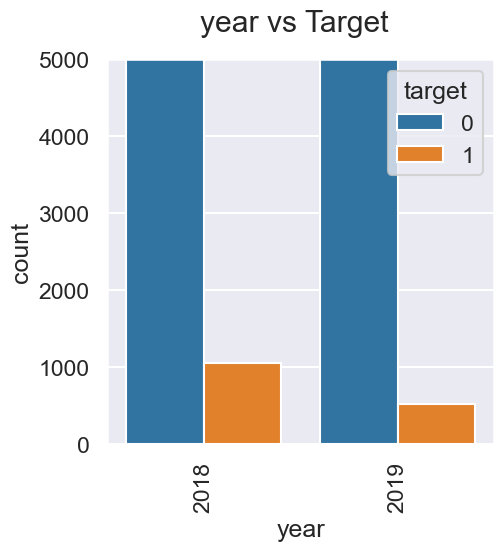

In [ ]:
fig, ax = plt.subplots()

sns.countplot(x="year", hue="target", data=df_new, ax=ax)
plt.xticks(rotation = 90)

ax.set_xlabel("year")
plt.ylim([0,5000])
fig.suptitle("year vs Target");

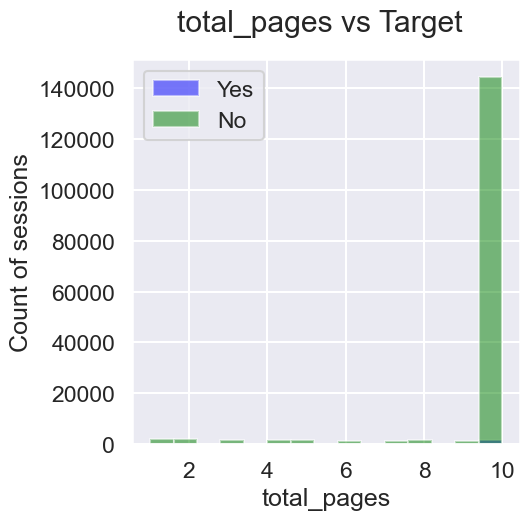

In [ ]:
fig, ax = plt.subplots()

ax.hist(df[df["target"]==1]["total_pages"], bins=15, alpha=0.5, color="blue", label="Yes")
ax.hist(df[df['target']==0]["total_pages"], bins=15, alpha=0.5, color="green", label="No")

ax.set_xlabel("total_pages")
ax.set_ylabel("Count of sessions")
plt.ylim([0,1000])
#plt.xlim([0,300])
fig.suptitle("total_pages vs Target")

ax.legend();

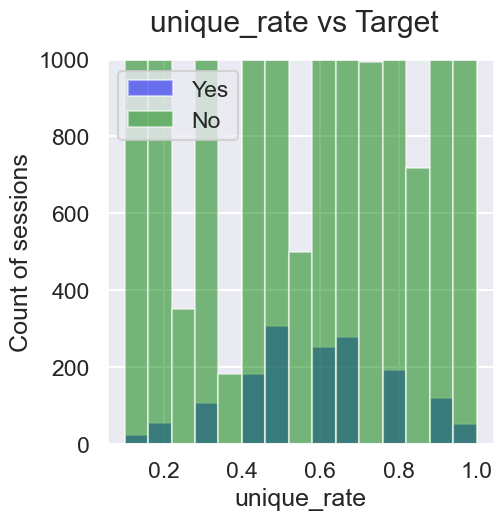

In [ ]:
fig, ax = plt.subplots()

ax.hist(df[df["target"]==1]["unique_rate"], bins=15, alpha=0.5, color="blue", label="Yes")
ax.hist(df[df['target']==0]["unique_rate"], bins=15, alpha=0.5, color="green", label="No")

ax.set_xlabel("unique_rate")
ax.set_ylabel("Count of sessions")
plt.ylim([0,1000])
#plt.xlim([0,300])
fig.suptitle("unique_rate vs Target")

ax.legend();

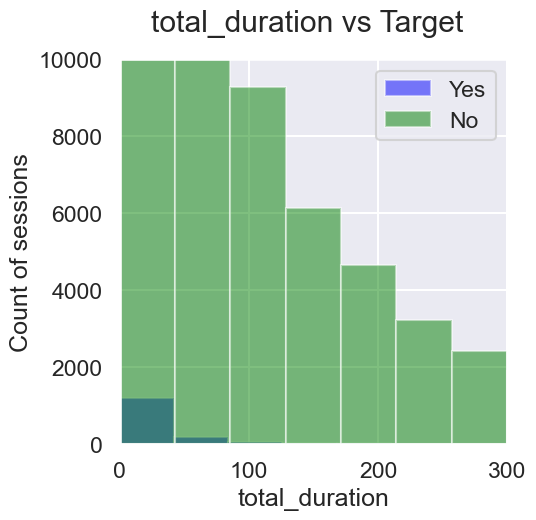

In [ ]:
fig, ax = plt.subplots()

ax.hist(df[df["target"]==1]["total_duration"], bins=42, alpha=0.5, color="blue", label="Yes")
ax.hist(df[df['target']==0]["total_duration"], bins=42, alpha=0.5, color="green", label="No")

ax.set_xlabel("total_duration")
ax.set_ylabel("Count of sessions")
plt.ylim([0,10000])
plt.xlim([0,300])
fig.suptitle("total_duration vs Target")

ax.legend();

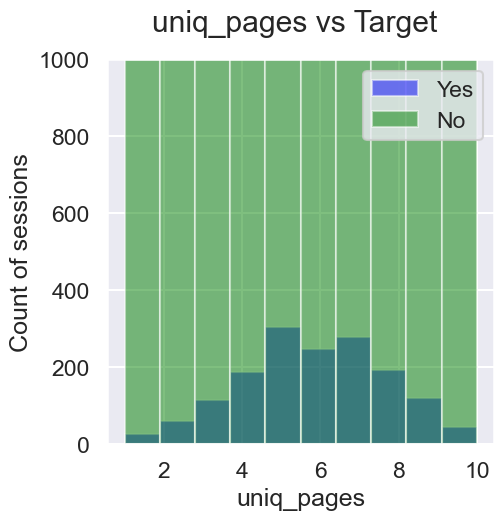

In [ ]:
fig, ax = plt.subplots()

ax.hist(df[df["target"]==1]["uniq_pages"], bins=10, alpha=0.5, color="blue", label="Yes")
ax.hist(df[df['target']==0]["uniq_pages"], bins=10, alpha=0.5, color="green", label="No")

ax.set_xlabel("uniq_pages")
ax.set_ylabel("Count of sessions")
plt.ylim([0,1000])
#plt.xlim([0,300])
fig.suptitle("uniq_pages vs Target")

ax.legend();

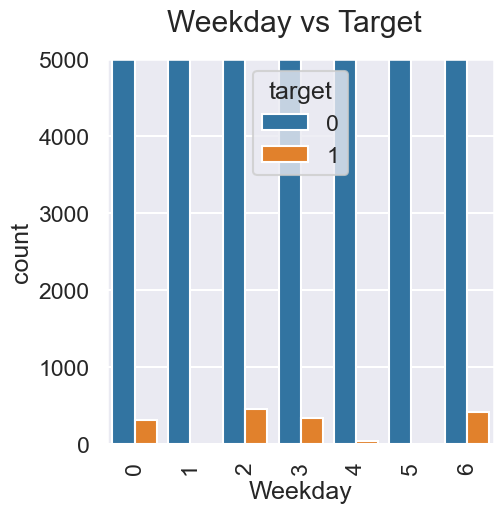

In [ ]:
fig, ax = plt.subplots()

sns.countplot(x="weekday", hue="target", data=df_new, ax=ax)
plt.xticks(rotation = 90)

ax.set_xlabel("Weekday")
plt.ylim([0,5000])
fig.suptitle("Weekday vs Target");

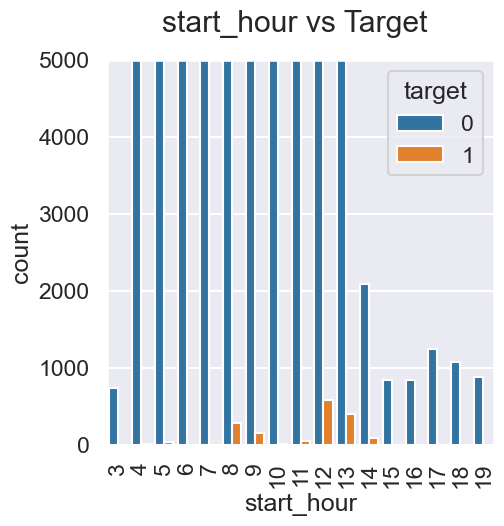

In [ ]:
fig, ax = plt.subplots()

sns.countplot(x="start_hour", hue="target", data=df_new, ax=ax)
plt.xticks(rotation = 90)

ax.set_xlabel("start_hour")
plt.ylim([0,5000])
fig.suptitle("start_hour vs Target");

## Preprocessing

In [ ]:
df_new.columns

Index(['target', 'duration1', 'duration2', 'duration3', 'duration4',
       'duration5', 'duration6', 'duration7', 'duration8', 'duration9',
       'total_duration', 'weekday', 'year', 'start_hour', 'start_page',
       'page_seq', 'total_pages', 'uniq_pages', 'avg_duration', 'unique_rate',
       'month', 'start_weekday'],
      dtype='object')

Numeric features:

In [ ]:
num_cols = ['duration' + str(i) for i in range(1,10)]
#num_cols = ['total_duration', 'uniq_pages', 'unique_rate']
num_cols.append('total_duration')
num_cols.append('uniq_pages')
num_cols.append('total_pages')
num_cols.append('avg_duration')
num_cols.append('unique_rate')

High cardinality feature:

In [ ]:
cat_hc_col= ['start_page']

Categorical features:

In [ ]:
cat_cols = ['start_weekday', 'year', 'month']

Text feature:

In [ ]:
text_col = ['page_seq']

For numeric features, I use StandardScaler (also tried MinMaxScaler but it get worse results). Categorical features encoded by OneHotEncoder, categorical feature with high cardinality - by HashingEncoder to reduce the dimensionality of data.

In [ ]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()) ])
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(drop='first',sparse=False)) ])
cat_hc_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('encoder', HashingEncoder(n_components=32)) ])


pipe = ColumnTransformer(transformers=[
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols),
    ('cat_hc', cat_hc_pipe, cat_hc_col),

])

In [ ]:
df_new.shape

(159969, 22)

In [ ]:
X = pipe.fit_transform(df_new.drop('target',axis=1))

Text feature vectorized by CountVectorizer:

In [ ]:
vect = CountVectorizer(ngram_range=(1,1))

In [ ]:
X_txt = vect.fit_transform(df_new['page_seq'])

In [ ]:
X_txt.shape

(159969, 29523)

In [ ]:
X.shape

(159969, 176)

Combining transformed features with vectorized text feature (as sparse matrix):

In [ ]:
X_tr = scipy.sparse.hstack((X_txt, scipy.sparse.csr_matrix(X)))

In [ ]:
X_tr

<159969x29592 sparse matrix of type '<class 'numpy.float64'>'
	with 3687665 stored elements in Compressed Sparse Row format>

Train-test splitting:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size=0.1, stratify = df_new.target)

In [ ]:
y = df_new.target

In [ ]:
counter = Counter(y_train)
counter

Counter({0: 110876, 1: 1102})

# Models

### SMOTE

In [ ]:
over = SMOTE(sampling_strategy=0.5, k_neighbors=3)
#under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('over', over)]
pipeline = imb_pipe(steps=steps)

In [ ]:
train_X, train_y = pipeline.fit_resample(X_train, y_train)
counter = Counter(train_y)
counter

Counter({0: 126715, 1: 63357})

### Logistic Regression

In [ ]:
clf = [
    LogisticRegression(solver='newton-cg',penalty='none',max_iter=1000),
    LogisticRegression(solver='lbfgs',penalty='none',max_iter=1000),
    LogisticRegression(solver='sag',penalty='none',max_iter=1000),
    LogisticRegression(solver='saga',penalty='none',max_iter=1000)
    ]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)

row_index = 0
for alg in clf:

    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 5)
    clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 5)
    clf_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'AUC'] = round(auc(fp, tp),5)

    row_index+=1

clf_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)
clf_compare

Train Accuracy  Test Accuracy  Precission   Recall      AUC
3         0.99634        0.99331     0.69202  0.57778  0.78761
2         0.99643        0.99312     0.67925  0.57143  0.78437
1         0.99645        0.99275     0.64561  0.58413  0.79047
0         0.99646        0.99222     0.61224  0.57143  0.78391

In [ ]:
clf = [
    LogisticRegression(solver='newton-cg',penalty='l2',max_iter=1000),
    LogisticRegression(solver='lbfgs',penalty='l2',max_iter=1000),
    LogisticRegression(solver='sag',penalty='l2',max_iter=1000),
    LogisticRegression(solver='saga',penalty='l2',max_iter=1000)
    ]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)

row_index = 0
for alg in clf:

    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 5)
    clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 5)
    clf_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'AUC'] = round(auc(fp, tp),5)

    row_index+=1

clf_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)
clf_compare

Train Accuracy  Test Accuracy  Precission   Recall      AUC
0         0.99502        0.99362     0.78462  0.48571  0.74219
1         0.99502        0.99362     0.78462  0.48571  0.74219
2         0.99503        0.99362     0.78462  0.48571  0.74219
3         0.99498        0.99353     0.77273  0.48571  0.74215

In [ ]:
clf = [
    LogisticRegression(solver='lbfgs',penalty='l2', C=0.001, max_iter=1000),
    LogisticRegression(solver='lbfgs',penalty='l2',C=0.01, max_iter=1000),
    LogisticRegression(solver='lbfgs',penalty='l2',C=0.1, max_iter=1000),
    LogisticRegression(solver='lbfgs',penalty='l2',C=1, max_iter=1000),
    LogisticRegression(solver='lbfgs',penalty='l2',C=5, max_iter=1000),
    LogisticRegression(solver='lbfgs',penalty='l2',C=10, max_iter=1000)
    ]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)

row_index = 0
for alg in clf:

    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 5)
    clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 5)
    clf_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'AUC'] = round(auc(fp, tp),5)

    row_index+=1

clf_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)
clf_compare

Train Accuracy  Test Accuracy  Precission   Recall      AUC
4         0.99605        0.99384     0.75000  0.56190  0.78002
5         0.99630        0.99375     0.73469  0.57143  0.78469
3         0.99502        0.99362     0.78462  0.48571  0.74219
2         0.99302        0.99287     0.88496  0.31746  0.65852
1         0.99047        0.99044     0.90909  0.03175  0.51586
0         0.99015        0.99015     0.00000  0.00000  0.50000

In [ ]:
parameters = {'C': [0.05, 0.1, 1, 5]}

lr_gs = GridSearchCV(LogisticRegression(class_weight='balanced', solver='lbfgs',penalty='l2', max_iter=1000), param_grid=parameters,
                           cv=StratifiedKFold(3), scoring='roc_auc', verbose=0, n_jobs=-1)

In [ ]:
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000),
             n_jobs=-1, param_grid={'C': [0.05, 0.1, 1, 5]}, scoring='roc_auc')

In [ ]:
lr_gs.best_params_

{'C': 0.1}

In [ ]:
lr_gs.best_score_

0.9838217494207013

In [ ]:
y_pred = lr_gs.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.9611802212914922

In [ ]:
lr = LogisticRegression(class_weight='balanced', solver='lbfgs',penalty='l2', max_iter=1500, C=0.1)
y_pred, y_probs = classifier_f(lr, X_train, y_train, X_test)


====F2 scores:====
         F2
0  0.967520
1  0.521939

====ROC AUC scores:====
    ROC AUC
0  0.948193
1  0.948193

====classification report:====
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     31679
           1       0.19      0.94      0.31       315

    accuracy                           0.96     31994
   macro avg       0.59      0.95      0.65     31994
weighted avg       0.99      0.96      0.97     31994


====confusion matrix====


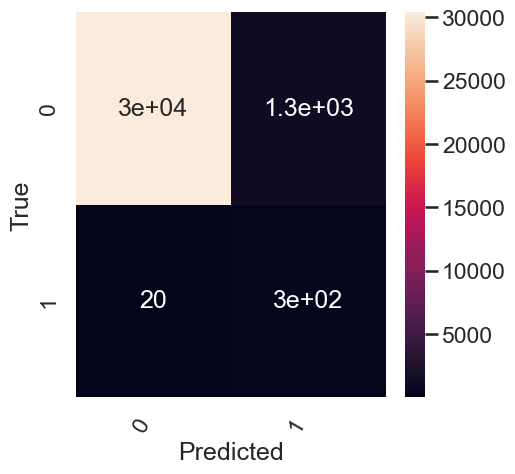

In [ ]:
report(y_test, y_pred)

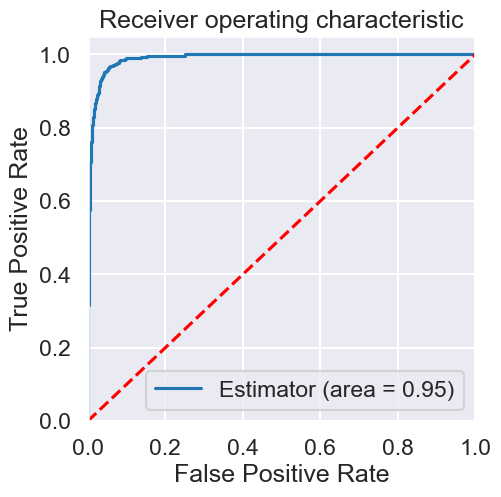

In [ ]:
roc_auc(lr_gs, X_test, y_test)


### SVC

In [ ]:
svc_model = SVC(class_weight='balanced', probability=True)
y_pred, y_probs = classifier_f(svc_model, X_train, y_train, X_test)


====F2 scores:====
         F2
0  0.995647
1  0.769690

====ROC AUC scores:====
   ROC AUC
0  0.90703
1  0.90703

====classification report:====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31679
           1       0.62      0.82      0.71       315

    accuracy                           0.99     31994
   macro avg       0.81      0.91      0.85     31994
weighted avg       0.99      0.99      0.99     31994


====confusion matrix====


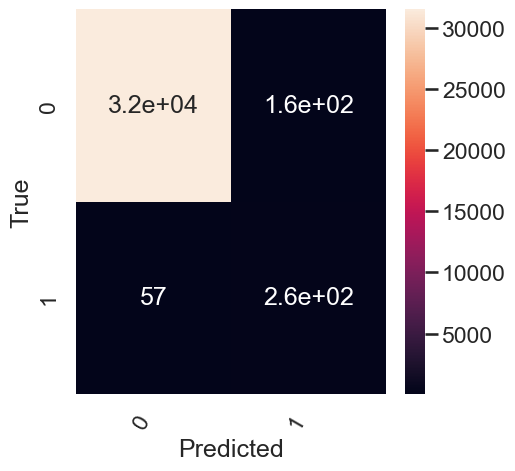

In [ ]:
report(y_test, y_pred)

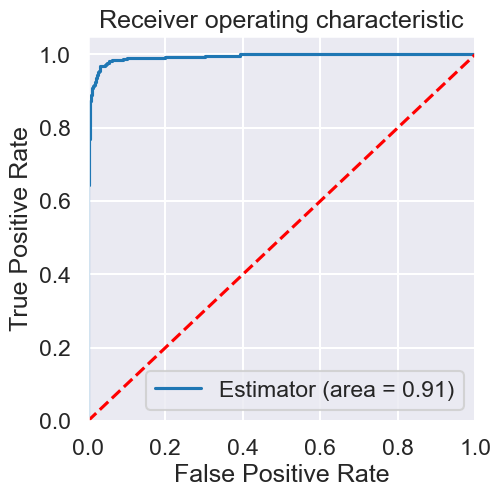

In [ ]:
roc_auc(svc_model, X_test, y_test)

### SGD Classifier

In [ ]:
sgd = SGDClassifier(random_state=42, loss='log')
y_pred, y_probs = classifier_f(sgd, X_train, y_train, X_test)


====F2 scores:====
         F2
0  0.998146
1  0.339168

====ROC AUC scores:====
    ROC AUC
0  0.647335
1  0.647335

====classification report:====
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31679
           1       0.84      0.30      0.44       315

    accuracy                           0.99     31994
   macro avg       0.92      0.65      0.72     31994
weighted avg       0.99      0.99      0.99     31994


====confusion matrix====


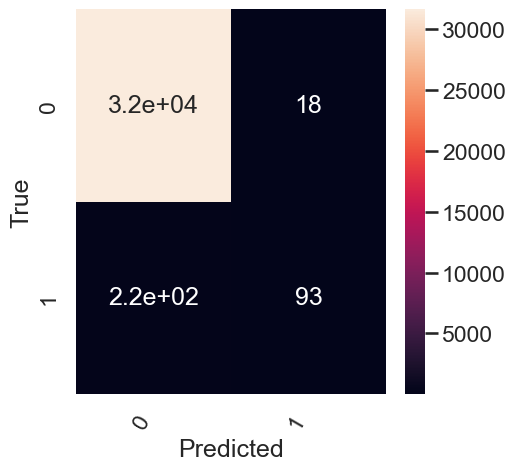

In [ ]:
report(y_test, y_pred)

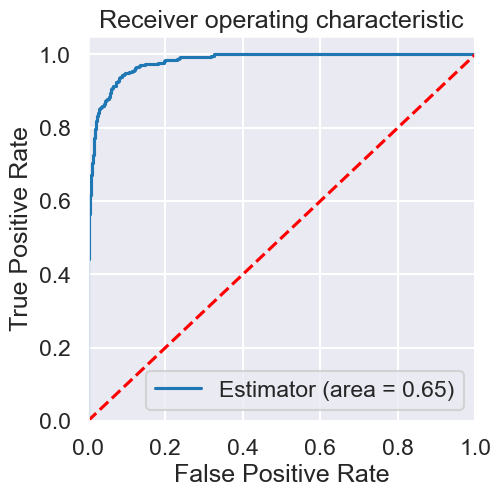

In [ ]:
roc_auc(sgd, X_test, y_test)

### KNN Classifier


====F2 scores:====
         F2
0  0.998160
1  0.164373

====ROC AUC scores:====
    ROC AUC
0  0.568175
1  0.568175

====classification report:====
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31679
           1       0.90      0.14      0.24       315

    accuracy                           0.99     31994
   macro avg       0.94      0.57      0.62     31994
weighted avg       0.99      0.99      0.99     31994


====confusion matrix====


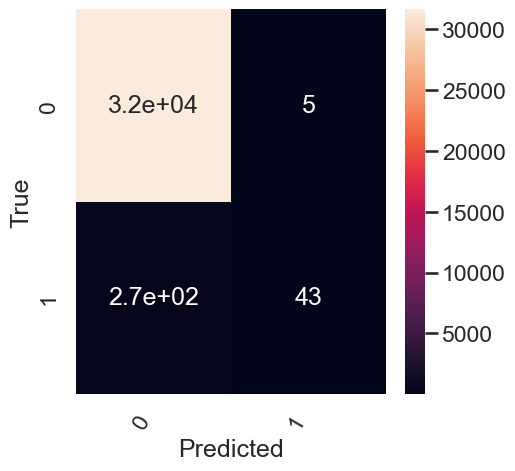

In [ ]:
KNN = KNeighborsClassifier(leaf_size=30, n_neighbors=20, n_jobs= -1)
y_pred, y_probs = classifier_f(KNN, X_train, y_train, X_test)
report(y_test, y_pred)

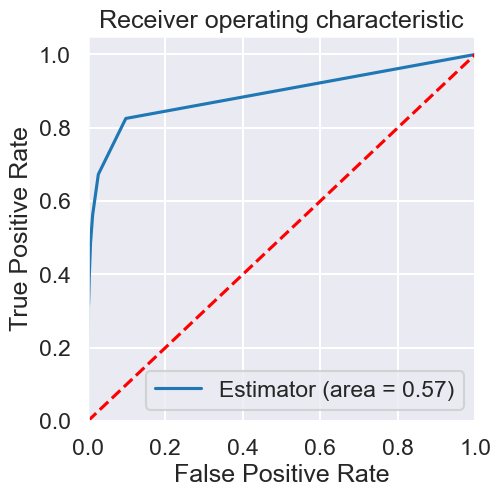

In [ ]:
roc_auc(KNN, X_test, y_test)

### Random Forest


====F2 scores:====
         F2
0  0.998493
1  0.298285

====ROC AUC scores:====
    ROC AUC
0  0.626968
1  0.626968

====classification report:====
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31679
           1       0.99      0.25      0.40       315

    accuracy                           0.99     31994
   macro avg       0.99      0.63      0.70     31994
weighted avg       0.99      0.99      0.99     31994


====confusion matrix====


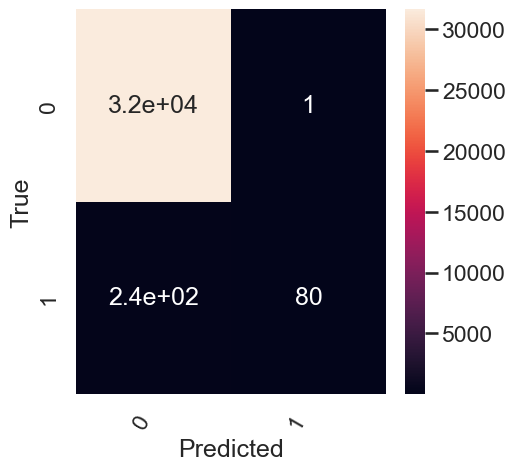

In [ ]:
rf = RandomForestClassifier(n_estimators = 200)
y_pred, y_probs = classifier_f(rf, train_X, train_y, X_test)
report(y_test, y_pred)

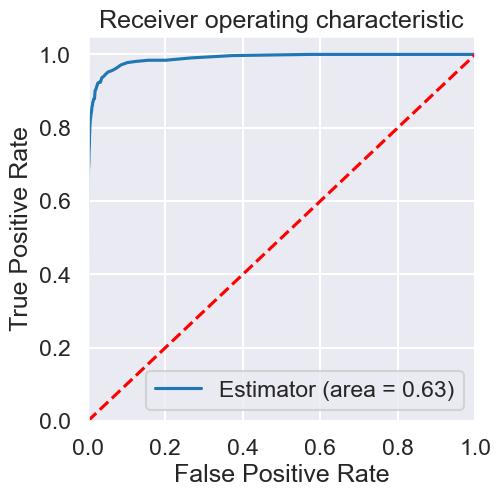

In [ ]:
roc_auc(rf, X_test, y_test)

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [ ]:
rf_gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid,
                           cv=StratifiedKFold(3), scoring='roc_auc', verbose=0, n_jobs=-1)

In [ ]:
rf_gs.fit(train_X, train_y)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             scoring='roc_auc')

In [ ]:
rf_gs.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 1000}

In [ ]:
rf_gs.best_score_

0.999079108318241


====F2 scores:====
         F2
0  0.998015
1  0.000000

====ROC AUC scores:====
   ROC AUC
0      0.5
1      0.5

====classification report:====
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31679
           1       0.00      0.00      0.00       315

    accuracy                           0.99     31994
   macro avg       0.50      0.50      0.50     31994
weighted avg       0.98      0.99      0.99     31994


====confusion matrix====


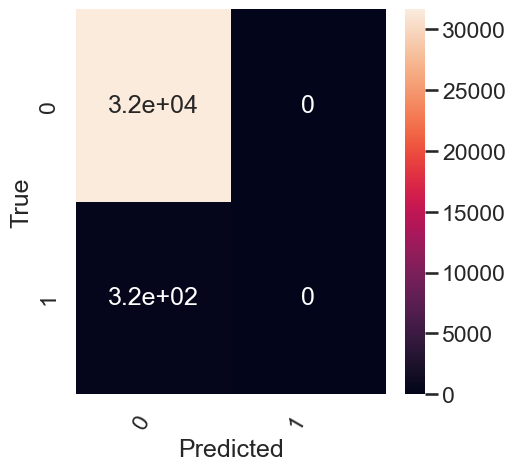

In [ ]:
rf = RandomForestClassifier(n_estimators = 1000, bootstrap=True, max_depth=90, min_samples_leaf=3, min_samples_split=10)
y_pred, y_probs = classifier_f(rf, X_train, y_train, X_test)
report(y_test, y_pred)

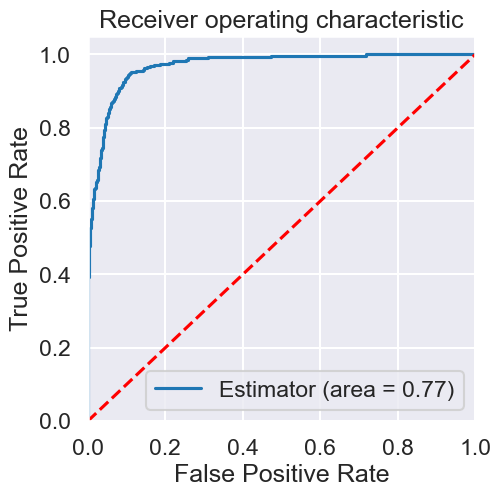

In [ ]:
roc_auc(rf, X_test, y_test)

### Balanced Bagging Classifier


====F2 scores:====
         F2
0  0.933793
1  0.340550

====ROC AUC scores:====
    ROC AUC
0  0.903866
1  0.903866

====classification report:====
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     31679
           1       0.10      0.89      0.18       315

    accuracy                           0.92     31994
   macro avg       0.55      0.90      0.57     31994
weighted avg       0.99      0.92      0.95     31994


====confusion matrix====


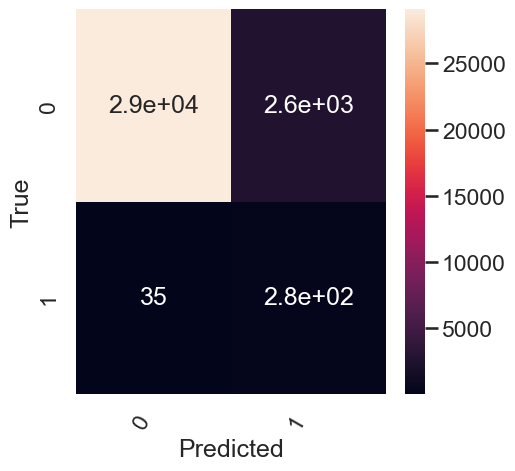

In [ ]:
bbc = BalancedBaggingClassifier()
y_pred, y_probs = classifier_f(bbc, X_train, y_train, X_test)
report(y_test, y_pred)

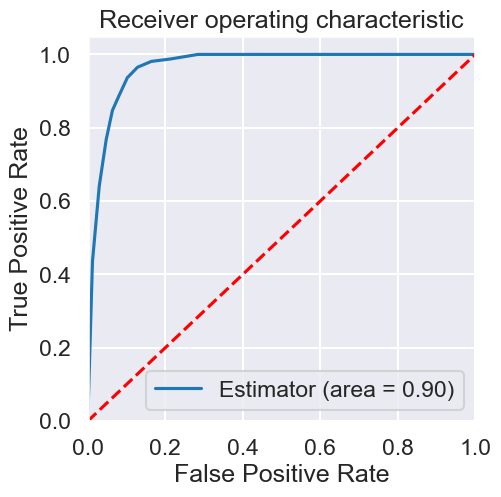

In [ ]:
roc_auc(bbc, X_test, y_test)

### BalancedRandomForestClassifier


====F2 scores:====
         F2
0  0.996584
1  0.706692

====ROC AUC scores:====
    ROC AUC
0  0.856947
1  0.856947

====classification report:====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31679
           1       0.67      0.72      0.69       315

    accuracy                           0.99     31994
   macro avg       0.83      0.86      0.84     31994
weighted avg       0.99      0.99      0.99     31994


====confusion matrix====


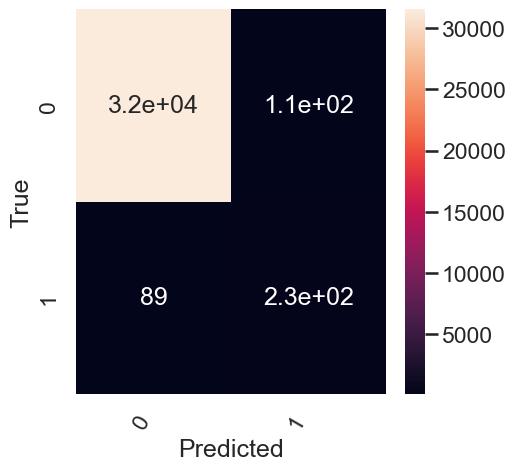

In [ ]:
brfc = BalancedRandomForestClassifier(n_estimators=150, sampling_strategy=0.12, random_state=42, class_weight='balanced')
y_pred, y_probs = classifier_f(brfc, X_train, y_train, X_test)
report(y_test, y_pred)

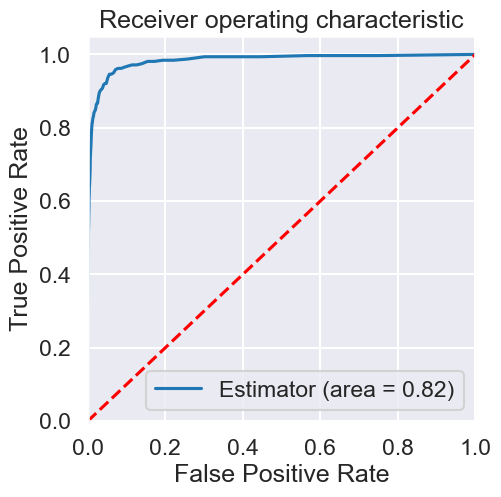

In [ ]:
roc_auc(brfc, X_test, y_test)

### Gradient Boosting


====F2 scores:====
         F2
0  0.997862
1  0.497925

====ROC AUC scores:====
    ROC AUC
0  0.727909
1  0.727909

====classification report:====
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31679
           1       0.77      0.46      0.57       315

    accuracy                           0.99     31994
   macro avg       0.88      0.73      0.79     31994
weighted avg       0.99      0.99      0.99     31994


====confusion matrix====


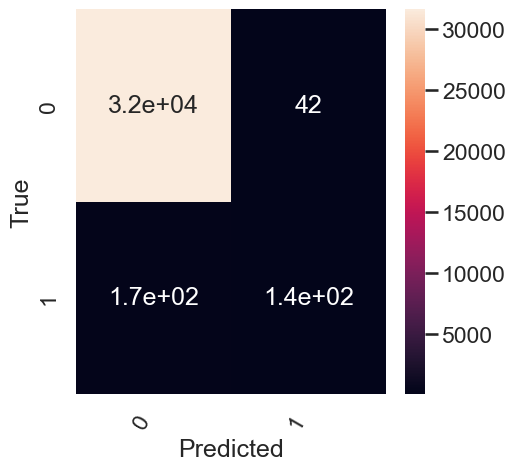

In [ ]:
gbc = GradientBoostingClassifier()
y_pred, y_probs = classifier_f(gbc, X_train, y_train, X_test)
report(y_test, y_pred)

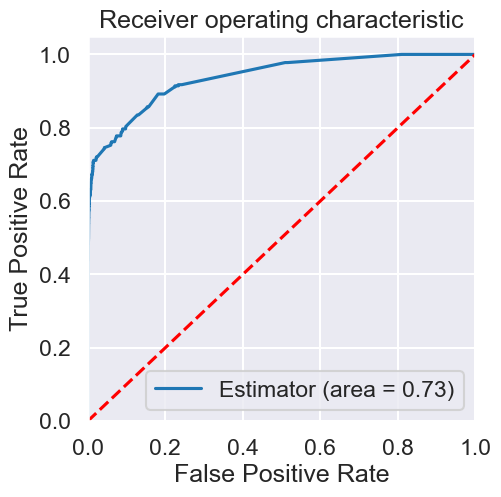

In [ ]:
roc_auc(gbc, X_test, y_test)

In [ ]:
sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = 0.1
sample_weights[y_train == 1] = 10

In [ ]:
gbc = GradientBoostingClassifier()

In [ ]:
gbc.fit(X_train, y_train, sample_weight = sample_weights)

GradientBoostingClassifier()

In [ ]:
y_pred = gbc.predict(X_test)


====F2 scores:====
         F2
0  0.915238
1  0.307788

====classification report:====
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     31679
           1       0.08      0.95      0.15       315

    accuracy                           0.90     31994
   macro avg       0.54      0.92      0.55     31994
weighted avg       0.99      0.90      0.94     31994


====confusion matrix====


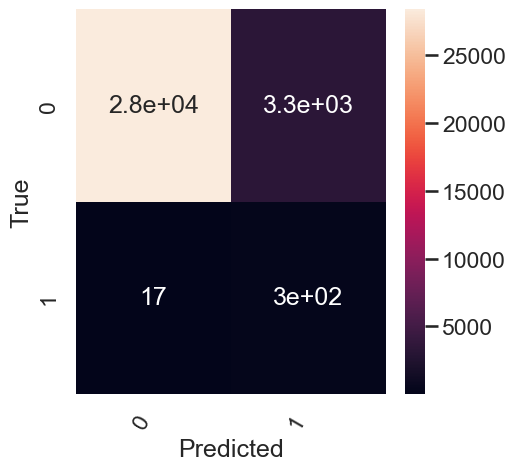

In [ ]:
report(y_test, y_pred)

In [ ]:
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}
gbc_gs = GridSearchCV(gbc, param_grid=parameters,
                           cv=StratifiedKFold(3), scoring='f1', verbose=0, n_jobs=-1)

In [ ]:
gbc_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [5, 50, 250, 500]},
             scoring='f1')

In [ ]:
gbc_gs.best_score_

0.6359027023427518

In [ ]:
gbc_gs.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250}

In [ ]:
y_pred = gbc_gs.predict(X_test)


====F2 scores:====
         F2
0  0.997450
1  0.638925

====classification report:====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31679
           1       0.73      0.62      0.67       315

    accuracy                           0.99     31994
   macro avg       0.86      0.81      0.83     31994
weighted avg       0.99      0.99      0.99     31994


====confusion matrix====


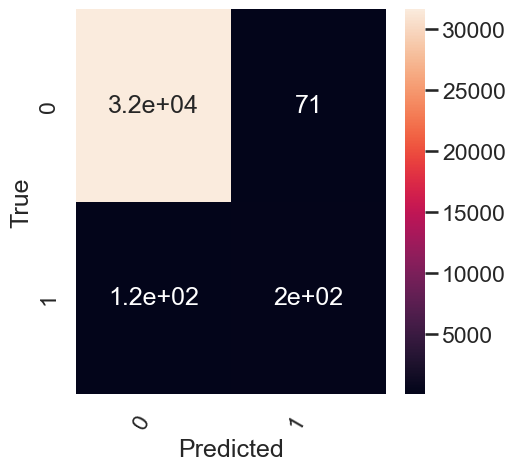

In [ ]:
report(y_test, y_pred)

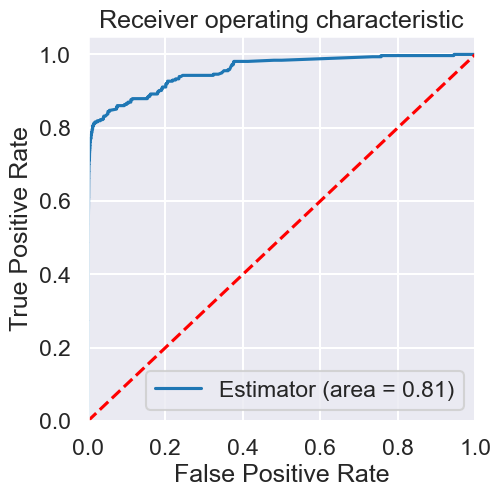

In [ ]:
roc_auc(gbc_gs, X_test, y_test)


====F2 scores:====
         F2
0  0.997532
1  0.643045

====ROC AUC scores:====
    ROC AUC
0  0.810038
1  0.810038

====classification report:====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31679
           1       0.74      0.62      0.68       315

    accuracy                           0.99     31994
   macro avg       0.87      0.81      0.84     31994
weighted avg       0.99      0.99      0.99     31994


====confusion matrix====


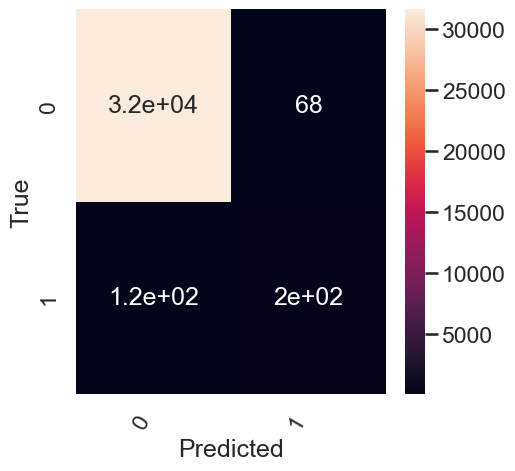

In [ ]:
gbc = GradientBoostingClassifier(loss='deviance',learning_rate= 0.1, max_depth= 7, n_estimators= 250)
y_pred, y_probs = classifier_f(gbc, X_train, y_train, X_test)
report(y_test, y_pred)

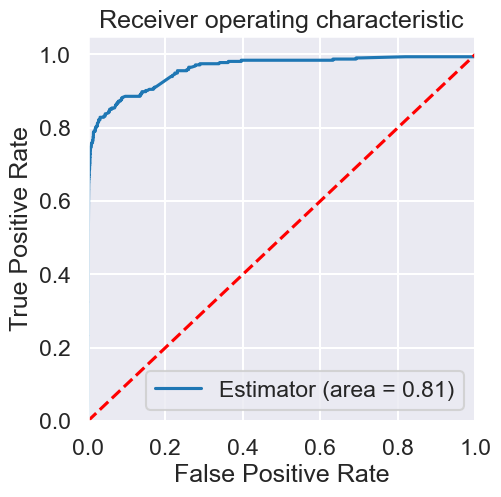

In [ ]:
roc_auc(gbc, X_test, y_test)

### XGBoot


====F2 scores:====
         F2
0  0.962538
1  0.414131

====ROC AUC scores:====
    ROC AUC
0  0.865956
1  0.865956

====classification report:====
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     31679
           1       0.14      0.78      0.24       315

    accuracy                           0.95     31994
   macro avg       0.57      0.87      0.61     31994
weighted avg       0.99      0.95      0.97     31994


====confusion matrix====


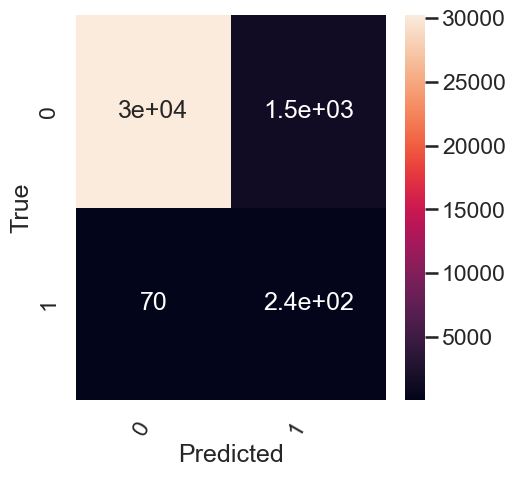

In [ ]:
xgbc = XGBClassifier(eta=0.1, max_depth=7, n_estimators= 250, scale_pos_weight=100)
y_pred, y_probs = classifier_f(xgbc, X_train, y_train, X_test)
report(y_test, y_pred)

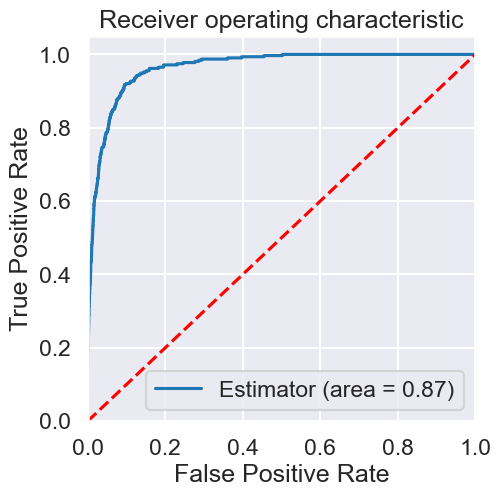

In [ ]:
roc_auc(xgbc, X_test, y_test)

In [ ]:
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 100.567


In [ ]:
xgbc = XGBClassifier(eta=0.2, max_depth=7, n_estimators= 250)

In [ ]:
parameters = {
    'eta':[0.1,0.2],
    "n_estimators":[150,200,250],
    "max_depth":[6,7,8],
}

In [ ]:
parameters2 = {
    'scale_pos_weight':[50, 100, 101, 150]
}

In [ ]:
xgbc_gs = GridSearchCV(xgbc, param_grid=parameters2,
                           cv=StratifiedKFold(3), scoring='roc_auc', verbose=0, n_jobs=-1)
xgbc_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eta=0.2,
                                     eval_metric=None, feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     imp...
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, ma

In [ ]:
xgbc_gs.best_params_

{'scale_pos_weight': 50}

In [ ]:
xgbc_gs.best_score_

0.9896353358183309


====F2 scores:====
         F2
0  0.998409
1  0.795235

====ROC AUC scores:====
    ROC AUC
0  0.891337
1  0.891337

====classification report:====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31679
           1       0.84      0.78      0.81       315

    accuracy                           1.00     31994
   macro avg       0.92      0.89      0.91     31994
weighted avg       1.00      1.00      1.00     31994


====confusion matrix====


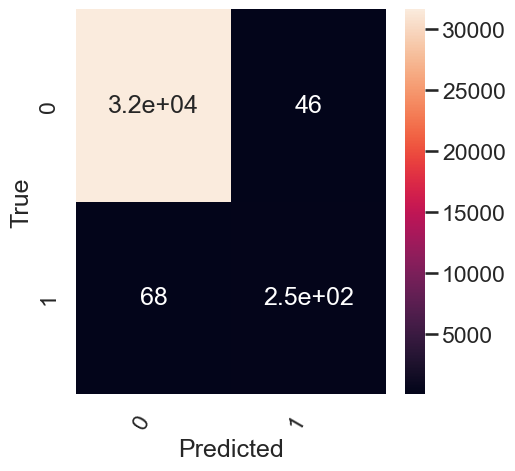

In [ ]:
xgbc = XGBClassifier(eta=0.2, max_depth=17, n_estimators= 300, scale_pos_weight=101, subsample=0.9, colsample_bytree=0.6)
y_pred, y_probs = classifier_f(xgbc, X_train, y_train, X_test)
report(y_test, y_pred)

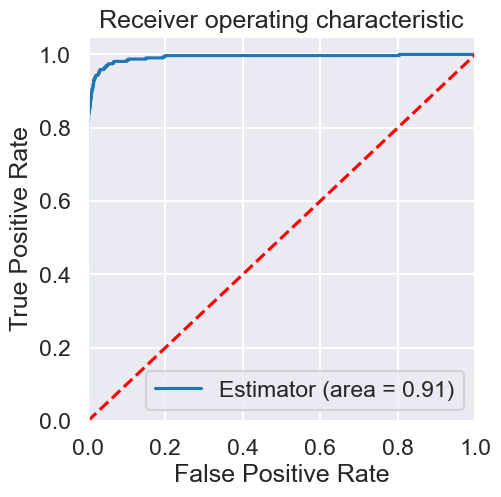

In [ ]:
roc_auc(xgbc, X_test, y_test)

In [ ]:
%%time

def objective(space):
    params = {
        'colsample_bytree': '{:.3f}'.format(space['colsample_bytree']),
        'learning_rate': '{:.3f}'.format(space['learning_rate']),
        'alpha' : '{:.3f}'.format(space['alpha']),
        'n_estimators': space['n_estimators']
    }

    clf = XGBClassifier(
        objective ='binary:logistic',
        random_state=42,
        **params
    )

    score = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=10).mean()
    print("AUC {:.3f} params {}".format(score, params))
    return {'loss':1 - score, 'status': STATUS_OK }

space = {
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0, 1),
    'alpha': hp.uniform('alpha', 0, 10),
    'n_estimators': hp.choice('n_estimators', [100, 1000, 3000])
    }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

  0%|          | 0/10 [16:56<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

### CatBoost

In [ ]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

0:	total: 207ms	remaining: 10m 20s
1:	total: 408ms	remaining: 10m 11s
2:	total: 593ms	remaining: 9m 52s
3:	total: 785ms	remaining: 9m 47s
4:	total: 964ms	remaining: 9m 37s
5:	total: 1.14s	remaining: 9m 30s
6:	total: 1.32s	remaining: 9m 22s
7:	total: 1.46s	remaining: 9m 6s
8:	total: 1.63s	remaining: 9m 1s
9:	total: 1.79s	remaining: 8m 55s
10:	total: 1.99s	remaining: 9m 1s
11:	total: 2.22s	remaining: 9m 13s
12:	total: 2.41s	remaining: 9m 14s
13:	total: 2.59s	remaining: 9m 12s
14:	total: 2.74s	remaining: 9m 5s
15:	total: 2.89s	remaining: 8m 59s
16:	total: 3.11s	remaining: 9m 5s
17:	total: 3.26s	remaining: 9m
18:	total: 3.42s	remaining: 8m 57s
19:	total: 3.57s	remaining: 8m 51s
20:	total: 3.74s	remaining: 8m 50s
21:	total: 3.9s	remaining: 8m 47s
22:	total: 4.07s	remaining: 8m 46s
23:	total: 4.22s	remaining: 8m 42s
24:	total: 4.37s	remaining: 8m 40s
25:	total: 4.54s	remaining: 8m 39s
26:	total: 4.73s	remaining: 8m 41s
27:	total: 4.92s	remaining: 8m 42s
28:	total: 5.09s	remaining: 8m 41s
29:

233:	total: 43.8s	remaining: 8m 37s
234:	total: 44s	remaining: 8m 37s
235:	total: 44.2s	remaining: 8m 37s
236:	total: 44.3s	remaining: 8m 36s
237:	total: 44.5s	remaining: 8m 36s
238:	total: 44.7s	remaining: 8m 36s
239:	total: 44.9s	remaining: 8m 36s
240:	total: 45.1s	remaining: 8m 36s
241:	total: 45.3s	remaining: 8m 36s
242:	total: 45.5s	remaining: 8m 36s
243:	total: 45.7s	remaining: 8m 36s
244:	total: 45.9s	remaining: 8m 36s
245:	total: 46.1s	remaining: 8m 35s
246:	total: 46.2s	remaining: 8m 35s
247:	total: 46.4s	remaining: 8m 34s
248:	total: 46.5s	remaining: 8m 34s
249:	total: 46.7s	remaining: 8m 33s
250:	total: 46.9s	remaining: 8m 33s
251:	total: 47.1s	remaining: 8m 33s
252:	total: 47.3s	remaining: 8m 33s
253:	total: 47.4s	remaining: 8m 32s
254:	total: 47.6s	remaining: 8m 32s
255:	total: 47.8s	remaining: 8m 32s
256:	total: 48s	remaining: 8m 32s
257:	total: 48.1s	remaining: 8m 31s
258:	total: 48.3s	remaining: 8m 30s
259:	total: 48.4s	remaining: 8m 30s
260:	total: 48.6s	remaining: 8m 

459:	total: 1m 33s	remaining: 8m 36s
460:	total: 1m 33s	remaining: 8m 35s
461:	total: 1m 33s	remaining: 8m 35s
462:	total: 1m 34s	remaining: 8m 35s
463:	total: 1m 34s	remaining: 8m 35s
464:	total: 1m 34s	remaining: 8m 34s
465:	total: 1m 34s	remaining: 8m 35s
466:	total: 1m 35s	remaining: 8m 35s
467:	total: 1m 35s	remaining: 8m 35s
468:	total: 1m 35s	remaining: 8m 35s
469:	total: 1m 35s	remaining: 8m 35s
470:	total: 1m 36s	remaining: 8m 35s
471:	total: 1m 36s	remaining: 8m 35s
472:	total: 1m 36s	remaining: 8m 35s
473:	total: 1m 36s	remaining: 8m 35s
474:	total: 1m 36s	remaining: 8m 35s
475:	total: 1m 37s	remaining: 8m 34s
476:	total: 1m 37s	remaining: 8m 34s
477:	total: 1m 37s	remaining: 8m 34s
478:	total: 1m 37s	remaining: 8m 34s
479:	total: 1m 38s	remaining: 8m 34s
480:	total: 1m 38s	remaining: 8m 34s
481:	total: 1m 38s	remaining: 8m 34s
482:	total: 1m 38s	remaining: 8m 34s
483:	total: 1m 38s	remaining: 8m 34s
484:	total: 1m 39s	remaining: 8m 34s
485:	total: 1m 39s	remaining: 8m 33s
4

684:	total: 2m 19s	remaining: 7m 52s
685:	total: 2m 20s	remaining: 7m 52s
686:	total: 2m 20s	remaining: 7m 52s
687:	total: 2m 20s	remaining: 7m 52s
688:	total: 2m 20s	remaining: 7m 52s
689:	total: 2m 21s	remaining: 7m 52s
690:	total: 2m 21s	remaining: 7m 51s
691:	total: 2m 21s	remaining: 7m 51s
692:	total: 2m 21s	remaining: 7m 51s
693:	total: 2m 21s	remaining: 7m 50s
694:	total: 2m 21s	remaining: 7m 50s
695:	total: 2m 22s	remaining: 7m 50s
696:	total: 2m 22s	remaining: 7m 50s
697:	total: 2m 22s	remaining: 7m 49s
698:	total: 2m 22s	remaining: 7m 49s
699:	total: 2m 22s	remaining: 7m 49s
700:	total: 2m 23s	remaining: 7m 49s
701:	total: 2m 23s	remaining: 7m 48s
702:	total: 2m 23s	remaining: 7m 48s
703:	total: 2m 23s	remaining: 7m 48s
704:	total: 2m 23s	remaining: 7m 47s
705:	total: 2m 23s	remaining: 7m 47s
706:	total: 2m 24s	remaining: 7m 47s
707:	total: 2m 24s	remaining: 7m 47s
708:	total: 2m 24s	remaining: 7m 46s
709:	total: 2m 24s	remaining: 7m 46s
710:	total: 2m 24s	remaining: 7m 46s
7

908:	total: 3m 3s	remaining: 7m 2s
909:	total: 3m 3s	remaining: 7m 2s
910:	total: 3m 4s	remaining: 7m 2s
911:	total: 3m 4s	remaining: 7m 2s
912:	total: 3m 4s	remaining: 7m 2s
913:	total: 3m 4s	remaining: 7m 1s
914:	total: 3m 5s	remaining: 7m 1s
915:	total: 3m 5s	remaining: 7m 1s
916:	total: 3m 5s	remaining: 7m 1s
917:	total: 3m 5s	remaining: 7m 1s
918:	total: 3m 5s	remaining: 7m 1s
919:	total: 3m 6s	remaining: 7m
920:	total: 3m 6s	remaining: 7m
921:	total: 3m 6s	remaining: 7m
922:	total: 3m 6s	remaining: 7m
923:	total: 3m 7s	remaining: 7m
924:	total: 3m 7s	remaining: 7m
925:	total: 3m 7s	remaining: 6m 59s
926:	total: 3m 7s	remaining: 6m 59s
927:	total: 3m 7s	remaining: 6m 59s
928:	total: 3m 8s	remaining: 6m 59s
929:	total: 3m 8s	remaining: 6m 59s
930:	total: 3m 8s	remaining: 6m 59s
931:	total: 3m 8s	remaining: 6m 59s
932:	total: 3m 9s	remaining: 6m 59s
933:	total: 3m 9s	remaining: 6m 58s
934:	total: 3m 9s	remaining: 6m 58s
935:	total: 3m 9s	remaining: 6m 58s
936:	total: 3m 10s	remainin

1128:	total: 3m 46s	remaining: 6m 14s
1129:	total: 3m 46s	remaining: 6m 14s
1130:	total: 3m 46s	remaining: 6m 14s
1131:	total: 3m 46s	remaining: 6m 14s
1132:	total: 3m 47s	remaining: 6m 14s
1133:	total: 3m 47s	remaining: 6m 13s
1134:	total: 3m 47s	remaining: 6m 13s
1135:	total: 3m 47s	remaining: 6m 13s
1136:	total: 3m 47s	remaining: 6m 13s
1137:	total: 3m 48s	remaining: 6m 13s
1138:	total: 3m 48s	remaining: 6m 12s
1139:	total: 3m 48s	remaining: 6m 12s
1140:	total: 3m 48s	remaining: 6m 12s
1141:	total: 3m 48s	remaining: 6m 12s
1142:	total: 3m 48s	remaining: 6m 12s
1143:	total: 3m 49s	remaining: 6m 11s
1144:	total: 3m 49s	remaining: 6m 11s
1145:	total: 3m 49s	remaining: 6m 11s
1146:	total: 3m 49s	remaining: 6m 11s
1147:	total: 3m 49s	remaining: 6m 11s
1148:	total: 3m 50s	remaining: 6m 10s
1149:	total: 3m 50s	remaining: 6m 10s
1150:	total: 3m 50s	remaining: 6m 10s
1151:	total: 3m 50s	remaining: 6m 10s
1152:	total: 3m 50s	remaining: 6m 10s
1153:	total: 3m 51s	remaining: 6m 9s
1154:	total: 

1348:	total: 4m 26s	remaining: 5m 26s
1349:	total: 4m 27s	remaining: 5m 26s
1350:	total: 4m 27s	remaining: 5m 26s
1351:	total: 4m 27s	remaining: 5m 26s
1352:	total: 4m 27s	remaining: 5m 25s
1353:	total: 4m 27s	remaining: 5m 25s
1354:	total: 4m 28s	remaining: 5m 25s
1355:	total: 4m 28s	remaining: 5m 25s
1356:	total: 4m 28s	remaining: 5m 25s
1357:	total: 4m 28s	remaining: 5m 24s
1358:	total: 4m 28s	remaining: 5m 24s
1359:	total: 4m 29s	remaining: 5m 24s
1360:	total: 4m 29s	remaining: 5m 24s
1361:	total: 4m 29s	remaining: 5m 24s
1362:	total: 4m 29s	remaining: 5m 23s
1363:	total: 4m 29s	remaining: 5m 23s
1364:	total: 4m 29s	remaining: 5m 23s
1365:	total: 4m 30s	remaining: 5m 23s
1366:	total: 4m 30s	remaining: 5m 22s
1367:	total: 4m 30s	remaining: 5m 22s
1368:	total: 4m 30s	remaining: 5m 22s
1369:	total: 4m 30s	remaining: 5m 22s
1370:	total: 4m 31s	remaining: 5m 22s
1371:	total: 4m 31s	remaining: 5m 21s
1372:	total: 4m 31s	remaining: 5m 21s
1373:	total: 4m 31s	remaining: 5m 21s
1374:	total:

1568:	total: 5m 12s	remaining: 4m 44s
1569:	total: 5m 12s	remaining: 4m 44s
1570:	total: 5m 12s	remaining: 4m 44s
1571:	total: 5m 13s	remaining: 4m 44s
1572:	total: 5m 13s	remaining: 4m 44s
1573:	total: 5m 13s	remaining: 4m 44s
1574:	total: 5m 13s	remaining: 4m 43s
1575:	total: 5m 14s	remaining: 4m 43s
1576:	total: 5m 14s	remaining: 4m 43s
1577:	total: 5m 14s	remaining: 4m 43s
1578:	total: 5m 14s	remaining: 4m 43s
1579:	total: 5m 14s	remaining: 4m 43s
1580:	total: 5m 15s	remaining: 4m 42s
1581:	total: 5m 15s	remaining: 4m 42s
1582:	total: 5m 15s	remaining: 4m 42s
1583:	total: 5m 15s	remaining: 4m 42s
1584:	total: 5m 15s	remaining: 4m 42s
1585:	total: 5m 16s	remaining: 4m 41s
1586:	total: 5m 16s	remaining: 4m 41s
1587:	total: 5m 16s	remaining: 4m 41s
1588:	total: 5m 16s	remaining: 4m 41s
1589:	total: 5m 16s	remaining: 4m 41s
1590:	total: 5m 17s	remaining: 4m 40s
1591:	total: 5m 17s	remaining: 4m 40s
1592:	total: 5m 17s	remaining: 4m 40s
1593:	total: 5m 17s	remaining: 4m 40s
1594:	total:

1786:	total: 5m 53s	remaining: 3m 59s
1787:	total: 5m 53s	remaining: 3m 59s
1788:	total: 5m 53s	remaining: 3m 59s
1789:	total: 5m 53s	remaining: 3m 59s
1790:	total: 5m 54s	remaining: 3m 59s
1791:	total: 5m 54s	remaining: 3m 58s
1792:	total: 5m 54s	remaining: 3m 58s
1793:	total: 5m 54s	remaining: 3m 58s
1794:	total: 5m 54s	remaining: 3m 58s
1795:	total: 5m 54s	remaining: 3m 57s
1796:	total: 5m 55s	remaining: 3m 57s
1797:	total: 5m 55s	remaining: 3m 57s
1798:	total: 5m 55s	remaining: 3m 57s
1799:	total: 5m 55s	remaining: 3m 57s
1800:	total: 5m 55s	remaining: 3m 56s
1801:	total: 5m 55s	remaining: 3m 56s
1802:	total: 5m 56s	remaining: 3m 56s
1803:	total: 5m 56s	remaining: 3m 56s
1804:	total: 5m 56s	remaining: 3m 56s
1805:	total: 5m 56s	remaining: 3m 55s
1806:	total: 5m 56s	remaining: 3m 55s
1807:	total: 5m 57s	remaining: 3m 55s
1808:	total: 5m 57s	remaining: 3m 55s
1809:	total: 5m 57s	remaining: 3m 54s
1810:	total: 5m 57s	remaining: 3m 54s
1811:	total: 5m 57s	remaining: 3m 54s
1812:	total:

2005:	total: 6m 33s	remaining: 3m 14s
2006:	total: 6m 33s	remaining: 3m 14s
2007:	total: 6m 33s	remaining: 3m 14s
2008:	total: 6m 34s	remaining: 3m 14s
2009:	total: 6m 34s	remaining: 3m 14s
2010:	total: 6m 34s	remaining: 3m 13s
2011:	total: 6m 34s	remaining: 3m 13s
2012:	total: 6m 34s	remaining: 3m 13s
2013:	total: 6m 34s	remaining: 3m 13s
2014:	total: 6m 35s	remaining: 3m 13s
2015:	total: 6m 35s	remaining: 3m 12s
2016:	total: 6m 35s	remaining: 3m 12s
2017:	total: 6m 35s	remaining: 3m 12s
2018:	total: 6m 35s	remaining: 3m 12s
2019:	total: 6m 36s	remaining: 3m 12s
2020:	total: 6m 36s	remaining: 3m 11s
2021:	total: 6m 36s	remaining: 3m 11s
2022:	total: 6m 36s	remaining: 3m 11s
2023:	total: 6m 36s	remaining: 3m 11s
2024:	total: 6m 37s	remaining: 3m 11s
2025:	total: 6m 37s	remaining: 3m 11s
2026:	total: 6m 37s	remaining: 3m 10s
2027:	total: 6m 37s	remaining: 3m 10s
2028:	total: 6m 37s	remaining: 3m 10s
2029:	total: 6m 38s	remaining: 3m 10s
2030:	total: 6m 38s	remaining: 3m 9s
2031:	total: 

2225:	total: 7m 15s	remaining: 2m 31s
2226:	total: 7m 16s	remaining: 2m 31s
2227:	total: 7m 16s	remaining: 2m 31s
2228:	total: 7m 16s	remaining: 2m 30s
2229:	total: 7m 16s	remaining: 2m 30s
2230:	total: 7m 16s	remaining: 2m 30s
2231:	total: 7m 16s	remaining: 2m 30s
2232:	total: 7m 17s	remaining: 2m 30s
2233:	total: 7m 17s	remaining: 2m 29s
2234:	total: 7m 17s	remaining: 2m 29s
2235:	total: 7m 17s	remaining: 2m 29s
2236:	total: 7m 18s	remaining: 2m 29s
2237:	total: 7m 18s	remaining: 2m 29s
2238:	total: 7m 18s	remaining: 2m 29s
2239:	total: 7m 18s	remaining: 2m 28s
2240:	total: 7m 18s	remaining: 2m 28s
2241:	total: 7m 19s	remaining: 2m 28s
2242:	total: 7m 19s	remaining: 2m 28s
2243:	total: 7m 19s	remaining: 2m 28s
2244:	total: 7m 19s	remaining: 2m 27s
2245:	total: 7m 20s	remaining: 2m 27s
2246:	total: 7m 20s	remaining: 2m 27s
2247:	total: 7m 20s	remaining: 2m 27s
2248:	total: 7m 20s	remaining: 2m 27s
2249:	total: 7m 21s	remaining: 2m 27s
2250:	total: 7m 21s	remaining: 2m 26s
2251:	total:

2444:	total: 8m 2s	remaining: 1m 49s
2445:	total: 8m 2s	remaining: 1m 49s
2446:	total: 8m 2s	remaining: 1m 49s
2447:	total: 8m 2s	remaining: 1m 48s
2448:	total: 8m 3s	remaining: 1m 48s
2449:	total: 8m 3s	remaining: 1m 48s
2450:	total: 8m 3s	remaining: 1m 48s
2451:	total: 8m 3s	remaining: 1m 48s
2452:	total: 8m 3s	remaining: 1m 47s
2453:	total: 8m 4s	remaining: 1m 47s
2454:	total: 8m 4s	remaining: 1m 47s
2455:	total: 8m 4s	remaining: 1m 47s
2456:	total: 8m 4s	remaining: 1m 47s
2457:	total: 8m 4s	remaining: 1m 46s
2458:	total: 8m 4s	remaining: 1m 46s
2459:	total: 8m 5s	remaining: 1m 46s
2460:	total: 8m 5s	remaining: 1m 46s
2461:	total: 8m 5s	remaining: 1m 46s
2462:	total: 8m 5s	remaining: 1m 45s
2463:	total: 8m 5s	remaining: 1m 45s
2464:	total: 8m 6s	remaining: 1m 45s
2465:	total: 8m 6s	remaining: 1m 45s
2466:	total: 8m 6s	remaining: 1m 45s
2467:	total: 8m 6s	remaining: 1m 44s
2468:	total: 8m 6s	remaining: 1m 44s
2469:	total: 8m 6s	remaining: 1m 44s
2470:	total: 8m 7s	remaining: 1m 44s
2

2662:	total: 8m 48s	remaining: 1m 6s
2663:	total: 8m 48s	remaining: 1m 6s
2664:	total: 8m 48s	remaining: 1m 6s
2665:	total: 8m 49s	remaining: 1m 6s
2666:	total: 8m 49s	remaining: 1m 6s
2667:	total: 8m 49s	remaining: 1m 5s
2668:	total: 8m 49s	remaining: 1m 5s
2669:	total: 8m 49s	remaining: 1m 5s
2670:	total: 8m 49s	remaining: 1m 5s
2671:	total: 8m 50s	remaining: 1m 5s
2672:	total: 8m 50s	remaining: 1m 4s
2673:	total: 8m 50s	remaining: 1m 4s
2674:	total: 8m 50s	remaining: 1m 4s
2675:	total: 8m 50s	remaining: 1m 4s
2676:	total: 8m 51s	remaining: 1m 4s
2677:	total: 8m 51s	remaining: 1m 3s
2678:	total: 8m 51s	remaining: 1m 3s
2679:	total: 8m 51s	remaining: 1m 3s
2680:	total: 8m 51s	remaining: 1m 3s
2681:	total: 8m 51s	remaining: 1m 3s
2682:	total: 8m 52s	remaining: 1m 2s
2683:	total: 8m 52s	remaining: 1m 2s
2684:	total: 8m 52s	remaining: 1m 2s
2685:	total: 8m 52s	remaining: 1m 2s
2686:	total: 8m 52s	remaining: 1m 2s
2687:	total: 8m 53s	remaining: 1m 1s
2688:	total: 8m 53s	remaining: 1m 1s
2

2887:	total: 9m 33s	remaining: 22.2s
2888:	total: 9m 33s	remaining: 22s
2889:	total: 9m 33s	remaining: 21.8s
2890:	total: 9m 33s	remaining: 21.6s
2891:	total: 9m 33s	remaining: 21.4s
2892:	total: 9m 33s	remaining: 21.2s
2893:	total: 9m 34s	remaining: 21s
2894:	total: 9m 34s	remaining: 20.8s
2895:	total: 9m 34s	remaining: 20.6s
2896:	total: 9m 34s	remaining: 20.4s
2897:	total: 9m 34s	remaining: 20.2s
2898:	total: 9m 34s	remaining: 20s
2899:	total: 9m 35s	remaining: 19.8s
2900:	total: 9m 35s	remaining: 19.6s
2901:	total: 9m 35s	remaining: 19.4s
2902:	total: 9m 35s	remaining: 19.2s
2903:	total: 9m 35s	remaining: 19s
2904:	total: 9m 35s	remaining: 18.8s
2905:	total: 9m 36s	remaining: 18.6s
2906:	total: 9m 36s	remaining: 18.4s
2907:	total: 9m 36s	remaining: 18.2s
2908:	total: 9m 36s	remaining: 18s
2909:	total: 9m 36s	remaining: 17.8s
2910:	total: 9m 36s	remaining: 17.6s
2911:	total: 9m 37s	remaining: 17.4s
2912:	total: 9m 37s	remaining: 17.2s
2913:	total: 9m 37s	remaining: 17s
2914:	total: 

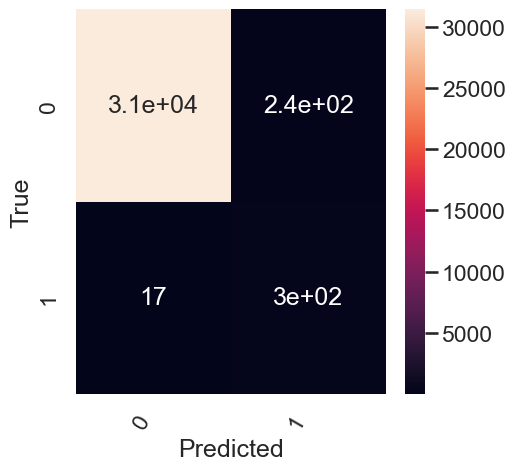

In [ ]:
cbc = CatBoostClassifier(learning_rate=0.07, iterations=3000, class_weights=class_weights, loss_function='Logloss', eval_metric='AUC', max_depth=5, l2_leaf_reg=5)
y_pred, y_probs = classifier_f(cbc, X_train, y_train, X_test)
report(y_test, y_pred)

In [ ]:
roc_auc(cbc, X_test, y_test)

In [ ]:
model = CatBoostClassifier(class_weights=class_weights, loss_function='Logloss', eval_metric='AUC',)


grid = {'learning_rate': [0.08, 0.07, 0.06, 0.05],
        'depth': [3, 4, 5, 6],
        'l2_leaf_reg': [3, 5, 7, 9],
        'iterations': [3000, 3600]}

grid_search_result = model.grid_search(grid,
                                       X=X_train,
                                       y=y_train,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7353219	best: 0.7353219 (0)	total: 53.2ms	remaining: 2m 39s
1:	test: 0.7459574	best: 0.7459574 (1)	total: 105ms	remaining: 2m 37s
2:	test: 0.8169526	best: 0.8169526 (2)	total: 156ms	remaining: 2m 35s
3:	test: 0.8385956	best: 0.8385956 (3)	total: 207ms	remaining: 2m 34s
4:	test: 0.8372241	best: 0.8385956 (3)	total: 256ms	remaining: 2m 33s
5:	test: 0.8448846	best: 0.8448846 (5)	total: 306ms	remaining: 2m 32s
6:	test: 0.8498639	best: 0.8498639 (6)	total: 357ms	remaining: 2m 32s
7:	test: 0.8622717	best: 0.8622717 (7)	total: 405ms	remaining: 2m 31s
8:	test: 0.8738510	best: 0.8738510 (8)	total: 455ms	remaining: 2m 31s
9:	test: 0.8787242	best: 0.8787242 (9)	total: 503ms	remaining: 2m 30s
10:	test: 0.8775647	best: 0.8787242 (9)	total: 561ms	remaining: 2m 32s
11:	test: 0.8825459	best: 0.8825459 (11)	total: 612ms	remaining: 2m 32s
12:	test: 0.8839490	best: 0.8839490 (12)	total: 662ms	remaining: 2m 32s
13:	test: 0.8848219	best: 0.8848219 (13)	total: 715ms	remaining: 2m 32s
14:	test: 0.

114:	test: 0.9785474	best: 0.9785474 (114)	total: 6.16s	remaining: 2m 34s
115:	test: 0.9787509	best: 0.9787509 (115)	total: 6.22s	remaining: 2m 34s
116:	test: 0.9789312	best: 0.9789312 (116)	total: 6.28s	remaining: 2m 34s
117:	test: 0.9791493	best: 0.9791493 (117)	total: 6.33s	remaining: 2m 34s
118:	test: 0.9790821	best: 0.9791493 (117)	total: 6.38s	remaining: 2m 34s
119:	test: 0.9791026	best: 0.9791493 (117)	total: 6.43s	remaining: 2m 34s
120:	test: 0.9794075	best: 0.9794075 (120)	total: 6.49s	remaining: 2m 34s
121:	test: 0.9793825	best: 0.9794075 (120)	total: 6.55s	remaining: 2m 34s
122:	test: 0.9796187	best: 0.9796187 (122)	total: 6.6s	remaining: 2m 34s
123:	test: 0.9797403	best: 0.9797403 (123)	total: 6.66s	remaining: 2m 34s
124:	test: 0.9806123	best: 0.9806123 (124)	total: 6.72s	remaining: 2m 34s
125:	test: 0.9808603	best: 0.9808603 (125)	total: 6.78s	remaining: 2m 34s
126:	test: 0.9811452	best: 0.9811452 (126)	total: 6.84s	remaining: 2m 34s
127:	test: 0.9810636	best: 0.9811452 (1

228:	test: 0.9887518	best: 0.9887518 (228)	total: 13.7s	remaining: 2m 45s
229:	test: 0.9887079	best: 0.9887518 (228)	total: 13.7s	remaining: 2m 45s
230:	test: 0.9887648	best: 0.9887648 (230)	total: 13.8s	remaining: 2m 45s
231:	test: 0.9887382	best: 0.9887648 (230)	total: 13.9s	remaining: 2m 45s
232:	test: 0.9887593	best: 0.9887648 (230)	total: 13.9s	remaining: 2m 45s
233:	test: 0.9888452	best: 0.9888452 (233)	total: 14s	remaining: 2m 45s
234:	test: 0.9888786	best: 0.9888786 (234)	total: 14.1s	remaining: 2m 45s
235:	test: 0.9889278	best: 0.9889278 (235)	total: 14.1s	remaining: 2m 45s
236:	test: 0.9888444	best: 0.9889278 (235)	total: 14.2s	remaining: 2m 45s
237:	test: 0.9888708	best: 0.9889278 (235)	total: 14.2s	remaining: 2m 45s
238:	test: 0.9889635	best: 0.9889635 (238)	total: 14.3s	remaining: 2m 45s
239:	test: 0.9888543	best: 0.9889635 (238)	total: 14.4s	remaining: 2m 45s
240:	test: 0.9889309	best: 0.9889635 (238)	total: 14.4s	remaining: 2m 45s
241:	test: 0.9889853	best: 0.9889853 (24

340:	test: 0.9912094	best: 0.9912094 (340)	total: 20.7s	remaining: 2m 41s
341:	test: 0.9912145	best: 0.9912145 (341)	total: 20.8s	remaining: 2m 41s
342:	test: 0.9912119	best: 0.9912145 (341)	total: 20.9s	remaining: 2m 41s
343:	test: 0.9912536	best: 0.9912536 (343)	total: 20.9s	remaining: 2m 41s
344:	test: 0.9912639	best: 0.9912639 (344)	total: 21s	remaining: 2m 41s
345:	test: 0.9912811	best: 0.9912811 (345)	total: 21s	remaining: 2m 41s
346:	test: 0.9913088	best: 0.9913088 (346)	total: 21.1s	remaining: 2m 41s
347:	test: 0.9912958	best: 0.9913088 (346)	total: 21.2s	remaining: 2m 41s
348:	test: 0.9913484	best: 0.9913484 (348)	total: 21.2s	remaining: 2m 41s
349:	test: 0.9913569	best: 0.9913569 (349)	total: 21.3s	remaining: 2m 41s
350:	test: 0.9913239	best: 0.9913569 (349)	total: 21.3s	remaining: 2m 41s
351:	test: 0.9912940	best: 0.9913569 (349)	total: 21.4s	remaining: 2m 41s
352:	test: 0.9912817	best: 0.9913569 (349)	total: 21.5s	remaining: 2m 40s
353:	test: 0.9912791	best: 0.9913569 (349)

454:	test: 0.9923241	best: 0.9923399 (453)	total: 29s	remaining: 2m 42s
455:	test: 0.9923423	best: 0.9923423 (455)	total: 29s	remaining: 2m 41s
456:	test: 0.9923328	best: 0.9923423 (455)	total: 29.1s	remaining: 2m 41s
457:	test: 0.9923373	best: 0.9923423 (455)	total: 29.2s	remaining: 2m 41s
458:	test: 0.9923604	best: 0.9923604 (458)	total: 29.2s	remaining: 2m 41s
459:	test: 0.9923647	best: 0.9923647 (459)	total: 29.3s	remaining: 2m 41s
460:	test: 0.9923859	best: 0.9923859 (460)	total: 29.3s	remaining: 2m 41s
461:	test: 0.9924063	best: 0.9924063 (461)	total: 29.4s	remaining: 2m 41s
462:	test: 0.9924119	best: 0.9924119 (462)	total: 29.5s	remaining: 2m 41s
463:	test: 0.9924240	best: 0.9924240 (463)	total: 29.5s	remaining: 2m 41s
464:	test: 0.9924425	best: 0.9924425 (464)	total: 29.6s	remaining: 2m 41s
465:	test: 0.9924478	best: 0.9924478 (465)	total: 29.7s	remaining: 2m 41s
466:	test: 0.9924746	best: 0.9924746 (466)	total: 29.8s	remaining: 2m 41s
467:	test: 0.9924880	best: 0.9924880 (467)

569:	test: 0.9925563	best: 0.9926565 (556)	total: 36s	remaining: 2m 33s
570:	test: 0.9925514	best: 0.9926565 (556)	total: 36.1s	remaining: 2m 33s
571:	test: 0.9925543	best: 0.9926565 (556)	total: 36.2s	remaining: 2m 33s
572:	test: 0.9925505	best: 0.9926565 (556)	total: 36.2s	remaining: 2m 33s
573:	test: 0.9925594	best: 0.9926565 (556)	total: 36.3s	remaining: 2m 33s
574:	test: 0.9925575	best: 0.9926565 (556)	total: 36.3s	remaining: 2m 33s
575:	test: 0.9926060	best: 0.9926565 (556)	total: 36.4s	remaining: 2m 33s
576:	test: 0.9926052	best: 0.9926565 (556)	total: 36.5s	remaining: 2m 33s
577:	test: 0.9926064	best: 0.9926565 (556)	total: 36.5s	remaining: 2m 33s
578:	test: 0.9926121	best: 0.9926565 (556)	total: 36.6s	remaining: 2m 33s
579:	test: 0.9926291	best: 0.9926565 (556)	total: 36.7s	remaining: 2m 32s
580:	test: 0.9926303	best: 0.9926565 (556)	total: 36.7s	remaining: 2m 32s
581:	test: 0.9926278	best: 0.9926565 (556)	total: 36.8s	remaining: 2m 32s
582:	test: 0.9926180	best: 0.9926565 (55

681:	test: 0.9929043	best: 0.9929043 (681)	total: 43.5s	remaining: 2m 27s
682:	test: 0.9929110	best: 0.9929110 (682)	total: 43.6s	remaining: 2m 27s
683:	test: 0.9929187	best: 0.9929187 (683)	total: 43.7s	remaining: 2m 27s
684:	test: 0.9929135	best: 0.9929187 (683)	total: 43.7s	remaining: 2m 27s
685:	test: 0.9929201	best: 0.9929201 (685)	total: 43.8s	remaining: 2m 27s
686:	test: 0.9929361	best: 0.9929361 (686)	total: 43.9s	remaining: 2m 27s
687:	test: 0.9929375	best: 0.9929375 (687)	total: 43.9s	remaining: 2m 27s
688:	test: 0.9929232	best: 0.9929375 (687)	total: 44s	remaining: 2m 27s
689:	test: 0.9929383	best: 0.9929383 (689)	total: 44s	remaining: 2m 27s
690:	test: 0.9929395	best: 0.9929395 (690)	total: 44.1s	remaining: 2m 27s
691:	test: 0.9929415	best: 0.9929415 (691)	total: 44.1s	remaining: 2m 27s
692:	test: 0.9929585	best: 0.9929585 (692)	total: 44.2s	remaining: 2m 27s
693:	test: 0.9929608	best: 0.9929608 (693)	total: 44.3s	remaining: 2m 27s
694:	test: 0.9929777	best: 0.9929777 (694)

795:	test: 0.9931087	best: 0.9931087 (795)	total: 50.6s	remaining: 2m 20s
796:	test: 0.9931160	best: 0.9931160 (796)	total: 50.6s	remaining: 2m 19s
797:	test: 0.9931324	best: 0.9931324 (797)	total: 50.7s	remaining: 2m 19s
798:	test: 0.9931296	best: 0.9931324 (797)	total: 50.8s	remaining: 2m 19s
799:	test: 0.9931188	best: 0.9931324 (797)	total: 50.8s	remaining: 2m 19s
800:	test: 0.9931181	best: 0.9931324 (797)	total: 50.9s	remaining: 2m 19s
801:	test: 0.9931211	best: 0.9931324 (797)	total: 50.9s	remaining: 2m 19s
802:	test: 0.9931211	best: 0.9931324 (797)	total: 51s	remaining: 2m 19s
803:	test: 0.9931381	best: 0.9931381 (803)	total: 51.1s	remaining: 2m 19s
804:	test: 0.9931388	best: 0.9931388 (804)	total: 51.1s	remaining: 2m 19s
805:	test: 0.9931438	best: 0.9931438 (805)	total: 51.2s	remaining: 2m 19s
806:	test: 0.9931462	best: 0.9931462 (806)	total: 51.2s	remaining: 2m 19s
807:	test: 0.9931719	best: 0.9931719 (807)	total: 51.3s	remaining: 2m 19s
808:	test: 0.9931750	best: 0.9931750 (80

906:	test: 0.9931809	best: 0.9933183 (892)	total: 57.7s	remaining: 2m 13s
907:	test: 0.9931894	best: 0.9933183 (892)	total: 57.7s	remaining: 2m 13s
908:	test: 0.9931914	best: 0.9933183 (892)	total: 57.8s	remaining: 2m 12s
909:	test: 0.9931893	best: 0.9933183 (892)	total: 57.9s	remaining: 2m 12s
910:	test: 0.9931935	best: 0.9933183 (892)	total: 58s	remaining: 2m 12s
911:	test: 0.9931935	best: 0.9933183 (892)	total: 58s	remaining: 2m 12s
912:	test: 0.9931935	best: 0.9933183 (892)	total: 58.1s	remaining: 2m 12s
913:	test: 0.9931918	best: 0.9933183 (892)	total: 58.2s	remaining: 2m 12s
914:	test: 0.9931895	best: 0.9933183 (892)	total: 58.3s	remaining: 2m 12s
915:	test: 0.9931875	best: 0.9933183 (892)	total: 58.3s	remaining: 2m 12s
916:	test: 0.9931952	best: 0.9933183 (892)	total: 58.4s	remaining: 2m 12s
917:	test: 0.9931955	best: 0.9933183 (892)	total: 58.5s	remaining: 2m 12s
918:	test: 0.9931975	best: 0.9933183 (892)	total: 58.6s	remaining: 2m 12s
919:	test: 0.9932050	best: 0.9933183 (892)

1022:	test: 0.9933017	best: 0.9933183 (892)	total: 1m 5s	remaining: 2m 5s
1023:	test: 0.9933019	best: 0.9933183 (892)	total: 1m 5s	remaining: 2m 5s
1024:	test: 0.9933029	best: 0.9933183 (892)	total: 1m 5s	remaining: 2m 5s
1025:	test: 0.9933031	best: 0.9933183 (892)	total: 1m 5s	remaining: 2m 5s
1026:	test: 0.9933041	best: 0.9933183 (892)	total: 1m 5s	remaining: 2m 5s
1027:	test: 0.9933016	best: 0.9933183 (892)	total: 1m 5s	remaining: 2m 5s
1028:	test: 0.9933031	best: 0.9933183 (892)	total: 1m 5s	remaining: 2m 5s
1029:	test: 0.9933037	best: 0.9933183 (892)	total: 1m 5s	remaining: 2m 5s
1030:	test: 0.9933020	best: 0.9933183 (892)	total: 1m 5s	remaining: 2m 5s
1031:	test: 0.9933022	best: 0.9933183 (892)	total: 1m 5s	remaining: 2m 5s
1032:	test: 0.9933003	best: 0.9933183 (892)	total: 1m 5s	remaining: 2m 4s
1033:	test: 0.9933003	best: 0.9933183 (892)	total: 1m 5s	remaining: 2m 4s
1034:	test: 0.9933007	best: 0.9933183 (892)	total: 1m 5s	remaining: 2m 4s
1035:	test: 0.9933148	best: 0.9933183 

1132:	test: 0.9932803	best: 0.9933432 (1049)	total: 1m 11s	remaining: 1m 58s
1133:	test: 0.9932803	best: 0.9933432 (1049)	total: 1m 11s	remaining: 1m 58s
1134:	test: 0.9932879	best: 0.9933432 (1049)	total: 1m 11s	remaining: 1m 58s
1135:	test: 0.9932911	best: 0.9933432 (1049)	total: 1m 11s	remaining: 1m 58s
1136:	test: 0.9932932	best: 0.9933432 (1049)	total: 1m 12s	remaining: 1m 58s
1137:	test: 0.9933001	best: 0.9933432 (1049)	total: 1m 12s	remaining: 1m 57s
1138:	test: 0.9932972	best: 0.9933432 (1049)	total: 1m 12s	remaining: 1m 57s
1139:	test: 0.9932995	best: 0.9933432 (1049)	total: 1m 12s	remaining: 1m 57s
1140:	test: 0.9932988	best: 0.9933432 (1049)	total: 1m 12s	remaining: 1m 57s
1141:	test: 0.9933019	best: 0.9933432 (1049)	total: 1m 12s	remaining: 1m 57s
1142:	test: 0.9933140	best: 0.9933432 (1049)	total: 1m 12s	remaining: 1m 57s
1143:	test: 0.9933141	best: 0.9933432 (1049)	total: 1m 12s	remaining: 1m 57s
1144:	test: 0.9933148	best: 0.9933432 (1049)	total: 1m 12s	remaining: 1m 57s

1239:	test: 0.9933789	best: 0.9933955 (1228)	total: 1m 19s	remaining: 1m 52s
1240:	test: 0.9933789	best: 0.9933955 (1228)	total: 1m 19s	remaining: 1m 52s
1241:	test: 0.9933790	best: 0.9933955 (1228)	total: 1m 19s	remaining: 1m 52s
1242:	test: 0.9933787	best: 0.9933955 (1228)	total: 1m 19s	remaining: 1m 52s
1243:	test: 0.9933857	best: 0.9933955 (1228)	total: 1m 19s	remaining: 1m 52s
1244:	test: 0.9933857	best: 0.9933955 (1228)	total: 1m 19s	remaining: 1m 51s
1245:	test: 0.9932939	best: 0.9933955 (1228)	total: 1m 19s	remaining: 1m 51s
1246:	test: 0.9932940	best: 0.9933955 (1228)	total: 1m 19s	remaining: 1m 51s
1247:	test: 0.9932948	best: 0.9933955 (1228)	total: 1m 19s	remaining: 1m 51s
1248:	test: 0.9932948	best: 0.9933955 (1228)	total: 1m 19s	remaining: 1m 51s
1249:	test: 0.9932948	best: 0.9933955 (1228)	total: 1m 19s	remaining: 1m 51s
1250:	test: 0.9932943	best: 0.9933955 (1228)	total: 1m 19s	remaining: 1m 51s
1251:	test: 0.9932946	best: 0.9933955 (1228)	total: 1m 19s	remaining: 1m 51s

1348:	test: 0.9932968	best: 0.9933955 (1228)	total: 1m 27s	remaining: 1m 47s
1349:	test: 0.9933102	best: 0.9933955 (1228)	total: 1m 27s	remaining: 1m 47s
1350:	test: 0.9933102	best: 0.9933955 (1228)	total: 1m 27s	remaining: 1m 46s
1351:	test: 0.9932733	best: 0.9933955 (1228)	total: 1m 27s	remaining: 1m 46s
1352:	test: 0.9932727	best: 0.9933955 (1228)	total: 1m 27s	remaining: 1m 46s
1353:	test: 0.9932731	best: 0.9933955 (1228)	total: 1m 27s	remaining: 1m 46s
1354:	test: 0.9932731	best: 0.9933955 (1228)	total: 1m 27s	remaining: 1m 46s
1355:	test: 0.9932755	best: 0.9933955 (1228)	total: 1m 28s	remaining: 1m 46s
1356:	test: 0.9932757	best: 0.9933955 (1228)	total: 1m 28s	remaining: 1m 46s
1357:	test: 0.9932757	best: 0.9933955 (1228)	total: 1m 28s	remaining: 1m 46s
1358:	test: 0.9932753	best: 0.9933955 (1228)	total: 1m 28s	remaining: 1m 46s
1359:	test: 0.9932740	best: 0.9933955 (1228)	total: 1m 28s	remaining: 1m 46s
1360:	test: 0.9932789	best: 0.9933955 (1228)	total: 1m 28s	remaining: 1m 46s

1457:	test: 0.9933055	best: 0.9933955 (1228)	total: 1m 35s	remaining: 1m 41s
1458:	test: 0.9933057	best: 0.9933955 (1228)	total: 1m 35s	remaining: 1m 41s
1459:	test: 0.9933086	best: 0.9933955 (1228)	total: 1m 35s	remaining: 1m 41s
1460:	test: 0.9933087	best: 0.9933955 (1228)	total: 1m 35s	remaining: 1m 41s
1461:	test: 0.9933092	best: 0.9933955 (1228)	total: 1m 36s	remaining: 1m 41s
1462:	test: 0.9933094	best: 0.9933955 (1228)	total: 1m 36s	remaining: 1m 40s
1463:	test: 0.9933151	best: 0.9933955 (1228)	total: 1m 36s	remaining: 1m 40s
1464:	test: 0.9933151	best: 0.9933955 (1228)	total: 1m 36s	remaining: 1m 40s
1465:	test: 0.9933172	best: 0.9933955 (1228)	total: 1m 36s	remaining: 1m 40s
1466:	test: 0.9933629	best: 0.9933955 (1228)	total: 1m 36s	remaining: 1m 40s
1467:	test: 0.9933656	best: 0.9933955 (1228)	total: 1m 36s	remaining: 1m 40s
1468:	test: 0.9933642	best: 0.9933955 (1228)	total: 1m 36s	remaining: 1m 40s
1469:	test: 0.9933601	best: 0.9933955 (1228)	total: 1m 36s	remaining: 1m 40s

1567:	test: 0.9934132	best: 0.9934230 (1547)	total: 1m 42s	remaining: 1m 33s
1568:	test: 0.9934135	best: 0.9934230 (1547)	total: 1m 42s	remaining: 1m 33s
1569:	test: 0.9934231	best: 0.9934231 (1569)	total: 1m 42s	remaining: 1m 33s
1570:	test: 0.9934231	best: 0.9934231 (1569)	total: 1m 43s	remaining: 1m 33s
1571:	test: 0.9934231	best: 0.9934231 (1569)	total: 1m 43s	remaining: 1m 33s
1572:	test: 0.9934237	best: 0.9934237 (1572)	total: 1m 43s	remaining: 1m 33s
1573:	test: 0.9934240	best: 0.9934240 (1573)	total: 1m 43s	remaining: 1m 33s
1574:	test: 0.9934240	best: 0.9934240 (1573)	total: 1m 43s	remaining: 1m 33s
1575:	test: 0.9934241	best: 0.9934241 (1575)	total: 1m 43s	remaining: 1m 33s
1576:	test: 0.9934238	best: 0.9934241 (1575)	total: 1m 43s	remaining: 1m 33s
1577:	test: 0.9934238	best: 0.9934241 (1575)	total: 1m 43s	remaining: 1m 33s
1578:	test: 0.9934238	best: 0.9934241 (1575)	total: 1m 43s	remaining: 1m 33s
1579:	test: 0.9934238	best: 0.9934241 (1575)	total: 1m 43s	remaining: 1m 33s

1675:	test: 0.9934146	best: 0.9934415 (1609)	total: 1m 50s	remaining: 1m 27s
1676:	test: 0.9934146	best: 0.9934415 (1609)	total: 1m 51s	remaining: 1m 27s
1677:	test: 0.9934086	best: 0.9934415 (1609)	total: 1m 51s	remaining: 1m 27s
1678:	test: 0.9934087	best: 0.9934415 (1609)	total: 1m 51s	remaining: 1m 27s
1679:	test: 0.9934089	best: 0.9934415 (1609)	total: 1m 51s	remaining: 1m 27s
1680:	test: 0.9934090	best: 0.9934415 (1609)	total: 1m 51s	remaining: 1m 27s
1681:	test: 0.9934091	best: 0.9934415 (1609)	total: 1m 51s	remaining: 1m 27s
1682:	test: 0.9934091	best: 0.9934415 (1609)	total: 1m 51s	remaining: 1m 27s
1683:	test: 0.9934091	best: 0.9934415 (1609)	total: 1m 51s	remaining: 1m 27s
1684:	test: 0.9934090	best: 0.9934415 (1609)	total: 1m 51s	remaining: 1m 27s
1685:	test: 0.9934090	best: 0.9934415 (1609)	total: 1m 51s	remaining: 1m 27s
1686:	test: 0.9934090	best: 0.9934415 (1609)	total: 1m 51s	remaining: 1m 27s
1687:	test: 0.9934097	best: 0.9934415 (1609)	total: 1m 51s	remaining: 1m 26s

1782:	test: 0.9934054	best: 0.9934415 (1609)	total: 1m 58s	remaining: 1m 20s
1783:	test: 0.9934091	best: 0.9934415 (1609)	total: 1m 58s	remaining: 1m 20s
1784:	test: 0.9934091	best: 0.9934415 (1609)	total: 1m 58s	remaining: 1m 20s
1785:	test: 0.9934091	best: 0.9934415 (1609)	total: 1m 58s	remaining: 1m 20s
1786:	test: 0.9934091	best: 0.9934415 (1609)	total: 1m 58s	remaining: 1m 20s
1787:	test: 0.9934091	best: 0.9934415 (1609)	total: 1m 58s	remaining: 1m 20s
1788:	test: 0.9934091	best: 0.9934415 (1609)	total: 1m 58s	remaining: 1m 20s
1789:	test: 0.9934091	best: 0.9934415 (1609)	total: 1m 59s	remaining: 1m 20s
1790:	test: 0.9934091	best: 0.9934415 (1609)	total: 1m 59s	remaining: 1m 20s
1791:	test: 0.9934058	best: 0.9934415 (1609)	total: 1m 59s	remaining: 1m 20s
1792:	test: 0.9934065	best: 0.9934415 (1609)	total: 1m 59s	remaining: 1m 20s
1793:	test: 0.9934049	best: 0.9934415 (1609)	total: 1m 59s	remaining: 1m 20s
1794:	test: 0.9934016	best: 0.9934415 (1609)	total: 1m 59s	remaining: 1m 20s

1892:	test: 0.9934336	best: 0.9934415 (1609)	total: 2m 6s	remaining: 1m 14s
1893:	test: 0.9934338	best: 0.9934415 (1609)	total: 2m 6s	remaining: 1m 14s
1894:	test: 0.9934361	best: 0.9934415 (1609)	total: 2m 7s	remaining: 1m 14s
1895:	test: 0.9934361	best: 0.9934415 (1609)	total: 2m 7s	remaining: 1m 14s
1896:	test: 0.9934352	best: 0.9934415 (1609)	total: 2m 7s	remaining: 1m 13s
1897:	test: 0.9934352	best: 0.9934415 (1609)	total: 2m 7s	remaining: 1m 13s
1898:	test: 0.9934351	best: 0.9934415 (1609)	total: 2m 7s	remaining: 1m 13s
1899:	test: 0.9934352	best: 0.9934415 (1609)	total: 2m 7s	remaining: 1m 13s
1900:	test: 0.9934352	best: 0.9934415 (1609)	total: 2m 7s	remaining: 1m 13s
1901:	test: 0.9934352	best: 0.9934415 (1609)	total: 2m 7s	remaining: 1m 13s
1902:	test: 0.9934352	best: 0.9934415 (1609)	total: 2m 7s	remaining: 1m 13s
1903:	test: 0.9934355	best: 0.9934415 (1609)	total: 2m 7s	remaining: 1m 13s
1904:	test: 0.9934356	best: 0.9934415 (1609)	total: 2m 7s	remaining: 1m 13s
1905:	test: 

2003:	test: 0.9934871	best: 0.9934924 (1964)	total: 2m 14s	remaining: 1m 6s
2004:	test: 0.9934853	best: 0.9934924 (1964)	total: 2m 14s	remaining: 1m 6s
2005:	test: 0.9934861	best: 0.9934924 (1964)	total: 2m 14s	remaining: 1m 6s
2006:	test: 0.9934861	best: 0.9934924 (1964)	total: 2m 14s	remaining: 1m 6s
2007:	test: 0.9934861	best: 0.9934924 (1964)	total: 2m 15s	remaining: 1m 6s
2008:	test: 0.9934861	best: 0.9934924 (1964)	total: 2m 15s	remaining: 1m 6s
2009:	test: 0.9934804	best: 0.9934924 (1964)	total: 2m 15s	remaining: 1m 6s
2010:	test: 0.9934806	best: 0.9934924 (1964)	total: 2m 15s	remaining: 1m 6s
2011:	test: 0.9934806	best: 0.9934924 (1964)	total: 2m 15s	remaining: 1m 6s
2012:	test: 0.9934806	best: 0.9934924 (1964)	total: 2m 15s	remaining: 1m 6s
2013:	test: 0.9934806	best: 0.9934924 (1964)	total: 2m 15s	remaining: 1m 6s
2014:	test: 0.9935034	best: 0.9935034 (2014)	total: 2m 15s	remaining: 1m 6s
2015:	test: 0.9935050	best: 0.9935050 (2015)	total: 2m 15s	remaining: 1m 6s
2016:	test: 

2114:	test: 0.9935535	best: 0.9935574 (2101)	total: 2m 23s	remaining: 60s
2115:	test: 0.9935535	best: 0.9935574 (2101)	total: 2m 23s	remaining: 59.9s
2116:	test: 0.9935535	best: 0.9935574 (2101)	total: 2m 23s	remaining: 59.8s
2117:	test: 0.9935541	best: 0.9935574 (2101)	total: 2m 23s	remaining: 59.8s
2118:	test: 0.9935540	best: 0.9935574 (2101)	total: 2m 23s	remaining: 59.7s
2119:	test: 0.9935504	best: 0.9935574 (2101)	total: 2m 23s	remaining: 59.7s
2120:	test: 0.9935504	best: 0.9935574 (2101)	total: 2m 23s	remaining: 59.6s
2121:	test: 0.9935283	best: 0.9935574 (2101)	total: 2m 23s	remaining: 59.5s
2122:	test: 0.9935277	best: 0.9935574 (2101)	total: 2m 24s	remaining: 59.5s
2123:	test: 0.9935373	best: 0.9935574 (2101)	total: 2m 24s	remaining: 59.4s
2124:	test: 0.9935071	best: 0.9935574 (2101)	total: 2m 24s	remaining: 59.4s
2125:	test: 0.9935067	best: 0.9935574 (2101)	total: 2m 24s	remaining: 59.3s
2126:	test: 0.9935068	best: 0.9935574 (2101)	total: 2m 24s	remaining: 59.2s
2127:	test: 0.

2225:	test: 0.9934855	best: 0.9935574 (2101)	total: 2m 33s	remaining: 53.3s
2226:	test: 0.9934863	best: 0.9935574 (2101)	total: 2m 33s	remaining: 53.2s
2227:	test: 0.9934863	best: 0.9935574 (2101)	total: 2m 33s	remaining: 53.2s
2228:	test: 0.9934863	best: 0.9935574 (2101)	total: 2m 33s	remaining: 53.1s
2229:	test: 0.9934953	best: 0.9935574 (2101)	total: 2m 33s	remaining: 53.1s
2230:	test: 0.9934953	best: 0.9935574 (2101)	total: 2m 33s	remaining: 53s
2231:	test: 0.9934954	best: 0.9935574 (2101)	total: 2m 33s	remaining: 52.9s
2232:	test: 0.9934909	best: 0.9935574 (2101)	total: 2m 33s	remaining: 52.9s
2233:	test: 0.9934880	best: 0.9935574 (2101)	total: 2m 34s	remaining: 52.8s
2234:	test: 0.9934863	best: 0.9935574 (2101)	total: 2m 34s	remaining: 52.8s
2235:	test: 0.9934863	best: 0.9935574 (2101)	total: 2m 34s	remaining: 52.7s
2236:	test: 0.9934863	best: 0.9935574 (2101)	total: 2m 34s	remaining: 52.6s
2237:	test: 0.9934903	best: 0.9935574 (2101)	total: 2m 34s	remaining: 52.6s
2238:	test: 0.

2336:	test: 0.9934476	best: 0.9935574 (2101)	total: 2m 42s	remaining: 46s
2337:	test: 0.9934473	best: 0.9935574 (2101)	total: 2m 42s	remaining: 46s
2338:	test: 0.9934459	best: 0.9935574 (2101)	total: 2m 42s	remaining: 45.9s
2339:	test: 0.9934449	best: 0.9935574 (2101)	total: 2m 42s	remaining: 45.8s
2340:	test: 0.9934449	best: 0.9935574 (2101)	total: 2m 42s	remaining: 45.8s
2341:	test: 0.9934433	best: 0.9935574 (2101)	total: 2m 42s	remaining: 45.7s
2342:	test: 0.9934433	best: 0.9935574 (2101)	total: 2m 42s	remaining: 45.6s
2343:	test: 0.9934429	best: 0.9935574 (2101)	total: 2m 42s	remaining: 45.6s
2344:	test: 0.9934427	best: 0.9935574 (2101)	total: 2m 42s	remaining: 45.5s
2345:	test: 0.9934114	best: 0.9935574 (2101)	total: 2m 42s	remaining: 45.4s
2346:	test: 0.9934114	best: 0.9935574 (2101)	total: 2m 43s	remaining: 45.4s
2347:	test: 0.9934118	best: 0.9935574 (2101)	total: 2m 43s	remaining: 45.3s
2348:	test: 0.9934120	best: 0.9935574 (2101)	total: 2m 43s	remaining: 45.2s
2349:	test: 0.99

2446:	test: 0.9933265	best: 0.9935574 (2101)	total: 2m 50s	remaining: 38.6s
2447:	test: 0.9933268	best: 0.9935574 (2101)	total: 2m 51s	remaining: 38.6s
2448:	test: 0.9933268	best: 0.9935574 (2101)	total: 2m 51s	remaining: 38.5s
2449:	test: 0.9933268	best: 0.9935574 (2101)	total: 2m 51s	remaining: 38.4s
2450:	test: 0.9933268	best: 0.9935574 (2101)	total: 2m 51s	remaining: 38.4s
2451:	test: 0.9933268	best: 0.9935574 (2101)	total: 2m 51s	remaining: 38.3s
2452:	test: 0.9933283	best: 0.9935574 (2101)	total: 2m 51s	remaining: 38.2s
2453:	test: 0.9933283	best: 0.9935574 (2101)	total: 2m 51s	remaining: 38.2s
2454:	test: 0.9933283	best: 0.9935574 (2101)	total: 2m 51s	remaining: 38.1s
2455:	test: 0.9933285	best: 0.9935574 (2101)	total: 2m 51s	remaining: 38s
2456:	test: 0.9933285	best: 0.9935574 (2101)	total: 2m 51s	remaining: 38s
2457:	test: 0.9933285	best: 0.9935574 (2101)	total: 2m 51s	remaining: 37.9s
2458:	test: 0.9933285	best: 0.9935574 (2101)	total: 2m 51s	remaining: 37.8s
2459:	test: 0.99

2556:	test: 0.9933876	best: 0.9935574 (2101)	total: 2m 58s	remaining: 31s
2557:	test: 0.9933876	best: 0.9935574 (2101)	total: 2m 58s	remaining: 30.9s
2558:	test: 0.9933909	best: 0.9935574 (2101)	total: 2m 59s	remaining: 30.9s
2559:	test: 0.9933908	best: 0.9935574 (2101)	total: 2m 59s	remaining: 30.8s
2560:	test: 0.9933883	best: 0.9935574 (2101)	total: 2m 59s	remaining: 30.7s
2561:	test: 0.9933883	best: 0.9935574 (2101)	total: 2m 59s	remaining: 30.7s
2562:	test: 0.9933883	best: 0.9935574 (2101)	total: 2m 59s	remaining: 30.6s
2563:	test: 0.9933883	best: 0.9935574 (2101)	total: 2m 59s	remaining: 30.5s
2564:	test: 0.9933883	best: 0.9935574 (2101)	total: 2m 59s	remaining: 30.4s
2565:	test: 0.9933839	best: 0.9935574 (2101)	total: 2m 59s	remaining: 30.4s
2566:	test: 0.9933839	best: 0.9935574 (2101)	total: 2m 59s	remaining: 30.3s
2567:	test: 0.9933839	best: 0.9935574 (2101)	total: 2m 59s	remaining: 30.2s
2568:	test: 0.9933839	best: 0.9935574 (2101)	total: 2m 59s	remaining: 30.2s
2569:	test: 0.

2666:	test: 0.9933410	best: 0.9935574 (2101)	total: 3m 6s	remaining: 23.3s
2667:	test: 0.9933410	best: 0.9935574 (2101)	total: 3m 7s	remaining: 23.3s
2668:	test: 0.9933410	best: 0.9935574 (2101)	total: 3m 7s	remaining: 23.2s
2669:	test: 0.9933383	best: 0.9935574 (2101)	total: 3m 7s	remaining: 23.1s
2670:	test: 0.9933383	best: 0.9935574 (2101)	total: 3m 7s	remaining: 23.1s
2671:	test: 0.9933482	best: 0.9935574 (2101)	total: 3m 7s	remaining: 23s
2672:	test: 0.9933482	best: 0.9935574 (2101)	total: 3m 7s	remaining: 22.9s
2673:	test: 0.9933660	best: 0.9935574 (2101)	total: 3m 7s	remaining: 22.9s
2674:	test: 0.9933653	best: 0.9935574 (2101)	total: 3m 7s	remaining: 22.8s
2675:	test: 0.9933655	best: 0.9935574 (2101)	total: 3m 7s	remaining: 22.7s
2676:	test: 0.9933655	best: 0.9935574 (2101)	total: 3m 7s	remaining: 22.7s
2677:	test: 0.9933655	best: 0.9935574 (2101)	total: 3m 7s	remaining: 22.6s
2678:	test: 0.9933655	best: 0.9935574 (2101)	total: 3m 7s	remaining: 22.5s
2679:	test: 0.9933654	best:

2777:	test: 0.9933438	best: 0.9935574 (2101)	total: 3m 14s	remaining: 15.6s
2778:	test: 0.9933438	best: 0.9935574 (2101)	total: 3m 14s	remaining: 15.5s
2779:	test: 0.9933438	best: 0.9935574 (2101)	total: 3m 14s	remaining: 15.4s
2780:	test: 0.9933342	best: 0.9935574 (2101)	total: 3m 15s	remaining: 15.4s
2781:	test: 0.9933343	best: 0.9935574 (2101)	total: 3m 15s	remaining: 15.3s
2782:	test: 0.9933304	best: 0.9935574 (2101)	total: 3m 15s	remaining: 15.2s
2783:	test: 0.9933304	best: 0.9935574 (2101)	total: 3m 15s	remaining: 15.1s
2784:	test: 0.9933304	best: 0.9935574 (2101)	total: 3m 15s	remaining: 15.1s
2785:	test: 0.9933345	best: 0.9935574 (2101)	total: 3m 15s	remaining: 15s
2786:	test: 0.9933345	best: 0.9935574 (2101)	total: 3m 15s	remaining: 14.9s
2787:	test: 0.9933345	best: 0.9935574 (2101)	total: 3m 15s	remaining: 14.9s
2788:	test: 0.9933345	best: 0.9935574 (2101)	total: 3m 15s	remaining: 14.8s
2789:	test: 0.9933346	best: 0.9935574 (2101)	total: 3m 15s	remaining: 14.7s
2790:	test: 0.

2887:	test: 0.9933226	best: 0.9935574 (2101)	total: 3m 22s	remaining: 7.85s
2888:	test: 0.9933226	best: 0.9935574 (2101)	total: 3m 22s	remaining: 7.78s
2889:	test: 0.9933226	best: 0.9935574 (2101)	total: 3m 22s	remaining: 7.71s
2890:	test: 0.9933226	best: 0.9935574 (2101)	total: 3m 22s	remaining: 7.64s
2891:	test: 0.9933226	best: 0.9935574 (2101)	total: 3m 22s	remaining: 7.57s
2892:	test: 0.9933226	best: 0.9935574 (2101)	total: 3m 22s	remaining: 7.5s
2893:	test: 0.9933226	best: 0.9935574 (2101)	total: 3m 22s	remaining: 7.43s
2894:	test: 0.9933226	best: 0.9935574 (2101)	total: 3m 23s	remaining: 7.36s
2895:	test: 0.9933226	best: 0.9935574 (2101)	total: 3m 23s	remaining: 7.29s
2896:	test: 0.9933236	best: 0.9935574 (2101)	total: 3m 23s	remaining: 7.22s
2897:	test: 0.9933272	best: 0.9935574 (2101)	total: 3m 23s	remaining: 7.15s
2898:	test: 0.9933277	best: 0.9935574 (2101)	total: 3m 23s	remaining: 7.08s
2899:	test: 0.9933279	best: 0.9935574 (2101)	total: 3m 23s	remaining: 7.01s
2900:	test: 0

2995:	test: 0.9933654	best: 0.9935574 (2101)	total: 3m 29s	remaining: 280ms
2996:	test: 0.9933658	best: 0.9935574 (2101)	total: 3m 30s	remaining: 210ms
2997:	test: 0.9933658	best: 0.9935574 (2101)	total: 3m 30s	remaining: 140ms
2998:	test: 0.9933658	best: 0.9935574 (2101)	total: 3m 30s	remaining: 70.1ms
2999:	test: 0.9933658	best: 0.9935574 (2101)	total: 3m 30s	remaining: 0us

bestTest = 0.9935574435
bestIteration = 2101

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.9935574	best: 0.9935574 (0)	total: 3m 33s	remaining: 7h 31m 41s
0:	test: 0.7353219	best: 0.7353219 (0)	total: 63.7ms	remaining: 3m 11s
1:	test: 0.7467252	best: 0.7467252 (1)	total: 130ms	remaining: 3m 14s
2:	test: 0.8185303	best: 0.8185303 (2)	total: 191ms	remaining: 3m 11s
3:	test: 0.8391970	best: 0.8391970 (3)	total: 255ms	remaining: 3m 11s
4:	test: 0.8371928	best: 0.8391970 (3)	total: 335ms	remaining: 3m 20s
5:	test: 0.844

106:	test: 0.9771188	best: 0.9771560 (105)	total: 8.18s	remaining: 3m 41s
107:	test: 0.9772610	best: 0.9772610 (107)	total: 8.26s	remaining: 3m 41s
108:	test: 0.9777559	best: 0.9777559 (108)	total: 8.35s	remaining: 3m 41s
109:	test: 0.9777350	best: 0.9777559 (108)	total: 8.45s	remaining: 3m 41s
110:	test: 0.9777052	best: 0.9777559 (108)	total: 8.54s	remaining: 3m 42s
111:	test: 0.9777554	best: 0.9777559 (108)	total: 8.63s	remaining: 3m 42s
112:	test: 0.9782956	best: 0.9782956 (112)	total: 8.73s	remaining: 3m 42s
113:	test: 0.9784476	best: 0.9784476 (113)	total: 8.81s	remaining: 3m 43s
114:	test: 0.9785612	best: 0.9785612 (114)	total: 8.9s	remaining: 3m 43s
115:	test: 0.9787125	best: 0.9787125 (115)	total: 8.98s	remaining: 3m 43s
116:	test: 0.9787689	best: 0.9787689 (116)	total: 9.08s	remaining: 3m 43s
117:	test: 0.9786373	best: 0.9787689 (116)	total: 9.17s	remaining: 3m 43s
118:	test: 0.9788312	best: 0.9788312 (118)	total: 9.25s	remaining: 3m 43s
119:	test: 0.9789048	best: 0.9789048 (1

221:	test: 0.9876199	best: 0.9876263 (219)	total: 16.2s	remaining: 3m 22s
222:	test: 0.9877800	best: 0.9877800 (222)	total: 16.3s	remaining: 3m 22s
223:	test: 0.9878123	best: 0.9878123 (223)	total: 16.3s	remaining: 3m 22s
224:	test: 0.9878367	best: 0.9878367 (224)	total: 16.4s	remaining: 3m 21s
225:	test: 0.9878714	best: 0.9878714 (225)	total: 16.4s	remaining: 3m 21s
226:	test: 0.9879083	best: 0.9879083 (226)	total: 16.5s	remaining: 3m 21s
227:	test: 0.9878711	best: 0.9879083 (226)	total: 16.6s	remaining: 3m 21s
228:	test: 0.9879290	best: 0.9879290 (228)	total: 16.6s	remaining: 3m 21s
229:	test: 0.9878687	best: 0.9879290 (228)	total: 16.7s	remaining: 3m 20s
230:	test: 0.9879159	best: 0.9879290 (228)	total: 16.7s	remaining: 3m 20s
231:	test: 0.9879619	best: 0.9879619 (231)	total: 16.8s	remaining: 3m 20s
232:	test: 0.9879784	best: 0.9879784 (232)	total: 16.9s	remaining: 3m 20s
233:	test: 0.9880011	best: 0.9880011 (233)	total: 16.9s	remaining: 3m 20s
234:	test: 0.9880533	best: 0.9880533 (

333:	test: 0.9903937	best: 0.9903937 (333)	total: 23.9s	remaining: 3m 10s
334:	test: 0.9904363	best: 0.9904363 (334)	total: 24s	remaining: 3m 10s
335:	test: 0.9904262	best: 0.9904363 (334)	total: 24.1s	remaining: 3m 10s
336:	test: 0.9905034	best: 0.9905034 (336)	total: 24.1s	remaining: 3m 10s
337:	test: 0.9905374	best: 0.9905374 (337)	total: 24.2s	remaining: 3m 10s
338:	test: 0.9905539	best: 0.9905539 (338)	total: 24.3s	remaining: 3m 10s
339:	test: 0.9905846	best: 0.9905846 (339)	total: 24.4s	remaining: 3m 10s
340:	test: 0.9905572	best: 0.9905846 (339)	total: 24.5s	remaining: 3m 10s
341:	test: 0.9905973	best: 0.9905973 (341)	total: 24.5s	remaining: 3m 10s
342:	test: 0.9906503	best: 0.9906503 (342)	total: 24.6s	remaining: 3m 10s
343:	test: 0.9906503	best: 0.9906503 (342)	total: 24.7s	remaining: 3m 10s
344:	test: 0.9906652	best: 0.9906652 (344)	total: 24.8s	remaining: 3m 10s
345:	test: 0.9906627	best: 0.9906652 (344)	total: 24.9s	remaining: 3m 10s
346:	test: 0.9907178	best: 0.9907178 (34

446:	test: 0.9916248	best: 0.9916363 (445)	total: 31.8s	remaining: 3m 1s
447:	test: 0.9916404	best: 0.9916404 (447)	total: 31.9s	remaining: 3m 1s
448:	test: 0.9916465	best: 0.9916465 (448)	total: 32s	remaining: 3m 1s
449:	test: 0.9916664	best: 0.9916664 (449)	total: 32s	remaining: 3m 1s
450:	test: 0.9916776	best: 0.9916776 (450)	total: 32.1s	remaining: 3m 1s
451:	test: 0.9916839	best: 0.9916839 (451)	total: 32.1s	remaining: 3m 1s
452:	test: 0.9916869	best: 0.9916869 (452)	total: 32.2s	remaining: 3m 1s
453:	test: 0.9916875	best: 0.9916875 (453)	total: 32.3s	remaining: 3m
454:	test: 0.9916788	best: 0.9916875 (453)	total: 32.3s	remaining: 3m
455:	test: 0.9916775	best: 0.9916875 (453)	total: 32.4s	remaining: 3m
456:	test: 0.9916971	best: 0.9916971 (456)	total: 32.5s	remaining: 3m
457:	test: 0.9915830	best: 0.9916971 (456)	total: 32.5s	remaining: 3m
458:	test: 0.9915930	best: 0.9916971 (456)	total: 32.6s	remaining: 3m
459:	test: 0.9916231	best: 0.9916971 (456)	total: 32.6s	remaining: 3m
460

559:	test: 0.9921672	best: 0.9921697 (557)	total: 39.6s	remaining: 2m 52s
560:	test: 0.9921600	best: 0.9921697 (557)	total: 39.7s	remaining: 2m 52s
561:	test: 0.9921681	best: 0.9921697 (557)	total: 39.8s	remaining: 2m 52s
562:	test: 0.9921720	best: 0.9921720 (562)	total: 39.8s	remaining: 2m 52s
563:	test: 0.9921801	best: 0.9921801 (563)	total: 39.9s	remaining: 2m 52s
564:	test: 0.9921796	best: 0.9921801 (563)	total: 40s	remaining: 2m 52s
565:	test: 0.9922068	best: 0.9922068 (565)	total: 40.1s	remaining: 2m 52s
566:	test: 0.9922124	best: 0.9922124 (566)	total: 40.2s	remaining: 2m 52s
567:	test: 0.9922013	best: 0.9922124 (566)	total: 40.2s	remaining: 2m 52s
568:	test: 0.9922087	best: 0.9922124 (566)	total: 40.3s	remaining: 2m 52s
569:	test: 0.9922020	best: 0.9922124 (566)	total: 40.4s	remaining: 2m 52s
570:	test: 0.9922142	best: 0.9922142 (570)	total: 40.5s	remaining: 2m 52s
571:	test: 0.9922141	best: 0.9922142 (570)	total: 40.6s	remaining: 2m 52s
572:	test: 0.9922298	best: 0.9922298 (57

670:	test: 0.9923930	best: 0.9924059 (666)	total: 47.1s	remaining: 2m 43s
671:	test: 0.9924156	best: 0.9924156 (671)	total: 47.2s	remaining: 2m 43s
672:	test: 0.9924277	best: 0.9924277 (672)	total: 47.3s	remaining: 2m 43s
673:	test: 0.9924175	best: 0.9924277 (672)	total: 47.3s	remaining: 2m 43s
674:	test: 0.9924177	best: 0.9924277 (672)	total: 47.4s	remaining: 2m 43s
675:	test: 0.9924182	best: 0.9924277 (672)	total: 47.5s	remaining: 2m 43s
676:	test: 0.9924125	best: 0.9924277 (672)	total: 47.5s	remaining: 2m 43s
677:	test: 0.9924215	best: 0.9924277 (672)	total: 47.6s	remaining: 2m 43s
678:	test: 0.9924285	best: 0.9924285 (678)	total: 47.7s	remaining: 2m 42s
679:	test: 0.9924405	best: 0.9924405 (679)	total: 47.7s	remaining: 2m 42s
680:	test: 0.9924424	best: 0.9924424 (680)	total: 47.8s	remaining: 2m 42s
681:	test: 0.9924413	best: 0.9924424 (680)	total: 47.9s	remaining: 2m 42s
682:	test: 0.9924421	best: 0.9924424 (680)	total: 48s	remaining: 2m 42s
683:	test: 0.9924382	best: 0.9924424 (68

783:	test: 0.9927763	best: 0.9928173 (782)	total: 55.4s	remaining: 2m 36s
784:	test: 0.9927842	best: 0.9928173 (782)	total: 55.5s	remaining: 2m 36s
785:	test: 0.9927803	best: 0.9928173 (782)	total: 55.6s	remaining: 2m 36s
786:	test: 0.9927755	best: 0.9928173 (782)	total: 55.7s	remaining: 2m 36s
787:	test: 0.9927749	best: 0.9928173 (782)	total: 55.8s	remaining: 2m 36s
788:	test: 0.9927752	best: 0.9928173 (782)	total: 55.9s	remaining: 2m 36s
789:	test: 0.9927697	best: 0.9928173 (782)	total: 56s	remaining: 2m 36s
790:	test: 0.9927708	best: 0.9928173 (782)	total: 56.1s	remaining: 2m 36s
791:	test: 0.9927744	best: 0.9928173 (782)	total: 56.2s	remaining: 2m 36s
792:	test: 0.9927845	best: 0.9928173 (782)	total: 56.3s	remaining: 2m 36s
793:	test: 0.9927854	best: 0.9928173 (782)	total: 56.4s	remaining: 2m 36s
794:	test: 0.9927974	best: 0.9928173 (782)	total: 56.5s	remaining: 2m 36s
795:	test: 0.9927986	best: 0.9928173 (782)	total: 56.6s	remaining: 2m 36s
796:	test: 0.9927998	best: 0.9928173 (78

897:	test: 0.9928804	best: 0.9929430 (845)	total: 1m 3s	remaining: 2m 28s
898:	test: 0.9928578	best: 0.9929430 (845)	total: 1m 3s	remaining: 2m 28s
899:	test: 0.9928555	best: 0.9929430 (845)	total: 1m 3s	remaining: 2m 28s
900:	test: 0.9928558	best: 0.9929430 (845)	total: 1m 3s	remaining: 2m 28s
901:	test: 0.9928610	best: 0.9929430 (845)	total: 1m 3s	remaining: 2m 28s
902:	test: 0.9928646	best: 0.9929430 (845)	total: 1m 3s	remaining: 2m 28s
903:	test: 0.9928656	best: 0.9929430 (845)	total: 1m 4s	remaining: 2m 28s
904:	test: 0.9928656	best: 0.9929430 (845)	total: 1m 4s	remaining: 2m 28s
905:	test: 0.9928704	best: 0.9929430 (845)	total: 1m 4s	remaining: 2m 28s
906:	test: 0.9928750	best: 0.9929430 (845)	total: 1m 4s	remaining: 2m 28s
907:	test: 0.9928785	best: 0.9929430 (845)	total: 1m 4s	remaining: 2m 28s
908:	test: 0.9928780	best: 0.9929430 (845)	total: 1m 4s	remaining: 2m 28s
909:	test: 0.9928857	best: 0.9929430 (845)	total: 1m 4s	remaining: 2m 28s
910:	test: 0.9928943	best: 0.9929430 (

1010:	test: 0.9929945	best: 0.9929961 (1007)	total: 1m 11s	remaining: 2m 21s
1011:	test: 0.9929976	best: 0.9929976 (1011)	total: 1m 11s	remaining: 2m 21s
1012:	test: 0.9929969	best: 0.9929976 (1011)	total: 1m 12s	remaining: 2m 21s
1013:	test: 0.9930008	best: 0.9930008 (1013)	total: 1m 12s	remaining: 2m 21s
1014:	test: 0.9930014	best: 0.9930014 (1014)	total: 1m 12s	remaining: 2m 21s
1015:	test: 0.9930012	best: 0.9930014 (1014)	total: 1m 12s	remaining: 2m 21s
1016:	test: 0.9930002	best: 0.9930014 (1014)	total: 1m 12s	remaining: 2m 21s
1017:	test: 0.9930011	best: 0.9930014 (1014)	total: 1m 12s	remaining: 2m 21s
1018:	test: 0.9930001	best: 0.9930014 (1014)	total: 1m 12s	remaining: 2m 20s
1019:	test: 0.9930003	best: 0.9930014 (1014)	total: 1m 12s	remaining: 2m 20s
1020:	test: 0.9930106	best: 0.9930106 (1020)	total: 1m 12s	remaining: 2m 20s
1021:	test: 0.9930158	best: 0.9930158 (1021)	total: 1m 12s	remaining: 2m 20s
1022:	test: 0.9930171	best: 0.9930171 (1022)	total: 1m 12s	remaining: 2m 20s

1119:	test: 0.9930050	best: 0.9930877 (1078)	total: 1m 19s	remaining: 2m 13s
1120:	test: 0.9930051	best: 0.9930877 (1078)	total: 1m 19s	remaining: 2m 13s
1121:	test: 0.9930030	best: 0.9930877 (1078)	total: 1m 19s	remaining: 2m 13s
1122:	test: 0.9930129	best: 0.9930877 (1078)	total: 1m 19s	remaining: 2m 12s
1123:	test: 0.9930131	best: 0.9930877 (1078)	total: 1m 19s	remaining: 2m 12s
1124:	test: 0.9930131	best: 0.9930877 (1078)	total: 1m 19s	remaining: 2m 12s
1125:	test: 0.9930159	best: 0.9930877 (1078)	total: 1m 19s	remaining: 2m 12s
1126:	test: 0.9930159	best: 0.9930877 (1078)	total: 1m 19s	remaining: 2m 12s
1127:	test: 0.9930078	best: 0.9930877 (1078)	total: 1m 19s	remaining: 2m 12s
1128:	test: 0.9930113	best: 0.9930877 (1078)	total: 1m 19s	remaining: 2m 12s
1129:	test: 0.9930106	best: 0.9930877 (1078)	total: 1m 20s	remaining: 2m 12s
1130:	test: 0.9930108	best: 0.9930877 (1078)	total: 1m 20s	remaining: 2m 12s
1131:	test: 0.9930108	best: 0.9930877 (1078)	total: 1m 20s	remaining: 2m 12s

1229:	test: 0.9930875	best: 0.9930936 (1213)	total: 1m 26s	remaining: 2m 4s
1230:	test: 0.9930877	best: 0.9930936 (1213)	total: 1m 26s	remaining: 2m 4s
1231:	test: 0.9930877	best: 0.9930936 (1213)	total: 1m 26s	remaining: 2m 4s
1232:	test: 0.9930884	best: 0.9930936 (1213)	total: 1m 27s	remaining: 2m 4s
1233:	test: 0.9930884	best: 0.9930936 (1213)	total: 1m 27s	remaining: 2m 4s
1234:	test: 0.9930905	best: 0.9930936 (1213)	total: 1m 27s	remaining: 2m 4s
1235:	test: 0.9930906	best: 0.9930936 (1213)	total: 1m 27s	remaining: 2m 4s
1236:	test: 0.9930906	best: 0.9930936 (1213)	total: 1m 27s	remaining: 2m 4s
1237:	test: 0.9930907	best: 0.9930936 (1213)	total: 1m 27s	remaining: 2m 4s
1238:	test: 0.9930981	best: 0.9930981 (1238)	total: 1m 27s	remaining: 2m 4s
1239:	test: 0.9930980	best: 0.9930981 (1238)	total: 1m 27s	remaining: 2m 4s
1240:	test: 0.9930891	best: 0.9930981 (1238)	total: 1m 27s	remaining: 2m 4s
1241:	test: 0.9930897	best: 0.9930981 (1238)	total: 1m 27s	remaining: 2m 4s
1242:	test: 

1338:	test: 0.9931617	best: 0.9931788 (1312)	total: 1m 34s	remaining: 1m 57s
1339:	test: 0.9931540	best: 0.9931788 (1312)	total: 1m 34s	remaining: 1m 57s
1340:	test: 0.9931812	best: 0.9931812 (1340)	total: 1m 34s	remaining: 1m 57s
1341:	test: 0.9931812	best: 0.9931812 (1340)	total: 1m 34s	remaining: 1m 57s
1342:	test: 0.9931814	best: 0.9931814 (1342)	total: 1m 34s	remaining: 1m 57s
1343:	test: 0.9931817	best: 0.9931817 (1343)	total: 1m 34s	remaining: 1m 56s
1344:	test: 0.9931817	best: 0.9931817 (1343)	total: 1m 34s	remaining: 1m 56s
1345:	test: 0.9931818	best: 0.9931818 (1345)	total: 1m 35s	remaining: 1m 56s
1346:	test: 0.9931826	best: 0.9931826 (1346)	total: 1m 35s	remaining: 1m 56s
1347:	test: 0.9931826	best: 0.9931826 (1346)	total: 1m 35s	remaining: 1m 56s
1348:	test: 0.9931824	best: 0.9931826 (1346)	total: 1m 35s	remaining: 1m 56s
1349:	test: 0.9931814	best: 0.9931826 (1346)	total: 1m 35s	remaining: 1m 56s
1350:	test: 0.9931866	best: 0.9931866 (1350)	total: 1m 35s	remaining: 1m 56s

1445:	test: 0.9932466	best: 0.9932518 (1422)	total: 1m 42s	remaining: 1m 50s
1446:	test: 0.9932594	best: 0.9932594 (1446)	total: 1m 42s	remaining: 1m 50s
1447:	test: 0.9932562	best: 0.9932594 (1446)	total: 1m 42s	remaining: 1m 50s
1448:	test: 0.9932625	best: 0.9932625 (1448)	total: 1m 43s	remaining: 1m 50s
1449:	test: 0.9932594	best: 0.9932625 (1448)	total: 1m 43s	remaining: 1m 50s
1450:	test: 0.9932594	best: 0.9932625 (1448)	total: 1m 43s	remaining: 1m 50s
1451:	test: 0.9932637	best: 0.9932637 (1451)	total: 1m 43s	remaining: 1m 50s
1452:	test: 0.9932640	best: 0.9932640 (1452)	total: 1m 43s	remaining: 1m 50s
1453:	test: 0.9932588	best: 0.9932640 (1452)	total: 1m 43s	remaining: 1m 50s
1454:	test: 0.9932588	best: 0.9932640 (1452)	total: 1m 43s	remaining: 1m 50s
1455:	test: 0.9932598	best: 0.9932640 (1452)	total: 1m 43s	remaining: 1m 49s
1456:	test: 0.9932601	best: 0.9932640 (1452)	total: 1m 43s	remaining: 1m 49s
1457:	test: 0.9932601	best: 0.9932640 (1452)	total: 1m 43s	remaining: 1m 49s

1554:	test: 0.9932996	best: 0.9933096 (1544)	total: 1m 50s	remaining: 1m 43s
1555:	test: 0.9933003	best: 0.9933096 (1544)	total: 1m 50s	remaining: 1m 43s
1556:	test: 0.9932827	best: 0.9933096 (1544)	total: 1m 51s	remaining: 1m 42s
1557:	test: 0.9932827	best: 0.9933096 (1544)	total: 1m 51s	remaining: 1m 42s
1558:	test: 0.9932827	best: 0.9933096 (1544)	total: 1m 51s	remaining: 1m 42s
1559:	test: 0.9932831	best: 0.9933096 (1544)	total: 1m 51s	remaining: 1m 42s
1560:	test: 0.9932831	best: 0.9933096 (1544)	total: 1m 51s	remaining: 1m 42s
1561:	test: 0.9932836	best: 0.9933096 (1544)	total: 1m 51s	remaining: 1m 42s
1562:	test: 0.9932836	best: 0.9933096 (1544)	total: 1m 51s	remaining: 1m 42s
1563:	test: 0.9932836	best: 0.9933096 (1544)	total: 1m 51s	remaining: 1m 42s
1564:	test: 0.9932840	best: 0.9933096 (1544)	total: 1m 51s	remaining: 1m 42s
1565:	test: 0.9932842	best: 0.9933096 (1544)	total: 1m 51s	remaining: 1m 42s
1566:	test: 0.9932843	best: 0.9933096 (1544)	total: 1m 51s	remaining: 1m 42s

1662:	test: 0.9933875	best: 0.9933875 (1662)	total: 1m 58s	remaining: 1m 35s
1663:	test: 0.9933877	best: 0.9933877 (1663)	total: 1m 58s	remaining: 1m 35s
1664:	test: 0.9933878	best: 0.9933878 (1664)	total: 1m 58s	remaining: 1m 35s
1665:	test: 0.9933878	best: 0.9933878 (1664)	total: 1m 58s	remaining: 1m 35s
1666:	test: 0.9933878	best: 0.9933878 (1664)	total: 1m 59s	remaining: 1m 35s
1667:	test: 0.9933878	best: 0.9933878 (1664)	total: 1m 59s	remaining: 1m 35s
1668:	test: 0.9933878	best: 0.9933878 (1664)	total: 1m 59s	remaining: 1m 35s
1669:	test: 0.9933878	best: 0.9933878 (1664)	total: 1m 59s	remaining: 1m 34s
1670:	test: 0.9933872	best: 0.9933878 (1664)	total: 1m 59s	remaining: 1m 34s
1671:	test: 0.9933873	best: 0.9933878 (1664)	total: 1m 59s	remaining: 1m 34s
1672:	test: 0.9933873	best: 0.9933878 (1664)	total: 1m 59s	remaining: 1m 34s
1673:	test: 0.9933914	best: 0.9933914 (1673)	total: 1m 59s	remaining: 1m 34s
1674:	test: 0.9933914	best: 0.9933914 (1673)	total: 1m 59s	remaining: 1m 34s

1773:	test: 0.9934813	best: 0.9934813 (1773)	total: 2m 6s	remaining: 1m 27s
1774:	test: 0.9934816	best: 0.9934816 (1774)	total: 2m 6s	remaining: 1m 27s
1775:	test: 0.9934874	best: 0.9934874 (1775)	total: 2m 6s	remaining: 1m 27s
1776:	test: 0.9934875	best: 0.9934875 (1776)	total: 2m 6s	remaining: 1m 27s
1777:	test: 0.9934876	best: 0.9934876 (1777)	total: 2m 6s	remaining: 1m 27s
1778:	test: 0.9934881	best: 0.9934881 (1778)	total: 2m 6s	remaining: 1m 26s
1779:	test: 0.9934881	best: 0.9934881 (1778)	total: 2m 6s	remaining: 1m 26s
1780:	test: 0.9934886	best: 0.9934886 (1780)	total: 2m 6s	remaining: 1m 26s
1781:	test: 0.9934888	best: 0.9934888 (1781)	total: 2m 6s	remaining: 1m 26s
1782:	test: 0.9934871	best: 0.9934888 (1781)	total: 2m 6s	remaining: 1m 26s
1783:	test: 0.9934873	best: 0.9934888 (1781)	total: 2m 7s	remaining: 1m 26s
1784:	test: 0.9934862	best: 0.9934888 (1781)	total: 2m 7s	remaining: 1m 26s
1785:	test: 0.9934856	best: 0.9934888 (1781)	total: 2m 7s	remaining: 1m 26s
1786:	test: 

1882:	test: 0.9934807	best: 0.9935060 (1826)	total: 2m 13s	remaining: 1m 19s
1883:	test: 0.9934837	best: 0.9935060 (1826)	total: 2m 13s	remaining: 1m 19s
1884:	test: 0.9934837	best: 0.9935060 (1826)	total: 2m 13s	remaining: 1m 19s
1885:	test: 0.9934847	best: 0.9935060 (1826)	total: 2m 13s	remaining: 1m 18s
1886:	test: 0.9934903	best: 0.9935060 (1826)	total: 2m 13s	remaining: 1m 18s
1887:	test: 0.9934907	best: 0.9935060 (1826)	total: 2m 13s	remaining: 1m 18s
1888:	test: 0.9934908	best: 0.9935060 (1826)	total: 2m 13s	remaining: 1m 18s
1889:	test: 0.9934909	best: 0.9935060 (1826)	total: 2m 13s	remaining: 1m 18s
1890:	test: 0.9934909	best: 0.9935060 (1826)	total: 2m 14s	remaining: 1m 18s
1891:	test: 0.9934909	best: 0.9935060 (1826)	total: 2m 14s	remaining: 1m 18s
1892:	test: 0.9934909	best: 0.9935060 (1826)	total: 2m 14s	remaining: 1m 18s
1893:	test: 0.9934915	best: 0.9935060 (1826)	total: 2m 14s	remaining: 1m 18s
1894:	test: 0.9934915	best: 0.9935060 (1826)	total: 2m 14s	remaining: 1m 18s

1992:	test: 0.9934679	best: 0.9935060 (1826)	total: 2m 20s	remaining: 1m 11s
1993:	test: 0.9934679	best: 0.9935060 (1826)	total: 2m 20s	remaining: 1m 11s
1994:	test: 0.9934683	best: 0.9935060 (1826)	total: 2m 21s	remaining: 1m 11s
1995:	test: 0.9934683	best: 0.9935060 (1826)	total: 2m 21s	remaining: 1m 10s
1996:	test: 0.9934634	best: 0.9935060 (1826)	total: 2m 21s	remaining: 1m 10s
1997:	test: 0.9934682	best: 0.9935060 (1826)	total: 2m 21s	remaining: 1m 10s
1998:	test: 0.9934682	best: 0.9935060 (1826)	total: 2m 21s	remaining: 1m 10s
1999:	test: 0.9934503	best: 0.9935060 (1826)	total: 2m 21s	remaining: 1m 10s
2000:	test: 0.9934504	best: 0.9935060 (1826)	total: 2m 21s	remaining: 1m 10s
2001:	test: 0.9934504	best: 0.9935060 (1826)	total: 2m 21s	remaining: 1m 10s
2002:	test: 0.9934505	best: 0.9935060 (1826)	total: 2m 21s	remaining: 1m 10s
2003:	test: 0.9934505	best: 0.9935060 (1826)	total: 2m 21s	remaining: 1m 10s
2004:	test: 0.9934505	best: 0.9935060 (1826)	total: 2m 21s	remaining: 1m 10s

2101:	test: 0.9934745	best: 0.9935060 (1826)	total: 2m 27s	remaining: 1m 3s
2102:	test: 0.9934741	best: 0.9935060 (1826)	total: 2m 27s	remaining: 1m 3s
2103:	test: 0.9934730	best: 0.9935060 (1826)	total: 2m 27s	remaining: 1m 2s
2104:	test: 0.9934730	best: 0.9935060 (1826)	total: 2m 27s	remaining: 1m 2s
2105:	test: 0.9934730	best: 0.9935060 (1826)	total: 2m 28s	remaining: 1m 2s
2106:	test: 0.9934727	best: 0.9935060 (1826)	total: 2m 28s	remaining: 1m 2s
2107:	test: 0.9934728	best: 0.9935060 (1826)	total: 2m 28s	remaining: 1m 2s
2108:	test: 0.9934728	best: 0.9935060 (1826)	total: 2m 28s	remaining: 1m 2s
2109:	test: 0.9934727	best: 0.9935060 (1826)	total: 2m 28s	remaining: 1m 2s
2110:	test: 0.9934425	best: 0.9935060 (1826)	total: 2m 28s	remaining: 1m 2s
2111:	test: 0.9933975	best: 0.9935060 (1826)	total: 2m 28s	remaining: 1m 2s
2112:	test: 0.9933978	best: 0.9935060 (1826)	total: 2m 28s	remaining: 1m 2s
2113:	test: 0.9934022	best: 0.9935060 (1826)	total: 2m 28s	remaining: 1m 2s
2114:	test: 

2213:	test: 0.9934447	best: 0.9935060 (1826)	total: 2m 35s	remaining: 55.2s
2214:	test: 0.9934428	best: 0.9935060 (1826)	total: 2m 35s	remaining: 55.1s
2215:	test: 0.9934332	best: 0.9935060 (1826)	total: 2m 35s	remaining: 55s
2216:	test: 0.9934332	best: 0.9935060 (1826)	total: 2m 35s	remaining: 55s
2217:	test: 0.9934332	best: 0.9935060 (1826)	total: 2m 35s	remaining: 54.9s
2218:	test: 0.9934332	best: 0.9935060 (1826)	total: 2m 35s	remaining: 54.8s
2219:	test: 0.9934358	best: 0.9935060 (1826)	total: 2m 35s	remaining: 54.7s
2220:	test: 0.9934358	best: 0.9935060 (1826)	total: 2m 35s	remaining: 54.7s
2221:	test: 0.9934355	best: 0.9935060 (1826)	total: 2m 35s	remaining: 54.6s
2222:	test: 0.9934364	best: 0.9935060 (1826)	total: 2m 35s	remaining: 54.5s
2223:	test: 0.9934364	best: 0.9935060 (1826)	total: 2m 36s	remaining: 54.4s
2224:	test: 0.9934365	best: 0.9935060 (1826)	total: 2m 36s	remaining: 54.4s
2225:	test: 0.9934366	best: 0.9935060 (1826)	total: 2m 36s	remaining: 54.3s
2226:	test: 0.99

2325:	test: 0.9933407	best: 0.9935060 (1826)	total: 2m 42s	remaining: 47.1s
2326:	test: 0.9933407	best: 0.9935060 (1826)	total: 2m 42s	remaining: 47s
2327:	test: 0.9933407	best: 0.9935060 (1826)	total: 2m 42s	remaining: 47s
2328:	test: 0.9933409	best: 0.9935060 (1826)	total: 2m 42s	remaining: 46.9s
2329:	test: 0.9933409	best: 0.9935060 (1826)	total: 2m 42s	remaining: 46.8s
2330:	test: 0.9933419	best: 0.9935060 (1826)	total: 2m 42s	remaining: 46.8s
2331:	test: 0.9933419	best: 0.9935060 (1826)	total: 2m 42s	remaining: 46.7s
2332:	test: 0.9933419	best: 0.9935060 (1826)	total: 2m 43s	remaining: 46.6s
2333:	test: 0.9933444	best: 0.9935060 (1826)	total: 2m 43s	remaining: 46.5s
2334:	test: 0.9933444	best: 0.9935060 (1826)	total: 2m 43s	remaining: 46.5s
2335:	test: 0.9933444	best: 0.9935060 (1826)	total: 2m 43s	remaining: 46.4s
2336:	test: 0.9933444	best: 0.9935060 (1826)	total: 2m 43s	remaining: 46.3s
2337:	test: 0.9933485	best: 0.9935060 (1826)	total: 2m 43s	remaining: 46.2s
2338:	test: 0.99

2434:	test: 0.9932664	best: 0.9935060 (1826)	total: 2m 49s	remaining: 39.4s
2435:	test: 0.9932664	best: 0.9935060 (1826)	total: 2m 50s	remaining: 39.4s
2436:	test: 0.9932664	best: 0.9935060 (1826)	total: 2m 50s	remaining: 39.3s
2437:	test: 0.9932648	best: 0.9935060 (1826)	total: 2m 50s	remaining: 39.2s
2438:	test: 0.9932631	best: 0.9935060 (1826)	total: 2m 50s	remaining: 39.2s
2439:	test: 0.9932632	best: 0.9935060 (1826)	total: 2m 50s	remaining: 39.1s
2440:	test: 0.9932652	best: 0.9935060 (1826)	total: 2m 50s	remaining: 39s
2441:	test: 0.9932652	best: 0.9935060 (1826)	total: 2m 50s	remaining: 38.9s
2442:	test: 0.9932652	best: 0.9935060 (1826)	total: 2m 50s	remaining: 38.9s
2443:	test: 0.9932652	best: 0.9935060 (1826)	total: 2m 50s	remaining: 38.8s
2444:	test: 0.9932652	best: 0.9935060 (1826)	total: 2m 50s	remaining: 38.7s
2445:	test: 0.9932652	best: 0.9935060 (1826)	total: 2m 50s	remaining: 38.7s
2446:	test: 0.9932652	best: 0.9935060 (1826)	total: 2m 50s	remaining: 38.6s
2447:	test: 0.

2544:	test: 0.9932414	best: 0.9935060 (1826)	total: 2m 58s	remaining: 31.8s
2545:	test: 0.9932415	best: 0.9935060 (1826)	total: 2m 58s	remaining: 31.8s
2546:	test: 0.9932415	best: 0.9935060 (1826)	total: 2m 58s	remaining: 31.7s
2547:	test: 0.9932415	best: 0.9935060 (1826)	total: 2m 58s	remaining: 31.6s
2548:	test: 0.9932412	best: 0.9935060 (1826)	total: 2m 58s	remaining: 31.5s
2549:	test: 0.9932412	best: 0.9935060 (1826)	total: 2m 58s	remaining: 31.5s
2550:	test: 0.9932413	best: 0.9935060 (1826)	total: 2m 58s	remaining: 31.4s
2551:	test: 0.9932438	best: 0.9935060 (1826)	total: 2m 58s	remaining: 31.3s
2552:	test: 0.9932440	best: 0.9935060 (1826)	total: 2m 58s	remaining: 31.3s
2553:	test: 0.9932444	best: 0.9935060 (1826)	total: 2m 58s	remaining: 31.2s
2554:	test: 0.9932444	best: 0.9935060 (1826)	total: 2m 58s	remaining: 31.1s
2555:	test: 0.9932486	best: 0.9935060 (1826)	total: 2m 58s	remaining: 31.1s
2556:	test: 0.9932460	best: 0.9935060 (1826)	total: 2m 58s	remaining: 31s
2557:	test: 0.

2656:	test: 0.9931213	best: 0.9935060 (1826)	total: 3m 5s	remaining: 24s
2657:	test: 0.9931236	best: 0.9935060 (1826)	total: 3m 6s	remaining: 23.9s
2658:	test: 0.9931236	best: 0.9935060 (1826)	total: 3m 6s	remaining: 23.9s
2659:	test: 0.9931236	best: 0.9935060 (1826)	total: 3m 6s	remaining: 23.8s
2660:	test: 0.9931236	best: 0.9935060 (1826)	total: 3m 6s	remaining: 23.7s
2661:	test: 0.9931237	best: 0.9935060 (1826)	total: 3m 6s	remaining: 23.6s
2662:	test: 0.9931237	best: 0.9935060 (1826)	total: 3m 6s	remaining: 23.6s
2663:	test: 0.9931237	best: 0.9935060 (1826)	total: 3m 6s	remaining: 23.5s
2664:	test: 0.9931237	best: 0.9935060 (1826)	total: 3m 6s	remaining: 23.4s
2665:	test: 0.9931219	best: 0.9935060 (1826)	total: 3m 6s	remaining: 23.4s
2666:	test: 0.9931219	best: 0.9935060 (1826)	total: 3m 6s	remaining: 23.3s
2667:	test: 0.9931219	best: 0.9935060 (1826)	total: 3m 6s	remaining: 23.2s
2668:	test: 0.9931219	best: 0.9935060 (1826)	total: 3m 6s	remaining: 23.2s
2669:	test: 0.9931205	best:

2765:	test: 0.9931118	best: 0.9935060 (1826)	total: 3m 13s	remaining: 16.4s
2766:	test: 0.9931118	best: 0.9935060 (1826)	total: 3m 13s	remaining: 16.3s
2767:	test: 0.9931118	best: 0.9935060 (1826)	total: 3m 13s	remaining: 16.2s
2768:	test: 0.9931118	best: 0.9935060 (1826)	total: 3m 13s	remaining: 16.2s
2769:	test: 0.9931118	best: 0.9935060 (1826)	total: 3m 13s	remaining: 16.1s
2770:	test: 0.9931114	best: 0.9935060 (1826)	total: 3m 14s	remaining: 16s
2771:	test: 0.9931115	best: 0.9935060 (1826)	total: 3m 14s	remaining: 16s
2772:	test: 0.9931194	best: 0.9935060 (1826)	total: 3m 14s	remaining: 15.9s
2773:	test: 0.9931225	best: 0.9935060 (1826)	total: 3m 14s	remaining: 15.8s
2774:	test: 0.9931225	best: 0.9935060 (1826)	total: 3m 14s	remaining: 15.8s
2775:	test: 0.9931225	best: 0.9935060 (1826)	total: 3m 14s	remaining: 15.7s
2776:	test: 0.9931395	best: 0.9935060 (1826)	total: 3m 14s	remaining: 15.6s
2777:	test: 0.9931395	best: 0.9935060 (1826)	total: 3m 14s	remaining: 15.5s
2778:	test: 0.99

2874:	test: 0.9932188	best: 0.9935060 (1826)	total: 3m 23s	remaining: 8.87s
2875:	test: 0.9932188	best: 0.9935060 (1826)	total: 3m 24s	remaining: 8.8s
2876:	test: 0.9932188	best: 0.9935060 (1826)	total: 3m 24s	remaining: 8.73s
2877:	test: 0.9932188	best: 0.9935060 (1826)	total: 3m 24s	remaining: 8.66s
2878:	test: 0.9932188	best: 0.9935060 (1826)	total: 3m 24s	remaining: 8.59s
2879:	test: 0.9932189	best: 0.9935060 (1826)	total: 3m 24s	remaining: 8.52s
2880:	test: 0.9932189	best: 0.9935060 (1826)	total: 3m 24s	remaining: 8.45s
2881:	test: 0.9932189	best: 0.9935060 (1826)	total: 3m 24s	remaining: 8.38s
2882:	test: 0.9932189	best: 0.9935060 (1826)	total: 3m 24s	remaining: 8.31s
2883:	test: 0.9932189	best: 0.9935060 (1826)	total: 3m 24s	remaining: 8.24s
2884:	test: 0.9932189	best: 0.9935060 (1826)	total: 3m 24s	remaining: 8.17s
2885:	test: 0.9932189	best: 0.9935060 (1826)	total: 3m 25s	remaining: 8.1s
2886:	test: 0.9932189	best: 0.9935060 (1826)	total: 3m 25s	remaining: 8.03s
2887:	test: 0.

2982:	test: 0.9930887	best: 0.9935060 (1826)	total: 3m 31s	remaining: 1.21s
2983:	test: 0.9930887	best: 0.9935060 (1826)	total: 3m 31s	remaining: 1.13s
2984:	test: 0.9930890	best: 0.9935060 (1826)	total: 3m 31s	remaining: 1.06s
2985:	test: 0.9930890	best: 0.9935060 (1826)	total: 3m 31s	remaining: 992ms
2986:	test: 0.9930890	best: 0.9935060 (1826)	total: 3m 31s	remaining: 922ms
2987:	test: 0.9930891	best: 0.9935060 (1826)	total: 3m 31s	remaining: 851ms
2988:	test: 0.9930891	best: 0.9935060 (1826)	total: 3m 31s	remaining: 780ms
2989:	test: 0.9930891	best: 0.9935060 (1826)	total: 3m 31s	remaining: 709ms
2990:	test: 0.9930891	best: 0.9935060 (1826)	total: 3m 32s	remaining: 638ms
2991:	test: 0.9930891	best: 0.9935060 (1826)	total: 3m 32s	remaining: 567ms
2992:	test: 0.9930891	best: 0.9935060 (1826)	total: 3m 32s	remaining: 496ms
2993:	test: 0.9930892	best: 0.9935060 (1826)	total: 3m 32s	remaining: 425ms
2994:	test: 0.9930892	best: 0.9935060 (1826)	total: 3m 32s	remaining: 354ms
2995:	test: 

94:	test: 0.9684613	best: 0.9685209 (92)	total: 7.06s	remaining: 3m 35s
95:	test: 0.9684531	best: 0.9685209 (92)	total: 7.12s	remaining: 3m 35s
96:	test: 0.9690119	best: 0.9690119 (96)	total: 7.18s	remaining: 3m 34s
97:	test: 0.9695107	best: 0.9695107 (97)	total: 7.25s	remaining: 3m 34s
98:	test: 0.9695107	best: 0.9695107 (98)	total: 7.31s	remaining: 3m 34s
99:	test: 0.9694698	best: 0.9695107 (98)	total: 7.37s	remaining: 3m 33s
100:	test: 0.9696030	best: 0.9696030 (100)	total: 7.43s	remaining: 3m 33s
101:	test: 0.9698730	best: 0.9698730 (101)	total: 7.49s	remaining: 3m 32s
102:	test: 0.9699900	best: 0.9699900 (102)	total: 7.56s	remaining: 3m 32s
103:	test: 0.9702025	best: 0.9702025 (103)	total: 7.62s	remaining: 3m 32s
104:	test: 0.9704771	best: 0.9704771 (104)	total: 7.68s	remaining: 3m 31s
105:	test: 0.9706038	best: 0.9706038 (105)	total: 7.74s	remaining: 3m 31s
106:	test: 0.9709298	best: 0.9709298 (106)	total: 7.8s	remaining: 3m 30s
107:	test: 0.9709084	best: 0.9709298 (106)	total: 7

206:	test: 0.9827643	best: 0.9828389 (205)	total: 14.3s	remaining: 3m 12s
207:	test: 0.9828040	best: 0.9828389 (205)	total: 14.3s	remaining: 3m 12s
208:	test: 0.9828413	best: 0.9828413 (208)	total: 14.4s	remaining: 3m 12s
209:	test: 0.9826092	best: 0.9828413 (208)	total: 14.4s	remaining: 3m 11s
210:	test: 0.9827592	best: 0.9828413 (208)	total: 14.5s	remaining: 3m 11s
211:	test: 0.9827612	best: 0.9828413 (208)	total: 14.6s	remaining: 3m 11s
212:	test: 0.9829267	best: 0.9829267 (212)	total: 14.6s	remaining: 3m 11s
213:	test: 0.9830710	best: 0.9830710 (213)	total: 14.7s	remaining: 3m 11s
214:	test: 0.9829624	best: 0.9830710 (213)	total: 14.8s	remaining: 3m 11s
215:	test: 0.9830527	best: 0.9830710 (213)	total: 14.8s	remaining: 3m 11s
216:	test: 0.9835893	best: 0.9835893 (216)	total: 14.9s	remaining: 3m 10s
217:	test: 0.9834980	best: 0.9835893 (216)	total: 14.9s	remaining: 3m 10s
218:	test: 0.9838350	best: 0.9838350 (218)	total: 15s	remaining: 3m 10s
219:	test: 0.9837062	best: 0.9838350 (21

319:	test: 0.9885547	best: 0.9885599 (318)	total: 22.6s	remaining: 3m 9s
320:	test: 0.9885948	best: 0.9885948 (320)	total: 22.7s	remaining: 3m 9s
321:	test: 0.9886394	best: 0.9886394 (321)	total: 22.7s	remaining: 3m 9s
322:	test: 0.9885925	best: 0.9886394 (321)	total: 22.8s	remaining: 3m 9s
323:	test: 0.9886966	best: 0.9886966 (323)	total: 22.9s	remaining: 3m 9s
324:	test: 0.9887235	best: 0.9887235 (324)	total: 23s	remaining: 3m 9s
325:	test: 0.9887064	best: 0.9887235 (324)	total: 23.1s	remaining: 3m 9s
326:	test: 0.9886990	best: 0.9887235 (324)	total: 23.1s	remaining: 3m 9s
327:	test: 0.9886919	best: 0.9887235 (324)	total: 23.2s	remaining: 3m 8s
328:	test: 0.9887273	best: 0.9887273 (328)	total: 23.3s	remaining: 3m 8s
329:	test: 0.9888130	best: 0.9888130 (329)	total: 23.3s	remaining: 3m 8s
330:	test: 0.9888315	best: 0.9888315 (330)	total: 23.4s	remaining: 3m 8s
331:	test: 0.9887512	best: 0.9888315 (330)	total: 23.4s	remaining: 3m 8s
332:	test: 0.9886880	best: 0.9888315 (330)	total: 23.

434:	test: 0.9902385	best: 0.9903312 (425)	total: 30.2s	remaining: 2m 57s
435:	test: 0.9901906	best: 0.9903312 (425)	total: 30.2s	remaining: 2m 57s
436:	test: 0.9901973	best: 0.9903312 (425)	total: 30.3s	remaining: 2m 57s
437:	test: 0.9901085	best: 0.9903312 (425)	total: 30.3s	remaining: 2m 57s
438:	test: 0.9901369	best: 0.9903312 (425)	total: 30.4s	remaining: 2m 57s
439:	test: 0.9901621	best: 0.9903312 (425)	total: 30.5s	remaining: 2m 57s
440:	test: 0.9901648	best: 0.9903312 (425)	total: 30.5s	remaining: 2m 57s
441:	test: 0.9901762	best: 0.9903312 (425)	total: 30.6s	remaining: 2m 57s
442:	test: 0.9902303	best: 0.9903312 (425)	total: 30.7s	remaining: 2m 56s
443:	test: 0.9902324	best: 0.9903312 (425)	total: 30.7s	remaining: 2m 56s
444:	test: 0.9902115	best: 0.9903312 (425)	total: 30.8s	remaining: 2m 56s
445:	test: 0.9901947	best: 0.9903312 (425)	total: 30.8s	remaining: 2m 56s
446:	test: 0.9902247	best: 0.9903312 (425)	total: 30.9s	remaining: 2m 56s
447:	test: 0.9902211	best: 0.9903312 (

546:	test: 0.9909043	best: 0.9909043 (546)	total: 38.3s	remaining: 2m 51s
547:	test: 0.9908960	best: 0.9909043 (546)	total: 38.4s	remaining: 2m 51s
548:	test: 0.9908904	best: 0.9909043 (546)	total: 38.5s	remaining: 2m 51s
549:	test: 0.9909064	best: 0.9909064 (549)	total: 38.5s	remaining: 2m 51s
550:	test: 0.9908949	best: 0.9909064 (549)	total: 38.6s	remaining: 2m 51s
551:	test: 0.9909135	best: 0.9909135 (551)	total: 38.6s	remaining: 2m 51s
552:	test: 0.9909057	best: 0.9909135 (551)	total: 38.7s	remaining: 2m 51s
553:	test: 0.9909065	best: 0.9909135 (551)	total: 38.8s	remaining: 2m 51s
554:	test: 0.9909052	best: 0.9909135 (551)	total: 38.8s	remaining: 2m 51s
555:	test: 0.9909289	best: 0.9909289 (555)	total: 38.9s	remaining: 2m 51s
556:	test: 0.9909369	best: 0.9909369 (556)	total: 39s	remaining: 2m 50s
557:	test: 0.9910147	best: 0.9910147 (557)	total: 39s	remaining: 2m 50s
558:	test: 0.9910188	best: 0.9910188 (558)	total: 39.1s	remaining: 2m 50s
559:	test: 0.9910279	best: 0.9910279 (559)

660:	test: 0.9916130	best: 0.9916573 (659)	total: 45.8s	remaining: 2m 42s
661:	test: 0.9916285	best: 0.9916573 (659)	total: 45.9s	remaining: 2m 42s
662:	test: 0.9916278	best: 0.9916573 (659)	total: 45.9s	remaining: 2m 41s
663:	test: 0.9916388	best: 0.9916573 (659)	total: 46s	remaining: 2m 41s
664:	test: 0.9916409	best: 0.9916573 (659)	total: 46.1s	remaining: 2m 41s
665:	test: 0.9916433	best: 0.9916573 (659)	total: 46.2s	remaining: 2m 41s
666:	test: 0.9916375	best: 0.9916573 (659)	total: 46.2s	remaining: 2m 41s
667:	test: 0.9916656	best: 0.9916656 (667)	total: 46.3s	remaining: 2m 41s
668:	test: 0.9916995	best: 0.9916995 (668)	total: 46.4s	remaining: 2m 41s
669:	test: 0.9917016	best: 0.9917016 (669)	total: 46.4s	remaining: 2m 41s
670:	test: 0.9917353	best: 0.9917353 (670)	total: 46.5s	remaining: 2m 41s
671:	test: 0.9917629	best: 0.9917629 (671)	total: 46.6s	remaining: 2m 41s
672:	test: 0.9917734	best: 0.9917734 (672)	total: 46.6s	remaining: 2m 41s
673:	test: 0.9917722	best: 0.9917734 (67

774:	test: 0.9921729	best: 0.9921729 (774)	total: 54.2s	remaining: 2m 35s
775:	test: 0.9921712	best: 0.9921729 (774)	total: 54.2s	remaining: 2m 35s
776:	test: 0.9921725	best: 0.9921729 (774)	total: 54.3s	remaining: 2m 35s
777:	test: 0.9921749	best: 0.9921749 (777)	total: 54.4s	remaining: 2m 35s
778:	test: 0.9921692	best: 0.9921749 (777)	total: 54.4s	remaining: 2m 35s
779:	test: 0.9921731	best: 0.9921749 (777)	total: 54.5s	remaining: 2m 35s
780:	test: 0.9921783	best: 0.9921783 (780)	total: 54.6s	remaining: 2m 35s
781:	test: 0.9921801	best: 0.9921801 (781)	total: 54.6s	remaining: 2m 34s
782:	test: 0.9921796	best: 0.9921801 (781)	total: 54.7s	remaining: 2m 34s
783:	test: 0.9921815	best: 0.9921815 (783)	total: 54.8s	remaining: 2m 34s
784:	test: 0.9921958	best: 0.9921958 (784)	total: 54.8s	remaining: 2m 34s
785:	test: 0.9921983	best: 0.9921983 (785)	total: 54.9s	remaining: 2m 34s
786:	test: 0.9922014	best: 0.9922014 (786)	total: 55s	remaining: 2m 34s
787:	test: 0.9921996	best: 0.9922014 (78

886:	test: 0.9920702	best: 0.9922345 (880)	total: 1m 1s	remaining: 2m 26s
887:	test: 0.9920689	best: 0.9922345 (880)	total: 1m 1s	remaining: 2m 26s
888:	test: 0.9920704	best: 0.9922345 (880)	total: 1m 1s	remaining: 2m 26s
889:	test: 0.9920704	best: 0.9922345 (880)	total: 1m 1s	remaining: 2m 26s
890:	test: 0.9920700	best: 0.9922345 (880)	total: 1m 1s	remaining: 2m 26s
891:	test: 0.9920607	best: 0.9922345 (880)	total: 1m 1s	remaining: 2m 25s
892:	test: 0.9920589	best: 0.9922345 (880)	total: 1m 1s	remaining: 2m 25s
893:	test: 0.9920608	best: 0.9922345 (880)	total: 1m 1s	remaining: 2m 25s
894:	test: 0.9920612	best: 0.9922345 (880)	total: 1m 1s	remaining: 2m 25s
895:	test: 0.9920588	best: 0.9922345 (880)	total: 1m 1s	remaining: 2m 25s
896:	test: 0.9920576	best: 0.9922345 (880)	total: 1m 2s	remaining: 2m 25s
897:	test: 0.9920614	best: 0.9922345 (880)	total: 1m 2s	remaining: 2m 25s
898:	test: 0.9920798	best: 0.9922345 (880)	total: 1m 2s	remaining: 2m 25s
899:	test: 0.9920836	best: 0.9922345 (

999:	test: 0.9922952	best: 0.9923259 (974)	total: 1m 9s	remaining: 2m 18s
1000:	test: 0.9922952	best: 0.9923259 (974)	total: 1m 9s	remaining: 2m 18s
1001:	test: 0.9922955	best: 0.9923259 (974)	total: 1m 9s	remaining: 2m 18s
1002:	test: 0.9922944	best: 0.9923259 (974)	total: 1m 9s	remaining: 2m 18s
1003:	test: 0.9923009	best: 0.9923259 (974)	total: 1m 9s	remaining: 2m 18s
1004:	test: 0.9923153	best: 0.9923259 (974)	total: 1m 9s	remaining: 2m 18s
1005:	test: 0.9923120	best: 0.9923259 (974)	total: 1m 9s	remaining: 2m 18s
1006:	test: 0.9923204	best: 0.9923259 (974)	total: 1m 9s	remaining: 2m 18s
1007:	test: 0.9923221	best: 0.9923259 (974)	total: 1m 9s	remaining: 2m 18s
1008:	test: 0.9923221	best: 0.9923259 (974)	total: 1m 9s	remaining: 2m 18s
1009:	test: 0.9923235	best: 0.9923259 (974)	total: 1m 10s	remaining: 2m 17s
1010:	test: 0.9923394	best: 0.9923394 (1010)	total: 1m 10s	remaining: 2m 17s
1011:	test: 0.9923400	best: 0.9923400 (1011)	total: 1m 10s	remaining: 2m 17s
1012:	test: 0.9923549

1107:	test: 0.9926230	best: 0.9926230 (1107)	total: 1m 16s	remaining: 2m 10s
1108:	test: 0.9926230	best: 0.9926230 (1107)	total: 1m 16s	remaining: 2m 10s
1109:	test: 0.9926244	best: 0.9926244 (1109)	total: 1m 16s	remaining: 2m 10s
1110:	test: 0.9926257	best: 0.9926257 (1110)	total: 1m 16s	remaining: 2m 10s
1111:	test: 0.9926257	best: 0.9926257 (1110)	total: 1m 16s	remaining: 2m 10s
1112:	test: 0.9926259	best: 0.9926259 (1112)	total: 1m 16s	remaining: 2m 9s
1113:	test: 0.9926113	best: 0.9926259 (1112)	total: 1m 16s	remaining: 2m 9s
1114:	test: 0.9926166	best: 0.9926259 (1112)	total: 1m 16s	remaining: 2m 9s
1115:	test: 0.9926131	best: 0.9926259 (1112)	total: 1m 16s	remaining: 2m 9s
1116:	test: 0.9926160	best: 0.9926259 (1112)	total: 1m 16s	remaining: 2m 9s
1117:	test: 0.9926174	best: 0.9926259 (1112)	total: 1m 16s	remaining: 2m 9s
1118:	test: 0.9926217	best: 0.9926259 (1112)	total: 1m 17s	remaining: 2m 9s
1119:	test: 0.9926198	best: 0.9926259 (1112)	total: 1m 17s	remaining: 2m 9s
1120:	t

1216:	test: 0.9924590	best: 0.9926508 (1122)	total: 1m 24s	remaining: 2m 4s
1217:	test: 0.9924595	best: 0.9926508 (1122)	total: 1m 24s	remaining: 2m 4s
1218:	test: 0.9924613	best: 0.9926508 (1122)	total: 1m 24s	remaining: 2m 4s
1219:	test: 0.9924601	best: 0.9926508 (1122)	total: 1m 25s	remaining: 2m 4s
1220:	test: 0.9924722	best: 0.9926508 (1122)	total: 1m 25s	remaining: 2m 4s
1221:	test: 0.9924763	best: 0.9926508 (1122)	total: 1m 25s	remaining: 2m 3s
1222:	test: 0.9924763	best: 0.9926508 (1122)	total: 1m 25s	remaining: 2m 3s
1223:	test: 0.9924824	best: 0.9926508 (1122)	total: 1m 25s	remaining: 2m 3s
1224:	test: 0.9924837	best: 0.9926508 (1122)	total: 1m 25s	remaining: 2m 3s
1225:	test: 0.9924862	best: 0.9926508 (1122)	total: 1m 25s	remaining: 2m 3s
1226:	test: 0.9924869	best: 0.9926508 (1122)	total: 1m 25s	remaining: 2m 3s
1227:	test: 0.9924856	best: 0.9926508 (1122)	total: 1m 25s	remaining: 2m 3s
1228:	test: 0.9924913	best: 0.9926508 (1122)	total: 1m 25s	remaining: 2m 3s
1229:	test: 

1326:	test: 0.9924231	best: 0.9926508 (1122)	total: 1m 32s	remaining: 1m 56s
1327:	test: 0.9924282	best: 0.9926508 (1122)	total: 1m 32s	remaining: 1m 56s
1328:	test: 0.9924283	best: 0.9926508 (1122)	total: 1m 32s	remaining: 1m 56s
1329:	test: 0.9924268	best: 0.9926508 (1122)	total: 1m 32s	remaining: 1m 56s
1330:	test: 0.9924268	best: 0.9926508 (1122)	total: 1m 32s	remaining: 1m 55s
1331:	test: 0.9924003	best: 0.9926508 (1122)	total: 1m 32s	remaining: 1m 55s
1332:	test: 0.9924084	best: 0.9926508 (1122)	total: 1m 32s	remaining: 1m 55s
1333:	test: 0.9924084	best: 0.9926508 (1122)	total: 1m 32s	remaining: 1m 55s
1334:	test: 0.9924098	best: 0.9926508 (1122)	total: 1m 32s	remaining: 1m 55s
1335:	test: 0.9924098	best: 0.9926508 (1122)	total: 1m 32s	remaining: 1m 55s
1336:	test: 0.9923890	best: 0.9926508 (1122)	total: 1m 32s	remaining: 1m 55s
1337:	test: 0.9923893	best: 0.9926508 (1122)	total: 1m 32s	remaining: 1m 55s
1338:	test: 0.9923894	best: 0.9926508 (1122)	total: 1m 32s	remaining: 1m 55s

1435:	test: 0.9923818	best: 0.9926508 (1122)	total: 1m 39s	remaining: 1m 48s
1436:	test: 0.9923612	best: 0.9926508 (1122)	total: 1m 39s	remaining: 1m 48s
1437:	test: 0.9923616	best: 0.9926508 (1122)	total: 1m 39s	remaining: 1m 48s
1438:	test: 0.9923649	best: 0.9926508 (1122)	total: 1m 39s	remaining: 1m 48s
1439:	test: 0.9923920	best: 0.9926508 (1122)	total: 1m 40s	remaining: 1m 48s
1440:	test: 0.9923920	best: 0.9926508 (1122)	total: 1m 40s	remaining: 1m 48s
1441:	test: 0.9923920	best: 0.9926508 (1122)	total: 1m 40s	remaining: 1m 48s
1442:	test: 0.9923961	best: 0.9926508 (1122)	total: 1m 40s	remaining: 1m 48s
1443:	test: 0.9923912	best: 0.9926508 (1122)	total: 1m 40s	remaining: 1m 48s
1444:	test: 0.9923923	best: 0.9926508 (1122)	total: 1m 40s	remaining: 1m 48s
1445:	test: 0.9923855	best: 0.9926508 (1122)	total: 1m 40s	remaining: 1m 48s
1446:	test: 0.9923836	best: 0.9926508 (1122)	total: 1m 40s	remaining: 1m 47s
1447:	test: 0.9923835	best: 0.9926508 (1122)	total: 1m 40s	remaining: 1m 47s

1545:	test: 0.9922587	best: 0.9926508 (1122)	total: 1m 47s	remaining: 1m 40s
1546:	test: 0.9922593	best: 0.9926508 (1122)	total: 1m 47s	remaining: 1m 40s
1547:	test: 0.9922600	best: 0.9926508 (1122)	total: 1m 47s	remaining: 1m 40s
1548:	test: 0.9922602	best: 0.9926508 (1122)	total: 1m 47s	remaining: 1m 40s
1549:	test: 0.9922586	best: 0.9926508 (1122)	total: 1m 47s	remaining: 1m 40s
1550:	test: 0.9922551	best: 0.9926508 (1122)	total: 1m 47s	remaining: 1m 40s
1551:	test: 0.9922589	best: 0.9926508 (1122)	total: 1m 47s	remaining: 1m 40s
1552:	test: 0.9922565	best: 0.9926508 (1122)	total: 1m 47s	remaining: 1m 40s
1553:	test: 0.9922563	best: 0.9926508 (1122)	total: 1m 47s	remaining: 1m 40s
1554:	test: 0.9922942	best: 0.9926508 (1122)	total: 1m 47s	remaining: 1m 40s
1555:	test: 0.9922927	best: 0.9926508 (1122)	total: 1m 47s	remaining: 1m 40s
1556:	test: 0.9922927	best: 0.9926508 (1122)	total: 1m 47s	remaining: 1m 40s
1557:	test: 0.9922927	best: 0.9926508 (1122)	total: 1m 48s	remaining: 1m 39s

1652:	test: 0.9924090	best: 0.9926508 (1122)	total: 1m 54s	remaining: 1m 33s
1653:	test: 0.9924091	best: 0.9926508 (1122)	total: 1m 54s	remaining: 1m 33s
1654:	test: 0.9924091	best: 0.9926508 (1122)	total: 1m 54s	remaining: 1m 33s
1655:	test: 0.9924091	best: 0.9926508 (1122)	total: 1m 54s	remaining: 1m 33s
1656:	test: 0.9924300	best: 0.9926508 (1122)	total: 1m 54s	remaining: 1m 32s
1657:	test: 0.9924336	best: 0.9926508 (1122)	total: 1m 54s	remaining: 1m 32s
1658:	test: 0.9924320	best: 0.9926508 (1122)	total: 1m 54s	remaining: 1m 32s
1659:	test: 0.9924320	best: 0.9926508 (1122)	total: 1m 54s	remaining: 1m 32s
1660:	test: 0.9924293	best: 0.9926508 (1122)	total: 1m 55s	remaining: 1m 32s
1661:	test: 0.9924326	best: 0.9926508 (1122)	total: 1m 55s	remaining: 1m 32s
1662:	test: 0.9924326	best: 0.9926508 (1122)	total: 1m 55s	remaining: 1m 32s
1663:	test: 0.9924326	best: 0.9926508 (1122)	total: 1m 55s	remaining: 1m 32s
1664:	test: 0.9924326	best: 0.9926508 (1122)	total: 1m 55s	remaining: 1m 32s

1760:	test: 0.9924575	best: 0.9926508 (1122)	total: 2m 1s	remaining: 1m 25s
1761:	test: 0.9924577	best: 0.9926508 (1122)	total: 2m 1s	remaining: 1m 25s
1762:	test: 0.9924579	best: 0.9926508 (1122)	total: 2m 1s	remaining: 1m 25s
1763:	test: 0.9924560	best: 0.9926508 (1122)	total: 2m 1s	remaining: 1m 25s
1764:	test: 0.9924561	best: 0.9926508 (1122)	total: 2m 1s	remaining: 1m 25s
1765:	test: 0.9924567	best: 0.9926508 (1122)	total: 2m 2s	remaining: 1m 25s
1766:	test: 0.9924568	best: 0.9926508 (1122)	total: 2m 2s	remaining: 1m 25s
1767:	test: 0.9924568	best: 0.9926508 (1122)	total: 2m 2s	remaining: 1m 25s
1768:	test: 0.9924572	best: 0.9926508 (1122)	total: 2m 2s	remaining: 1m 25s
1769:	test: 0.9924572	best: 0.9926508 (1122)	total: 2m 2s	remaining: 1m 25s
1770:	test: 0.9924605	best: 0.9926508 (1122)	total: 2m 2s	remaining: 1m 24s
1771:	test: 0.9924613	best: 0.9926508 (1122)	total: 2m 2s	remaining: 1m 24s
1772:	test: 0.9924357	best: 0.9926508 (1122)	total: 2m 2s	remaining: 1m 24s
1773:	test: 

1868:	test: 0.9924855	best: 0.9926508 (1122)	total: 2m 9s	remaining: 1m 18s
1869:	test: 0.9924905	best: 0.9926508 (1122)	total: 2m 9s	remaining: 1m 18s
1870:	test: 0.9924905	best: 0.9926508 (1122)	total: 2m 9s	remaining: 1m 18s
1871:	test: 0.9924905	best: 0.9926508 (1122)	total: 2m 9s	remaining: 1m 18s
1872:	test: 0.9924907	best: 0.9926508 (1122)	total: 2m 9s	remaining: 1m 18s
1873:	test: 0.9924910	best: 0.9926508 (1122)	total: 2m 9s	remaining: 1m 17s
1874:	test: 0.9924910	best: 0.9926508 (1122)	total: 2m 9s	remaining: 1m 17s
1875:	test: 0.9924910	best: 0.9926508 (1122)	total: 2m 9s	remaining: 1m 17s
1876:	test: 0.9924910	best: 0.9926508 (1122)	total: 2m 9s	remaining: 1m 17s
1877:	test: 0.9924911	best: 0.9926508 (1122)	total: 2m 10s	remaining: 1m 17s
1878:	test: 0.9924888	best: 0.9926508 (1122)	total: 2m 10s	remaining: 1m 17s
1879:	test: 0.9924818	best: 0.9926508 (1122)	total: 2m 10s	remaining: 1m 17s
1880:	test: 0.9924888	best: 0.9926508 (1122)	total: 2m 10s	remaining: 1m 17s
1881:	te

1976:	test: 0.9924491	best: 0.9926508 (1122)	total: 2m 16s	remaining: 1m 10s
1977:	test: 0.9924663	best: 0.9926508 (1122)	total: 2m 16s	remaining: 1m 10s
1978:	test: 0.9924664	best: 0.9926508 (1122)	total: 2m 16s	remaining: 1m 10s
1979:	test: 0.9924669	best: 0.9926508 (1122)	total: 2m 16s	remaining: 1m 10s
1980:	test: 0.9924739	best: 0.9926508 (1122)	total: 2m 16s	remaining: 1m 10s
1981:	test: 0.9924740	best: 0.9926508 (1122)	total: 2m 17s	remaining: 1m 10s
1982:	test: 0.9924740	best: 0.9926508 (1122)	total: 2m 17s	remaining: 1m 10s
1983:	test: 0.9924753	best: 0.9926508 (1122)	total: 2m 17s	remaining: 1m 10s
1984:	test: 0.9924753	best: 0.9926508 (1122)	total: 2m 17s	remaining: 1m 10s
1985:	test: 0.9924753	best: 0.9926508 (1122)	total: 2m 17s	remaining: 1m 10s
1986:	test: 0.9924722	best: 0.9926508 (1122)	total: 2m 17s	remaining: 1m 10s
1987:	test: 0.9924724	best: 0.9926508 (1122)	total: 2m 17s	remaining: 1m 9s
1988:	test: 0.9924741	best: 0.9926508 (1122)	total: 2m 17s	remaining: 1m 9s
1

2085:	test: 0.9924579	best: 0.9926508 (1122)	total: 2m 23s	remaining: 1m 2s
2086:	test: 0.9924585	best: 0.9926508 (1122)	total: 2m 23s	remaining: 1m 2s
2087:	test: 0.9924632	best: 0.9926508 (1122)	total: 2m 23s	remaining: 1m 2s
2088:	test: 0.9924636	best: 0.9926508 (1122)	total: 2m 23s	remaining: 1m 2s
2089:	test: 0.9924636	best: 0.9926508 (1122)	total: 2m 23s	remaining: 1m 2s
2090:	test: 0.9924684	best: 0.9926508 (1122)	total: 2m 24s	remaining: 1m 2s
2091:	test: 0.9924814	best: 0.9926508 (1122)	total: 2m 24s	remaining: 1m 2s
2092:	test: 0.9924814	best: 0.9926508 (1122)	total: 2m 24s	remaining: 1m 2s
2093:	test: 0.9924815	best: 0.9926508 (1122)	total: 2m 24s	remaining: 1m 2s
2094:	test: 0.9924815	best: 0.9926508 (1122)	total: 2m 24s	remaining: 1m 2s
2095:	test: 0.9924859	best: 0.9926508 (1122)	total: 2m 24s	remaining: 1m 2s
2096:	test: 0.9924835	best: 0.9926508 (1122)	total: 2m 24s	remaining: 1m 2s
2097:	test: 0.9924829	best: 0.9926508 (1122)	total: 2m 24s	remaining: 1m 2s
2098:	test: 

2195:	test: 0.9924651	best: 0.9926508 (1122)	total: 2m 31s	remaining: 55.4s
2196:	test: 0.9924696	best: 0.9926508 (1122)	total: 2m 31s	remaining: 55.4s
2197:	test: 0.9924696	best: 0.9926508 (1122)	total: 2m 31s	remaining: 55.3s
2198:	test: 0.9924696	best: 0.9926508 (1122)	total: 2m 31s	remaining: 55.2s
2199:	test: 0.9924696	best: 0.9926508 (1122)	total: 2m 31s	remaining: 55.1s
2200:	test: 0.9924696	best: 0.9926508 (1122)	total: 2m 31s	remaining: 55.1s
2201:	test: 0.9924697	best: 0.9926508 (1122)	total: 2m 31s	remaining: 55s
2202:	test: 0.9924701	best: 0.9926508 (1122)	total: 2m 31s	remaining: 54.9s
2203:	test: 0.9924701	best: 0.9926508 (1122)	total: 2m 31s	remaining: 54.9s
2204:	test: 0.9924695	best: 0.9926508 (1122)	total: 2m 31s	remaining: 54.8s
2205:	test: 0.9924696	best: 0.9926508 (1122)	total: 2m 31s	remaining: 54.7s
2206:	test: 0.9924696	best: 0.9926508 (1122)	total: 2m 32s	remaining: 54.6s
2207:	test: 0.9924696	best: 0.9926508 (1122)	total: 2m 32s	remaining: 54.6s
2208:	test: 0.

2306:	test: 0.9924977	best: 0.9926508 (1122)	total: 2m 38s	remaining: 47.6s
2307:	test: 0.9924959	best: 0.9926508 (1122)	total: 2m 38s	remaining: 47.5s
2308:	test: 0.9924959	best: 0.9926508 (1122)	total: 2m 38s	remaining: 47.4s
2309:	test: 0.9924959	best: 0.9926508 (1122)	total: 2m 38s	remaining: 47.4s
2310:	test: 0.9924962	best: 0.9926508 (1122)	total: 2m 38s	remaining: 47.3s
2311:	test: 0.9924962	best: 0.9926508 (1122)	total: 2m 38s	remaining: 47.2s
2312:	test: 0.9924962	best: 0.9926508 (1122)	total: 2m 38s	remaining: 47.2s
2313:	test: 0.9924962	best: 0.9926508 (1122)	total: 2m 38s	remaining: 47.1s
2314:	test: 0.9924962	best: 0.9926508 (1122)	total: 2m 38s	remaining: 47s
2315:	test: 0.9924962	best: 0.9926508 (1122)	total: 2m 38s	remaining: 46.9s
2316:	test: 0.9924962	best: 0.9926508 (1122)	total: 2m 39s	remaining: 46.9s
2317:	test: 0.9924962	best: 0.9926508 (1122)	total: 2m 39s	remaining: 46.8s
2318:	test: 0.9924962	best: 0.9926508 (1122)	total: 2m 39s	remaining: 46.7s
2319:	test: 0.

2418:	test: 0.9925103	best: 0.9926508 (1122)	total: 2m 46s	remaining: 39.9s
2419:	test: 0.9925103	best: 0.9926508 (1122)	total: 2m 46s	remaining: 39.8s
2420:	test: 0.9925109	best: 0.9926508 (1122)	total: 2m 46s	remaining: 39.7s
2421:	test: 0.9925111	best: 0.9926508 (1122)	total: 2m 46s	remaining: 39.7s
2422:	test: 0.9925111	best: 0.9926508 (1122)	total: 2m 46s	remaining: 39.6s
2423:	test: 0.9925111	best: 0.9926508 (1122)	total: 2m 46s	remaining: 39.5s
2424:	test: 0.9925103	best: 0.9926508 (1122)	total: 2m 46s	remaining: 39.5s
2425:	test: 0.9925103	best: 0.9926508 (1122)	total: 2m 46s	remaining: 39.4s
2426:	test: 0.9925067	best: 0.9926508 (1122)	total: 2m 46s	remaining: 39.3s
2427:	test: 0.9925069	best: 0.9926508 (1122)	total: 2m 46s	remaining: 39.3s
2428:	test: 0.9925051	best: 0.9926508 (1122)	total: 2m 46s	remaining: 39.2s
2429:	test: 0.9925061	best: 0.9926508 (1122)	total: 2m 46s	remaining: 39.1s
2430:	test: 0.9925061	best: 0.9926508 (1122)	total: 2m 46s	remaining: 39s
2431:	test: 0.

2529:	test: 0.9925401	best: 0.9926508 (1122)	total: 2m 53s	remaining: 32.2s
2530:	test: 0.9925406	best: 0.9926508 (1122)	total: 2m 53s	remaining: 32.1s
2531:	test: 0.9925407	best: 0.9926508 (1122)	total: 2m 53s	remaining: 32s
2532:	test: 0.9925395	best: 0.9926508 (1122)	total: 2m 53s	remaining: 32s
2533:	test: 0.9925446	best: 0.9926508 (1122)	total: 2m 53s	remaining: 31.9s
2534:	test: 0.9925446	best: 0.9926508 (1122)	total: 2m 53s	remaining: 31.8s
2535:	test: 0.9925446	best: 0.9926508 (1122)	total: 2m 53s	remaining: 31.8s
2536:	test: 0.9925446	best: 0.9926508 (1122)	total: 2m 53s	remaining: 31.7s
2537:	test: 0.9925448	best: 0.9926508 (1122)	total: 2m 53s	remaining: 31.6s
2538:	test: 0.9925448	best: 0.9926508 (1122)	total: 2m 53s	remaining: 31.6s
2539:	test: 0.9925448	best: 0.9926508 (1122)	total: 2m 53s	remaining: 31.5s
2540:	test: 0.9925448	best: 0.9926508 (1122)	total: 2m 53s	remaining: 31.4s
2541:	test: 0.9925450	best: 0.9926508 (1122)	total: 2m 53s	remaining: 31.3s
2542:	test: 0.99

2640:	test: 0.9925405	best: 0.9926508 (1122)	total: 3m 1s	remaining: 24.6s
2641:	test: 0.9925405	best: 0.9926508 (1122)	total: 3m 1s	remaining: 24.6s
2642:	test: 0.9925405	best: 0.9926508 (1122)	total: 3m 1s	remaining: 24.5s
2643:	test: 0.9925405	best: 0.9926508 (1122)	total: 3m 1s	remaining: 24.4s
2644:	test: 0.9925397	best: 0.9926508 (1122)	total: 3m 1s	remaining: 24.4s
2645:	test: 0.9925397	best: 0.9926508 (1122)	total: 3m 1s	remaining: 24.3s
2646:	test: 0.9925397	best: 0.9926508 (1122)	total: 3m 1s	remaining: 24.2s
2647:	test: 0.9925429	best: 0.9926508 (1122)	total: 3m 1s	remaining: 24.2s
2648:	test: 0.9925429	best: 0.9926508 (1122)	total: 3m 1s	remaining: 24.1s
2649:	test: 0.9925429	best: 0.9926508 (1122)	total: 3m 1s	remaining: 24s
2650:	test: 0.9925429	best: 0.9926508 (1122)	total: 3m 1s	remaining: 23.9s
2651:	test: 0.9925431	best: 0.9926508 (1122)	total: 3m 1s	remaining: 23.9s
2652:	test: 0.9925432	best: 0.9926508 (1122)	total: 3m 2s	remaining: 23.8s
2653:	test: 0.9925368	best:

2751:	test: 0.9925164	best: 0.9926508 (1122)	total: 3m 8s	remaining: 17s
2752:	test: 0.9925164	best: 0.9926508 (1122)	total: 3m 8s	remaining: 17s
2753:	test: 0.9925154	best: 0.9926508 (1122)	total: 3m 9s	remaining: 16.9s
2754:	test: 0.9925163	best: 0.9926508 (1122)	total: 3m 9s	remaining: 16.8s
2755:	test: 0.9925163	best: 0.9926508 (1122)	total: 3m 9s	remaining: 16.7s
2756:	test: 0.9925163	best: 0.9926508 (1122)	total: 3m 9s	remaining: 16.7s
2757:	test: 0.9925163	best: 0.9926508 (1122)	total: 3m 9s	remaining: 16.6s
2758:	test: 0.9925163	best: 0.9926508 (1122)	total: 3m 9s	remaining: 16.5s
2759:	test: 0.9925163	best: 0.9926508 (1122)	total: 3m 9s	remaining: 16.5s
2760:	test: 0.9925164	best: 0.9926508 (1122)	total: 3m 9s	remaining: 16.4s
2761:	test: 0.9925164	best: 0.9926508 (1122)	total: 3m 9s	remaining: 16.3s
2762:	test: 0.9925166	best: 0.9926508 (1122)	total: 3m 9s	remaining: 16.3s
2763:	test: 0.9925166	best: 0.9926508 (1122)	total: 3m 9s	remaining: 16.2s
2764:	test: 0.9925166	best: 0

2861:	test: 0.9925170	best: 0.9926508 (1122)	total: 3m 16s	remaining: 9.5s
2862:	test: 0.9925170	best: 0.9926508 (1122)	total: 3m 17s	remaining: 9.43s
2863:	test: 0.9925170	best: 0.9926508 (1122)	total: 3m 17s	remaining: 9.36s
2864:	test: 0.9925151	best: 0.9926508 (1122)	total: 3m 17s	remaining: 9.29s
2865:	test: 0.9925151	best: 0.9926508 (1122)	total: 3m 17s	remaining: 9.22s
2866:	test: 0.9925156	best: 0.9926508 (1122)	total: 3m 17s	remaining: 9.15s
2867:	test: 0.9925196	best: 0.9926508 (1122)	total: 3m 17s	remaining: 9.08s
2868:	test: 0.9925196	best: 0.9926508 (1122)	total: 3m 17s	remaining: 9.01s
2869:	test: 0.9925196	best: 0.9926508 (1122)	total: 3m 17s	remaining: 8.95s
2870:	test: 0.9925196	best: 0.9926508 (1122)	total: 3m 17s	remaining: 8.88s
2871:	test: 0.9925199	best: 0.9926508 (1122)	total: 3m 17s	remaining: 8.81s
2872:	test: 0.9925188	best: 0.9926508 (1122)	total: 3m 17s	remaining: 8.74s
2873:	test: 0.9925188	best: 0.9926508 (1122)	total: 3m 17s	remaining: 8.67s
2874:	test: 0

2970:	test: 0.9925163	best: 0.9926508 (1122)	total: 3m 24s	remaining: 2s
2971:	test: 0.9925163	best: 0.9926508 (1122)	total: 3m 24s	remaining: 1.93s
2972:	test: 0.9925163	best: 0.9926508 (1122)	total: 3m 24s	remaining: 1.86s
2973:	test: 0.9925167	best: 0.9926508 (1122)	total: 3m 24s	remaining: 1.79s
2974:	test: 0.9925167	best: 0.9926508 (1122)	total: 3m 24s	remaining: 1.72s
2975:	test: 0.9925195	best: 0.9926508 (1122)	total: 3m 24s	remaining: 1.65s
2976:	test: 0.9925195	best: 0.9926508 (1122)	total: 3m 24s	remaining: 1.58s
2977:	test: 0.9925195	best: 0.9926508 (1122)	total: 3m 24s	remaining: 1.51s
2978:	test: 0.9925195	best: 0.9926508 (1122)	total: 3m 24s	remaining: 1.44s
2979:	test: 0.9925195	best: 0.9926508 (1122)	total: 3m 25s	remaining: 1.38s
2980:	test: 0.9925196	best: 0.9926508 (1122)	total: 3m 25s	remaining: 1.31s
2981:	test: 0.9924795	best: 0.9926508 (1122)	total: 3m 25s	remaining: 1.24s
2982:	test: 0.9924800	best: 0.9926508 (1122)	total: 3m 25s	remaining: 1.17s
2983:	test: 0.9

83:	test: 0.9622568	best: 0.9622568 (83)	total: 6.19s	remaining: 3m 34s
84:	test: 0.9622645	best: 0.9622645 (84)	total: 6.25s	remaining: 3m 34s
85:	test: 0.9622767	best: 0.9622767 (85)	total: 6.31s	remaining: 3m 33s
86:	test: 0.9627832	best: 0.9627832 (86)	total: 6.37s	remaining: 3m 33s
87:	test: 0.9623411	best: 0.9627832 (86)	total: 6.43s	remaining: 3m 32s
88:	test: 0.9627312	best: 0.9627832 (86)	total: 6.49s	remaining: 3m 32s
89:	test: 0.9631526	best: 0.9631526 (89)	total: 6.55s	remaining: 3m 31s
90:	test: 0.9632113	best: 0.9632113 (90)	total: 6.61s	remaining: 3m 31s
91:	test: 0.9635634	best: 0.9635634 (91)	total: 6.68s	remaining: 3m 31s
92:	test: 0.9635013	best: 0.9635634 (91)	total: 6.75s	remaining: 3m 31s
93:	test: 0.9634202	best: 0.9635634 (91)	total: 6.82s	remaining: 3m 30s
94:	test: 0.9636347	best: 0.9636347 (94)	total: 6.89s	remaining: 3m 30s
95:	test: 0.9644704	best: 0.9644704 (95)	total: 6.96s	remaining: 3m 30s
96:	test: 0.9645005	best: 0.9645005 (96)	total: 7.04s	remaining:

196:	test: 0.9806333	best: 0.9806333 (196)	total: 13.9s	remaining: 3m 17s
197:	test: 0.9804850	best: 0.9806333 (196)	total: 13.9s	remaining: 3m 17s
198:	test: 0.9805926	best: 0.9806333 (196)	total: 14s	remaining: 3m 16s
199:	test: 0.9807915	best: 0.9807915 (199)	total: 14.1s	remaining: 3m 16s
200:	test: 0.9810642	best: 0.9810642 (200)	total: 14.1s	remaining: 3m 16s
201:	test: 0.9810815	best: 0.9810815 (201)	total: 14.2s	remaining: 3m 16s
202:	test: 0.9811009	best: 0.9811009 (202)	total: 14.3s	remaining: 3m 16s
203:	test: 0.9811178	best: 0.9811178 (203)	total: 14.3s	remaining: 3m 16s
204:	test: 0.9811470	best: 0.9811470 (204)	total: 14.4s	remaining: 3m 16s
205:	test: 0.9812367	best: 0.9812367 (205)	total: 14.5s	remaining: 3m 16s
206:	test: 0.9812928	best: 0.9812928 (206)	total: 14.5s	remaining: 3m 16s
207:	test: 0.9814156	best: 0.9814156 (207)	total: 14.6s	remaining: 3m 16s
208:	test: 0.9813755	best: 0.9814156 (207)	total: 14.7s	remaining: 3m 16s
209:	test: 0.9815663	best: 0.9815663 (20

310:	test: 0.9869799	best: 0.9870047 (309)	total: 22.4s	remaining: 3m 13s
311:	test: 0.9869286	best: 0.9870047 (309)	total: 22.5s	remaining: 3m 13s
312:	test: 0.9869594	best: 0.9870047 (309)	total: 22.5s	remaining: 3m 13s
313:	test: 0.9869969	best: 0.9870047 (309)	total: 22.6s	remaining: 3m 13s
314:	test: 0.9870886	best: 0.9870886 (314)	total: 22.7s	remaining: 3m 13s
315:	test: 0.9871063	best: 0.9871063 (315)	total: 22.7s	remaining: 3m 13s
316:	test: 0.9871417	best: 0.9871417 (316)	total: 22.8s	remaining: 3m 12s
317:	test: 0.9871679	best: 0.9871679 (317)	total: 22.9s	remaining: 3m 12s
318:	test: 0.9871934	best: 0.9871934 (318)	total: 22.9s	remaining: 3m 12s
319:	test: 0.9873152	best: 0.9873152 (319)	total: 23s	remaining: 3m 12s
320:	test: 0.9873970	best: 0.9873970 (320)	total: 23.1s	remaining: 3m 12s
321:	test: 0.9874146	best: 0.9874146 (321)	total: 23.1s	remaining: 3m 12s
322:	test: 0.9874636	best: 0.9874636 (322)	total: 23.3s	remaining: 3m 12s
323:	test: 0.9876535	best: 0.9876535 (32

423:	test: 0.9899403	best: 0.9899403 (423)	total: 30.3s	remaining: 3m 3s
424:	test: 0.9899813	best: 0.9899813 (424)	total: 30.4s	remaining: 3m 3s
425:	test: 0.9900331	best: 0.9900331 (425)	total: 30.4s	remaining: 3m 3s
426:	test: 0.9900180	best: 0.9900331 (425)	total: 30.5s	remaining: 3m 3s
427:	test: 0.9900053	best: 0.9900331 (425)	total: 30.6s	remaining: 3m 3s
428:	test: 0.9899726	best: 0.9900331 (425)	total: 30.6s	remaining: 3m 3s
429:	test: 0.9900108	best: 0.9900331 (425)	total: 30.7s	remaining: 3m 3s
430:	test: 0.9900424	best: 0.9900424 (430)	total: 30.8s	remaining: 3m 3s
431:	test: 0.9900509	best: 0.9900509 (431)	total: 30.9s	remaining: 3m 3s
432:	test: 0.9900391	best: 0.9900509 (431)	total: 30.9s	remaining: 3m 3s
433:	test: 0.9900973	best: 0.9900973 (433)	total: 31s	remaining: 3m 3s
434:	test: 0.9901264	best: 0.9901264 (434)	total: 31.1s	remaining: 3m 3s
435:	test: 0.9901811	best: 0.9901811 (435)	total: 31.1s	remaining: 3m 3s
436:	test: 0.9902216	best: 0.9902216 (436)	total: 31.

538:	test: 0.9911330	best: 0.9911330 (538)	total: 39s	remaining: 2m 58s
539:	test: 0.9910789	best: 0.9911330 (538)	total: 39.1s	remaining: 2m 58s
540:	test: 0.9910752	best: 0.9911330 (538)	total: 39.2s	remaining: 2m 57s
541:	test: 0.9911215	best: 0.9911330 (538)	total: 39.2s	remaining: 2m 57s
542:	test: 0.9911335	best: 0.9911335 (542)	total: 39.3s	remaining: 2m 57s
543:	test: 0.9911523	best: 0.9911523 (543)	total: 39.4s	remaining: 2m 57s
544:	test: 0.9911316	best: 0.9911523 (543)	total: 39.4s	remaining: 2m 57s
545:	test: 0.9911392	best: 0.9911523 (543)	total: 39.5s	remaining: 2m 57s
546:	test: 0.9911455	best: 0.9911523 (543)	total: 39.6s	remaining: 2m 57s
547:	test: 0.9911071	best: 0.9911523 (543)	total: 39.7s	remaining: 2m 57s
548:	test: 0.9911182	best: 0.9911523 (543)	total: 39.8s	remaining: 2m 57s
549:	test: 0.9910939	best: 0.9911523 (543)	total: 39.9s	remaining: 2m 57s
550:	test: 0.9910953	best: 0.9911523 (543)	total: 39.9s	remaining: 2m 57s
551:	test: 0.9911217	best: 0.9911523 (54

649:	test: 0.9917700	best: 0.9917700 (649)	total: 46.9s	remaining: 2m 49s
650:	test: 0.9917715	best: 0.9917715 (650)	total: 47s	remaining: 2m 49s
651:	test: 0.9917754	best: 0.9917754 (651)	total: 47.1s	remaining: 2m 49s
652:	test: 0.9917488	best: 0.9917754 (651)	total: 47.2s	remaining: 2m 49s
653:	test: 0.9917553	best: 0.9917754 (651)	total: 47.2s	remaining: 2m 49s
654:	test: 0.9917654	best: 0.9917754 (651)	total: 47.3s	remaining: 2m 49s
655:	test: 0.9917682	best: 0.9917754 (651)	total: 47.4s	remaining: 2m 49s
656:	test: 0.9917859	best: 0.9917859 (656)	total: 47.4s	remaining: 2m 49s
657:	test: 0.9918034	best: 0.9918034 (657)	total: 47.5s	remaining: 2m 49s
658:	test: 0.9917903	best: 0.9918034 (657)	total: 47.6s	remaining: 2m 49s
659:	test: 0.9918010	best: 0.9918034 (657)	total: 47.6s	remaining: 2m 48s
660:	test: 0.9917971	best: 0.9918034 (657)	total: 47.7s	remaining: 2m 48s
661:	test: 0.9917943	best: 0.9918034 (657)	total: 47.8s	remaining: 2m 48s
662:	test: 0.9918122	best: 0.9918122 (66

763:	test: 0.9921911	best: 0.9922382 (757)	total: 55.2s	remaining: 2m 41s
764:	test: 0.9922012	best: 0.9922382 (757)	total: 55.3s	remaining: 2m 41s
765:	test: 0.9922011	best: 0.9922382 (757)	total: 55.3s	remaining: 2m 41s
766:	test: 0.9922052	best: 0.9922382 (757)	total: 55.4s	remaining: 2m 41s
767:	test: 0.9922104	best: 0.9922382 (757)	total: 55.5s	remaining: 2m 41s
768:	test: 0.9922232	best: 0.9922382 (757)	total: 55.5s	remaining: 2m 41s
769:	test: 0.9922276	best: 0.9922382 (757)	total: 55.6s	remaining: 2m 40s
770:	test: 0.9922320	best: 0.9922382 (757)	total: 55.6s	remaining: 2m 40s
771:	test: 0.9922460	best: 0.9922460 (771)	total: 55.7s	remaining: 2m 40s
772:	test: 0.9922529	best: 0.9922529 (772)	total: 55.8s	remaining: 2m 40s
773:	test: 0.9922472	best: 0.9922529 (772)	total: 55.8s	remaining: 2m 40s
774:	test: 0.9922510	best: 0.9922529 (772)	total: 55.9s	remaining: 2m 40s
775:	test: 0.9922789	best: 0.9922789 (775)	total: 56s	remaining: 2m 40s
776:	test: 0.9922710	best: 0.9922789 (77

878:	test: 0.9925006	best: 0.9925097 (873)	total: 1m 2s	remaining: 2m 31s
879:	test: 0.9924917	best: 0.9925097 (873)	total: 1m 2s	remaining: 2m 31s
880:	test: 0.9925058	best: 0.9925097 (873)	total: 1m 3s	remaining: 2m 31s
881:	test: 0.9925141	best: 0.9925141 (881)	total: 1m 3s	remaining: 2m 31s
882:	test: 0.9925142	best: 0.9925142 (882)	total: 1m 3s	remaining: 2m 31s
883:	test: 0.9925261	best: 0.9925261 (883)	total: 1m 3s	remaining: 2m 31s
884:	test: 0.9925198	best: 0.9925261 (883)	total: 1m 3s	remaining: 2m 31s
885:	test: 0.9925249	best: 0.9925261 (883)	total: 1m 3s	remaining: 2m 31s
886:	test: 0.9925258	best: 0.9925261 (883)	total: 1m 3s	remaining: 2m 31s
887:	test: 0.9925313	best: 0.9925313 (887)	total: 1m 3s	remaining: 2m 31s
888:	test: 0.9925366	best: 0.9925366 (888)	total: 1m 3s	remaining: 2m 31s
889:	test: 0.9925281	best: 0.9925366 (888)	total: 1m 3s	remaining: 2m 31s
890:	test: 0.9925294	best: 0.9925366 (888)	total: 1m 3s	remaining: 2m 31s
891:	test: 0.9925213	best: 0.9925366 (

990:	test: 0.9927548	best: 0.9927905 (972)	total: 1m 11s	remaining: 2m 24s
991:	test: 0.9927608	best: 0.9927905 (972)	total: 1m 11s	remaining: 2m 24s
992:	test: 0.9927565	best: 0.9927905 (972)	total: 1m 11s	remaining: 2m 24s
993:	test: 0.9927537	best: 0.9927905 (972)	total: 1m 11s	remaining: 2m 24s
994:	test: 0.9927554	best: 0.9927905 (972)	total: 1m 11s	remaining: 2m 24s
995:	test: 0.9927535	best: 0.9927905 (972)	total: 1m 11s	remaining: 2m 24s
996:	test: 0.9927550	best: 0.9927905 (972)	total: 1m 11s	remaining: 2m 24s
997:	test: 0.9927518	best: 0.9927905 (972)	total: 1m 11s	remaining: 2m 23s
998:	test: 0.9927579	best: 0.9927905 (972)	total: 1m 11s	remaining: 2m 23s
999:	test: 0.9927608	best: 0.9927905 (972)	total: 1m 11s	remaining: 2m 23s
1000:	test: 0.9927663	best: 0.9927905 (972)	total: 1m 11s	remaining: 2m 23s
1001:	test: 0.9927669	best: 0.9927905 (972)	total: 1m 12s	remaining: 2m 23s
1002:	test: 0.9927692	best: 0.9927905 (972)	total: 1m 12s	remaining: 2m 23s
1003:	test: 0.9927828	

1097:	test: 0.9927609	best: 0.9928097 (1015)	total: 1m 18s	remaining: 2m 15s
1098:	test: 0.9927583	best: 0.9928097 (1015)	total: 1m 18s	remaining: 2m 15s
1099:	test: 0.9927577	best: 0.9928097 (1015)	total: 1m 18s	remaining: 2m 15s
1100:	test: 0.9927637	best: 0.9928097 (1015)	total: 1m 18s	remaining: 2m 15s
1101:	test: 0.9927672	best: 0.9928097 (1015)	total: 1m 18s	remaining: 2m 14s
1102:	test: 0.9927812	best: 0.9928097 (1015)	total: 1m 18s	remaining: 2m 14s
1103:	test: 0.9927819	best: 0.9928097 (1015)	total: 1m 18s	remaining: 2m 14s
1104:	test: 0.9927839	best: 0.9928097 (1015)	total: 1m 18s	remaining: 2m 14s
1105:	test: 0.9927882	best: 0.9928097 (1015)	total: 1m 18s	remaining: 2m 14s
1106:	test: 0.9927834	best: 0.9928097 (1015)	total: 1m 18s	remaining: 2m 14s
1107:	test: 0.9927863	best: 0.9928097 (1015)	total: 1m 18s	remaining: 2m 14s
1108:	test: 0.9927710	best: 0.9928097 (1015)	total: 1m 18s	remaining: 2m 14s
1109:	test: 0.9927717	best: 0.9928097 (1015)	total: 1m 18s	remaining: 2m 14s

1206:	test: 0.9928242	best: 0.9928242 (1206)	total: 1m 25s	remaining: 2m 7s
1207:	test: 0.9928289	best: 0.9928289 (1207)	total: 1m 26s	remaining: 2m 7s
1208:	test: 0.9928275	best: 0.9928289 (1207)	total: 1m 26s	remaining: 2m 7s
1209:	test: 0.9928216	best: 0.9928289 (1207)	total: 1m 26s	remaining: 2m 7s
1210:	test: 0.9928248	best: 0.9928289 (1207)	total: 1m 26s	remaining: 2m 7s
1211:	test: 0.9928302	best: 0.9928302 (1211)	total: 1m 26s	remaining: 2m 7s
1212:	test: 0.9928317	best: 0.9928317 (1212)	total: 1m 26s	remaining: 2m 7s
1213:	test: 0.9928106	best: 0.9928317 (1212)	total: 1m 26s	remaining: 2m 7s
1214:	test: 0.9928063	best: 0.9928317 (1212)	total: 1m 26s	remaining: 2m 7s
1215:	test: 0.9928126	best: 0.9928317 (1212)	total: 1m 26s	remaining: 2m 7s
1216:	test: 0.9928132	best: 0.9928317 (1212)	total: 1m 26s	remaining: 2m 7s
1217:	test: 0.9927981	best: 0.9928317 (1212)	total: 1m 26s	remaining: 2m 7s
1218:	test: 0.9928045	best: 0.9928317 (1212)	total: 1m 26s	remaining: 2m 6s
1219:	test: 

1315:	test: 0.9929432	best: 0.9929483 (1314)	total: 1m 33s	remaining: 1m 59s
1316:	test: 0.9929440	best: 0.9929483 (1314)	total: 1m 33s	remaining: 1m 59s
1317:	test: 0.9929444	best: 0.9929483 (1314)	total: 1m 33s	remaining: 1m 59s
1318:	test: 0.9929444	best: 0.9929483 (1314)	total: 1m 33s	remaining: 1m 59s
1319:	test: 0.9929474	best: 0.9929483 (1314)	total: 1m 33s	remaining: 1m 59s
1320:	test: 0.9929530	best: 0.9929530 (1320)	total: 1m 33s	remaining: 1m 59s
1321:	test: 0.9929578	best: 0.9929578 (1321)	total: 1m 33s	remaining: 1m 59s
1322:	test: 0.9929583	best: 0.9929583 (1322)	total: 1m 34s	remaining: 1m 59s
1323:	test: 0.9929589	best: 0.9929589 (1323)	total: 1m 34s	remaining: 1m 59s
1324:	test: 0.9929572	best: 0.9929589 (1323)	total: 1m 34s	remaining: 1m 59s
1325:	test: 0.9929532	best: 0.9929589 (1323)	total: 1m 34s	remaining: 1m 58s
1326:	test: 0.9929522	best: 0.9929589 (1323)	total: 1m 34s	remaining: 1m 58s
1327:	test: 0.9929513	best: 0.9929589 (1323)	total: 1m 34s	remaining: 1m 58s

1422:	test: 0.9929904	best: 0.9930268 (1366)	total: 1m 41s	remaining: 1m 52s
1423:	test: 0.9929926	best: 0.9930268 (1366)	total: 1m 41s	remaining: 1m 52s
1424:	test: 0.9929952	best: 0.9930268 (1366)	total: 1m 41s	remaining: 1m 52s
1425:	test: 0.9930001	best: 0.9930268 (1366)	total: 1m 41s	remaining: 1m 52s
1426:	test: 0.9930013	best: 0.9930268 (1366)	total: 1m 41s	remaining: 1m 52s
1427:	test: 0.9929890	best: 0.9930268 (1366)	total: 1m 41s	remaining: 1m 52s
1428:	test: 0.9929864	best: 0.9930268 (1366)	total: 1m 41s	remaining: 1m 51s
1429:	test: 0.9929830	best: 0.9930268 (1366)	total: 1m 41s	remaining: 1m 51s
1430:	test: 0.9929832	best: 0.9930268 (1366)	total: 1m 41s	remaining: 1m 51s
1431:	test: 0.9929811	best: 0.9930268 (1366)	total: 1m 42s	remaining: 1m 51s
1432:	test: 0.9929838	best: 0.9930268 (1366)	total: 1m 42s	remaining: 1m 51s
1433:	test: 0.9929856	best: 0.9930268 (1366)	total: 1m 42s	remaining: 1m 51s
1434:	test: 0.9929874	best: 0.9930268 (1366)	total: 1m 42s	remaining: 1m 51s

1530:	test: 0.9930287	best: 0.9931145 (1521)	total: 1m 48s	remaining: 1m 44s
1531:	test: 0.9930239	best: 0.9931145 (1521)	total: 1m 48s	remaining: 1m 44s
1532:	test: 0.9930297	best: 0.9931145 (1521)	total: 1m 48s	remaining: 1m 44s
1533:	test: 0.9930299	best: 0.9931145 (1521)	total: 1m 49s	remaining: 1m 44s
1534:	test: 0.9930300	best: 0.9931145 (1521)	total: 1m 49s	remaining: 1m 44s
1535:	test: 0.9930325	best: 0.9931145 (1521)	total: 1m 49s	remaining: 1m 44s
1536:	test: 0.9930435	best: 0.9931145 (1521)	total: 1m 49s	remaining: 1m 43s
1537:	test: 0.9930436	best: 0.9931145 (1521)	total: 1m 49s	remaining: 1m 43s
1538:	test: 0.9930463	best: 0.9931145 (1521)	total: 1m 49s	remaining: 1m 43s
1539:	test: 0.9930504	best: 0.9931145 (1521)	total: 1m 49s	remaining: 1m 43s
1540:	test: 0.9930510	best: 0.9931145 (1521)	total: 1m 49s	remaining: 1m 43s
1541:	test: 0.9930301	best: 0.9931145 (1521)	total: 1m 49s	remaining: 1m 43s
1542:	test: 0.9930310	best: 0.9931145 (1521)	total: 1m 49s	remaining: 1m 43s

1639:	test: 0.9930633	best: 0.9931145 (1521)	total: 1m 57s	remaining: 1m 37s
1640:	test: 0.9930641	best: 0.9931145 (1521)	total: 1m 57s	remaining: 1m 37s
1641:	test: 0.9930490	best: 0.9931145 (1521)	total: 1m 57s	remaining: 1m 37s
1642:	test: 0.9930490	best: 0.9931145 (1521)	total: 1m 57s	remaining: 1m 37s
1643:	test: 0.9930490	best: 0.9931145 (1521)	total: 1m 57s	remaining: 1m 37s
1644:	test: 0.9930516	best: 0.9931145 (1521)	total: 1m 57s	remaining: 1m 37s
1645:	test: 0.9930516	best: 0.9931145 (1521)	total: 1m 57s	remaining: 1m 37s
1646:	test: 0.9930516	best: 0.9931145 (1521)	total: 1m 58s	remaining: 1m 36s
1647:	test: 0.9930516	best: 0.9931145 (1521)	total: 1m 58s	remaining: 1m 36s
1648:	test: 0.9930486	best: 0.9931145 (1521)	total: 1m 58s	remaining: 1m 36s
1649:	test: 0.9930535	best: 0.9931145 (1521)	total: 1m 58s	remaining: 1m 36s
1650:	test: 0.9930551	best: 0.9931145 (1521)	total: 1m 58s	remaining: 1m 36s
1651:	test: 0.9930508	best: 0.9931145 (1521)	total: 1m 58s	remaining: 1m 36s

1748:	test: 0.9931179	best: 0.9931204 (1735)	total: 2m 4s	remaining: 1m 29s
1749:	test: 0.9931226	best: 0.9931226 (1749)	total: 2m 4s	remaining: 1m 29s
1750:	test: 0.9931226	best: 0.9931226 (1749)	total: 2m 4s	remaining: 1m 29s
1751:	test: 0.9931226	best: 0.9931226 (1749)	total: 2m 5s	remaining: 1m 29s
1752:	test: 0.9931239	best: 0.9931239 (1752)	total: 2m 5s	remaining: 1m 28s
1753:	test: 0.9931228	best: 0.9931239 (1752)	total: 2m 5s	remaining: 1m 28s
1754:	test: 0.9931228	best: 0.9931239 (1752)	total: 2m 5s	remaining: 1m 28s
1755:	test: 0.9931230	best: 0.9931239 (1752)	total: 2m 5s	remaining: 1m 28s
1756:	test: 0.9931243	best: 0.9931243 (1756)	total: 2m 5s	remaining: 1m 28s
1757:	test: 0.9931246	best: 0.9931246 (1757)	total: 2m 5s	remaining: 1m 28s
1758:	test: 0.9931246	best: 0.9931246 (1757)	total: 2m 5s	remaining: 1m 28s
1759:	test: 0.9930699	best: 0.9931246 (1757)	total: 2m 5s	remaining: 1m 28s
1760:	test: 0.9930904	best: 0.9931246 (1757)	total: 2m 5s	remaining: 1m 28s
1761:	test: 

1857:	test: 0.9931758	best: 0.9931842 (1832)	total: 2m 12s	remaining: 1m 21s
1858:	test: 0.9931809	best: 0.9931842 (1832)	total: 2m 12s	remaining: 1m 21s
1859:	test: 0.9931882	best: 0.9931882 (1859)	total: 2m 12s	remaining: 1m 21s
1860:	test: 0.9931887	best: 0.9931887 (1860)	total: 2m 12s	remaining: 1m 21s
1861:	test: 0.9931887	best: 0.9931887 (1860)	total: 2m 12s	remaining: 1m 20s
1862:	test: 0.9931879	best: 0.9931887 (1860)	total: 2m 12s	remaining: 1m 20s
1863:	test: 0.9931881	best: 0.9931887 (1860)	total: 2m 12s	remaining: 1m 20s
1864:	test: 0.9931884	best: 0.9931887 (1860)	total: 2m 12s	remaining: 1m 20s
1865:	test: 0.9931925	best: 0.9931925 (1865)	total: 2m 12s	remaining: 1m 20s
1866:	test: 0.9931925	best: 0.9931925 (1865)	total: 2m 12s	remaining: 1m 20s
1867:	test: 0.9931925	best: 0.9931925 (1865)	total: 2m 12s	remaining: 1m 20s
1868:	test: 0.9931925	best: 0.9931925 (1865)	total: 2m 12s	remaining: 1m 20s
1869:	test: 0.9931913	best: 0.9931925 (1865)	total: 2m 13s	remaining: 1m 20s

1966:	test: 0.9931399	best: 0.9932332 (1914)	total: 2m 19s	remaining: 1m 13s
1967:	test: 0.9931556	best: 0.9932332 (1914)	total: 2m 19s	remaining: 1m 13s
1968:	test: 0.9931565	best: 0.9932332 (1914)	total: 2m 19s	remaining: 1m 13s
1969:	test: 0.9931565	best: 0.9932332 (1914)	total: 2m 19s	remaining: 1m 13s
1970:	test: 0.9931567	best: 0.9932332 (1914)	total: 2m 19s	remaining: 1m 12s
1971:	test: 0.9931567	best: 0.9932332 (1914)	total: 2m 19s	remaining: 1m 12s
1972:	test: 0.9931567	best: 0.9932332 (1914)	total: 2m 19s	remaining: 1m 12s
1973:	test: 0.9931567	best: 0.9932332 (1914)	total: 2m 19s	remaining: 1m 12s
1974:	test: 0.9931567	best: 0.9932332 (1914)	total: 2m 19s	remaining: 1m 12s
1975:	test: 0.9931530	best: 0.9932332 (1914)	total: 2m 20s	remaining: 1m 12s
1976:	test: 0.9931535	best: 0.9932332 (1914)	total: 2m 20s	remaining: 1m 12s
1977:	test: 0.9931542	best: 0.9932332 (1914)	total: 2m 20s	remaining: 1m 12s
1978:	test: 0.9931537	best: 0.9932332 (1914)	total: 2m 20s	remaining: 1m 12s

2074:	test: 0.9932323	best: 0.9932332 (1914)	total: 2m 26s	remaining: 1m 5s
2075:	test: 0.9932326	best: 0.9932332 (1914)	total: 2m 26s	remaining: 1m 5s
2076:	test: 0.9932326	best: 0.9932332 (1914)	total: 2m 26s	remaining: 1m 5s
2077:	test: 0.9932329	best: 0.9932332 (1914)	total: 2m 26s	remaining: 1m 5s
2078:	test: 0.9932329	best: 0.9932332 (1914)	total: 2m 26s	remaining: 1m 5s
2079:	test: 0.9932338	best: 0.9932338 (2079)	total: 2m 26s	remaining: 1m 4s
2080:	test: 0.9932338	best: 0.9932338 (2079)	total: 2m 26s	remaining: 1m 4s
2081:	test: 0.9932349	best: 0.9932349 (2081)	total: 2m 27s	remaining: 1m 4s
2082:	test: 0.9932350	best: 0.9932350 (2082)	total: 2m 27s	remaining: 1m 4s
2083:	test: 0.9932350	best: 0.9932350 (2082)	total: 2m 27s	remaining: 1m 4s
2084:	test: 0.9932357	best: 0.9932357 (2084)	total: 2m 27s	remaining: 1m 4s
2085:	test: 0.9932364	best: 0.9932364 (2085)	total: 2m 27s	remaining: 1m 4s
2086:	test: 0.9932364	best: 0.9932364 (2085)	total: 2m 27s	remaining: 1m 4s
2087:	test: 

2185:	test: 0.9931844	best: 0.9932607 (2102)	total: 2m 34s	remaining: 57.5s
2186:	test: 0.9931844	best: 0.9932607 (2102)	total: 2m 34s	remaining: 57.4s
2187:	test: 0.9931844	best: 0.9932607 (2102)	total: 2m 34s	remaining: 57.3s
2188:	test: 0.9931844	best: 0.9932607 (2102)	total: 2m 34s	remaining: 57.2s
2189:	test: 0.9931900	best: 0.9932607 (2102)	total: 2m 34s	remaining: 57.2s
2190:	test: 0.9931894	best: 0.9932607 (2102)	total: 2m 34s	remaining: 57.1s
2191:	test: 0.9931898	best: 0.9932607 (2102)	total: 2m 34s	remaining: 57s
2192:	test: 0.9931900	best: 0.9932607 (2102)	total: 2m 34s	remaining: 56.9s
2193:	test: 0.9931900	best: 0.9932607 (2102)	total: 2m 34s	remaining: 56.9s
2194:	test: 0.9931891	best: 0.9932607 (2102)	total: 2m 34s	remaining: 56.8s
2195:	test: 0.9931894	best: 0.9932607 (2102)	total: 2m 34s	remaining: 56.7s
2196:	test: 0.9931896	best: 0.9932607 (2102)	total: 2m 34s	remaining: 56.6s
2197:	test: 0.9931896	best: 0.9932607 (2102)	total: 2m 35s	remaining: 56.6s
2198:	test: 0.

2294:	test: 0.9932335	best: 0.9932607 (2102)	total: 2m 41s	remaining: 49.7s
2295:	test: 0.9932339	best: 0.9932607 (2102)	total: 2m 41s	remaining: 49.6s
2296:	test: 0.9932339	best: 0.9932607 (2102)	total: 2m 41s	remaining: 49.5s
2297:	test: 0.9932381	best: 0.9932607 (2102)	total: 2m 41s	remaining: 49.4s
2298:	test: 0.9932377	best: 0.9932607 (2102)	total: 2m 41s	remaining: 49.4s
2299:	test: 0.9932377	best: 0.9932607 (2102)	total: 2m 41s	remaining: 49.3s
2300:	test: 0.9932384	best: 0.9932607 (2102)	total: 2m 42s	remaining: 49.2s
2301:	test: 0.9932382	best: 0.9932607 (2102)	total: 2m 42s	remaining: 49.2s
2302:	test: 0.9932382	best: 0.9932607 (2102)	total: 2m 42s	remaining: 49.1s
2303:	test: 0.9932380	best: 0.9932607 (2102)	total: 2m 42s	remaining: 49s
2304:	test: 0.9932412	best: 0.9932607 (2102)	total: 2m 42s	remaining: 49s
2305:	test: 0.9932413	best: 0.9932607 (2102)	total: 2m 42s	remaining: 48.9s
2306:	test: 0.9932413	best: 0.9932607 (2102)	total: 2m 42s	remaining: 48.8s
2307:	test: 0.99

2405:	test: 0.9932456	best: 0.9932663 (2394)	total: 2m 50s	remaining: 42.1s
2406:	test: 0.9932456	best: 0.9932663 (2394)	total: 2m 50s	remaining: 42s
2407:	test: 0.9932456	best: 0.9932663 (2394)	total: 2m 50s	remaining: 42s
2408:	test: 0.9932473	best: 0.9932663 (2394)	total: 2m 50s	remaining: 41.9s
2409:	test: 0.9932473	best: 0.9932663 (2394)	total: 2m 50s	remaining: 41.8s
2410:	test: 0.9932473	best: 0.9932663 (2394)	total: 2m 50s	remaining: 41.7s
2411:	test: 0.9932473	best: 0.9932663 (2394)	total: 2m 50s	remaining: 41.7s
2412:	test: 0.9932473	best: 0.9932663 (2394)	total: 2m 51s	remaining: 41.6s
2413:	test: 0.9932476	best: 0.9932663 (2394)	total: 2m 51s	remaining: 41.5s
2414:	test: 0.9932511	best: 0.9932663 (2394)	total: 2m 51s	remaining: 41.5s
2415:	test: 0.9932511	best: 0.9932663 (2394)	total: 2m 51s	remaining: 41.4s
2416:	test: 0.9932511	best: 0.9932663 (2394)	total: 2m 51s	remaining: 41.3s
2417:	test: 0.9932511	best: 0.9932663 (2394)	total: 2m 51s	remaining: 41.3s
2418:	test: 0.99

2516:	test: 0.9932184	best: 0.9932841 (2437)	total: 2m 59s	remaining: 34.4s
2517:	test: 0.9932186	best: 0.9932841 (2437)	total: 2m 59s	remaining: 34.3s
2518:	test: 0.9932186	best: 0.9932841 (2437)	total: 2m 59s	remaining: 34.3s
2519:	test: 0.9932190	best: 0.9932841 (2437)	total: 2m 59s	remaining: 34.2s
2520:	test: 0.9932190	best: 0.9932841 (2437)	total: 2m 59s	remaining: 34.1s
2521:	test: 0.9932190	best: 0.9932841 (2437)	total: 2m 59s	remaining: 34.1s
2522:	test: 0.9932190	best: 0.9932841 (2437)	total: 2m 59s	remaining: 34s
2523:	test: 0.9932190	best: 0.9932841 (2437)	total: 2m 59s	remaining: 33.9s
2524:	test: 0.9932194	best: 0.9932841 (2437)	total: 3m	remaining: 33.9s
2525:	test: 0.9932194	best: 0.9932841 (2437)	total: 3m	remaining: 33.8s
2526:	test: 0.9932194	best: 0.9932841 (2437)	total: 3m	remaining: 33.7s
2527:	test: 0.9932194	best: 0.9932841 (2437)	total: 3m	remaining: 33.7s
2528:	test: 0.9932191	best: 0.9932841 (2437)	total: 3m	remaining: 33.6s
2529:	test: 0.9932191	best: 0.9932

2628:	test: 0.9932507	best: 0.9932841 (2437)	total: 3m 8s	remaining: 26.6s
2629:	test: 0.9932507	best: 0.9932841 (2437)	total: 3m 8s	remaining: 26.5s
2630:	test: 0.9932507	best: 0.9932841 (2437)	total: 3m 8s	remaining: 26.5s
2631:	test: 0.9932518	best: 0.9932841 (2437)	total: 3m 8s	remaining: 26.4s
2632:	test: 0.9932518	best: 0.9932841 (2437)	total: 3m 8s	remaining: 26.3s
2633:	test: 0.9932520	best: 0.9932841 (2437)	total: 3m 8s	remaining: 26.3s
2634:	test: 0.9932524	best: 0.9932841 (2437)	total: 3m 9s	remaining: 26.2s
2635:	test: 0.9932524	best: 0.9932841 (2437)	total: 3m 9s	remaining: 26.1s
2636:	test: 0.9932525	best: 0.9932841 (2437)	total: 3m 9s	remaining: 26s
2637:	test: 0.9932523	best: 0.9932841 (2437)	total: 3m 9s	remaining: 26s
2638:	test: 0.9932523	best: 0.9932841 (2437)	total: 3m 9s	remaining: 25.9s
2639:	test: 0.9932523	best: 0.9932841 (2437)	total: 3m 9s	remaining: 25.8s
2640:	test: 0.9932525	best: 0.9932841 (2437)	total: 3m 9s	remaining: 25.8s
2641:	test: 0.9932525	best: 0

2737:	test: 0.9931353	best: 0.9932841 (2437)	total: 3m 16s	remaining: 18.8s
2738:	test: 0.9931387	best: 0.9932841 (2437)	total: 3m 16s	remaining: 18.8s
2739:	test: 0.9931380	best: 0.9932841 (2437)	total: 3m 16s	remaining: 18.7s
2740:	test: 0.9931380	best: 0.9932841 (2437)	total: 3m 16s	remaining: 18.6s
2741:	test: 0.9931380	best: 0.9932841 (2437)	total: 3m 17s	remaining: 18.5s
2742:	test: 0.9931380	best: 0.9932841 (2437)	total: 3m 17s	remaining: 18.5s
2743:	test: 0.9931373	best: 0.9932841 (2437)	total: 3m 17s	remaining: 18.4s
2744:	test: 0.9931373	best: 0.9932841 (2437)	total: 3m 17s	remaining: 18.3s
2745:	test: 0.9931409	best: 0.9932841 (2437)	total: 3m 17s	remaining: 18.3s
2746:	test: 0.9931409	best: 0.9932841 (2437)	total: 3m 17s	remaining: 18.2s
2747:	test: 0.9931412	best: 0.9932841 (2437)	total: 3m 17s	remaining: 18.1s
2748:	test: 0.9931412	best: 0.9932841 (2437)	total: 3m 17s	remaining: 18s
2749:	test: 0.9931412	best: 0.9932841 (2437)	total: 3m 17s	remaining: 18s
2750:	test: 0.99

2849:	test: 0.9931744	best: 0.9932841 (2437)	total: 3m 24s	remaining: 10.8s
2850:	test: 0.9931753	best: 0.9932841 (2437)	total: 3m 24s	remaining: 10.7s
2851:	test: 0.9931779	best: 0.9932841 (2437)	total: 3m 24s	remaining: 10.6s
2852:	test: 0.9931779	best: 0.9932841 (2437)	total: 3m 24s	remaining: 10.5s
2853:	test: 0.9931781	best: 0.9932841 (2437)	total: 3m 24s	remaining: 10.5s
2854:	test: 0.9931777	best: 0.9932841 (2437)	total: 3m 24s	remaining: 10.4s
2855:	test: 0.9931690	best: 0.9932841 (2437)	total: 3m 24s	remaining: 10.3s
2856:	test: 0.9931690	best: 0.9932841 (2437)	total: 3m 24s	remaining: 10.3s
2857:	test: 0.9931686	best: 0.9932841 (2437)	total: 3m 24s	remaining: 10.2s
2858:	test: 0.9931686	best: 0.9932841 (2437)	total: 3m 24s	remaining: 10.1s
2859:	test: 0.9931355	best: 0.9932841 (2437)	total: 3m 24s	remaining: 10s
2860:	test: 0.9931355	best: 0.9932841 (2437)	total: 3m 25s	remaining: 9.96s
2861:	test: 0.9931348	best: 0.9932841 (2437)	total: 3m 25s	remaining: 9.89s
2862:	test: 0.

2959:	test: 0.9931316	best: 0.9932841 (2437)	total: 3m 32s	remaining: 2.87s
2960:	test: 0.9931316	best: 0.9932841 (2437)	total: 3m 32s	remaining: 2.8s
2961:	test: 0.9931317	best: 0.9932841 (2437)	total: 3m 32s	remaining: 2.73s
2962:	test: 0.9931318	best: 0.9932841 (2437)	total: 3m 32s	remaining: 2.66s
2963:	test: 0.9931318	best: 0.9932841 (2437)	total: 3m 32s	remaining: 2.58s
2964:	test: 0.9931320	best: 0.9932841 (2437)	total: 3m 32s	remaining: 2.51s
2965:	test: 0.9931320	best: 0.9932841 (2437)	total: 3m 33s	remaining: 2.44s
2966:	test: 0.9931320	best: 0.9932841 (2437)	total: 3m 33s	remaining: 2.37s
2967:	test: 0.9931320	best: 0.9932841 (2437)	total: 3m 33s	remaining: 2.3s
2968:	test: 0.9931323	best: 0.9932841 (2437)	total: 3m 33s	remaining: 2.23s
2969:	test: 0.9931323	best: 0.9932841 (2437)	total: 3m 33s	remaining: 2.15s
2970:	test: 0.9931312	best: 0.9932841 (2437)	total: 3m 33s	remaining: 2.08s
2971:	test: 0.9931319	best: 0.9932841 (2437)	total: 3m 33s	remaining: 2.01s
2972:	test: 0.

71:	test: 0.9696396	best: 0.9699030 (69)	total: 5.16s	remaining: 3m 29s
72:	test: 0.9701796	best: 0.9701796 (72)	total: 5.23s	remaining: 3m 29s
73:	test: 0.9705782	best: 0.9705782 (73)	total: 5.29s	remaining: 3m 29s
74:	test: 0.9709683	best: 0.9709683 (74)	total: 5.35s	remaining: 3m 28s
75:	test: 0.9712014	best: 0.9712014 (75)	total: 5.41s	remaining: 3m 28s
76:	test: 0.9717143	best: 0.9717143 (76)	total: 5.47s	remaining: 3m 27s
77:	test: 0.9722574	best: 0.9722574 (77)	total: 5.53s	remaining: 3m 27s
78:	test: 0.9719824	best: 0.9722574 (77)	total: 5.59s	remaining: 3m 26s
79:	test: 0.9719892	best: 0.9722574 (77)	total: 5.66s	remaining: 3m 26s
80:	test: 0.9721892	best: 0.9722574 (77)	total: 5.73s	remaining: 3m 26s
81:	test: 0.9723797	best: 0.9723797 (81)	total: 5.81s	remaining: 3m 26s
82:	test: 0.9726596	best: 0.9726596 (82)	total: 5.88s	remaining: 3m 26s
83:	test: 0.9728064	best: 0.9728064 (83)	total: 5.95s	remaining: 3m 26s
84:	test: 0.9727850	best: 0.9728064 (83)	total: 6.02s	remaining:

184:	test: 0.9861725	best: 0.9861725 (184)	total: 13s	remaining: 3m 18s
185:	test: 0.9861233	best: 0.9861725 (184)	total: 13.1s	remaining: 3m 18s
186:	test: 0.9862211	best: 0.9862211 (186)	total: 13.2s	remaining: 3m 18s
187:	test: 0.9862966	best: 0.9862966 (187)	total: 13.3s	remaining: 3m 18s
188:	test: 0.9862706	best: 0.9862966 (187)	total: 13.4s	remaining: 3m 18s
189:	test: 0.9864509	best: 0.9864509 (189)	total: 13.4s	remaining: 3m 18s
190:	test: 0.9864796	best: 0.9864796 (190)	total: 13.5s	remaining: 3m 18s
191:	test: 0.9865318	best: 0.9865318 (191)	total: 13.6s	remaining: 3m 18s
192:	test: 0.9865059	best: 0.9865318 (191)	total: 13.7s	remaining: 3m 19s
193:	test: 0.9865286	best: 0.9865318 (191)	total: 13.8s	remaining: 3m 19s
194:	test: 0.9865499	best: 0.9865499 (194)	total: 13.8s	remaining: 3m 19s
195:	test: 0.9867264	best: 0.9867264 (195)	total: 13.9s	remaining: 3m 19s
196:	test: 0.9866080	best: 0.9867264 (195)	total: 14s	remaining: 3m 19s
197:	test: 0.9866778	best: 0.9867264 (195)

296:	test: 0.9899706	best: 0.9899968 (295)	total: 21.2s	remaining: 3m 12s
297:	test: 0.9900456	best: 0.9900456 (297)	total: 21.2s	remaining: 3m 12s
298:	test: 0.9900582	best: 0.9900582 (298)	total: 21.3s	remaining: 3m 12s
299:	test: 0.9900972	best: 0.9900972 (299)	total: 21.4s	remaining: 3m 12s
300:	test: 0.9899781	best: 0.9900972 (299)	total: 21.4s	remaining: 3m 12s
301:	test: 0.9899831	best: 0.9900972 (299)	total: 21.5s	remaining: 3m 12s
302:	test: 0.9899561	best: 0.9900972 (299)	total: 21.6s	remaining: 3m 11s
303:	test: 0.9899475	best: 0.9900972 (299)	total: 21.6s	remaining: 3m 11s
304:	test: 0.9899967	best: 0.9900972 (299)	total: 21.7s	remaining: 3m 11s
305:	test: 0.9899832	best: 0.9900972 (299)	total: 21.8s	remaining: 3m 11s
306:	test: 0.9900517	best: 0.9900972 (299)	total: 21.8s	remaining: 3m 11s
307:	test: 0.9900325	best: 0.9900972 (299)	total: 21.9s	remaining: 3m 11s
308:	test: 0.9900465	best: 0.9900972 (299)	total: 22s	remaining: 3m 11s
309:	test: 0.9900188	best: 0.9900972 (29

409:	test: 0.9908190	best: 0.9909650 (375)	total: 29.1s	remaining: 3m 3s
410:	test: 0.9908310	best: 0.9909650 (375)	total: 29.2s	remaining: 3m 3s
411:	test: 0.9908379	best: 0.9909650 (375)	total: 29.3s	remaining: 3m 3s
412:	test: 0.9908599	best: 0.9909650 (375)	total: 29.3s	remaining: 3m 3s
413:	test: 0.9908276	best: 0.9909650 (375)	total: 29.4s	remaining: 3m 3s
414:	test: 0.9908303	best: 0.9909650 (375)	total: 29.5s	remaining: 3m 3s
415:	test: 0.9908670	best: 0.9909650 (375)	total: 29.6s	remaining: 3m 3s
416:	test: 0.9908849	best: 0.9909650 (375)	total: 29.7s	remaining: 3m 3s
417:	test: 0.9909155	best: 0.9909650 (375)	total: 29.8s	remaining: 3m 3s
418:	test: 0.9909220	best: 0.9909650 (375)	total: 29.8s	remaining: 3m 3s
419:	test: 0.9909356	best: 0.9909650 (375)	total: 29.9s	remaining: 3m 3s
420:	test: 0.9909241	best: 0.9909650 (375)	total: 30s	remaining: 3m 3s
421:	test: 0.9908971	best: 0.9909650 (375)	total: 30.1s	remaining: 3m 3s
422:	test: 0.9909015	best: 0.9909650 (375)	total: 30.

522:	test: 0.9911784	best: 0.9913014 (498)	total: 37.2s	remaining: 2m 56s
523:	test: 0.9911880	best: 0.9913014 (498)	total: 37.3s	remaining: 2m 56s
524:	test: 0.9911910	best: 0.9913014 (498)	total: 37.3s	remaining: 2m 55s
525:	test: 0.9912132	best: 0.9913014 (498)	total: 37.4s	remaining: 2m 55s
526:	test: 0.9912493	best: 0.9913014 (498)	total: 37.4s	remaining: 2m 55s
527:	test: 0.9913334	best: 0.9913334 (527)	total: 37.5s	remaining: 2m 55s
528:	test: 0.9913664	best: 0.9913664 (528)	total: 37.6s	remaining: 2m 55s
529:	test: 0.9913638	best: 0.9913664 (528)	total: 37.6s	remaining: 2m 55s
530:	test: 0.9913649	best: 0.9913664 (528)	total: 37.7s	remaining: 2m 55s
531:	test: 0.9914146	best: 0.9914146 (531)	total: 37.8s	remaining: 2m 55s
532:	test: 0.9914218	best: 0.9914218 (532)	total: 37.8s	remaining: 2m 55s
533:	test: 0.9914334	best: 0.9914334 (533)	total: 37.9s	remaining: 2m 54s
534:	test: 0.9914503	best: 0.9914503 (534)	total: 38s	remaining: 2m 54s
535:	test: 0.9913880	best: 0.9914503 (53

635:	test: 0.9919034	best: 0.9919034 (635)	total: 45.1s	remaining: 2m 47s
636:	test: 0.9919220	best: 0.9919220 (636)	total: 45.1s	remaining: 2m 47s
637:	test: 0.9919340	best: 0.9919340 (637)	total: 45.2s	remaining: 2m 47s
638:	test: 0.9919364	best: 0.9919364 (638)	total: 45.3s	remaining: 2m 47s
639:	test: 0.9919499	best: 0.9919499 (639)	total: 45.4s	remaining: 2m 47s
640:	test: 0.9919301	best: 0.9919499 (639)	total: 45.4s	remaining: 2m 47s
641:	test: 0.9919285	best: 0.9919499 (639)	total: 45.5s	remaining: 2m 47s
642:	test: 0.9919386	best: 0.9919499 (639)	total: 45.6s	remaining: 2m 47s
643:	test: 0.9919522	best: 0.9919522 (643)	total: 45.7s	remaining: 2m 47s
644:	test: 0.9919513	best: 0.9919522 (643)	total: 45.8s	remaining: 2m 47s
645:	test: 0.9919628	best: 0.9919628 (645)	total: 45.9s	remaining: 2m 47s
646:	test: 0.9919282	best: 0.9919628 (645)	total: 45.9s	remaining: 2m 47s
647:	test: 0.9919362	best: 0.9919628 (645)	total: 46s	remaining: 2m 46s
648:	test: 0.9919374	best: 0.9919628 (64

747:	test: 0.9922544	best: 0.9922677 (743)	total: 52.7s	remaining: 2m 38s
748:	test: 0.9922523	best: 0.9922677 (743)	total: 52.8s	remaining: 2m 38s
749:	test: 0.9922552	best: 0.9922677 (743)	total: 52.9s	remaining: 2m 38s
750:	test: 0.9922578	best: 0.9922677 (743)	total: 53s	remaining: 2m 38s
751:	test: 0.9922552	best: 0.9922677 (743)	total: 53s	remaining: 2m 38s
752:	test: 0.9922543	best: 0.9922677 (743)	total: 53.1s	remaining: 2m 38s
753:	test: 0.9922442	best: 0.9922677 (743)	total: 53.2s	remaining: 2m 38s
754:	test: 0.9922410	best: 0.9922677 (743)	total: 53.2s	remaining: 2m 38s
755:	test: 0.9922448	best: 0.9922677 (743)	total: 53.3s	remaining: 2m 38s
756:	test: 0.9922408	best: 0.9922677 (743)	total: 53.4s	remaining: 2m 38s
757:	test: 0.9922424	best: 0.9922677 (743)	total: 53.4s	remaining: 2m 37s
758:	test: 0.9922517	best: 0.9922677 (743)	total: 53.5s	remaining: 2m 37s
759:	test: 0.9922507	best: 0.9922677 (743)	total: 53.5s	remaining: 2m 37s
760:	test: 0.9922491	best: 0.9922677 (743)

859:	test: 0.9920608	best: 0.9923357 (779)	total: 1m	remaining: 2m 31s
860:	test: 0.9920601	best: 0.9923357 (779)	total: 1m 1s	remaining: 2m 31s
861:	test: 0.9920511	best: 0.9923357 (779)	total: 1m 1s	remaining: 2m 31s
862:	test: 0.9920510	best: 0.9923357 (779)	total: 1m 1s	remaining: 2m 31s
863:	test: 0.9920512	best: 0.9923357 (779)	total: 1m 1s	remaining: 2m 31s
864:	test: 0.9920555	best: 0.9923357 (779)	total: 1m 1s	remaining: 2m 31s
865:	test: 0.9920555	best: 0.9923357 (779)	total: 1m 1s	remaining: 2m 31s
866:	test: 0.9920567	best: 0.9923357 (779)	total: 1m 1s	remaining: 2m 31s
867:	test: 0.9920568	best: 0.9923357 (779)	total: 1m 1s	remaining: 2m 31s
868:	test: 0.9920569	best: 0.9923357 (779)	total: 1m 1s	remaining: 2m 31s
869:	test: 0.9920569	best: 0.9923357 (779)	total: 1m 1s	remaining: 2m 31s
870:	test: 0.9920569	best: 0.9923357 (779)	total: 1m 1s	remaining: 2m 30s
871:	test: 0.9920781	best: 0.9923357 (779)	total: 1m 1s	remaining: 2m 30s
872:	test: 0.9920815	best: 0.9923357 (779

970:	test: 0.9922398	best: 0.9923357 (779)	total: 1m 8s	remaining: 2m 23s
971:	test: 0.9922458	best: 0.9923357 (779)	total: 1m 8s	remaining: 2m 23s
972:	test: 0.9922467	best: 0.9923357 (779)	total: 1m 8s	remaining: 2m 23s
973:	test: 0.9922255	best: 0.9923357 (779)	total: 1m 8s	remaining: 2m 23s
974:	test: 0.9921535	best: 0.9923357 (779)	total: 1m 8s	remaining: 2m 23s
975:	test: 0.9921493	best: 0.9923357 (779)	total: 1m 9s	remaining: 2m 23s
976:	test: 0.9921506	best: 0.9923357 (779)	total: 1m 9s	remaining: 2m 23s
977:	test: 0.9921475	best: 0.9923357 (779)	total: 1m 9s	remaining: 2m 23s
978:	test: 0.9921449	best: 0.9923357 (779)	total: 1m 9s	remaining: 2m 23s
979:	test: 0.9921597	best: 0.9923357 (779)	total: 1m 9s	remaining: 2m 22s
980:	test: 0.9921599	best: 0.9923357 (779)	total: 1m 9s	remaining: 2m 22s
981:	test: 0.9921599	best: 0.9923357 (779)	total: 1m 9s	remaining: 2m 22s
982:	test: 0.9921603	best: 0.9923357 (779)	total: 1m 9s	remaining: 2m 22s
983:	test: 0.9921603	best: 0.9923357 (

1081:	test: 0.9923813	best: 0.9923886 (1079)	total: 1m 16s	remaining: 2m 15s
1082:	test: 0.9923816	best: 0.9923886 (1079)	total: 1m 16s	remaining: 2m 15s
1083:	test: 0.9923792	best: 0.9923886 (1079)	total: 1m 16s	remaining: 2m 15s
1084:	test: 0.9923679	best: 0.9923886 (1079)	total: 1m 16s	remaining: 2m 15s
1085:	test: 0.9923670	best: 0.9923886 (1079)	total: 1m 16s	remaining: 2m 15s
1086:	test: 0.9923675	best: 0.9923886 (1079)	total: 1m 17s	remaining: 2m 15s
1087:	test: 0.9923681	best: 0.9923886 (1079)	total: 1m 17s	remaining: 2m 15s
1088:	test: 0.9923754	best: 0.9923886 (1079)	total: 1m 17s	remaining: 2m 15s
1089:	test: 0.9923791	best: 0.9923886 (1079)	total: 1m 17s	remaining: 2m 15s
1090:	test: 0.9923869	best: 0.9923886 (1079)	total: 1m 17s	remaining: 2m 15s
1091:	test: 0.9923869	best: 0.9923886 (1079)	total: 1m 17s	remaining: 2m 15s
1092:	test: 0.9923869	best: 0.9923886 (1079)	total: 1m 17s	remaining: 2m 15s
1093:	test: 0.9923865	best: 0.9923886 (1079)	total: 1m 17s	remaining: 2m 15s

1190:	test: 0.9925170	best: 0.9925459 (1179)	total: 1m 24s	remaining: 2m 8s
1191:	test: 0.9925170	best: 0.9925459 (1179)	total: 1m 24s	remaining: 2m 7s
1192:	test: 0.9925170	best: 0.9925459 (1179)	total: 1m 24s	remaining: 2m 7s
1193:	test: 0.9925170	best: 0.9925459 (1179)	total: 1m 24s	remaining: 2m 7s
1194:	test: 0.9925171	best: 0.9925459 (1179)	total: 1m 24s	remaining: 2m 7s
1195:	test: 0.9925172	best: 0.9925459 (1179)	total: 1m 24s	remaining: 2m 7s
1196:	test: 0.9925172	best: 0.9925459 (1179)	total: 1m 24s	remaining: 2m 7s
1197:	test: 0.9925126	best: 0.9925459 (1179)	total: 1m 24s	remaining: 2m 7s
1198:	test: 0.9925196	best: 0.9925459 (1179)	total: 1m 24s	remaining: 2m 7s
1199:	test: 0.9925186	best: 0.9925459 (1179)	total: 1m 24s	remaining: 2m 7s
1200:	test: 0.9925261	best: 0.9925459 (1179)	total: 1m 24s	remaining: 2m 7s
1201:	test: 0.9925245	best: 0.9925459 (1179)	total: 1m 25s	remaining: 2m 7s
1202:	test: 0.9925171	best: 0.9925459 (1179)	total: 1m 25s	remaining: 2m 7s
1203:	test: 

1300:	test: 0.9925622	best: 0.9926144 (1266)	total: 1m 31s	remaining: 1m 59s
1301:	test: 0.9925626	best: 0.9926144 (1266)	total: 1m 31s	remaining: 1m 59s
1302:	test: 0.9925627	best: 0.9926144 (1266)	total: 1m 31s	remaining: 1m 59s
1303:	test: 0.9925629	best: 0.9926144 (1266)	total: 1m 31s	remaining: 1m 59s
1304:	test: 0.9925629	best: 0.9926144 (1266)	total: 1m 31s	remaining: 1m 59s
1305:	test: 0.9925629	best: 0.9926144 (1266)	total: 1m 32s	remaining: 1m 59s
1306:	test: 0.9925629	best: 0.9926144 (1266)	total: 1m 32s	remaining: 1m 59s
1307:	test: 0.9925648	best: 0.9926144 (1266)	total: 1m 32s	remaining: 1m 59s
1308:	test: 0.9925648	best: 0.9926144 (1266)	total: 1m 32s	remaining: 1m 59s
1309:	test: 0.9925648	best: 0.9926144 (1266)	total: 1m 32s	remaining: 1m 59s
1310:	test: 0.9925649	best: 0.9926144 (1266)	total: 1m 32s	remaining: 1m 59s
1311:	test: 0.9925649	best: 0.9926144 (1266)	total: 1m 32s	remaining: 1m 59s
1312:	test: 0.9925651	best: 0.9926144 (1266)	total: 1m 32s	remaining: 1m 58s

1410:	test: 0.9926054	best: 0.9926304 (1408)	total: 1m 39s	remaining: 1m 51s
1411:	test: 0.9926215	best: 0.9926304 (1408)	total: 1m 39s	remaining: 1m 51s
1412:	test: 0.9926180	best: 0.9926304 (1408)	total: 1m 39s	remaining: 1m 51s
1413:	test: 0.9926301	best: 0.9926304 (1408)	total: 1m 39s	remaining: 1m 51s
1414:	test: 0.9926302	best: 0.9926304 (1408)	total: 1m 39s	remaining: 1m 51s
1415:	test: 0.9926309	best: 0.9926309 (1415)	total: 1m 39s	remaining: 1m 51s
1416:	test: 0.9926289	best: 0.9926309 (1415)	total: 1m 39s	remaining: 1m 51s
1417:	test: 0.9926351	best: 0.9926351 (1417)	total: 1m 39s	remaining: 1m 51s
1418:	test: 0.9926353	best: 0.9926353 (1418)	total: 1m 39s	remaining: 1m 51s
1419:	test: 0.9926390	best: 0.9926390 (1419)	total: 1m 40s	remaining: 1m 51s
1420:	test: 0.9926399	best: 0.9926399 (1420)	total: 1m 40s	remaining: 1m 51s
1421:	test: 0.9926400	best: 0.9926400 (1421)	total: 1m 40s	remaining: 1m 51s
1422:	test: 0.9926455	best: 0.9926455 (1422)	total: 1m 40s	remaining: 1m 51s

1519:	test: 0.9925218	best: 0.9926547 (1433)	total: 1m 46s	remaining: 1m 43s
1520:	test: 0.9925216	best: 0.9926547 (1433)	total: 1m 46s	remaining: 1m 43s
1521:	test: 0.9925216	best: 0.9926547 (1433)	total: 1m 46s	remaining: 1m 43s
1522:	test: 0.9925216	best: 0.9926547 (1433)	total: 1m 46s	remaining: 1m 43s
1523:	test: 0.9925356	best: 0.9926547 (1433)	total: 1m 46s	remaining: 1m 43s
1524:	test: 0.9925356	best: 0.9926547 (1433)	total: 1m 46s	remaining: 1m 43s
1525:	test: 0.9925361	best: 0.9926547 (1433)	total: 1m 47s	remaining: 1m 43s
1526:	test: 0.9925361	best: 0.9926547 (1433)	total: 1m 47s	remaining: 1m 43s
1527:	test: 0.9925361	best: 0.9926547 (1433)	total: 1m 47s	remaining: 1m 43s
1528:	test: 0.9925362	best: 0.9926547 (1433)	total: 1m 47s	remaining: 1m 43s
1529:	test: 0.9925362	best: 0.9926547 (1433)	total: 1m 47s	remaining: 1m 43s
1530:	test: 0.9925364	best: 0.9926547 (1433)	total: 1m 47s	remaining: 1m 43s
1531:	test: 0.9925364	best: 0.9926547 (1433)	total: 1m 47s	remaining: 1m 42s

1628:	test: 0.9925879	best: 0.9926547 (1433)	total: 1m 54s	remaining: 1m 36s
1629:	test: 0.9925879	best: 0.9926547 (1433)	total: 1m 54s	remaining: 1m 36s
1630:	test: 0.9925879	best: 0.9926547 (1433)	total: 1m 54s	remaining: 1m 36s
1631:	test: 0.9925883	best: 0.9926547 (1433)	total: 1m 54s	remaining: 1m 36s
1632:	test: 0.9925885	best: 0.9926547 (1433)	total: 1m 54s	remaining: 1m 35s
1633:	test: 0.9925776	best: 0.9926547 (1433)	total: 1m 54s	remaining: 1m 35s
1634:	test: 0.9925777	best: 0.9926547 (1433)	total: 1m 54s	remaining: 1m 35s
1635:	test: 0.9925777	best: 0.9926547 (1433)	total: 1m 54s	remaining: 1m 35s
1636:	test: 0.9925777	best: 0.9926547 (1433)	total: 1m 54s	remaining: 1m 35s
1637:	test: 0.9925764	best: 0.9926547 (1433)	total: 1m 55s	remaining: 1m 35s
1638:	test: 0.9925795	best: 0.9926547 (1433)	total: 1m 55s	remaining: 1m 35s
1639:	test: 0.9925798	best: 0.9926547 (1433)	total: 1m 55s	remaining: 1m 35s
1640:	test: 0.9925798	best: 0.9926547 (1433)	total: 1m 55s	remaining: 1m 35s

1739:	test: 0.9926099	best: 0.9926547 (1433)	total: 2m 1s	remaining: 1m 27s
1740:	test: 0.9926100	best: 0.9926547 (1433)	total: 2m 1s	remaining: 1m 27s
1741:	test: 0.9926102	best: 0.9926547 (1433)	total: 2m 1s	remaining: 1m 27s
1742:	test: 0.9926102	best: 0.9926547 (1433)	total: 2m 1s	remaining: 1m 27s
1743:	test: 0.9926186	best: 0.9926547 (1433)	total: 2m 1s	remaining: 1m 27s
1744:	test: 0.9926189	best: 0.9926547 (1433)	total: 2m 1s	remaining: 1m 27s
1745:	test: 0.9926362	best: 0.9926547 (1433)	total: 2m 1s	remaining: 1m 27s
1746:	test: 0.9926362	best: 0.9926547 (1433)	total: 2m 1s	remaining: 1m 27s
1747:	test: 0.9926362	best: 0.9926547 (1433)	total: 2m 2s	remaining: 1m 27s
1748:	test: 0.9926406	best: 0.9926547 (1433)	total: 2m 2s	remaining: 1m 27s
1749:	test: 0.9926406	best: 0.9926547 (1433)	total: 2m 2s	remaining: 1m 27s
1750:	test: 0.9926412	best: 0.9926547 (1433)	total: 2m 2s	remaining: 1m 27s
1751:	test: 0.9926452	best: 0.9926547 (1433)	total: 2m 2s	remaining: 1m 27s
1752:	test: 

1847:	test: 0.9926703	best: 0.9926704 (1844)	total: 2m 10s	remaining: 1m 21s
1848:	test: 0.9926704	best: 0.9926704 (1844)	total: 2m 10s	remaining: 1m 21s
1849:	test: 0.9926704	best: 0.9926704 (1844)	total: 2m 10s	remaining: 1m 21s
1850:	test: 0.9926693	best: 0.9926704 (1844)	total: 2m 10s	remaining: 1m 20s
1851:	test: 0.9926262	best: 0.9926704 (1844)	total: 2m 10s	remaining: 1m 20s
1852:	test: 0.9926239	best: 0.9926704 (1844)	total: 2m 10s	remaining: 1m 20s
1853:	test: 0.9926251	best: 0.9926704 (1844)	total: 2m 10s	remaining: 1m 20s
1854:	test: 0.9926251	best: 0.9926704 (1844)	total: 2m 10s	remaining: 1m 20s
1855:	test: 0.9926483	best: 0.9926704 (1844)	total: 2m 10s	remaining: 1m 20s
1856:	test: 0.9926484	best: 0.9926704 (1844)	total: 2m 10s	remaining: 1m 20s
1857:	test: 0.9926484	best: 0.9926704 (1844)	total: 2m 10s	remaining: 1m 20s
1858:	test: 0.9926483	best: 0.9926704 (1844)	total: 2m 11s	remaining: 1m 20s
1859:	test: 0.9926477	best: 0.9926704 (1844)	total: 2m 11s	remaining: 1m 20s

1956:	test: 0.9926998	best: 0.9927005 (1890)	total: 2m 18s	remaining: 1m 13s
1957:	test: 0.9926998	best: 0.9927005 (1890)	total: 2m 18s	remaining: 1m 13s
1958:	test: 0.9926998	best: 0.9927005 (1890)	total: 2m 18s	remaining: 1m 13s
1959:	test: 0.9926998	best: 0.9927005 (1890)	total: 2m 18s	remaining: 1m 13s
1960:	test: 0.9926998	best: 0.9927005 (1890)	total: 2m 18s	remaining: 1m 13s
1961:	test: 0.9926998	best: 0.9927005 (1890)	total: 2m 18s	remaining: 1m 13s
1962:	test: 0.9926998	best: 0.9927005 (1890)	total: 2m 18s	remaining: 1m 13s
1963:	test: 0.9926988	best: 0.9927005 (1890)	total: 2m 19s	remaining: 1m 13s
1964:	test: 0.9926988	best: 0.9927005 (1890)	total: 2m 19s	remaining: 1m 13s
1965:	test: 0.9926989	best: 0.9927005 (1890)	total: 2m 19s	remaining: 1m 13s
1966:	test: 0.9926989	best: 0.9927005 (1890)	total: 2m 19s	remaining: 1m 13s
1967:	test: 0.9926989	best: 0.9927005 (1890)	total: 2m 19s	remaining: 1m 13s
1968:	test: 0.9926989	best: 0.9927005 (1890)	total: 2m 19s	remaining: 1m 13s

2065:	test: 0.9926741	best: 0.9927005 (1890)	total: 2m 26s	remaining: 1m 6s
2066:	test: 0.9926741	best: 0.9927005 (1890)	total: 2m 26s	remaining: 1m 6s
2067:	test: 0.9926743	best: 0.9927005 (1890)	total: 2m 26s	remaining: 1m 6s
2068:	test: 0.9926743	best: 0.9927005 (1890)	total: 2m 26s	remaining: 1m 6s
2069:	test: 0.9926525	best: 0.9927005 (1890)	total: 2m 26s	remaining: 1m 5s
2070:	test: 0.9926525	best: 0.9927005 (1890)	total: 2m 26s	remaining: 1m 5s
2071:	test: 0.9926525	best: 0.9927005 (1890)	total: 2m 26s	remaining: 1m 5s
2072:	test: 0.9926525	best: 0.9927005 (1890)	total: 2m 27s	remaining: 1m 5s
2073:	test: 0.9926525	best: 0.9927005 (1890)	total: 2m 27s	remaining: 1m 5s
2074:	test: 0.9926514	best: 0.9927005 (1890)	total: 2m 27s	remaining: 1m 5s
2075:	test: 0.9926506	best: 0.9927005 (1890)	total: 2m 27s	remaining: 1m 5s
2076:	test: 0.9926506	best: 0.9927005 (1890)	total: 2m 27s	remaining: 1m 5s
2077:	test: 0.9926441	best: 0.9927005 (1890)	total: 2m 27s	remaining: 1m 5s
2078:	test: 

2174:	test: 0.9927325	best: 0.9927340 (2149)	total: 2m 33s	remaining: 58.4s
2175:	test: 0.9927326	best: 0.9927340 (2149)	total: 2m 33s	remaining: 58.3s
2176:	test: 0.9927326	best: 0.9927340 (2149)	total: 2m 33s	remaining: 58.2s
2177:	test: 0.9927327	best: 0.9927340 (2149)	total: 2m 34s	remaining: 58.1s
2178:	test: 0.9927329	best: 0.9927340 (2149)	total: 2m 34s	remaining: 58.1s
2179:	test: 0.9927330	best: 0.9927340 (2149)	total: 2m 34s	remaining: 58s
2180:	test: 0.9927330	best: 0.9927340 (2149)	total: 2m 34s	remaining: 57.9s
2181:	test: 0.9927330	best: 0.9927340 (2149)	total: 2m 34s	remaining: 57.8s
2182:	test: 0.9927330	best: 0.9927340 (2149)	total: 2m 34s	remaining: 57.8s
2183:	test: 0.9927331	best: 0.9927340 (2149)	total: 2m 34s	remaining: 57.7s
2184:	test: 0.9927331	best: 0.9927340 (2149)	total: 2m 34s	remaining: 57.6s
2185:	test: 0.9927285	best: 0.9927340 (2149)	total: 2m 34s	remaining: 57.6s
2186:	test: 0.9927285	best: 0.9927340 (2149)	total: 2m 34s	remaining: 57.5s
2187:	test: 0.

2283:	test: 0.9927332	best: 0.9927376 (2229)	total: 2m 41s	remaining: 50.7s
2284:	test: 0.9927333	best: 0.9927376 (2229)	total: 2m 41s	remaining: 50.6s
2285:	test: 0.9927333	best: 0.9927376 (2229)	total: 2m 41s	remaining: 50.5s
2286:	test: 0.9927333	best: 0.9927376 (2229)	total: 2m 41s	remaining: 50.5s
2287:	test: 0.9927333	best: 0.9927376 (2229)	total: 2m 41s	remaining: 50.4s
2288:	test: 0.9927320	best: 0.9927376 (2229)	total: 2m 42s	remaining: 50.3s
2289:	test: 0.9927320	best: 0.9927376 (2229)	total: 2m 42s	remaining: 50.2s
2290:	test: 0.9927140	best: 0.9927376 (2229)	total: 2m 42s	remaining: 50.2s
2291:	test: 0.9927140	best: 0.9927376 (2229)	total: 2m 42s	remaining: 50.1s
2292:	test: 0.9927140	best: 0.9927376 (2229)	total: 2m 42s	remaining: 50s
2293:	test: 0.9927141	best: 0.9927376 (2229)	total: 2m 42s	remaining: 50s
2294:	test: 0.9927144	best: 0.9927376 (2229)	total: 2m 42s	remaining: 49.9s
2295:	test: 0.9927276	best: 0.9927376 (2229)	total: 2m 42s	remaining: 49.8s
2296:	test: 0.99

2395:	test: 0.9927617	best: 0.9927652 (2373)	total: 2m 49s	remaining: 42.6s
2396:	test: 0.9927618	best: 0.9927652 (2373)	total: 2m 49s	remaining: 42.5s
2397:	test: 0.9927618	best: 0.9927652 (2373)	total: 2m 49s	remaining: 42.5s
2398:	test: 0.9927618	best: 0.9927652 (2373)	total: 2m 49s	remaining: 42.4s
2399:	test: 0.9927618	best: 0.9927652 (2373)	total: 2m 49s	remaining: 42.3s
2400:	test: 0.9927618	best: 0.9927652 (2373)	total: 2m 49s	remaining: 42.3s
2401:	test: 0.9927652	best: 0.9927652 (2373)	total: 2m 49s	remaining: 42.2s
2402:	test: 0.9927652	best: 0.9927652 (2373)	total: 2m 49s	remaining: 42.1s
2403:	test: 0.9927652	best: 0.9927652 (2373)	total: 2m 49s	remaining: 42.1s
2404:	test: 0.9927652	best: 0.9927652 (2373)	total: 2m 49s	remaining: 42s
2405:	test: 0.9927652	best: 0.9927652 (2373)	total: 2m 49s	remaining: 41.9s
2406:	test: 0.9927652	best: 0.9927652 (2373)	total: 2m 49s	remaining: 41.8s
2407:	test: 0.9927620	best: 0.9927652 (2373)	total: 2m 49s	remaining: 41.8s
2408:	test: 0.

2505:	test: 0.9925863	best: 0.9927664 (2439)	total: 2m 57s	remaining: 34.9s
2506:	test: 0.9925838	best: 0.9927664 (2439)	total: 2m 57s	remaining: 34.8s
2507:	test: 0.9925842	best: 0.9927664 (2439)	total: 2m 57s	remaining: 34.8s
2508:	test: 0.9925818	best: 0.9927664 (2439)	total: 2m 57s	remaining: 34.7s
2509:	test: 0.9925817	best: 0.9927664 (2439)	total: 2m 57s	remaining: 34.6s
2510:	test: 0.9925810	best: 0.9927664 (2439)	total: 2m 57s	remaining: 34.6s
2511:	test: 0.9925808	best: 0.9927664 (2439)	total: 2m 57s	remaining: 34.5s
2512:	test: 0.9925808	best: 0.9927664 (2439)	total: 2m 57s	remaining: 34.4s
2513:	test: 0.9925865	best: 0.9927664 (2439)	total: 2m 57s	remaining: 34.3s
2514:	test: 0.9926014	best: 0.9927664 (2439)	total: 2m 57s	remaining: 34.3s
2515:	test: 0.9925989	best: 0.9927664 (2439)	total: 2m 57s	remaining: 34.2s
2516:	test: 0.9925990	best: 0.9927664 (2439)	total: 2m 57s	remaining: 34.1s
2517:	test: 0.9926001	best: 0.9927664 (2439)	total: 2m 57s	remaining: 34.1s
2518:	test: 

2615:	test: 0.9926040	best: 0.9927664 (2439)	total: 3m 4s	remaining: 27.1s
2616:	test: 0.9926041	best: 0.9927664 (2439)	total: 3m 4s	remaining: 27s
2617:	test: 0.9926046	best: 0.9927664 (2439)	total: 3m 4s	remaining: 26.9s
2618:	test: 0.9926046	best: 0.9927664 (2439)	total: 3m 4s	remaining: 26.8s
2619:	test: 0.9926046	best: 0.9927664 (2439)	total: 3m 4s	remaining: 26.8s
2620:	test: 0.9926052	best: 0.9927664 (2439)	total: 3m 4s	remaining: 26.7s
2621:	test: 0.9926052	best: 0.9927664 (2439)	total: 3m 4s	remaining: 26.6s
2622:	test: 0.9926052	best: 0.9927664 (2439)	total: 3m 4s	remaining: 26.6s
2623:	test: 0.9926035	best: 0.9927664 (2439)	total: 3m 4s	remaining: 26.5s
2624:	test: 0.9926035	best: 0.9927664 (2439)	total: 3m 4s	remaining: 26.4s
2625:	test: 0.9926035	best: 0.9927664 (2439)	total: 3m 4s	remaining: 26.3s
2626:	test: 0.9926035	best: 0.9927664 (2439)	total: 3m 5s	remaining: 26.3s
2627:	test: 0.9926035	best: 0.9927664 (2439)	total: 3m 5s	remaining: 26.2s
2628:	test: 0.9926035	best:

2728:	test: 0.9926071	best: 0.9927664 (2439)	total: 3m 12s	remaining: 19.1s
2729:	test: 0.9926071	best: 0.9927664 (2439)	total: 3m 12s	remaining: 19s
2730:	test: 0.9926071	best: 0.9927664 (2439)	total: 3m 12s	remaining: 18.9s
2731:	test: 0.9926071	best: 0.9927664 (2439)	total: 3m 12s	remaining: 18.9s
2732:	test: 0.9926076	best: 0.9927664 (2439)	total: 3m 12s	remaining: 18.8s
2733:	test: 0.9926076	best: 0.9927664 (2439)	total: 3m 12s	remaining: 18.7s
2734:	test: 0.9926080	best: 0.9927664 (2439)	total: 3m 12s	remaining: 18.7s
2735:	test: 0.9926070	best: 0.9927664 (2439)	total: 3m 12s	remaining: 18.6s
2736:	test: 0.9926070	best: 0.9927664 (2439)	total: 3m 12s	remaining: 18.5s
2737:	test: 0.9926070	best: 0.9927664 (2439)	total: 3m 12s	remaining: 18.4s
2738:	test: 0.9926070	best: 0.9927664 (2439)	total: 3m 12s	remaining: 18.4s
2739:	test: 0.9926070	best: 0.9927664 (2439)	total: 3m 12s	remaining: 18.3s
2740:	test: 0.9926070	best: 0.9927664 (2439)	total: 3m 12s	remaining: 18.2s
2741:	test: 0.

2839:	test: 0.9926505	best: 0.9927664 (2439)	total: 3m 19s	remaining: 11.2s
2840:	test: 0.9926505	best: 0.9927664 (2439)	total: 3m 19s	remaining: 11.2s
2841:	test: 0.9926505	best: 0.9927664 (2439)	total: 3m 19s	remaining: 11.1s
2842:	test: 0.9926505	best: 0.9927664 (2439)	total: 3m 19s	remaining: 11s
2843:	test: 0.9926505	best: 0.9927664 (2439)	total: 3m 19s	remaining: 11s
2844:	test: 0.9926505	best: 0.9927664 (2439)	total: 3m 19s	remaining: 10.9s
2845:	test: 0.9926505	best: 0.9927664 (2439)	total: 3m 19s	remaining: 10.8s
2846:	test: 0.9926506	best: 0.9927664 (2439)	total: 3m 19s	remaining: 10.7s
2847:	test: 0.9926506	best: 0.9927664 (2439)	total: 3m 19s	remaining: 10.7s
2848:	test: 0.9926447	best: 0.9927664 (2439)	total: 3m 20s	remaining: 10.6s
2849:	test: 0.9926447	best: 0.9927664 (2439)	total: 3m 20s	remaining: 10.5s
2850:	test: 0.9926447	best: 0.9927664 (2439)	total: 3m 20s	remaining: 10.5s
2851:	test: 0.9926448	best: 0.9927664 (2439)	total: 3m 20s	remaining: 10.4s
2852:	test: 0.99

2950:	test: 0.9927658	best: 0.9927668 (2946)	total: 3m 27s	remaining: 3.45s
2951:	test: 0.9927658	best: 0.9927668 (2946)	total: 3m 27s	remaining: 3.38s
2952:	test: 0.9927658	best: 0.9927668 (2946)	total: 3m 27s	remaining: 3.31s
2953:	test: 0.9927658	best: 0.9927668 (2946)	total: 3m 27s	remaining: 3.23s
2954:	test: 0.9927658	best: 0.9927668 (2946)	total: 3m 27s	remaining: 3.16s
2955:	test: 0.9927658	best: 0.9927668 (2946)	total: 3m 27s	remaining: 3.09s
2956:	test: 0.9927658	best: 0.9927668 (2946)	total: 3m 27s	remaining: 3.02s
2957:	test: 0.9927658	best: 0.9927668 (2946)	total: 3m 28s	remaining: 2.95s
2958:	test: 0.9927658	best: 0.9927668 (2946)	total: 3m 28s	remaining: 2.88s
2959:	test: 0.9927658	best: 0.9927668 (2946)	total: 3m 28s	remaining: 2.81s
2960:	test: 0.9927658	best: 0.9927668 (2946)	total: 3m 28s	remaining: 2.74s
2961:	test: 0.9927658	best: 0.9927668 (2946)	total: 3m 28s	remaining: 2.67s
2962:	test: 0.9927658	best: 0.9927668 (2946)	total: 3m 28s	remaining: 2.6s
2963:	test: 0

59:	test: 0.9598632	best: 0.9598632 (59)	total: 4.57s	remaining: 3m 43s
60:	test: 0.9621527	best: 0.9621527 (60)	total: 4.65s	remaining: 3m 43s
61:	test: 0.9618870	best: 0.9621527 (60)	total: 4.72s	remaining: 3m 43s
62:	test: 0.9624768	best: 0.9624768 (62)	total: 4.8s	remaining: 3m 44s
63:	test: 0.9625766	best: 0.9625766 (63)	total: 4.9s	remaining: 3m 44s
64:	test: 0.9629424	best: 0.9629424 (64)	total: 4.97s	remaining: 3m 44s
65:	test: 0.9633571	best: 0.9633571 (65)	total: 5.05s	remaining: 3m 44s
66:	test: 0.9646092	best: 0.9646092 (66)	total: 5.15s	remaining: 3m 45s
67:	test: 0.9649613	best: 0.9649613 (67)	total: 5.23s	remaining: 3m 45s
68:	test: 0.9647548	best: 0.9649613 (67)	total: 5.33s	remaining: 3m 46s
69:	test: 0.9650371	best: 0.9650371 (69)	total: 5.42s	remaining: 3m 46s
70:	test: 0.9654076	best: 0.9654076 (70)	total: 5.51s	remaining: 3m 47s
71:	test: 0.9660027	best: 0.9660027 (71)	total: 5.59s	remaining: 3m 47s
72:	test: 0.9663139	best: 0.9663139 (72)	total: 5.67s	remaining: 3

174:	test: 0.9840562	best: 0.9840562 (174)	total: 13.2s	remaining: 3m 33s
175:	test: 0.9839453	best: 0.9840562 (174)	total: 13.3s	remaining: 3m 33s
176:	test: 0.9842405	best: 0.9842405 (176)	total: 13.4s	remaining: 3m 33s
177:	test: 0.9842503	best: 0.9842503 (177)	total: 13.4s	remaining: 3m 33s
178:	test: 0.9843123	best: 0.9843123 (178)	total: 13.5s	remaining: 3m 32s
179:	test: 0.9843757	best: 0.9843757 (179)	total: 13.6s	remaining: 3m 32s
180:	test: 0.9846636	best: 0.9846636 (180)	total: 13.7s	remaining: 3m 32s
181:	test: 0.9845028	best: 0.9846636 (180)	total: 13.7s	remaining: 3m 32s
182:	test: 0.9844645	best: 0.9846636 (180)	total: 13.8s	remaining: 3m 32s
183:	test: 0.9843802	best: 0.9846636 (180)	total: 13.9s	remaining: 3m 32s
184:	test: 0.9845143	best: 0.9846636 (180)	total: 13.9s	remaining: 3m 32s
185:	test: 0.9846843	best: 0.9846843 (185)	total: 14s	remaining: 3m 32s
186:	test: 0.9846748	best: 0.9846843 (185)	total: 14.1s	remaining: 3m 31s
187:	test: 0.9848109	best: 0.9848109 (18

288:	test: 0.9892170	best: 0.9892209 (286)	total: 21s	remaining: 3m 16s
289:	test: 0.9892023	best: 0.9892209 (286)	total: 21s	remaining: 3m 16s
290:	test: 0.9892212	best: 0.9892212 (290)	total: 21.1s	remaining: 3m 16s
291:	test: 0.9892899	best: 0.9892899 (291)	total: 21.1s	remaining: 3m 16s
292:	test: 0.9894120	best: 0.9894120 (292)	total: 21.2s	remaining: 3m 16s
293:	test: 0.9894387	best: 0.9894387 (293)	total: 21.3s	remaining: 3m 15s
294:	test: 0.9894689	best: 0.9894689 (294)	total: 21.3s	remaining: 3m 15s
295:	test: 0.9894988	best: 0.9894988 (295)	total: 21.4s	remaining: 3m 15s
296:	test: 0.9895413	best: 0.9895413 (296)	total: 21.5s	remaining: 3m 15s
297:	test: 0.9895562	best: 0.9895562 (297)	total: 21.6s	remaining: 3m 15s
298:	test: 0.9895417	best: 0.9895562 (297)	total: 21.6s	remaining: 3m 15s
299:	test: 0.9896321	best: 0.9896321 (299)	total: 21.7s	remaining: 3m 15s
300:	test: 0.9895703	best: 0.9896321 (299)	total: 21.8s	remaining: 3m 15s
301:	test: 0.9895390	best: 0.9896321 (299)

402:	test: 0.9910368	best: 0.9910368 (402)	total: 29.4s	remaining: 3m 9s
403:	test: 0.9910642	best: 0.9910642 (403)	total: 29.5s	remaining: 3m 9s
404:	test: 0.9910696	best: 0.9910696 (404)	total: 29.5s	remaining: 3m 9s
405:	test: 0.9910405	best: 0.9910696 (404)	total: 29.6s	remaining: 3m 9s
406:	test: 0.9910106	best: 0.9910696 (404)	total: 29.7s	remaining: 3m 8s
407:	test: 0.9910114	best: 0.9910696 (404)	total: 29.7s	remaining: 3m 8s
408:	test: 0.9910190	best: 0.9910696 (404)	total: 29.8s	remaining: 3m 8s
409:	test: 0.9910413	best: 0.9910696 (404)	total: 29.9s	remaining: 3m 8s
410:	test: 0.9910537	best: 0.9910696 (404)	total: 29.9s	remaining: 3m 8s
411:	test: 0.9910681	best: 0.9910696 (404)	total: 30s	remaining: 3m 8s
412:	test: 0.9910627	best: 0.9910696 (404)	total: 30.1s	remaining: 3m 8s
413:	test: 0.9909457	best: 0.9910696 (404)	total: 30.1s	remaining: 3m 8s
414:	test: 0.9909606	best: 0.9910696 (404)	total: 30.2s	remaining: 3m 8s
415:	test: 0.9909715	best: 0.9910696 (404)	total: 30.

515:	test: 0.9917240	best: 0.9917240 (515)	total: 37.1s	remaining: 2m 58s
516:	test: 0.9917213	best: 0.9917240 (515)	total: 37.2s	remaining: 2m 58s
517:	test: 0.9917141	best: 0.9917240 (515)	total: 37.3s	remaining: 2m 58s
518:	test: 0.9917237	best: 0.9917240 (515)	total: 37.4s	remaining: 2m 58s
519:	test: 0.9917307	best: 0.9917307 (519)	total: 37.4s	remaining: 2m 58s
520:	test: 0.9917331	best: 0.9917331 (520)	total: 37.5s	remaining: 2m 58s
521:	test: 0.9917427	best: 0.9917427 (521)	total: 37.5s	remaining: 2m 58s
522:	test: 0.9917543	best: 0.9917543 (522)	total: 37.6s	remaining: 2m 58s
523:	test: 0.9918477	best: 0.9918477 (523)	total: 37.7s	remaining: 2m 58s
524:	test: 0.9918679	best: 0.9918679 (524)	total: 37.7s	remaining: 2m 57s
525:	test: 0.9918588	best: 0.9918679 (524)	total: 37.8s	remaining: 2m 57s
526:	test: 0.9918947	best: 0.9918947 (526)	total: 37.9s	remaining: 2m 57s
527:	test: 0.9918941	best: 0.9918947 (526)	total: 38s	remaining: 2m 57s
528:	test: 0.9918975	best: 0.9918975 (52

628:	test: 0.9921617	best: 0.9921980 (578)	total: 45.5s	remaining: 2m 51s
629:	test: 0.9921705	best: 0.9921980 (578)	total: 45.6s	remaining: 2m 51s
630:	test: 0.9921715	best: 0.9921980 (578)	total: 45.7s	remaining: 2m 51s
631:	test: 0.9921729	best: 0.9921980 (578)	total: 45.7s	remaining: 2m 51s
632:	test: 0.9921678	best: 0.9921980 (578)	total: 45.8s	remaining: 2m 51s
633:	test: 0.9921702	best: 0.9921980 (578)	total: 45.9s	remaining: 2m 51s
634:	test: 0.9921820	best: 0.9921980 (578)	total: 45.9s	remaining: 2m 51s
635:	test: 0.9921938	best: 0.9921980 (578)	total: 46s	remaining: 2m 51s
636:	test: 0.9921816	best: 0.9921980 (578)	total: 46.1s	remaining: 2m 50s
637:	test: 0.9921715	best: 0.9921980 (578)	total: 46.1s	remaining: 2m 50s
638:	test: 0.9922007	best: 0.9922007 (638)	total: 46.2s	remaining: 2m 50s
639:	test: 0.9922066	best: 0.9922066 (639)	total: 46.3s	remaining: 2m 50s
640:	test: 0.9921991	best: 0.9922066 (639)	total: 46.3s	remaining: 2m 50s
641:	test: 0.9922225	best: 0.9922225 (64

739:	test: 0.9925215	best: 0.9925533 (728)	total: 53.3s	remaining: 2m 42s
740:	test: 0.9925380	best: 0.9925533 (728)	total: 53.4s	remaining: 2m 42s
741:	test: 0.9925465	best: 0.9925533 (728)	total: 53.4s	remaining: 2m 42s
742:	test: 0.9925484	best: 0.9925533 (728)	total: 53.5s	remaining: 2m 42s
743:	test: 0.9925535	best: 0.9925535 (743)	total: 53.5s	remaining: 2m 42s
744:	test: 0.9925559	best: 0.9925559 (744)	total: 53.6s	remaining: 2m 42s
745:	test: 0.9925435	best: 0.9925559 (744)	total: 53.7s	remaining: 2m 42s
746:	test: 0.9925393	best: 0.9925559 (744)	total: 53.7s	remaining: 2m 42s
747:	test: 0.9925406	best: 0.9925559 (744)	total: 53.8s	remaining: 2m 41s
748:	test: 0.9925410	best: 0.9925559 (744)	total: 53.8s	remaining: 2m 41s
749:	test: 0.9925422	best: 0.9925559 (744)	total: 53.9s	remaining: 2m 41s
750:	test: 0.9925431	best: 0.9925559 (744)	total: 54s	remaining: 2m 41s
751:	test: 0.9925444	best: 0.9925559 (744)	total: 54s	remaining: 2m 41s
752:	test: 0.9925424	best: 0.9925559 (744)

854:	test: 0.9926537	best: 0.9927781 (819)	total: 1m 1s	remaining: 2m 34s
855:	test: 0.9926581	best: 0.9927781 (819)	total: 1m 1s	remaining: 2m 33s
856:	test: 0.9926627	best: 0.9927781 (819)	total: 1m 1s	remaining: 2m 33s
857:	test: 0.9926591	best: 0.9927781 (819)	total: 1m 1s	remaining: 2m 33s
858:	test: 0.9926611	best: 0.9927781 (819)	total: 1m 1s	remaining: 2m 33s
859:	test: 0.9926628	best: 0.9927781 (819)	total: 1m 1s	remaining: 2m 33s
860:	test: 0.9926825	best: 0.9927781 (819)	total: 1m 1s	remaining: 2m 33s
861:	test: 0.9926758	best: 0.9927781 (819)	total: 1m 1s	remaining: 2m 33s
862:	test: 0.9926780	best: 0.9927781 (819)	total: 1m 1s	remaining: 2m 33s
863:	test: 0.9926787	best: 0.9927781 (819)	total: 1m 1s	remaining: 2m 33s
864:	test: 0.9926863	best: 0.9927781 (819)	total: 1m 2s	remaining: 2m 33s
865:	test: 0.9926860	best: 0.9927781 (819)	total: 1m 2s	remaining: 2m 33s
866:	test: 0.9926774	best: 0.9927781 (819)	total: 1m 2s	remaining: 2m 32s
867:	test: 0.9926944	best: 0.9927781 (

968:	test: 0.9927233	best: 0.9928212 (957)	total: 1m 8s	remaining: 2m 23s
969:	test: 0.9927234	best: 0.9928212 (957)	total: 1m 8s	remaining: 2m 23s
970:	test: 0.9927204	best: 0.9928212 (957)	total: 1m 8s	remaining: 2m 23s
971:	test: 0.9927225	best: 0.9928212 (957)	total: 1m 8s	remaining: 2m 23s
972:	test: 0.9927234	best: 0.9928212 (957)	total: 1m 8s	remaining: 2m 23s
973:	test: 0.9927247	best: 0.9928212 (957)	total: 1m 9s	remaining: 2m 23s
974:	test: 0.9927273	best: 0.9928212 (957)	total: 1m 9s	remaining: 2m 23s
975:	test: 0.9927286	best: 0.9928212 (957)	total: 1m 9s	remaining: 2m 23s
976:	test: 0.9927305	best: 0.9928212 (957)	total: 1m 9s	remaining: 2m 23s
977:	test: 0.9927301	best: 0.9928212 (957)	total: 1m 9s	remaining: 2m 23s
978:	test: 0.9927265	best: 0.9928212 (957)	total: 1m 9s	remaining: 2m 23s
979:	test: 0.9927454	best: 0.9928212 (957)	total: 1m 9s	remaining: 2m 23s
980:	test: 0.9927461	best: 0.9928212 (957)	total: 1m 9s	remaining: 2m 22s
981:	test: 0.9927503	best: 0.9928212 (

1080:	test: 0.9929506	best: 0.9929506 (1080)	total: 1m 16s	remaining: 2m 15s
1081:	test: 0.9929568	best: 0.9929568 (1081)	total: 1m 16s	remaining: 2m 15s
1082:	test: 0.9929554	best: 0.9929568 (1081)	total: 1m 16s	remaining: 2m 15s
1083:	test: 0.9929558	best: 0.9929568 (1081)	total: 1m 16s	remaining: 2m 15s
1084:	test: 0.9929349	best: 0.9929568 (1081)	total: 1m 16s	remaining: 2m 15s
1085:	test: 0.9929356	best: 0.9929568 (1081)	total: 1m 16s	remaining: 2m 15s
1086:	test: 0.9929356	best: 0.9929568 (1081)	total: 1m 16s	remaining: 2m 15s
1087:	test: 0.9929310	best: 0.9929568 (1081)	total: 1m 16s	remaining: 2m 15s
1088:	test: 0.9929310	best: 0.9929568 (1081)	total: 1m 17s	remaining: 2m 15s
1089:	test: 0.9929268	best: 0.9929568 (1081)	total: 1m 17s	remaining: 2m 15s
1090:	test: 0.9929268	best: 0.9929568 (1081)	total: 1m 17s	remaining: 2m 15s
1091:	test: 0.9929273	best: 0.9929568 (1081)	total: 1m 17s	remaining: 2m 14s
1092:	test: 0.9929273	best: 0.9929568 (1081)	total: 1m 17s	remaining: 2m 14s

1188:	test: 0.9930039	best: 0.9930310 (1164)	total: 1m 23s	remaining: 2m 7s
1189:	test: 0.9930040	best: 0.9930310 (1164)	total: 1m 23s	remaining: 2m 7s
1190:	test: 0.9929985	best: 0.9930310 (1164)	total: 1m 23s	remaining: 2m 7s
1191:	test: 0.9930053	best: 0.9930310 (1164)	total: 1m 23s	remaining: 2m 7s
1192:	test: 0.9930033	best: 0.9930310 (1164)	total: 1m 23s	remaining: 2m 6s
1193:	test: 0.9930033	best: 0.9930310 (1164)	total: 1m 23s	remaining: 2m 6s
1194:	test: 0.9930052	best: 0.9930310 (1164)	total: 1m 23s	remaining: 2m 6s
1195:	test: 0.9930052	best: 0.9930310 (1164)	total: 1m 23s	remaining: 2m 6s
1196:	test: 0.9930052	best: 0.9930310 (1164)	total: 1m 24s	remaining: 2m 6s
1197:	test: 0.9929994	best: 0.9930310 (1164)	total: 1m 24s	remaining: 2m 6s
1198:	test: 0.9929994	best: 0.9930310 (1164)	total: 1m 24s	remaining: 2m 6s
1199:	test: 0.9930018	best: 0.9930310 (1164)	total: 1m 24s	remaining: 2m 6s
1200:	test: 0.9930028	best: 0.9930310 (1164)	total: 1m 24s	remaining: 2m 6s
1201:	test: 

1298:	test: 0.9930252	best: 0.9930364 (1246)	total: 1m 31s	remaining: 1m 59s
1299:	test: 0.9930213	best: 0.9930364 (1246)	total: 1m 31s	remaining: 1m 59s
1300:	test: 0.9930243	best: 0.9930364 (1246)	total: 1m 31s	remaining: 1m 59s
1301:	test: 0.9930239	best: 0.9930364 (1246)	total: 1m 31s	remaining: 1m 59s
1302:	test: 0.9930257	best: 0.9930364 (1246)	total: 1m 31s	remaining: 1m 59s
1303:	test: 0.9930258	best: 0.9930364 (1246)	total: 1m 31s	remaining: 1m 59s
1304:	test: 0.9930260	best: 0.9930364 (1246)	total: 1m 31s	remaining: 1m 59s
1305:	test: 0.9930268	best: 0.9930364 (1246)	total: 1m 31s	remaining: 1m 59s
1306:	test: 0.9930180	best: 0.9930364 (1246)	total: 1m 32s	remaining: 1m 59s
1307:	test: 0.9930180	best: 0.9930364 (1246)	total: 1m 32s	remaining: 1m 59s
1308:	test: 0.9930180	best: 0.9930364 (1246)	total: 1m 32s	remaining: 1m 59s
1309:	test: 0.9930182	best: 0.9930364 (1246)	total: 1m 32s	remaining: 1m 58s
1310:	test: 0.9930184	best: 0.9930364 (1246)	total: 1m 32s	remaining: 1m 58s

1406:	test: 0.9929648	best: 0.9931143 (1398)	total: 1m 40s	remaining: 1m 53s
1407:	test: 0.9929657	best: 0.9931143 (1398)	total: 1m 40s	remaining: 1m 53s
1408:	test: 0.9929672	best: 0.9931143 (1398)	total: 1m 40s	remaining: 1m 53s
1409:	test: 0.9929685	best: 0.9931143 (1398)	total: 1m 40s	remaining: 1m 53s
1410:	test: 0.9929688	best: 0.9931143 (1398)	total: 1m 40s	remaining: 1m 53s
1411:	test: 0.9929688	best: 0.9931143 (1398)	total: 1m 40s	remaining: 1m 53s
1412:	test: 0.9929688	best: 0.9931143 (1398)	total: 1m 40s	remaining: 1m 52s
1413:	test: 0.9929679	best: 0.9931143 (1398)	total: 1m 40s	remaining: 1m 52s
1414:	test: 0.9929679	best: 0.9931143 (1398)	total: 1m 40s	remaining: 1m 52s
1415:	test: 0.9929826	best: 0.9931143 (1398)	total: 1m 40s	remaining: 1m 52s
1416:	test: 0.9929825	best: 0.9931143 (1398)	total: 1m 40s	remaining: 1m 52s
1417:	test: 0.9929825	best: 0.9931143 (1398)	total: 1m 40s	remaining: 1m 52s
1418:	test: 0.9929505	best: 0.9931143 (1398)	total: 1m 41s	remaining: 1m 52s

1513:	test: 0.9928860	best: 0.9931143 (1398)	total: 1m 48s	remaining: 1m 46s
1514:	test: 0.9928860	best: 0.9931143 (1398)	total: 1m 48s	remaining: 1m 46s
1515:	test: 0.9928860	best: 0.9931143 (1398)	total: 1m 48s	remaining: 1m 46s
1516:	test: 0.9928867	best: 0.9931143 (1398)	total: 1m 48s	remaining: 1m 46s
1517:	test: 0.9928880	best: 0.9931143 (1398)	total: 1m 48s	remaining: 1m 46s
1518:	test: 0.9928884	best: 0.9931143 (1398)	total: 1m 48s	remaining: 1m 45s
1519:	test: 0.9928884	best: 0.9931143 (1398)	total: 1m 48s	remaining: 1m 45s
1520:	test: 0.9928890	best: 0.9931143 (1398)	total: 1m 48s	remaining: 1m 45s
1521:	test: 0.9928890	best: 0.9931143 (1398)	total: 1m 48s	remaining: 1m 45s
1522:	test: 0.9928890	best: 0.9931143 (1398)	total: 1m 48s	remaining: 1m 45s
1523:	test: 0.9928817	best: 0.9931143 (1398)	total: 1m 48s	remaining: 1m 45s
1524:	test: 0.9928817	best: 0.9931143 (1398)	total: 1m 49s	remaining: 1m 45s
1525:	test: 0.9928817	best: 0.9931143 (1398)	total: 1m 49s	remaining: 1m 45s

1622:	test: 0.9929801	best: 0.9931143 (1398)	total: 1m 55s	remaining: 1m 37s
1623:	test: 0.9929801	best: 0.9931143 (1398)	total: 1m 55s	remaining: 1m 37s
1624:	test: 0.9929787	best: 0.9931143 (1398)	total: 1m 55s	remaining: 1m 37s
1625:	test: 0.9929793	best: 0.9931143 (1398)	total: 1m 55s	remaining: 1m 37s
1626:	test: 0.9929749	best: 0.9931143 (1398)	total: 1m 55s	remaining: 1m 37s
1627:	test: 0.9929749	best: 0.9931143 (1398)	total: 1m 55s	remaining: 1m 37s
1628:	test: 0.9929749	best: 0.9931143 (1398)	total: 1m 55s	remaining: 1m 37s
1629:	test: 0.9929722	best: 0.9931143 (1398)	total: 1m 55s	remaining: 1m 37s
1630:	test: 0.9929724	best: 0.9931143 (1398)	total: 1m 55s	remaining: 1m 37s
1631:	test: 0.9929729	best: 0.9931143 (1398)	total: 1m 55s	remaining: 1m 37s
1632:	test: 0.9929807	best: 0.9931143 (1398)	total: 1m 55s	remaining: 1m 37s
1633:	test: 0.9929823	best: 0.9931143 (1398)	total: 1m 56s	remaining: 1m 36s
1634:	test: 0.9929823	best: 0.9931143 (1398)	total: 1m 56s	remaining: 1m 36s

1733:	test: 0.9929950	best: 0.9931143 (1398)	total: 2m 3s	remaining: 1m 29s
1734:	test: 0.9929926	best: 0.9931143 (1398)	total: 2m 3s	remaining: 1m 29s
1735:	test: 0.9929927	best: 0.9931143 (1398)	total: 2m 3s	remaining: 1m 29s
1736:	test: 0.9929920	best: 0.9931143 (1398)	total: 2m 3s	remaining: 1m 29s
1737:	test: 0.9929964	best: 0.9931143 (1398)	total: 2m 3s	remaining: 1m 29s
1738:	test: 0.9929964	best: 0.9931143 (1398)	total: 2m 3s	remaining: 1m 29s
1739:	test: 0.9929959	best: 0.9931143 (1398)	total: 2m 3s	remaining: 1m 29s
1740:	test: 0.9929925	best: 0.9931143 (1398)	total: 2m 3s	remaining: 1m 29s
1741:	test: 0.9929926	best: 0.9931143 (1398)	total: 2m 3s	remaining: 1m 29s
1742:	test: 0.9929926	best: 0.9931143 (1398)	total: 2m 3s	remaining: 1m 29s
1743:	test: 0.9929933	best: 0.9931143 (1398)	total: 2m 3s	remaining: 1m 29s
1744:	test: 0.9929947	best: 0.9931143 (1398)	total: 2m 4s	remaining: 1m 29s
1745:	test: 0.9929947	best: 0.9931143 (1398)	total: 2m 4s	remaining: 1m 29s
1746:	test: 

1841:	test: 0.9930413	best: 0.9931143 (1398)	total: 2m 10s	remaining: 1m 21s
1842:	test: 0.9930411	best: 0.9931143 (1398)	total: 2m 10s	remaining: 1m 21s
1843:	test: 0.9930245	best: 0.9931143 (1398)	total: 2m 10s	remaining: 1m 21s
1844:	test: 0.9930278	best: 0.9931143 (1398)	total: 2m 10s	remaining: 1m 21s
1845:	test: 0.9930360	best: 0.9931143 (1398)	total: 2m 10s	remaining: 1m 21s
1846:	test: 0.9930356	best: 0.9931143 (1398)	total: 2m 10s	remaining: 1m 21s
1847:	test: 0.9930359	best: 0.9931143 (1398)	total: 2m 10s	remaining: 1m 21s
1848:	test: 0.9930360	best: 0.9931143 (1398)	total: 2m 10s	remaining: 1m 21s
1849:	test: 0.9930359	best: 0.9931143 (1398)	total: 2m 10s	remaining: 1m 21s
1850:	test: 0.9930362	best: 0.9931143 (1398)	total: 2m 10s	remaining: 1m 21s
1851:	test: 0.9930362	best: 0.9931143 (1398)	total: 2m 10s	remaining: 1m 21s
1852:	test: 0.9930389	best: 0.9931143 (1398)	total: 2m 10s	remaining: 1m 21s
1853:	test: 0.9930389	best: 0.9931143 (1398)	total: 2m 10s	remaining: 1m 20s

1949:	test: 0.9931050	best: 0.9931143 (1398)	total: 2m 17s	remaining: 1m 13s
1950:	test: 0.9931054	best: 0.9931143 (1398)	total: 2m 17s	remaining: 1m 13s
1951:	test: 0.9931035	best: 0.9931143 (1398)	total: 2m 17s	remaining: 1m 13s
1952:	test: 0.9931027	best: 0.9931143 (1398)	total: 2m 17s	remaining: 1m 13s
1953:	test: 0.9931027	best: 0.9931143 (1398)	total: 2m 17s	remaining: 1m 13s
1954:	test: 0.9931027	best: 0.9931143 (1398)	total: 2m 17s	remaining: 1m 13s
1955:	test: 0.9931003	best: 0.9931143 (1398)	total: 2m 17s	remaining: 1m 13s
1956:	test: 0.9931063	best: 0.9931143 (1398)	total: 2m 17s	remaining: 1m 13s
1957:	test: 0.9931065	best: 0.9931143 (1398)	total: 2m 17s	remaining: 1m 13s
1958:	test: 0.9931067	best: 0.9931143 (1398)	total: 2m 18s	remaining: 1m 13s
1959:	test: 0.9931072	best: 0.9931143 (1398)	total: 2m 18s	remaining: 1m 13s
1960:	test: 0.9931072	best: 0.9931143 (1398)	total: 2m 18s	remaining: 1m 13s
1961:	test: 0.9931125	best: 0.9931143 (1398)	total: 2m 18s	remaining: 1m 13s

2058:	test: 0.9930094	best: 0.9931491 (2049)	total: 2m 24s	remaining: 1m 6s
2059:	test: 0.9930144	best: 0.9931491 (2049)	total: 2m 24s	remaining: 1m 6s
2060:	test: 0.9930151	best: 0.9931491 (2049)	total: 2m 24s	remaining: 1m 5s
2061:	test: 0.9930281	best: 0.9931491 (2049)	total: 2m 24s	remaining: 1m 5s
2062:	test: 0.9930274	best: 0.9931491 (2049)	total: 2m 24s	remaining: 1m 5s
2063:	test: 0.9930244	best: 0.9931491 (2049)	total: 2m 25s	remaining: 1m 5s
2064:	test: 0.9930244	best: 0.9931491 (2049)	total: 2m 25s	remaining: 1m 5s
2065:	test: 0.9930299	best: 0.9931491 (2049)	total: 2m 25s	remaining: 1m 5s
2066:	test: 0.9930413	best: 0.9931491 (2049)	total: 2m 25s	remaining: 1m 5s
2067:	test: 0.9930413	best: 0.9931491 (2049)	total: 2m 25s	remaining: 1m 5s
2068:	test: 0.9930364	best: 0.9931491 (2049)	total: 2m 25s	remaining: 1m 5s
2069:	test: 0.9930364	best: 0.9931491 (2049)	total: 2m 25s	remaining: 1m 5s
2070:	test: 0.9930356	best: 0.9931491 (2049)	total: 2m 25s	remaining: 1m 5s
2071:	test: 

2167:	test: 0.9930394	best: 0.9931491 (2049)	total: 2m 31s	remaining: 58.2s
2168:	test: 0.9930394	best: 0.9931491 (2049)	total: 2m 31s	remaining: 58.1s
2169:	test: 0.9930394	best: 0.9931491 (2049)	total: 2m 31s	remaining: 58.1s
2170:	test: 0.9930394	best: 0.9931491 (2049)	total: 2m 31s	remaining: 58s
2171:	test: 0.9930394	best: 0.9931491 (2049)	total: 2m 32s	remaining: 57.9s
2172:	test: 0.9930394	best: 0.9931491 (2049)	total: 2m 32s	remaining: 57.9s
2173:	test: 0.9930394	best: 0.9931491 (2049)	total: 2m 32s	remaining: 57.8s
2174:	test: 0.9930399	best: 0.9931491 (2049)	total: 2m 32s	remaining: 57.7s
2175:	test: 0.9930399	best: 0.9931491 (2049)	total: 2m 32s	remaining: 57.7s
2176:	test: 0.9930400	best: 0.9931491 (2049)	total: 2m 32s	remaining: 57.6s
2177:	test: 0.9930400	best: 0.9931491 (2049)	total: 2m 32s	remaining: 57.5s
2178:	test: 0.9930400	best: 0.9931491 (2049)	total: 2m 32s	remaining: 57.5s
2179:	test: 0.9930401	best: 0.9931491 (2049)	total: 2m 32s	remaining: 57.4s
2180:	test: 0.

2278:	test: 0.9930971	best: 0.9931491 (2049)	total: 2m 39s	remaining: 50.3s
2279:	test: 0.9930976	best: 0.9931491 (2049)	total: 2m 39s	remaining: 50.3s
2280:	test: 0.9930976	best: 0.9931491 (2049)	total: 2m 39s	remaining: 50.2s
2281:	test: 0.9930976	best: 0.9931491 (2049)	total: 2m 39s	remaining: 50.1s
2282:	test: 0.9930976	best: 0.9931491 (2049)	total: 2m 39s	remaining: 50.1s
2283:	test: 0.9931112	best: 0.9931491 (2049)	total: 2m 39s	remaining: 50s
2284:	test: 0.9931112	best: 0.9931491 (2049)	total: 2m 39s	remaining: 49.9s
2285:	test: 0.9931114	best: 0.9931491 (2049)	total: 2m 39s	remaining: 49.8s
2286:	test: 0.9931227	best: 0.9931491 (2049)	total: 2m 39s	remaining: 49.8s
2287:	test: 0.9931242	best: 0.9931491 (2049)	total: 2m 39s	remaining: 49.7s
2288:	test: 0.9931242	best: 0.9931491 (2049)	total: 2m 39s	remaining: 49.7s
2289:	test: 0.9931239	best: 0.9931491 (2049)	total: 2m 39s	remaining: 49.6s
2290:	test: 0.9931227	best: 0.9931491 (2049)	total: 2m 39s	remaining: 49.5s
2291:	test: 0.

2387:	test: 0.9930858	best: 0.9931491 (2049)	total: 2m 46s	remaining: 42.6s
2388:	test: 0.9930858	best: 0.9931491 (2049)	total: 2m 46s	remaining: 42.5s
2389:	test: 0.9930858	best: 0.9931491 (2049)	total: 2m 46s	remaining: 42.5s
2390:	test: 0.9930858	best: 0.9931491 (2049)	total: 2m 46s	remaining: 42.4s
2391:	test: 0.9930858	best: 0.9931491 (2049)	total: 2m 46s	remaining: 42.3s
2392:	test: 0.9930858	best: 0.9931491 (2049)	total: 2m 46s	remaining: 42.3s
2393:	test: 0.9930858	best: 0.9931491 (2049)	total: 2m 46s	remaining: 42.2s
2394:	test: 0.9930858	best: 0.9931491 (2049)	total: 2m 46s	remaining: 42.1s
2395:	test: 0.9930858	best: 0.9931491 (2049)	total: 2m 46s	remaining: 42.1s
2396:	test: 0.9930858	best: 0.9931491 (2049)	total: 2m 46s	remaining: 42s
2397:	test: 0.9930858	best: 0.9931491 (2049)	total: 2m 46s	remaining: 41.9s
2398:	test: 0.9930858	best: 0.9931491 (2049)	total: 2m 47s	remaining: 41.8s
2399:	test: 0.9930858	best: 0.9931491 (2049)	total: 2m 47s	remaining: 41.8s
2400:	test: 0.

2497:	test: 0.9930843	best: 0.9931491 (2049)	total: 2m 54s	remaining: 35.1s
2498:	test: 0.9930843	best: 0.9931491 (2049)	total: 2m 54s	remaining: 35s
2499:	test: 0.9930868	best: 0.9931491 (2049)	total: 2m 54s	remaining: 34.9s
2500:	test: 0.9930877	best: 0.9931491 (2049)	total: 2m 54s	remaining: 34.9s
2501:	test: 0.9930877	best: 0.9931491 (2049)	total: 2m 54s	remaining: 34.8s
2502:	test: 0.9930926	best: 0.9931491 (2049)	total: 2m 54s	remaining: 34.7s
2503:	test: 0.9930926	best: 0.9931491 (2049)	total: 2m 54s	remaining: 34.7s
2504:	test: 0.9930926	best: 0.9931491 (2049)	total: 2m 55s	remaining: 34.6s
2505:	test: 0.9931108	best: 0.9931491 (2049)	total: 2m 55s	remaining: 34.5s
2506:	test: 0.9930836	best: 0.9931491 (2049)	total: 2m 55s	remaining: 34.4s
2507:	test: 0.9930824	best: 0.9931491 (2049)	total: 2m 55s	remaining: 34.4s
2508:	test: 0.9930824	best: 0.9931491 (2049)	total: 2m 55s	remaining: 34.3s
2509:	test: 0.9930867	best: 0.9931491 (2049)	total: 2m 55s	remaining: 34.2s
2510:	test: 0.

2607:	test: 0.9930570	best: 0.9931491 (2049)	total: 3m 1s	remaining: 27.3s
2608:	test: 0.9930570	best: 0.9931491 (2049)	total: 3m 1s	remaining: 27.2s
2609:	test: 0.9930568	best: 0.9931491 (2049)	total: 3m 1s	remaining: 27.2s
2610:	test: 0.9930568	best: 0.9931491 (2049)	total: 3m 1s	remaining: 27.1s
2611:	test: 0.9930568	best: 0.9931491 (2049)	total: 3m 1s	remaining: 27s
2612:	test: 0.9930560	best: 0.9931491 (2049)	total: 3m 1s	remaining: 26.9s
2613:	test: 0.9930560	best: 0.9931491 (2049)	total: 3m 2s	remaining: 26.9s
2614:	test: 0.9930562	best: 0.9931491 (2049)	total: 3m 2s	remaining: 26.8s
2615:	test: 0.9930561	best: 0.9931491 (2049)	total: 3m 2s	remaining: 26.7s
2616:	test: 0.9930564	best: 0.9931491 (2049)	total: 3m 2s	remaining: 26.7s
2617:	test: 0.9930564	best: 0.9931491 (2049)	total: 3m 2s	remaining: 26.6s
2618:	test: 0.9930564	best: 0.9931491 (2049)	total: 3m 2s	remaining: 26.5s
2619:	test: 0.9930564	best: 0.9931491 (2049)	total: 3m 2s	remaining: 26.5s
2620:	test: 0.9930564	best:

2720:	test: 0.9930733	best: 0.9931491 (2049)	total: 3m 9s	remaining: 19.4s
2721:	test: 0.9930541	best: 0.9931491 (2049)	total: 3m 9s	remaining: 19.3s
2722:	test: 0.9930586	best: 0.9931491 (2049)	total: 3m 9s	remaining: 19.3s
2723:	test: 0.9930586	best: 0.9931491 (2049)	total: 3m 9s	remaining: 19.2s
2724:	test: 0.9930611	best: 0.9931491 (2049)	total: 3m 9s	remaining: 19.1s
2725:	test: 0.9930605	best: 0.9931491 (2049)	total: 3m 9s	remaining: 19.1s
2726:	test: 0.9930605	best: 0.9931491 (2049)	total: 3m 9s	remaining: 19s
2727:	test: 0.9930605	best: 0.9931491 (2049)	total: 3m 9s	remaining: 18.9s
2728:	test: 0.9930648	best: 0.9931491 (2049)	total: 3m 9s	remaining: 18.9s
2729:	test: 0.9930648	best: 0.9931491 (2049)	total: 3m 9s	remaining: 18.8s
2730:	test: 0.9930648	best: 0.9931491 (2049)	total: 3m 10s	remaining: 18.7s
2731:	test: 0.9930650	best: 0.9931491 (2049)	total: 3m 10s	remaining: 18.6s
2732:	test: 0.9930644	best: 0.9931491 (2049)	total: 3m 10s	remaining: 18.6s
2733:	test: 0.9930565	be

2831:	test: 0.9930801	best: 0.9931491 (2049)	total: 3m 16s	remaining: 11.7s
2832:	test: 0.9930802	best: 0.9931491 (2049)	total: 3m 16s	remaining: 11.6s
2833:	test: 0.9930802	best: 0.9931491 (2049)	total: 3m 16s	remaining: 11.5s
2834:	test: 0.9930764	best: 0.9931491 (2049)	total: 3m 16s	remaining: 11.4s
2835:	test: 0.9930764	best: 0.9931491 (2049)	total: 3m 16s	remaining: 11.4s
2836:	test: 0.9930765	best: 0.9931491 (2049)	total: 3m 16s	remaining: 11.3s
2837:	test: 0.9930769	best: 0.9931491 (2049)	total: 3m 16s	remaining: 11.2s
2838:	test: 0.9930769	best: 0.9931491 (2049)	total: 3m 16s	remaining: 11.2s
2839:	test: 0.9930772	best: 0.9931491 (2049)	total: 3m 17s	remaining: 11.1s
2840:	test: 0.9930772	best: 0.9931491 (2049)	total: 3m 17s	remaining: 11s
2841:	test: 0.9930772	best: 0.9931491 (2049)	total: 3m 17s	remaining: 11s
2842:	test: 0.9930772	best: 0.9931491 (2049)	total: 3m 17s	remaining: 10.9s
2843:	test: 0.9930776	best: 0.9931491 (2049)	total: 3m 17s	remaining: 10.8s
2844:	test: 0.99

2939:	test: 0.9930914	best: 0.9931491 (2049)	total: 3m 23s	remaining: 4.16s
2940:	test: 0.9930914	best: 0.9931491 (2049)	total: 3m 23s	remaining: 4.09s
2941:	test: 0.9930914	best: 0.9931491 (2049)	total: 3m 24s	remaining: 4.02s
2942:	test: 0.9930914	best: 0.9931491 (2049)	total: 3m 24s	remaining: 3.95s
2943:	test: 0.9930914	best: 0.9931491 (2049)	total: 3m 24s	remaining: 3.88s
2944:	test: 0.9930914	best: 0.9931491 (2049)	total: 3m 24s	remaining: 3.81s
2945:	test: 0.9930916	best: 0.9931491 (2049)	total: 3m 24s	remaining: 3.74s
2946:	test: 0.9930916	best: 0.9931491 (2049)	total: 3m 24s	remaining: 3.67s
2947:	test: 0.9930918	best: 0.9931491 (2049)	total: 3m 24s	remaining: 3.6s
2948:	test: 0.9930918	best: 0.9931491 (2049)	total: 3m 24s	remaining: 3.54s
2949:	test: 0.9930918	best: 0.9931491 (2049)	total: 3m 24s	remaining: 3.47s
2950:	test: 0.9930899	best: 0.9931491 (2049)	total: 3m 24s	remaining: 3.4s
2951:	test: 0.9930901	best: 0.9931491 (2049)	total: 3m 24s	remaining: 3.33s
2952:	test: 0.

50:	test: 0.9488192	best: 0.9488192 (50)	total: 3.37s	remaining: 3m 15s
51:	test: 0.9494113	best: 0.9494113 (51)	total: 3.44s	remaining: 3m 14s
52:	test: 0.9496579	best: 0.9496579 (52)	total: 3.5s	remaining: 3m 14s
53:	test: 0.9495794	best: 0.9496579 (52)	total: 3.56s	remaining: 3m 14s
54:	test: 0.9505022	best: 0.9505022 (54)	total: 3.62s	remaining: 3m 14s
55:	test: 0.9518102	best: 0.9518102 (55)	total: 3.69s	remaining: 3m 14s
56:	test: 0.9524161	best: 0.9524161 (56)	total: 3.76s	remaining: 3m 14s
57:	test: 0.9535534	best: 0.9535534 (57)	total: 3.83s	remaining: 3m 14s
58:	test: 0.9545052	best: 0.9545052 (58)	total: 3.89s	remaining: 3m 13s
59:	test: 0.9554769	best: 0.9554769 (59)	total: 3.95s	remaining: 3m 13s
60:	test: 0.9564315	best: 0.9564315 (60)	total: 4.02s	remaining: 3m 13s
61:	test: 0.9574469	best: 0.9574469 (61)	total: 4.08s	remaining: 3m 13s
62:	test: 0.9575468	best: 0.9575468 (62)	total: 4.16s	remaining: 3m 13s
63:	test: 0.9573835	best: 0.9575468 (62)	total: 4.24s	remaining: 

165:	test: 0.9814061	best: 0.9814334 (164)	total: 12s	remaining: 3m 25s
166:	test: 0.9814466	best: 0.9814466 (166)	total: 12.1s	remaining: 3m 25s
167:	test: 0.9816504	best: 0.9816504 (167)	total: 12.2s	remaining: 3m 25s
168:	test: 0.9817512	best: 0.9817512 (168)	total: 12.3s	remaining: 3m 26s
169:	test: 0.9818714	best: 0.9818714 (169)	total: 12.4s	remaining: 3m 26s
170:	test: 0.9818962	best: 0.9818962 (170)	total: 12.5s	remaining: 3m 26s
171:	test: 0.9820131	best: 0.9820131 (171)	total: 12.6s	remaining: 3m 26s
172:	test: 0.9819546	best: 0.9820131 (171)	total: 12.6s	remaining: 3m 26s
173:	test: 0.9820480	best: 0.9820480 (173)	total: 12.7s	remaining: 3m 26s
174:	test: 0.9820464	best: 0.9820480 (173)	total: 12.8s	remaining: 3m 27s
175:	test: 0.9819920	best: 0.9820480 (173)	total: 12.9s	remaining: 3m 27s
176:	test: 0.9821439	best: 0.9821439 (176)	total: 13s	remaining: 3m 27s
177:	test: 0.9822043	best: 0.9822043 (177)	total: 13.1s	remaining: 3m 27s
178:	test: 0.9822877	best: 0.9822877 (178)

279:	test: 0.9876594	best: 0.9876594 (279)	total: 21.4s	remaining: 3m 27s
280:	test: 0.9876713	best: 0.9876713 (280)	total: 21.4s	remaining: 3m 27s
281:	test: 0.9877096	best: 0.9877096 (281)	total: 21.5s	remaining: 3m 27s
282:	test: 0.9876614	best: 0.9877096 (281)	total: 21.6s	remaining: 3m 27s
283:	test: 0.9876851	best: 0.9877096 (281)	total: 21.7s	remaining: 3m 27s
284:	test: 0.9877813	best: 0.9877813 (284)	total: 21.8s	remaining: 3m 27s
285:	test: 0.9878346	best: 0.9878346 (285)	total: 21.9s	remaining: 3m 27s
286:	test: 0.9878623	best: 0.9878623 (286)	total: 21.9s	remaining: 3m 27s
287:	test: 0.9879254	best: 0.9879254 (287)	total: 22s	remaining: 3m 27s
288:	test: 0.9878878	best: 0.9879254 (287)	total: 22.1s	remaining: 3m 27s
289:	test: 0.9881059	best: 0.9881059 (289)	total: 22.2s	remaining: 3m 27s
290:	test: 0.9882071	best: 0.9882071 (290)	total: 22.2s	remaining: 3m 27s
291:	test: 0.9881850	best: 0.9882071 (290)	total: 22.3s	remaining: 3m 26s
292:	test: 0.9881964	best: 0.9882071 (29

392:	test: 0.9902162	best: 0.9902358 (390)	total: 31.1s	remaining: 3m 26s
393:	test: 0.9902351	best: 0.9902358 (390)	total: 31.1s	remaining: 3m 25s
394:	test: 0.9902467	best: 0.9902467 (394)	total: 31.2s	remaining: 3m 25s
395:	test: 0.9902608	best: 0.9902608 (395)	total: 31.3s	remaining: 3m 25s
396:	test: 0.9902676	best: 0.9902676 (396)	total: 31.3s	remaining: 3m 25s
397:	test: 0.9902532	best: 0.9902676 (396)	total: 31.4s	remaining: 3m 25s
398:	test: 0.9903022	best: 0.9903022 (398)	total: 31.5s	remaining: 3m 25s
399:	test: 0.9903394	best: 0.9903394 (399)	total: 31.5s	remaining: 3m 24s
400:	test: 0.9903680	best: 0.9903680 (400)	total: 31.6s	remaining: 3m 24s
401:	test: 0.9903888	best: 0.9903888 (401)	total: 31.7s	remaining: 3m 24s
402:	test: 0.9903812	best: 0.9903888 (401)	total: 31.8s	remaining: 3m 24s
403:	test: 0.9904576	best: 0.9904576 (403)	total: 31.8s	remaining: 3m 24s
404:	test: 0.9904700	best: 0.9904700 (404)	total: 31.9s	remaining: 3m 24s
405:	test: 0.9904848	best: 0.9904848 (

504:	test: 0.9913691	best: 0.9913691 (504)	total: 39s	remaining: 3m 12s
505:	test: 0.9913764	best: 0.9913764 (505)	total: 39.1s	remaining: 3m 12s
506:	test: 0.9913735	best: 0.9913764 (505)	total: 39.1s	remaining: 3m 12s
507:	test: 0.9913541	best: 0.9913764 (505)	total: 39.2s	remaining: 3m 12s
508:	test: 0.9913841	best: 0.9913841 (508)	total: 39.3s	remaining: 3m 12s
509:	test: 0.9914055	best: 0.9914055 (509)	total: 39.3s	remaining: 3m 11s
510:	test: 0.9914070	best: 0.9914070 (510)	total: 39.4s	remaining: 3m 11s
511:	test: 0.9913914	best: 0.9914070 (510)	total: 39.5s	remaining: 3m 11s
512:	test: 0.9913904	best: 0.9914070 (510)	total: 39.6s	remaining: 3m 11s
513:	test: 0.9913895	best: 0.9914070 (510)	total: 39.6s	remaining: 3m 11s
514:	test: 0.9913965	best: 0.9914070 (510)	total: 39.7s	remaining: 3m 11s
515:	test: 0.9914235	best: 0.9914235 (515)	total: 39.8s	remaining: 3m 11s
516:	test: 0.9913982	best: 0.9914235 (515)	total: 39.9s	remaining: 3m 11s
517:	test: 0.9913978	best: 0.9914235 (51

618:	test: 0.9919452	best: 0.9919452 (618)	total: 47.8s	remaining: 3m 4s
619:	test: 0.9919384	best: 0.9919452 (618)	total: 47.9s	remaining: 3m 4s
620:	test: 0.9919586	best: 0.9919586 (620)	total: 48s	remaining: 3m 3s
621:	test: 0.9919751	best: 0.9919751 (621)	total: 48.1s	remaining: 3m 4s
622:	test: 0.9919783	best: 0.9919783 (622)	total: 48.2s	remaining: 3m 3s
623:	test: 0.9919946	best: 0.9919946 (623)	total: 48.3s	remaining: 3m 3s
624:	test: 0.9919780	best: 0.9919946 (623)	total: 48.4s	remaining: 3m 3s
625:	test: 0.9919677	best: 0.9919946 (623)	total: 48.5s	remaining: 3m 3s
626:	test: 0.9919764	best: 0.9919946 (623)	total: 48.5s	remaining: 3m 3s
627:	test: 0.9919872	best: 0.9919946 (623)	total: 48.6s	remaining: 3m 3s
628:	test: 0.9920278	best: 0.9920278 (628)	total: 48.7s	remaining: 3m 3s
629:	test: 0.9920456	best: 0.9920456 (629)	total: 48.8s	remaining: 3m 3s
630:	test: 0.9920410	best: 0.9920456 (629)	total: 48.9s	remaining: 3m 3s
631:	test: 0.9920807	best: 0.9920807 (631)	total: 48.

732:	test: 0.9921621	best: 0.9921822 (692)	total: 55.7s	remaining: 2m 52s
733:	test: 0.9921708	best: 0.9921822 (692)	total: 55.8s	remaining: 2m 52s
734:	test: 0.9921773	best: 0.9921822 (692)	total: 55.9s	remaining: 2m 52s
735:	test: 0.9921699	best: 0.9921822 (692)	total: 56s	remaining: 2m 52s
736:	test: 0.9921852	best: 0.9921852 (736)	total: 56.1s	remaining: 2m 52s
737:	test: 0.9921889	best: 0.9921889 (737)	total: 56.1s	remaining: 2m 52s
738:	test: 0.9921850	best: 0.9921889 (737)	total: 56.2s	remaining: 2m 52s
739:	test: 0.9922025	best: 0.9922025 (739)	total: 56.3s	remaining: 2m 51s
740:	test: 0.9922086	best: 0.9922086 (740)	total: 56.4s	remaining: 2m 51s
741:	test: 0.9922031	best: 0.9922086 (740)	total: 56.4s	remaining: 2m 51s
742:	test: 0.9922043	best: 0.9922086 (740)	total: 56.5s	remaining: 2m 51s
743:	test: 0.9922107	best: 0.9922107 (743)	total: 56.6s	remaining: 2m 51s
744:	test: 0.9922034	best: 0.9922107 (743)	total: 56.7s	remaining: 2m 51s
745:	test: 0.9921838	best: 0.9922107 (74

844:	test: 0.9923498	best: 0.9923936 (819)	total: 1m 3s	remaining: 2m 42s
845:	test: 0.9923502	best: 0.9923936 (819)	total: 1m 3s	remaining: 2m 42s
846:	test: 0.9923511	best: 0.9923936 (819)	total: 1m 3s	remaining: 2m 41s
847:	test: 0.9923552	best: 0.9923936 (819)	total: 1m 3s	remaining: 2m 41s
848:	test: 0.9923567	best: 0.9923936 (819)	total: 1m 3s	remaining: 2m 41s
849:	test: 0.9923540	best: 0.9923936 (819)	total: 1m 3s	remaining: 2m 41s
850:	test: 0.9923564	best: 0.9923936 (819)	total: 1m 3s	remaining: 2m 41s
851:	test: 0.9923577	best: 0.9923936 (819)	total: 1m 4s	remaining: 2m 41s
852:	test: 0.9923599	best: 0.9923936 (819)	total: 1m 4s	remaining: 2m 41s
853:	test: 0.9923625	best: 0.9923936 (819)	total: 1m 4s	remaining: 2m 41s
854:	test: 0.9923709	best: 0.9923936 (819)	total: 1m 4s	remaining: 2m 41s
855:	test: 0.9923808	best: 0.9923936 (819)	total: 1m 4s	remaining: 2m 40s
856:	test: 0.9923810	best: 0.9923936 (819)	total: 1m 4s	remaining: 2m 40s
857:	test: 0.9924229	best: 0.9924229 (

958:	test: 0.9923823	best: 0.9925177 (949)	total: 1m 11s	remaining: 2m 31s
959:	test: 0.9923932	best: 0.9925177 (949)	total: 1m 11s	remaining: 2m 31s
960:	test: 0.9924014	best: 0.9925177 (949)	total: 1m 11s	remaining: 2m 30s
961:	test: 0.9924028	best: 0.9925177 (949)	total: 1m 11s	remaining: 2m 30s
962:	test: 0.9924039	best: 0.9925177 (949)	total: 1m 11s	remaining: 2m 30s
963:	test: 0.9924051	best: 0.9925177 (949)	total: 1m 11s	remaining: 2m 30s
964:	test: 0.9924037	best: 0.9925177 (949)	total: 1m 11s	remaining: 2m 30s
965:	test: 0.9924046	best: 0.9925177 (949)	total: 1m 11s	remaining: 2m 30s
966:	test: 0.9924045	best: 0.9925177 (949)	total: 1m 11s	remaining: 2m 30s
967:	test: 0.9924060	best: 0.9925177 (949)	total: 1m 11s	remaining: 2m 30s
968:	test: 0.9924097	best: 0.9925177 (949)	total: 1m 11s	remaining: 2m 30s
969:	test: 0.9924147	best: 0.9925177 (949)	total: 1m 11s	remaining: 2m 30s
970:	test: 0.9924155	best: 0.9925177 (949)	total: 1m 11s	remaining: 2m 30s
971:	test: 0.9924159	best

1066:	test: 0.9926496	best: 0.9926496 (1064)	total: 1m 19s	remaining: 2m 23s
1067:	test: 0.9926619	best: 0.9926619 (1067)	total: 1m 19s	remaining: 2m 23s
1068:	test: 0.9926593	best: 0.9926619 (1067)	total: 1m 19s	remaining: 2m 23s
1069:	test: 0.9926594	best: 0.9926619 (1067)	total: 1m 19s	remaining: 2m 23s
1070:	test: 0.9926761	best: 0.9926761 (1070)	total: 1m 19s	remaining: 2m 23s
1071:	test: 0.9926826	best: 0.9926826 (1071)	total: 1m 19s	remaining: 2m 23s
1072:	test: 0.9926834	best: 0.9926834 (1072)	total: 1m 19s	remaining: 2m 23s
1073:	test: 0.9926880	best: 0.9926880 (1073)	total: 1m 19s	remaining: 2m 23s
1074:	test: 0.9926925	best: 0.9926925 (1074)	total: 1m 19s	remaining: 2m 22s
1075:	test: 0.9926949	best: 0.9926949 (1075)	total: 1m 19s	remaining: 2m 22s
1076:	test: 0.9926950	best: 0.9926950 (1076)	total: 1m 20s	remaining: 2m 22s
1077:	test: 0.9927016	best: 0.9927016 (1077)	total: 1m 20s	remaining: 2m 22s
1078:	test: 0.9927021	best: 0.9927021 (1078)	total: 1m 20s	remaining: 2m 22s

1176:	test: 0.9925881	best: 0.9927305 (1083)	total: 1m 27s	remaining: 2m 14s
1177:	test: 0.9925873	best: 0.9927305 (1083)	total: 1m 27s	remaining: 2m 14s
1178:	test: 0.9925875	best: 0.9927305 (1083)	total: 1m 27s	remaining: 2m 14s
1179:	test: 0.9925862	best: 0.9927305 (1083)	total: 1m 27s	remaining: 2m 14s
1180:	test: 0.9925838	best: 0.9927305 (1083)	total: 1m 27s	remaining: 2m 14s
1181:	test: 0.9925841	best: 0.9927305 (1083)	total: 1m 27s	remaining: 2m 14s
1182:	test: 0.9925821	best: 0.9927305 (1083)	total: 1m 27s	remaining: 2m 14s
1183:	test: 0.9925825	best: 0.9927305 (1083)	total: 1m 27s	remaining: 2m 14s
1184:	test: 0.9925825	best: 0.9927305 (1083)	total: 1m 27s	remaining: 2m 14s
1185:	test: 0.9925841	best: 0.9927305 (1083)	total: 1m 27s	remaining: 2m 14s
1186:	test: 0.9925775	best: 0.9927305 (1083)	total: 1m 27s	remaining: 2m 14s
1187:	test: 0.9925833	best: 0.9927305 (1083)	total: 1m 27s	remaining: 2m 13s
1188:	test: 0.9925890	best: 0.9927305 (1083)	total: 1m 27s	remaining: 2m 13s

1286:	test: 0.9926805	best: 0.9927305 (1083)	total: 1m 34s	remaining: 2m 6s
1287:	test: 0.9926805	best: 0.9927305 (1083)	total: 1m 34s	remaining: 2m 6s
1288:	test: 0.9926747	best: 0.9927305 (1083)	total: 1m 34s	remaining: 2m 6s
1289:	test: 0.9926748	best: 0.9927305 (1083)	total: 1m 35s	remaining: 2m 5s
1290:	test: 0.9926821	best: 0.9927305 (1083)	total: 1m 35s	remaining: 2m 5s
1291:	test: 0.9926851	best: 0.9927305 (1083)	total: 1m 35s	remaining: 2m 5s
1292:	test: 0.9926614	best: 0.9927305 (1083)	total: 1m 35s	remaining: 2m 5s
1293:	test: 0.9926662	best: 0.9927305 (1083)	total: 1m 35s	remaining: 2m 5s
1294:	test: 0.9926665	best: 0.9927305 (1083)	total: 1m 35s	remaining: 2m 5s
1295:	test: 0.9926759	best: 0.9927305 (1083)	total: 1m 35s	remaining: 2m 5s
1296:	test: 0.9926821	best: 0.9927305 (1083)	total: 1m 35s	remaining: 2m 5s
1297:	test: 0.9926792	best: 0.9927305 (1083)	total: 1m 35s	remaining: 2m 5s
1298:	test: 0.9926790	best: 0.9927305 (1083)	total: 1m 35s	remaining: 2m 5s
1299:	test: 

1397:	test: 0.9927749	best: 0.9927749 (1397)	total: 1m 41s	remaining: 1m 56s
1398:	test: 0.9927735	best: 0.9927749 (1397)	total: 1m 41s	remaining: 1m 56s
1399:	test: 0.9927828	best: 0.9927828 (1399)	total: 1m 42s	remaining: 1m 56s
1400:	test: 0.9927828	best: 0.9927828 (1399)	total: 1m 42s	remaining: 1m 56s
1401:	test: 0.9927835	best: 0.9927835 (1401)	total: 1m 42s	remaining: 1m 56s
1402:	test: 0.9927844	best: 0.9927844 (1402)	total: 1m 42s	remaining: 1m 56s
1403:	test: 0.9927844	best: 0.9927844 (1402)	total: 1m 42s	remaining: 1m 56s
1404:	test: 0.9927867	best: 0.9927867 (1404)	total: 1m 42s	remaining: 1m 56s
1405:	test: 0.9927800	best: 0.9927867 (1404)	total: 1m 42s	remaining: 1m 56s
1406:	test: 0.9927812	best: 0.9927867 (1404)	total: 1m 42s	remaining: 1m 56s
1407:	test: 0.9927869	best: 0.9927869 (1407)	total: 1m 42s	remaining: 1m 55s
1408:	test: 0.9927869	best: 0.9927869 (1407)	total: 1m 42s	remaining: 1m 55s
1409:	test: 0.9927869	best: 0.9927869 (1407)	total: 1m 42s	remaining: 1m 55s

1507:	test: 0.9927420	best: 0.9927926 (1411)	total: 1m 49s	remaining: 1m 48s
1508:	test: 0.9927421	best: 0.9927926 (1411)	total: 1m 49s	remaining: 1m 48s
1509:	test: 0.9927421	best: 0.9927926 (1411)	total: 1m 49s	remaining: 1m 48s
1510:	test: 0.9927421	best: 0.9927926 (1411)	total: 1m 49s	remaining: 1m 48s
1511:	test: 0.9927421	best: 0.9927926 (1411)	total: 1m 49s	remaining: 1m 48s
1512:	test: 0.9927406	best: 0.9927926 (1411)	total: 1m 49s	remaining: 1m 47s
1513:	test: 0.9927406	best: 0.9927926 (1411)	total: 1m 49s	remaining: 1m 47s
1514:	test: 0.9927406	best: 0.9927926 (1411)	total: 1m 49s	remaining: 1m 47s
1515:	test: 0.9927409	best: 0.9927926 (1411)	total: 1m 49s	remaining: 1m 47s
1516:	test: 0.9927409	best: 0.9927926 (1411)	total: 1m 50s	remaining: 1m 47s
1517:	test: 0.9927375	best: 0.9927926 (1411)	total: 1m 50s	remaining: 1m 47s
1518:	test: 0.9927414	best: 0.9927926 (1411)	total: 1m 50s	remaining: 1m 47s
1519:	test: 0.9927384	best: 0.9927926 (1411)	total: 1m 50s	remaining: 1m 47s

1616:	test: 0.9927643	best: 0.9927926 (1411)	total: 1m 56s	remaining: 1m 39s
1617:	test: 0.9927643	best: 0.9927926 (1411)	total: 1m 56s	remaining: 1m 39s
1618:	test: 0.9927643	best: 0.9927926 (1411)	total: 1m 56s	remaining: 1m 39s
1619:	test: 0.9927611	best: 0.9927926 (1411)	total: 1m 56s	remaining: 1m 39s
1620:	test: 0.9927685	best: 0.9927926 (1411)	total: 1m 56s	remaining: 1m 39s
1621:	test: 0.9927852	best: 0.9927926 (1411)	total: 1m 56s	remaining: 1m 39s
1622:	test: 0.9927852	best: 0.9927926 (1411)	total: 1m 56s	remaining: 1m 39s
1623:	test: 0.9927854	best: 0.9927926 (1411)	total: 1m 56s	remaining: 1m 39s
1624:	test: 0.9927932	best: 0.9927932 (1624)	total: 1m 57s	remaining: 1m 39s
1625:	test: 0.9927934	best: 0.9927934 (1625)	total: 1m 57s	remaining: 1m 38s
1626:	test: 0.9927934	best: 0.9927934 (1625)	total: 1m 57s	remaining: 1m 38s
1627:	test: 0.9927954	best: 0.9927954 (1627)	total: 1m 57s	remaining: 1m 38s
1628:	test: 0.9927896	best: 0.9927954 (1627)	total: 1m 57s	remaining: 1m 38s

1724:	test: 0.9928614	best: 0.9928625 (1720)	total: 2m 4s	remaining: 1m 31s
1725:	test: 0.9928681	best: 0.9928681 (1725)	total: 2m 4s	remaining: 1m 31s
1726:	test: 0.9928679	best: 0.9928681 (1725)	total: 2m 4s	remaining: 1m 31s
1727:	test: 0.9928688	best: 0.9928688 (1727)	total: 2m 4s	remaining: 1m 31s
1728:	test: 0.9928691	best: 0.9928691 (1728)	total: 2m 4s	remaining: 1m 31s
1729:	test: 0.9928699	best: 0.9928699 (1729)	total: 2m 4s	remaining: 1m 31s
1730:	test: 0.9928699	best: 0.9928699 (1729)	total: 2m 4s	remaining: 1m 31s
1731:	test: 0.9928701	best: 0.9928701 (1731)	total: 2m 4s	remaining: 1m 31s
1732:	test: 0.9928700	best: 0.9928701 (1731)	total: 2m 4s	remaining: 1m 31s
1733:	test: 0.9928663	best: 0.9928701 (1731)	total: 2m 4s	remaining: 1m 31s
1734:	test: 0.9928663	best: 0.9928701 (1731)	total: 2m 5s	remaining: 1m 31s
1735:	test: 0.9928665	best: 0.9928701 (1731)	total: 2m 5s	remaining: 1m 31s
1736:	test: 0.9928627	best: 0.9928701 (1731)	total: 2m 5s	remaining: 1m 30s
1737:	test: 

1835:	test: 0.9928879	best: 0.9928879 (1835)	total: 2m 12s	remaining: 1m 23s
1836:	test: 0.9928879	best: 0.9928879 (1835)	total: 2m 12s	remaining: 1m 23s
1837:	test: 0.9928879	best: 0.9928879 (1835)	total: 2m 12s	remaining: 1m 23s
1838:	test: 0.9928879	best: 0.9928879 (1835)	total: 2m 12s	remaining: 1m 23s
1839:	test: 0.9928879	best: 0.9928879 (1835)	total: 2m 12s	remaining: 1m 23s
1840:	test: 0.9928879	best: 0.9928879 (1835)	total: 2m 12s	remaining: 1m 23s
1841:	test: 0.9928879	best: 0.9928879 (1835)	total: 2m 12s	remaining: 1m 23s
1842:	test: 0.9928880	best: 0.9928880 (1842)	total: 2m 12s	remaining: 1m 23s
1843:	test: 0.9928885	best: 0.9928885 (1843)	total: 2m 12s	remaining: 1m 23s
1844:	test: 0.9928885	best: 0.9928885 (1843)	total: 2m 12s	remaining: 1m 23s
1845:	test: 0.9928885	best: 0.9928885 (1843)	total: 2m 12s	remaining: 1m 23s
1846:	test: 0.9928889	best: 0.9928889 (1846)	total: 2m 12s	remaining: 1m 22s
1847:	test: 0.9928889	best: 0.9928889 (1846)	total: 2m 12s	remaining: 1m 22s

1942:	test: 0.9928873	best: 0.9928970 (1885)	total: 2m 19s	remaining: 1m 16s
1943:	test: 0.9928876	best: 0.9928970 (1885)	total: 2m 20s	remaining: 1m 16s
1944:	test: 0.9928878	best: 0.9928970 (1885)	total: 2m 20s	remaining: 1m 15s
1945:	test: 0.9928880	best: 0.9928970 (1885)	total: 2m 20s	remaining: 1m 15s
1946:	test: 0.9928883	best: 0.9928970 (1885)	total: 2m 20s	remaining: 1m 15s
1947:	test: 0.9928883	best: 0.9928970 (1885)	total: 2m 20s	remaining: 1m 15s
1948:	test: 0.9928883	best: 0.9928970 (1885)	total: 2m 20s	remaining: 1m 15s
1949:	test: 0.9928896	best: 0.9928970 (1885)	total: 2m 20s	remaining: 1m 15s
1950:	test: 0.9928896	best: 0.9928970 (1885)	total: 2m 20s	remaining: 1m 15s
1951:	test: 0.9928896	best: 0.9928970 (1885)	total: 2m 20s	remaining: 1m 15s
1952:	test: 0.9928896	best: 0.9928970 (1885)	total: 2m 20s	remaining: 1m 15s
1953:	test: 0.9928896	best: 0.9928970 (1885)	total: 2m 20s	remaining: 1m 15s
1954:	test: 0.9928896	best: 0.9928970 (1885)	total: 2m 20s	remaining: 1m 15s

2049:	test: 0.9929041	best: 0.9929317 (2040)	total: 2m 27s	remaining: 1m 8s
2050:	test: 0.9929063	best: 0.9929317 (2040)	total: 2m 27s	remaining: 1m 8s
2051:	test: 0.9929064	best: 0.9929317 (2040)	total: 2m 27s	remaining: 1m 8s
2052:	test: 0.9929073	best: 0.9929317 (2040)	total: 2m 27s	remaining: 1m 8s
2053:	test: 0.9929081	best: 0.9929317 (2040)	total: 2m 27s	remaining: 1m 7s
2054:	test: 0.9929081	best: 0.9929317 (2040)	total: 2m 27s	remaining: 1m 7s
2055:	test: 0.9929101	best: 0.9929317 (2040)	total: 2m 27s	remaining: 1m 7s
2056:	test: 0.9929203	best: 0.9929317 (2040)	total: 2m 27s	remaining: 1m 7s
2057:	test: 0.9929203	best: 0.9929317 (2040)	total: 2m 27s	remaining: 1m 7s
2058:	test: 0.9929203	best: 0.9929317 (2040)	total: 2m 27s	remaining: 1m 7s
2059:	test: 0.9929204	best: 0.9929317 (2040)	total: 2m 27s	remaining: 1m 7s
2060:	test: 0.9929204	best: 0.9929317 (2040)	total: 2m 28s	remaining: 1m 7s
2061:	test: 0.9929205	best: 0.9929317 (2040)	total: 2m 28s	remaining: 1m 7s
2062:	test: 

2161:	test: 0.9929437	best: 0.9929459 (2149)	total: 2m 35s	remaining: 1m
2162:	test: 0.9929437	best: 0.9929459 (2149)	total: 2m 35s	remaining: 1m
2163:	test: 0.9929437	best: 0.9929459 (2149)	total: 2m 35s	remaining: 1m
2164:	test: 0.9929427	best: 0.9929459 (2149)	total: 2m 35s	remaining: 60s
2165:	test: 0.9929388	best: 0.9929459 (2149)	total: 2m 35s	remaining: 59.9s
2166:	test: 0.9929390	best: 0.9929459 (2149)	total: 2m 35s	remaining: 59.8s
2167:	test: 0.9929381	best: 0.9929459 (2149)	total: 2m 35s	remaining: 59.8s
2168:	test: 0.9929354	best: 0.9929459 (2149)	total: 2m 35s	remaining: 59.7s
2169:	test: 0.9929356	best: 0.9929459 (2149)	total: 2m 35s	remaining: 59.6s
2170:	test: 0.9929356	best: 0.9929459 (2149)	total: 2m 35s	remaining: 59.6s
2171:	test: 0.9929356	best: 0.9929459 (2149)	total: 2m 36s	remaining: 59.5s
2172:	test: 0.9929356	best: 0.9929459 (2149)	total: 2m 36s	remaining: 59.4s
2173:	test: 0.9929408	best: 0.9929459 (2149)	total: 2m 36s	remaining: 59.4s
2174:	test: 0.9929408	b

2272:	test: 0.9930078	best: 0.9930078 (2269)	total: 2m 42s	remaining: 52.1s
2273:	test: 0.9930078	best: 0.9930078 (2269)	total: 2m 42s	remaining: 52s
2274:	test: 0.9930063	best: 0.9930078 (2269)	total: 2m 43s	remaining: 52s
2275:	test: 0.9930063	best: 0.9930078 (2269)	total: 2m 43s	remaining: 51.9s
2276:	test: 0.9930063	best: 0.9930078 (2269)	total: 2m 43s	remaining: 51.8s
2277:	test: 0.9930063	best: 0.9930078 (2269)	total: 2m 43s	remaining: 51.7s
2278:	test: 0.9930063	best: 0.9930078 (2269)	total: 2m 43s	remaining: 51.7s
2279:	test: 0.9930063	best: 0.9930078 (2269)	total: 2m 43s	remaining: 51.6s
2280:	test: 0.9930063	best: 0.9930078 (2269)	total: 2m 43s	remaining: 51.5s
2281:	test: 0.9930065	best: 0.9930078 (2269)	total: 2m 43s	remaining: 51.4s
2282:	test: 0.9930065	best: 0.9930078 (2269)	total: 2m 43s	remaining: 51.4s
2283:	test: 0.9930065	best: 0.9930078 (2269)	total: 2m 43s	remaining: 51.3s
2284:	test: 0.9930065	best: 0.9930078 (2269)	total: 2m 43s	remaining: 51.2s
2285:	test: 0.99

2381:	test: 0.9930689	best: 0.9930690 (2376)	total: 2m 50s	remaining: 44.3s
2382:	test: 0.9930683	best: 0.9930690 (2376)	total: 2m 50s	remaining: 44.2s
2383:	test: 0.9930657	best: 0.9930690 (2376)	total: 2m 50s	remaining: 44.1s
2384:	test: 0.9930687	best: 0.9930690 (2376)	total: 2m 50s	remaining: 44s
2385:	test: 0.9930687	best: 0.9930690 (2376)	total: 2m 50s	remaining: 44s
2386:	test: 0.9930687	best: 0.9930690 (2376)	total: 2m 50s	remaining: 43.9s
2387:	test: 0.9930629	best: 0.9930690 (2376)	total: 2m 51s	remaining: 43.8s
2388:	test: 0.9930636	best: 0.9930690 (2376)	total: 2m 51s	remaining: 43.8s
2389:	test: 0.9930631	best: 0.9930690 (2376)	total: 2m 51s	remaining: 43.7s
2390:	test: 0.9930586	best: 0.9930690 (2376)	total: 2m 51s	remaining: 43.6s
2391:	test: 0.9930554	best: 0.9930690 (2376)	total: 2m 51s	remaining: 43.5s
2392:	test: 0.9930489	best: 0.9930690 (2376)	total: 2m 51s	remaining: 43.5s
2393:	test: 0.9930443	best: 0.9930690 (2376)	total: 2m 51s	remaining: 43.4s
2394:	test: 0.99

2491:	test: 0.9930178	best: 0.9930690 (2376)	total: 2m 58s	remaining: 36.3s
2492:	test: 0.9930257	best: 0.9930690 (2376)	total: 2m 58s	remaining: 36.2s
2493:	test: 0.9930257	best: 0.9930690 (2376)	total: 2m 58s	remaining: 36.1s
2494:	test: 0.9930257	best: 0.9930690 (2376)	total: 2m 58s	remaining: 36.1s
2495:	test: 0.9930251	best: 0.9930690 (2376)	total: 2m 58s	remaining: 36s
2496:	test: 0.9930251	best: 0.9930690 (2376)	total: 2m 58s	remaining: 35.9s
2497:	test: 0.9930251	best: 0.9930690 (2376)	total: 2m 58s	remaining: 35.9s
2498:	test: 0.9930239	best: 0.9930690 (2376)	total: 2m 58s	remaining: 35.8s
2499:	test: 0.9930345	best: 0.9930690 (2376)	total: 2m 58s	remaining: 35.7s
2500:	test: 0.9930332	best: 0.9930690 (2376)	total: 2m 58s	remaining: 35.6s
2501:	test: 0.9930440	best: 0.9930690 (2376)	total: 2m 58s	remaining: 35.6s
2502:	test: 0.9930437	best: 0.9930690 (2376)	total: 2m 58s	remaining: 35.5s
2503:	test: 0.9930421	best: 0.9930690 (2376)	total: 2m 58s	remaining: 35.4s
2504:	test: 0.

2603:	test: 0.9930398	best: 0.9930690 (2376)	total: 3m 5s	remaining: 28.2s
2604:	test: 0.9930398	best: 0.9930690 (2376)	total: 3m 5s	remaining: 28.2s
2605:	test: 0.9930398	best: 0.9930690 (2376)	total: 3m 5s	remaining: 28.1s
2606:	test: 0.9930402	best: 0.9930690 (2376)	total: 3m 5s	remaining: 28s
2607:	test: 0.9930402	best: 0.9930690 (2376)	total: 3m 5s	remaining: 27.9s
2608:	test: 0.9930402	best: 0.9930690 (2376)	total: 3m 5s	remaining: 27.9s
2609:	test: 0.9930404	best: 0.9930690 (2376)	total: 3m 6s	remaining: 27.8s
2610:	test: 0.9930404	best: 0.9930690 (2376)	total: 3m 6s	remaining: 27.7s
2611:	test: 0.9930404	best: 0.9930690 (2376)	total: 3m 6s	remaining: 27.7s
2612:	test: 0.9930406	best: 0.9930690 (2376)	total: 3m 6s	remaining: 27.6s
2613:	test: 0.9930406	best: 0.9930690 (2376)	total: 3m 6s	remaining: 27.5s
2614:	test: 0.9930406	best: 0.9930690 (2376)	total: 3m 6s	remaining: 27.5s
2615:	test: 0.9930407	best: 0.9930690 (2376)	total: 3m 6s	remaining: 27.4s
2616:	test: 0.9930407	best:

2712:	test: 0.9930489	best: 0.9930690 (2376)	total: 3m 13s	remaining: 20.4s
2713:	test: 0.9930489	best: 0.9930690 (2376)	total: 3m 13s	remaining: 20.4s
2714:	test: 0.9930489	best: 0.9930690 (2376)	total: 3m 13s	remaining: 20.3s
2715:	test: 0.9930489	best: 0.9930690 (2376)	total: 3m 13s	remaining: 20.2s
2716:	test: 0.9930491	best: 0.9930690 (2376)	total: 3m 13s	remaining: 20.2s
2717:	test: 0.9930491	best: 0.9930690 (2376)	total: 3m 13s	remaining: 20.1s
2718:	test: 0.9930491	best: 0.9930690 (2376)	total: 3m 13s	remaining: 20s
2719:	test: 0.9930491	best: 0.9930690 (2376)	total: 3m 13s	remaining: 19.9s
2720:	test: 0.9930491	best: 0.9930690 (2376)	total: 3m 13s	remaining: 19.9s
2721:	test: 0.9930491	best: 0.9930690 (2376)	total: 3m 13s	remaining: 19.8s
2722:	test: 0.9930485	best: 0.9930690 (2376)	total: 3m 13s	remaining: 19.7s
2723:	test: 0.9930485	best: 0.9930690 (2376)	total: 3m 13s	remaining: 19.6s
2724:	test: 0.9930485	best: 0.9930690 (2376)	total: 3m 13s	remaining: 19.6s
2725:	test: 0.

2823:	test: 0.9931134	best: 0.9931166 (2805)	total: 3m 21s	remaining: 12.5s
2824:	test: 0.9931134	best: 0.9931166 (2805)	total: 3m 21s	remaining: 12.5s
2825:	test: 0.9931135	best: 0.9931166 (2805)	total: 3m 21s	remaining: 12.4s
2826:	test: 0.9931130	best: 0.9931166 (2805)	total: 3m 21s	remaining: 12.3s
2827:	test: 0.9931131	best: 0.9931166 (2805)	total: 3m 21s	remaining: 12.3s
2828:	test: 0.9931131	best: 0.9931166 (2805)	total: 3m 21s	remaining: 12.2s
2829:	test: 0.9931137	best: 0.9931166 (2805)	total: 3m 21s	remaining: 12.1s
2830:	test: 0.9931137	best: 0.9931166 (2805)	total: 3m 21s	remaining: 12s
2831:	test: 0.9931150	best: 0.9931166 (2805)	total: 3m 21s	remaining: 12s
2832:	test: 0.9931150	best: 0.9931166 (2805)	total: 3m 21s	remaining: 11.9s
2833:	test: 0.9931136	best: 0.9931166 (2805)	total: 3m 21s	remaining: 11.8s
2834:	test: 0.9931265	best: 0.9931265 (2834)	total: 3m 22s	remaining: 11.8s
2835:	test: 0.9931271	best: 0.9931271 (2835)	total: 3m 22s	remaining: 11.7s
2836:	test: 0.99

2931:	test: 0.9929874	best: 0.9931340 (2850)	total: 3m 28s	remaining: 4.84s
2932:	test: 0.9929874	best: 0.9931340 (2850)	total: 3m 28s	remaining: 4.76s
2933:	test: 0.9929874	best: 0.9931340 (2850)	total: 3m 28s	remaining: 4.69s
2934:	test: 0.9929874	best: 0.9931340 (2850)	total: 3m 28s	remaining: 4.62s
2935:	test: 0.9929874	best: 0.9931340 (2850)	total: 3m 28s	remaining: 4.55s
2936:	test: 0.9929861	best: 0.9931340 (2850)	total: 3m 28s	remaining: 4.48s
2937:	test: 0.9929863	best: 0.9931340 (2850)	total: 3m 28s	remaining: 4.41s
2938:	test: 0.9929868	best: 0.9931340 (2850)	total: 3m 28s	remaining: 4.34s
2939:	test: 0.9929868	best: 0.9931340 (2850)	total: 3m 29s	remaining: 4.26s
2940:	test: 0.9929868	best: 0.9931340 (2850)	total: 3m 29s	remaining: 4.19s
2941:	test: 0.9929868	best: 0.9931340 (2850)	total: 3m 29s	remaining: 4.12s
2942:	test: 0.9929868	best: 0.9931340 (2850)	total: 3m 29s	remaining: 4.05s
2943:	test: 0.9929845	best: 0.9931340 (2850)	total: 3m 29s	remaining: 3.98s
2944:	test: 

39:	test: 0.9153059	best: 0.9153059 (39)	total: 2.96s	remaining: 3m 38s
40:	test: 0.9222178	best: 0.9222178 (40)	total: 3.03s	remaining: 3m 38s
41:	test: 0.9280493	best: 0.9280493 (41)	total: 3.11s	remaining: 3m 38s
42:	test: 0.9281720	best: 0.9281720 (42)	total: 3.19s	remaining: 3m 39s
43:	test: 0.9286146	best: 0.9286146 (43)	total: 3.28s	remaining: 3m 40s
44:	test: 0.9300453	best: 0.9300453 (44)	total: 3.37s	remaining: 3m 41s
45:	test: 0.9299328	best: 0.9300453 (44)	total: 3.45s	remaining: 3m 41s
46:	test: 0.9314668	best: 0.9314668 (46)	total: 3.52s	remaining: 3m 41s
47:	test: 0.9342020	best: 0.9342020 (47)	total: 3.6s	remaining: 3m 41s
48:	test: 0.9379517	best: 0.9379517 (48)	total: 3.67s	remaining: 3m 41s
49:	test: 0.9386595	best: 0.9386595 (49)	total: 3.74s	remaining: 3m 40s
50:	test: 0.9385841	best: 0.9386595 (49)	total: 3.82s	remaining: 3m 40s
51:	test: 0.9410212	best: 0.9410212 (51)	total: 3.89s	remaining: 3m 40s
52:	test: 0.9420040	best: 0.9420040 (52)	total: 3.97s	remaining: 

152:	test: 0.9758289	best: 0.9760472 (148)	total: 11.1s	remaining: 3m 27s
153:	test: 0.9765533	best: 0.9765533 (153)	total: 11.2s	remaining: 3m 27s
154:	test: 0.9767609	best: 0.9767609 (154)	total: 11.3s	remaining: 3m 27s
155:	test: 0.9767329	best: 0.9767609 (154)	total: 11.4s	remaining: 3m 27s
156:	test: 0.9769785	best: 0.9769785 (156)	total: 11.4s	remaining: 3m 27s
157:	test: 0.9770404	best: 0.9770404 (157)	total: 11.5s	remaining: 3m 27s
158:	test: 0.9772123	best: 0.9772123 (158)	total: 11.6s	remaining: 3m 27s
159:	test: 0.9773552	best: 0.9773552 (159)	total: 11.7s	remaining: 3m 27s
160:	test: 0.9776331	best: 0.9776331 (160)	total: 11.7s	remaining: 3m 27s
161:	test: 0.9775498	best: 0.9776331 (160)	total: 11.8s	remaining: 3m 26s
162:	test: 0.9775946	best: 0.9776331 (160)	total: 11.9s	remaining: 3m 26s
163:	test: 0.9777602	best: 0.9777602 (163)	total: 12s	remaining: 3m 26s
164:	test: 0.9779897	best: 0.9779897 (164)	total: 12s	remaining: 3m 26s
165:	test: 0.9780267	best: 0.9780267 (165)

263:	test: 0.9857971	best: 0.9858020 (262)	total: 19.4s	remaining: 3m 20s
264:	test: 0.9858163	best: 0.9858163 (264)	total: 19.5s	remaining: 3m 21s
265:	test: 0.9858807	best: 0.9858807 (265)	total: 19.6s	remaining: 3m 21s
266:	test: 0.9859322	best: 0.9859322 (266)	total: 19.7s	remaining: 3m 21s
267:	test: 0.9860287	best: 0.9860287 (267)	total: 19.8s	remaining: 3m 21s
268:	test: 0.9858846	best: 0.9860287 (267)	total: 19.8s	remaining: 3m 21s
269:	test: 0.9858976	best: 0.9860287 (267)	total: 19.9s	remaining: 3m 21s
270:	test: 0.9859861	best: 0.9860287 (267)	total: 20s	remaining: 3m 21s
271:	test: 0.9860564	best: 0.9860564 (271)	total: 20.1s	remaining: 3m 21s
272:	test: 0.9861021	best: 0.9861021 (272)	total: 20.2s	remaining: 3m 21s
273:	test: 0.9861261	best: 0.9861261 (273)	total: 20.3s	remaining: 3m 21s
274:	test: 0.9861106	best: 0.9861261 (273)	total: 20.4s	remaining: 3m 21s
275:	test: 0.9861009	best: 0.9861261 (273)	total: 20.4s	remaining: 3m 21s
276:	test: 0.9861223	best: 0.9861261 (27

375:	test: 0.9888358	best: 0.9888453 (373)	total: 27.6s	remaining: 3m 12s
376:	test: 0.9888575	best: 0.9888575 (376)	total: 27.6s	remaining: 3m 12s
377:	test: 0.9888884	best: 0.9888884 (377)	total: 27.7s	remaining: 3m 12s
378:	test: 0.9888276	best: 0.9888884 (377)	total: 27.8s	remaining: 3m 12s
379:	test: 0.9888410	best: 0.9888884 (377)	total: 27.9s	remaining: 3m 12s
380:	test: 0.9888152	best: 0.9888884 (377)	total: 27.9s	remaining: 3m 11s
381:	test: 0.9888475	best: 0.9888884 (377)	total: 28s	remaining: 3m 11s
382:	test: 0.9888520	best: 0.9888884 (377)	total: 28s	remaining: 3m 11s
383:	test: 0.9888582	best: 0.9888884 (377)	total: 28.1s	remaining: 3m 11s
384:	test: 0.9888991	best: 0.9888991 (384)	total: 28.2s	remaining: 3m 11s
385:	test: 0.9889466	best: 0.9889466 (385)	total: 28.2s	remaining: 3m 11s
386:	test: 0.9889910	best: 0.9889910 (386)	total: 28.3s	remaining: 3m 11s
387:	test: 0.9890880	best: 0.9890880 (387)	total: 28.4s	remaining: 3m 10s
388:	test: 0.9891302	best: 0.9891302 (388)

488:	test: 0.9903475	best: 0.9903475 (488)	total: 35.8s	remaining: 3m 4s
489:	test: 0.9903467	best: 0.9903475 (488)	total: 35.9s	remaining: 3m 4s
490:	test: 0.9904048	best: 0.9904048 (490)	total: 36s	remaining: 3m 4s
491:	test: 0.9904200	best: 0.9904200 (491)	total: 36.1s	remaining: 3m 4s
492:	test: 0.9904326	best: 0.9904326 (492)	total: 36.2s	remaining: 3m 3s
493:	test: 0.9904591	best: 0.9904591 (493)	total: 36.3s	remaining: 3m 3s
494:	test: 0.9904741	best: 0.9904741 (494)	total: 36.4s	remaining: 3m 3s
495:	test: 0.9904962	best: 0.9904962 (495)	total: 36.4s	remaining: 3m 3s
496:	test: 0.9904680	best: 0.9904962 (495)	total: 36.5s	remaining: 3m 3s
497:	test: 0.9904847	best: 0.9904962 (495)	total: 36.6s	remaining: 3m 3s
498:	test: 0.9904857	best: 0.9904962 (495)	total: 36.7s	remaining: 3m 3s
499:	test: 0.9905067	best: 0.9905067 (499)	total: 36.8s	remaining: 3m 3s
500:	test: 0.9905149	best: 0.9905149 (500)	total: 36.9s	remaining: 3m 3s
501:	test: 0.9905123	best: 0.9905149 (500)	total: 36.

602:	test: 0.9912767	best: 0.9912988 (601)	total: 44.2s	remaining: 2m 55s
603:	test: 0.9912767	best: 0.9912988 (601)	total: 44.3s	remaining: 2m 55s
604:	test: 0.9912778	best: 0.9912988 (601)	total: 44.4s	remaining: 2m 55s
605:	test: 0.9912949	best: 0.9912988 (601)	total: 44.4s	remaining: 2m 55s
606:	test: 0.9912857	best: 0.9912988 (601)	total: 44.5s	remaining: 2m 55s
607:	test: 0.9912857	best: 0.9912988 (601)	total: 44.6s	remaining: 2m 55s
608:	test: 0.9912904	best: 0.9912988 (601)	total: 44.6s	remaining: 2m 55s
609:	test: 0.9912783	best: 0.9912988 (601)	total: 44.7s	remaining: 2m 55s
610:	test: 0.9913048	best: 0.9913048 (610)	total: 44.8s	remaining: 2m 55s
611:	test: 0.9913060	best: 0.9913060 (611)	total: 44.8s	remaining: 2m 54s
612:	test: 0.9913100	best: 0.9913100 (612)	total: 44.9s	remaining: 2m 54s
613:	test: 0.9913122	best: 0.9913122 (613)	total: 45s	remaining: 2m 54s
614:	test: 0.9913433	best: 0.9913433 (614)	total: 45.1s	remaining: 2m 54s
615:	test: 0.9913639	best: 0.9913639 (61

714:	test: 0.9919177	best: 0.9919177 (714)	total: 52.7s	remaining: 2m 48s
715:	test: 0.9919200	best: 0.9919200 (715)	total: 52.8s	remaining: 2m 48s
716:	test: 0.9919163	best: 0.9919200 (715)	total: 52.9s	remaining: 2m 48s
717:	test: 0.9919209	best: 0.9919209 (717)	total: 53s	remaining: 2m 48s
718:	test: 0.9919150	best: 0.9919209 (717)	total: 53.1s	remaining: 2m 48s
719:	test: 0.9919119	best: 0.9919209 (717)	total: 53.1s	remaining: 2m 48s
720:	test: 0.9919079	best: 0.9919209 (717)	total: 53.2s	remaining: 2m 48s
721:	test: 0.9919164	best: 0.9919209 (717)	total: 53.3s	remaining: 2m 48s
722:	test: 0.9919168	best: 0.9919209 (717)	total: 53.4s	remaining: 2m 48s
723:	test: 0.9919348	best: 0.9919348 (723)	total: 53.5s	remaining: 2m 48s
724:	test: 0.9919349	best: 0.9919349 (724)	total: 53.6s	remaining: 2m 48s
725:	test: 0.9919611	best: 0.9919611 (725)	total: 53.6s	remaining: 2m 48s
726:	test: 0.9919551	best: 0.9919611 (725)	total: 53.7s	remaining: 2m 48s
727:	test: 0.9919566	best: 0.9919611 (72

827:	test: 0.9923146	best: 0.9923146 (827)	total: 1m	remaining: 2m 39s
828:	test: 0.9923035	best: 0.9923146 (827)	total: 1m	remaining: 2m 39s
829:	test: 0.9922855	best: 0.9923146 (827)	total: 1m	remaining: 2m 38s
830:	test: 0.9923173	best: 0.9923173 (830)	total: 1m	remaining: 2m 38s
831:	test: 0.9923054	best: 0.9923173 (830)	total: 1m	remaining: 2m 38s
832:	test: 0.9923011	best: 0.9923173 (830)	total: 1m	remaining: 2m 38s
833:	test: 0.9922963	best: 0.9923173 (830)	total: 1m 1s	remaining: 2m 38s
834:	test: 0.9922892	best: 0.9923173 (830)	total: 1m 1s	remaining: 2m 38s
835:	test: 0.9923000	best: 0.9923173 (830)	total: 1m 1s	remaining: 2m 38s
836:	test: 0.9923149	best: 0.9923173 (830)	total: 1m 1s	remaining: 2m 38s
837:	test: 0.9923172	best: 0.9923173 (830)	total: 1m 1s	remaining: 2m 38s
838:	test: 0.9923238	best: 0.9923238 (838)	total: 1m 1s	remaining: 2m 38s
839:	test: 0.9923402	best: 0.9923402 (839)	total: 1m 1s	remaining: 2m 38s
840:	test: 0.9923537	best: 0.9923537 (840)	total: 1m 1s	

940:	test: 0.9926114	best: 0.9926114 (940)	total: 1m 9s	remaining: 2m 31s
941:	test: 0.9926038	best: 0.9926114 (940)	total: 1m 9s	remaining: 2m 31s
942:	test: 0.9926011	best: 0.9926114 (940)	total: 1m 9s	remaining: 2m 31s
943:	test: 0.9926097	best: 0.9926114 (940)	total: 1m 9s	remaining: 2m 31s
944:	test: 0.9926120	best: 0.9926120 (944)	total: 1m 9s	remaining: 2m 31s
945:	test: 0.9926108	best: 0.9926120 (944)	total: 1m 9s	remaining: 2m 31s
946:	test: 0.9926132	best: 0.9926132 (946)	total: 1m 9s	remaining: 2m 30s
947:	test: 0.9926141	best: 0.9926141 (947)	total: 1m 9s	remaining: 2m 30s
948:	test: 0.9925911	best: 0.9926141 (947)	total: 1m 9s	remaining: 2m 30s
949:	test: 0.9925844	best: 0.9926141 (947)	total: 1m 9s	remaining: 2m 30s
950:	test: 0.9925802	best: 0.9926141 (947)	total: 1m 9s	remaining: 2m 30s
951:	test: 0.9925930	best: 0.9926141 (947)	total: 1m 9s	remaining: 2m 30s
952:	test: 0.9925910	best: 0.9926141 (947)	total: 1m 10s	remaining: 2m 30s
953:	test: 0.9925923	best: 0.9926141 

1049:	test: 0.9926943	best: 0.9926943 (1049)	total: 1m 16s	remaining: 2m 22s
1050:	test: 0.9927016	best: 0.9927016 (1050)	total: 1m 16s	remaining: 2m 22s
1051:	test: 0.9926969	best: 0.9927016 (1050)	total: 1m 16s	remaining: 2m 21s
1052:	test: 0.9927049	best: 0.9927049 (1052)	total: 1m 16s	remaining: 2m 21s
1053:	test: 0.9927004	best: 0.9927049 (1052)	total: 1m 16s	remaining: 2m 21s
1054:	test: 0.9927054	best: 0.9927054 (1054)	total: 1m 16s	remaining: 2m 21s
1055:	test: 0.9927082	best: 0.9927082 (1055)	total: 1m 16s	remaining: 2m 21s
1056:	test: 0.9927090	best: 0.9927090 (1056)	total: 1m 17s	remaining: 2m 21s
1057:	test: 0.9927110	best: 0.9927110 (1057)	total: 1m 17s	remaining: 2m 21s
1058:	test: 0.9927151	best: 0.9927151 (1058)	total: 1m 17s	remaining: 2m 21s
1059:	test: 0.9927178	best: 0.9927178 (1059)	total: 1m 17s	remaining: 2m 21s
1060:	test: 0.9927215	best: 0.9927215 (1060)	total: 1m 17s	remaining: 2m 21s
1061:	test: 0.9927165	best: 0.9927215 (1060)	total: 1m 17s	remaining: 2m 21s

1156:	test: 0.9926141	best: 0.9927831 (1108)	total: 1m 23s	remaining: 2m 13s
1157:	test: 0.9926144	best: 0.9927831 (1108)	total: 1m 24s	remaining: 2m 13s
1158:	test: 0.9926175	best: 0.9927831 (1108)	total: 1m 24s	remaining: 2m 13s
1159:	test: 0.9926281	best: 0.9927831 (1108)	total: 1m 24s	remaining: 2m 13s
1160:	test: 0.9926259	best: 0.9927831 (1108)	total: 1m 24s	remaining: 2m 13s
1161:	test: 0.9926367	best: 0.9927831 (1108)	total: 1m 24s	remaining: 2m 13s
1162:	test: 0.9926356	best: 0.9927831 (1108)	total: 1m 24s	remaining: 2m 13s
1163:	test: 0.9926530	best: 0.9927831 (1108)	total: 1m 24s	remaining: 2m 13s
1164:	test: 0.9926538	best: 0.9927831 (1108)	total: 1m 24s	remaining: 2m 13s
1165:	test: 0.9926653	best: 0.9927831 (1108)	total: 1m 24s	remaining: 2m 13s
1166:	test: 0.9926716	best: 0.9927831 (1108)	total: 1m 24s	remaining: 2m 13s
1167:	test: 0.9926680	best: 0.9927831 (1108)	total: 1m 24s	remaining: 2m 13s
1168:	test: 0.9926726	best: 0.9927831 (1108)	total: 1m 24s	remaining: 2m 13s

1265:	test: 0.9926936	best: 0.9927831 (1108)	total: 1m 31s	remaining: 2m 5s
1266:	test: 0.9926969	best: 0.9927831 (1108)	total: 1m 31s	remaining: 2m 5s
1267:	test: 0.9927023	best: 0.9927831 (1108)	total: 1m 31s	remaining: 2m 5s
1268:	test: 0.9927180	best: 0.9927831 (1108)	total: 1m 32s	remaining: 2m 5s
1269:	test: 0.9927195	best: 0.9927831 (1108)	total: 1m 32s	remaining: 2m 5s
1270:	test: 0.9927198	best: 0.9927831 (1108)	total: 1m 32s	remaining: 2m 5s
1271:	test: 0.9927213	best: 0.9927831 (1108)	total: 1m 32s	remaining: 2m 5s
1272:	test: 0.9927201	best: 0.9927831 (1108)	total: 1m 32s	remaining: 2m 5s
1273:	test: 0.9927193	best: 0.9927831 (1108)	total: 1m 32s	remaining: 2m 5s
1274:	test: 0.9927199	best: 0.9927831 (1108)	total: 1m 32s	remaining: 2m 5s
1275:	test: 0.9927200	best: 0.9927831 (1108)	total: 1m 32s	remaining: 2m 5s
1276:	test: 0.9927211	best: 0.9927831 (1108)	total: 1m 32s	remaining: 2m 4s
1277:	test: 0.9927256	best: 0.9927831 (1108)	total: 1m 32s	remaining: 2m 4s
1278:	test: 

1373:	test: 0.9928316	best: 0.9928316 (1373)	total: 1m 39s	remaining: 1m 57s
1374:	test: 0.9928342	best: 0.9928342 (1374)	total: 1m 39s	remaining: 1m 57s
1375:	test: 0.9928342	best: 0.9928342 (1374)	total: 1m 39s	remaining: 1m 57s
1376:	test: 0.9928334	best: 0.9928342 (1374)	total: 1m 39s	remaining: 1m 57s
1377:	test: 0.9928336	best: 0.9928342 (1374)	total: 1m 39s	remaining: 1m 57s
1378:	test: 0.9928356	best: 0.9928356 (1378)	total: 1m 39s	remaining: 1m 57s
1379:	test: 0.9928110	best: 0.9928356 (1378)	total: 1m 40s	remaining: 1m 57s
1380:	test: 0.9928090	best: 0.9928356 (1378)	total: 1m 40s	remaining: 1m 57s
1381:	test: 0.9928052	best: 0.9928356 (1378)	total: 1m 40s	remaining: 1m 57s
1382:	test: 0.9928157	best: 0.9928356 (1378)	total: 1m 40s	remaining: 1m 57s
1383:	test: 0.9928183	best: 0.9928356 (1378)	total: 1m 40s	remaining: 1m 57s
1384:	test: 0.9928182	best: 0.9928356 (1378)	total: 1m 40s	remaining: 1m 57s
1385:	test: 0.9928238	best: 0.9928356 (1378)	total: 1m 40s	remaining: 1m 57s

1480:	test: 0.9929754	best: 0.9929760 (1478)	total: 1m 47s	remaining: 1m 50s
1481:	test: 0.9929769	best: 0.9929769 (1481)	total: 1m 47s	remaining: 1m 50s
1482:	test: 0.9929769	best: 0.9929769 (1481)	total: 1m 47s	remaining: 1m 50s
1483:	test: 0.9929740	best: 0.9929769 (1481)	total: 1m 48s	remaining: 1m 50s
1484:	test: 0.9929743	best: 0.9929769 (1481)	total: 1m 48s	remaining: 1m 50s
1485:	test: 0.9929786	best: 0.9929786 (1485)	total: 1m 48s	remaining: 1m 50s
1486:	test: 0.9929561	best: 0.9929786 (1485)	total: 1m 48s	remaining: 1m 50s
1487:	test: 0.9929574	best: 0.9929786 (1485)	total: 1m 48s	remaining: 1m 50s
1488:	test: 0.9929575	best: 0.9929786 (1485)	total: 1m 48s	remaining: 1m 50s
1489:	test: 0.9929565	best: 0.9929786 (1485)	total: 1m 48s	remaining: 1m 50s
1490:	test: 0.9929564	best: 0.9929786 (1485)	total: 1m 48s	remaining: 1m 49s
1491:	test: 0.9929564	best: 0.9929786 (1485)	total: 1m 48s	remaining: 1m 49s
1492:	test: 0.9929543	best: 0.9929786 (1485)	total: 1m 48s	remaining: 1m 49s

1587:	test: 0.9930057	best: 0.9930305 (1579)	total: 1m 55s	remaining: 1m 42s
1588:	test: 0.9930057	best: 0.9930305 (1579)	total: 1m 55s	remaining: 1m 42s
1589:	test: 0.9930089	best: 0.9930305 (1579)	total: 1m 55s	remaining: 1m 42s
1590:	test: 0.9930092	best: 0.9930305 (1579)	total: 1m 55s	remaining: 1m 42s
1591:	test: 0.9930208	best: 0.9930305 (1579)	total: 1m 55s	remaining: 1m 42s
1592:	test: 0.9930235	best: 0.9930305 (1579)	total: 1m 55s	remaining: 1m 42s
1593:	test: 0.9930240	best: 0.9930305 (1579)	total: 1m 56s	remaining: 1m 42s
1594:	test: 0.9930258	best: 0.9930305 (1579)	total: 1m 56s	remaining: 1m 42s
1595:	test: 0.9930279	best: 0.9930305 (1579)	total: 1m 56s	remaining: 1m 42s
1596:	test: 0.9930283	best: 0.9930305 (1579)	total: 1m 56s	remaining: 1m 42s
1597:	test: 0.9930283	best: 0.9930305 (1579)	total: 1m 56s	remaining: 1m 42s
1598:	test: 0.9930289	best: 0.9930305 (1579)	total: 1m 56s	remaining: 1m 42s
1599:	test: 0.9930321	best: 0.9930321 (1599)	total: 1m 56s	remaining: 1m 41s

1696:	test: 0.9930786	best: 0.9930916 (1652)	total: 2m 3s	remaining: 1m 34s
1697:	test: 0.9930786	best: 0.9930916 (1652)	total: 2m 3s	remaining: 1m 34s
1698:	test: 0.9930786	best: 0.9930916 (1652)	total: 2m 3s	remaining: 1m 34s
1699:	test: 0.9930840	best: 0.9930916 (1652)	total: 2m 3s	remaining: 1m 34s
1700:	test: 0.9930864	best: 0.9930916 (1652)	total: 2m 3s	remaining: 1m 34s
1701:	test: 0.9930864	best: 0.9930916 (1652)	total: 2m 3s	remaining: 1m 34s
1702:	test: 0.9930828	best: 0.9930916 (1652)	total: 2m 3s	remaining: 1m 34s
1703:	test: 0.9930856	best: 0.9930916 (1652)	total: 2m 3s	remaining: 1m 34s
1704:	test: 0.9930856	best: 0.9930916 (1652)	total: 2m 3s	remaining: 1m 34s
1705:	test: 0.9930960	best: 0.9930960 (1705)	total: 2m 3s	remaining: 1m 33s
1706:	test: 0.9930965	best: 0.9930965 (1706)	total: 2m 3s	remaining: 1m 33s
1707:	test: 0.9930965	best: 0.9930965 (1706)	total: 2m 3s	remaining: 1m 33s
1708:	test: 0.9930958	best: 0.9930965 (1706)	total: 2m 4s	remaining: 1m 33s
1709:	test: 

1805:	test: 0.9931862	best: 0.9932030 (1794)	total: 2m 10s	remaining: 1m 26s
1806:	test: 0.9931934	best: 0.9932030 (1794)	total: 2m 10s	remaining: 1m 26s
1807:	test: 0.9931942	best: 0.9932030 (1794)	total: 2m 10s	remaining: 1m 26s
1808:	test: 0.9931940	best: 0.9932030 (1794)	total: 2m 10s	remaining: 1m 26s
1809:	test: 0.9931980	best: 0.9932030 (1794)	total: 2m 11s	remaining: 1m 26s
1810:	test: 0.9931980	best: 0.9932030 (1794)	total: 2m 11s	remaining: 1m 26s
1811:	test: 0.9931981	best: 0.9932030 (1794)	total: 2m 11s	remaining: 1m 26s
1812:	test: 0.9931945	best: 0.9932030 (1794)	total: 2m 11s	remaining: 1m 25s
1813:	test: 0.9931992	best: 0.9932030 (1794)	total: 2m 11s	remaining: 1m 25s
1814:	test: 0.9931993	best: 0.9932030 (1794)	total: 2m 11s	remaining: 1m 25s
1815:	test: 0.9931993	best: 0.9932030 (1794)	total: 2m 11s	remaining: 1m 25s
1816:	test: 0.9931993	best: 0.9932030 (1794)	total: 2m 11s	remaining: 1m 25s
1817:	test: 0.9931993	best: 0.9932030 (1794)	total: 2m 11s	remaining: 1m 25s

1915:	test: 0.9932320	best: 0.9932320 (1914)	total: 2m 19s	remaining: 1m 18s
1916:	test: 0.9932320	best: 0.9932320 (1914)	total: 2m 19s	remaining: 1m 18s
1917:	test: 0.9932282	best: 0.9932320 (1914)	total: 2m 19s	remaining: 1m 18s
1918:	test: 0.9932282	best: 0.9932320 (1914)	total: 2m 19s	remaining: 1m 18s
1919:	test: 0.9932335	best: 0.9932335 (1919)	total: 2m 19s	remaining: 1m 18s
1920:	test: 0.9932323	best: 0.9932335 (1919)	total: 2m 19s	remaining: 1m 18s
1921:	test: 0.9932323	best: 0.9932335 (1919)	total: 2m 19s	remaining: 1m 18s
1922:	test: 0.9932324	best: 0.9932335 (1919)	total: 2m 19s	remaining: 1m 18s
1923:	test: 0.9932342	best: 0.9932342 (1923)	total: 2m 19s	remaining: 1m 18s
1924:	test: 0.9932343	best: 0.9932343 (1924)	total: 2m 19s	remaining: 1m 18s
1925:	test: 0.9932345	best: 0.9932345 (1925)	total: 2m 19s	remaining: 1m 18s
1926:	test: 0.9932373	best: 0.9932373 (1926)	total: 2m 19s	remaining: 1m 17s
1927:	test: 0.9932375	best: 0.9932375 (1927)	total: 2m 20s	remaining: 1m 17s

2023:	test: 0.9932472	best: 0.9932510 (1935)	total: 2m 27s	remaining: 1m 10s
2024:	test: 0.9932473	best: 0.9932510 (1935)	total: 2m 27s	remaining: 1m 10s
2025:	test: 0.9932475	best: 0.9932510 (1935)	total: 2m 27s	remaining: 1m 10s
2026:	test: 0.9932476	best: 0.9932510 (1935)	total: 2m 27s	remaining: 1m 10s
2027:	test: 0.9932476	best: 0.9932510 (1935)	total: 2m 27s	remaining: 1m 10s
2028:	test: 0.9932480	best: 0.9932510 (1935)	total: 2m 27s	remaining: 1m 10s
2029:	test: 0.9932480	best: 0.9932510 (1935)	total: 2m 27s	remaining: 1m 10s
2030:	test: 0.9932482	best: 0.9932510 (1935)	total: 2m 27s	remaining: 1m 10s
2031:	test: 0.9932482	best: 0.9932510 (1935)	total: 2m 27s	remaining: 1m 10s
2032:	test: 0.9932482	best: 0.9932510 (1935)	total: 2m 27s	remaining: 1m 10s
2033:	test: 0.9932488	best: 0.9932510 (1935)	total: 2m 27s	remaining: 1m 10s
2034:	test: 0.9932492	best: 0.9932510 (1935)	total: 2m 27s	remaining: 1m 10s
2035:	test: 0.9932492	best: 0.9932510 (1935)	total: 2m 27s	remaining: 1m 10s

2133:	test: 0.9931558	best: 0.9932543 (2114)	total: 2m 35s	remaining: 1m 3s
2134:	test: 0.9931402	best: 0.9932543 (2114)	total: 2m 35s	remaining: 1m 3s
2135:	test: 0.9931404	best: 0.9932543 (2114)	total: 2m 35s	remaining: 1m 2s
2136:	test: 0.9931404	best: 0.9932543 (2114)	total: 2m 35s	remaining: 1m 2s
2137:	test: 0.9931406	best: 0.9932543 (2114)	total: 2m 35s	remaining: 1m 2s
2138:	test: 0.9931406	best: 0.9932543 (2114)	total: 2m 35s	remaining: 1m 2s
2139:	test: 0.9931408	best: 0.9932543 (2114)	total: 2m 35s	remaining: 1m 2s
2140:	test: 0.9931421	best: 0.9932543 (2114)	total: 2m 35s	remaining: 1m 2s
2141:	test: 0.9931423	best: 0.9932543 (2114)	total: 2m 36s	remaining: 1m 2s
2142:	test: 0.9931404	best: 0.9932543 (2114)	total: 2m 36s	remaining: 1m 2s
2143:	test: 0.9931365	best: 0.9932543 (2114)	total: 2m 36s	remaining: 1m 2s
2144:	test: 0.9931365	best: 0.9932543 (2114)	total: 2m 36s	remaining: 1m 2s
2145:	test: 0.9931360	best: 0.9932543 (2114)	total: 2m 36s	remaining: 1m 2s
2146:	test: 

2242:	test: 0.9931853	best: 0.9932543 (2114)	total: 2m 42s	remaining: 55s
2243:	test: 0.9931878	best: 0.9932543 (2114)	total: 2m 42s	remaining: 54.9s
2244:	test: 0.9931878	best: 0.9932543 (2114)	total: 2m 43s	remaining: 54.8s
2245:	test: 0.9931880	best: 0.9932543 (2114)	total: 2m 43s	remaining: 54.8s
2246:	test: 0.9931880	best: 0.9932543 (2114)	total: 2m 43s	remaining: 54.7s
2247:	test: 0.9931880	best: 0.9932543 (2114)	total: 2m 43s	remaining: 54.6s
2248:	test: 0.9931846	best: 0.9932543 (2114)	total: 2m 43s	remaining: 54.5s
2249:	test: 0.9931880	best: 0.9932543 (2114)	total: 2m 43s	remaining: 54.5s
2250:	test: 0.9931868	best: 0.9932543 (2114)	total: 2m 43s	remaining: 54.4s
2251:	test: 0.9931868	best: 0.9932543 (2114)	total: 2m 43s	remaining: 54.3s
2252:	test: 0.9931868	best: 0.9932543 (2114)	total: 2m 43s	remaining: 54.2s
2253:	test: 0.9931868	best: 0.9932543 (2114)	total: 2m 43s	remaining: 54.2s
2254:	test: 0.9931871	best: 0.9932543 (2114)	total: 2m 43s	remaining: 54.1s
2255:	test: 0.

2353:	test: 0.9932270	best: 0.9932543 (2114)	total: 2m 50s	remaining: 46.9s
2354:	test: 0.9932294	best: 0.9932543 (2114)	total: 2m 51s	remaining: 46.8s
2355:	test: 0.9932296	best: 0.9932543 (2114)	total: 2m 51s	remaining: 46.8s
2356:	test: 0.9932296	best: 0.9932543 (2114)	total: 2m 51s	remaining: 46.7s
2357:	test: 0.9932296	best: 0.9932543 (2114)	total: 2m 51s	remaining: 46.6s
2358:	test: 0.9932297	best: 0.9932543 (2114)	total: 2m 51s	remaining: 46.6s
2359:	test: 0.9932297	best: 0.9932543 (2114)	total: 2m 51s	remaining: 46.5s
2360:	test: 0.9932291	best: 0.9932543 (2114)	total: 2m 51s	remaining: 46.4s
2361:	test: 0.9932293	best: 0.9932543 (2114)	total: 2m 51s	remaining: 46.3s
2362:	test: 0.9932293	best: 0.9932543 (2114)	total: 2m 51s	remaining: 46.3s
2363:	test: 0.9932296	best: 0.9932543 (2114)	total: 2m 51s	remaining: 46.2s
2364:	test: 0.9932297	best: 0.9932543 (2114)	total: 2m 51s	remaining: 46.1s
2365:	test: 0.9932297	best: 0.9932543 (2114)	total: 2m 51s	remaining: 46s
2366:	test: 0.

2463:	test: 0.9932538	best: 0.9932543 (2114)	total: 2m 58s	remaining: 38.8s
2464:	test: 0.9932538	best: 0.9932543 (2114)	total: 2m 58s	remaining: 38.7s
2465:	test: 0.9932538	best: 0.9932543 (2114)	total: 2m 58s	remaining: 38.6s
2466:	test: 0.9932540	best: 0.9932543 (2114)	total: 2m 58s	remaining: 38.6s
2467:	test: 0.9932541	best: 0.9932543 (2114)	total: 2m 58s	remaining: 38.5s
2468:	test: 0.9932541	best: 0.9932543 (2114)	total: 2m 58s	remaining: 38.4s
2469:	test: 0.9932541	best: 0.9932543 (2114)	total: 2m 58s	remaining: 38.4s
2470:	test: 0.9932543	best: 0.9932543 (2114)	total: 2m 58s	remaining: 38.3s
2471:	test: 0.9932543	best: 0.9932543 (2114)	total: 2m 58s	remaining: 38.2s
2472:	test: 0.9932543	best: 0.9932543 (2114)	total: 2m 58s	remaining: 38.1s
2473:	test: 0.9932543	best: 0.9932543 (2114)	total: 2m 59s	remaining: 38.1s
2474:	test: 0.9932544	best: 0.9932544 (2474)	total: 2m 59s	remaining: 38s
2475:	test: 0.9932544	best: 0.9932544 (2474)	total: 2m 59s	remaining: 37.9s
2476:	test: 0.

2574:	test: 0.9932540	best: 0.9932754 (2515)	total: 3m 6s	remaining: 30.9s
2575:	test: 0.9932540	best: 0.9932754 (2515)	total: 3m 7s	remaining: 30.8s
2576:	test: 0.9932540	best: 0.9932754 (2515)	total: 3m 7s	remaining: 30.7s
2577:	test: 0.9932531	best: 0.9932754 (2515)	total: 3m 7s	remaining: 30.6s
2578:	test: 0.9932531	best: 0.9932754 (2515)	total: 3m 7s	remaining: 30.6s
2579:	test: 0.9932532	best: 0.9932754 (2515)	total: 3m 7s	remaining: 30.5s
2580:	test: 0.9932533	best: 0.9932754 (2515)	total: 3m 7s	remaining: 30.4s
2581:	test: 0.9932533	best: 0.9932754 (2515)	total: 3m 7s	remaining: 30.3s
2582:	test: 0.9932533	best: 0.9932754 (2515)	total: 3m 7s	remaining: 30.3s
2583:	test: 0.9932534	best: 0.9932754 (2515)	total: 3m 7s	remaining: 30.2s
2584:	test: 0.9932534	best: 0.9932754 (2515)	total: 3m 7s	remaining: 30.1s
2585:	test: 0.9932524	best: 0.9932754 (2515)	total: 3m 7s	remaining: 30.1s
2586:	test: 0.9932524	best: 0.9932754 (2515)	total: 3m 7s	remaining: 30s
2587:	test: 0.9932524	best:

2683:	test: 0.9932539	best: 0.9932754 (2515)	total: 3m 14s	remaining: 22.9s
2684:	test: 0.9932534	best: 0.9932754 (2515)	total: 3m 14s	remaining: 22.8s
2685:	test: 0.9932530	best: 0.9932754 (2515)	total: 3m 14s	remaining: 22.8s
2686:	test: 0.9932590	best: 0.9932754 (2515)	total: 3m 14s	remaining: 22.7s
2687:	test: 0.9932576	best: 0.9932754 (2515)	total: 3m 14s	remaining: 22.6s
2688:	test: 0.9932563	best: 0.9932754 (2515)	total: 3m 15s	remaining: 22.6s
2689:	test: 0.9932526	best: 0.9932754 (2515)	total: 3m 15s	remaining: 22.5s
2690:	test: 0.9932526	best: 0.9932754 (2515)	total: 3m 15s	remaining: 22.4s
2691:	test: 0.9932520	best: 0.9932754 (2515)	total: 3m 15s	remaining: 22.4s
2692:	test: 0.9932552	best: 0.9932754 (2515)	total: 3m 15s	remaining: 22.3s
2693:	test: 0.9932555	best: 0.9932754 (2515)	total: 3m 15s	remaining: 22.2s
2694:	test: 0.9932550	best: 0.9932754 (2515)	total: 3m 15s	remaining: 22.1s
2695:	test: 0.9932550	best: 0.9932754 (2515)	total: 3m 15s	remaining: 22.1s
2696:	test: 

2793:	test: 0.9933032	best: 0.9933061 (2780)	total: 3m 24s	remaining: 15.1s
2794:	test: 0.9933032	best: 0.9933061 (2780)	total: 3m 24s	remaining: 15s
2795:	test: 0.9933035	best: 0.9933061 (2780)	total: 3m 24s	remaining: 14.9s
2796:	test: 0.9933114	best: 0.9933114 (2796)	total: 3m 24s	remaining: 14.9s
2797:	test: 0.9933114	best: 0.9933114 (2796)	total: 3m 24s	remaining: 14.8s
2798:	test: 0.9933114	best: 0.9933114 (2796)	total: 3m 24s	remaining: 14.7s
2799:	test: 0.9933116	best: 0.9933116 (2799)	total: 3m 25s	remaining: 14.6s
2800:	test: 0.9933116	best: 0.9933116 (2799)	total: 3m 25s	remaining: 14.6s
2801:	test: 0.9933116	best: 0.9933116 (2799)	total: 3m 25s	remaining: 14.5s
2802:	test: 0.9933116	best: 0.9933116 (2799)	total: 3m 25s	remaining: 14.4s
2803:	test: 0.9933116	best: 0.9933116 (2799)	total: 3m 25s	remaining: 14.4s
2804:	test: 0.9933116	best: 0.9933116 (2799)	total: 3m 25s	remaining: 14.3s
2805:	test: 0.9933116	best: 0.9933116 (2799)	total: 3m 25s	remaining: 14.2s
2806:	test: 0.

2904:	test: 0.9933259	best: 0.9933438 (2868)	total: 3m 32s	remaining: 6.95s
2905:	test: 0.9933259	best: 0.9933438 (2868)	total: 3m 32s	remaining: 6.88s
2906:	test: 0.9933267	best: 0.9933438 (2868)	total: 3m 32s	remaining: 6.8s
2907:	test: 0.9933271	best: 0.9933438 (2868)	total: 3m 32s	remaining: 6.73s
2908:	test: 0.9933268	best: 0.9933438 (2868)	total: 3m 32s	remaining: 6.66s
2909:	test: 0.9933268	best: 0.9933438 (2868)	total: 3m 32s	remaining: 6.59s
2910:	test: 0.9933268	best: 0.9933438 (2868)	total: 3m 33s	remaining: 6.51s
2911:	test: 0.9933262	best: 0.9933438 (2868)	total: 3m 33s	remaining: 6.44s
2912:	test: 0.9933356	best: 0.9933438 (2868)	total: 3m 33s	remaining: 6.37s
2913:	test: 0.9933356	best: 0.9933438 (2868)	total: 3m 33s	remaining: 6.29s
2914:	test: 0.9933429	best: 0.9933438 (2868)	total: 3m 33s	remaining: 6.22s
2915:	test: 0.9933432	best: 0.9933438 (2868)	total: 3m 33s	remaining: 6.15s
2916:	test: 0.9933432	best: 0.9933438 (2868)	total: 3m 33s	remaining: 6.07s
2917:	test: 0

13:	test: 0.8844502	best: 0.8844502 (13)	total: 875ms	remaining: 3m 6s
14:	test: 0.9001146	best: 0.9001146 (14)	total: 946ms	remaining: 3m 8s
15:	test: 0.9008590	best: 0.9008590 (15)	total: 1.02s	remaining: 3m 9s
16:	test: 0.9023966	best: 0.9023966 (16)	total: 1.11s	remaining: 3m 15s
17:	test: 0.9025820	best: 0.9025820 (17)	total: 1.22s	remaining: 3m 21s
18:	test: 0.9060237	best: 0.9060237 (18)	total: 1.32s	remaining: 3m 27s
19:	test: 0.9067402	best: 0.9067402 (19)	total: 1.4s	remaining: 3m 29s
20:	test: 0.9137094	best: 0.9137094 (20)	total: 1.48s	remaining: 3m 29s
21:	test: 0.9141095	best: 0.9141095 (21)	total: 1.56s	remaining: 3m 31s
22:	test: 0.9129019	best: 0.9141095 (21)	total: 1.64s	remaining: 3m 32s
23:	test: 0.9148346	best: 0.9148346 (23)	total: 1.72s	remaining: 3m 33s
24:	test: 0.9223637	best: 0.9223637 (24)	total: 1.8s	remaining: 3m 34s
25:	test: 0.9226955	best: 0.9226955 (25)	total: 1.89s	remaining: 3m 36s
26:	test: 0.9273476	best: 0.9273476 (26)	total: 1.98s	remaining: 3m 3

129:	test: 0.9815478	best: 0.9815478 (129)	total: 10.6s	remaining: 3m 53s
130:	test: 0.9816821	best: 0.9816821 (130)	total: 10.7s	remaining: 3m 53s
131:	test: 0.9815952	best: 0.9816821 (130)	total: 10.7s	remaining: 3m 53s
132:	test: 0.9819717	best: 0.9819717 (132)	total: 10.8s	remaining: 3m 53s
133:	test: 0.9820681	best: 0.9820681 (133)	total: 10.9s	remaining: 3m 52s
134:	test: 0.9822432	best: 0.9822432 (134)	total: 11s	remaining: 3m 52s
135:	test: 0.9823308	best: 0.9823308 (135)	total: 11s	remaining: 3m 52s
136:	test: 0.9824922	best: 0.9824922 (136)	total: 11.1s	remaining: 3m 52s
137:	test: 0.9825391	best: 0.9825391 (137)	total: 11.2s	remaining: 3m 52s
138:	test: 0.9825742	best: 0.9825742 (138)	total: 11.3s	remaining: 3m 51s
139:	test: 0.9828147	best: 0.9828147 (139)	total: 11.3s	remaining: 3m 51s
140:	test: 0.9828422	best: 0.9828422 (140)	total: 11.4s	remaining: 3m 51s
141:	test: 0.9826688	best: 0.9828422 (140)	total: 11.5s	remaining: 3m 51s
142:	test: 0.9827530	best: 0.9828422 (140)

243:	test: 0.9888231	best: 0.9888231 (243)	total: 18.3s	remaining: 3m 26s
244:	test: 0.9888566	best: 0.9888566 (244)	total: 18.4s	remaining: 3m 26s
245:	test: 0.9887937	best: 0.9888566 (244)	total: 18.4s	remaining: 3m 26s
246:	test: 0.9888340	best: 0.9888566 (244)	total: 18.5s	remaining: 3m 26s
247:	test: 0.9889328	best: 0.9889328 (247)	total: 18.6s	remaining: 3m 26s
248:	test: 0.9890201	best: 0.9890201 (248)	total: 18.7s	remaining: 3m 26s
249:	test: 0.9890486	best: 0.9890486 (249)	total: 18.7s	remaining: 3m 26s
250:	test: 0.9891054	best: 0.9891054 (250)	total: 18.8s	remaining: 3m 26s
251:	test: 0.9890422	best: 0.9891054 (250)	total: 18.9s	remaining: 3m 25s
252:	test: 0.9890747	best: 0.9891054 (250)	total: 18.9s	remaining: 3m 25s
253:	test: 0.9891166	best: 0.9891166 (253)	total: 19s	remaining: 3m 25s
254:	test: 0.9890910	best: 0.9891166 (253)	total: 19.1s	remaining: 3m 25s
255:	test: 0.9891045	best: 0.9891166 (253)	total: 19.2s	remaining: 3m 25s
256:	test: 0.9891704	best: 0.9891704 (25

354:	test: 0.9910949	best: 0.9911050 (347)	total: 28s	remaining: 3m 28s
355:	test: 0.9911156	best: 0.9911156 (355)	total: 28.1s	remaining: 3m 28s
356:	test: 0.9910795	best: 0.9911156 (355)	total: 28.1s	remaining: 3m 28s
357:	test: 0.9911132	best: 0.9911156 (355)	total: 28.2s	remaining: 3m 28s
358:	test: 0.9911346	best: 0.9911346 (358)	total: 28.3s	remaining: 3m 27s
359:	test: 0.9911418	best: 0.9911418 (359)	total: 28.3s	remaining: 3m 27s
360:	test: 0.9911539	best: 0.9911539 (360)	total: 28.4s	remaining: 3m 27s
361:	test: 0.9911351	best: 0.9911539 (360)	total: 28.5s	remaining: 3m 27s
362:	test: 0.9911844	best: 0.9911844 (362)	total: 28.6s	remaining: 3m 27s
363:	test: 0.9912234	best: 0.9912234 (363)	total: 28.6s	remaining: 3m 27s
364:	test: 0.9912305	best: 0.9912305 (364)	total: 28.7s	remaining: 3m 27s
365:	test: 0.9912176	best: 0.9912305 (364)	total: 28.8s	remaining: 3m 27s
366:	test: 0.9912291	best: 0.9912305 (364)	total: 28.8s	remaining: 3m 26s
367:	test: 0.9912300	best: 0.9912305 (36

467:	test: 0.9918956	best: 0.9919036 (465)	total: 35.3s	remaining: 3m 10s
468:	test: 0.9919019	best: 0.9919036 (465)	total: 35.4s	remaining: 3m 10s
469:	test: 0.9919093	best: 0.9919093 (469)	total: 35.5s	remaining: 3m 10s
470:	test: 0.9919142	best: 0.9919142 (470)	total: 35.5s	remaining: 3m 10s
471:	test: 0.9919545	best: 0.9919545 (471)	total: 35.6s	remaining: 3m 10s
472:	test: 0.9919460	best: 0.9919545 (471)	total: 35.6s	remaining: 3m 10s
473:	test: 0.9919646	best: 0.9919646 (473)	total: 35.7s	remaining: 3m 10s
474:	test: 0.9920019	best: 0.9920019 (474)	total: 35.8s	remaining: 3m 10s
475:	test: 0.9920090	best: 0.9920090 (475)	total: 35.8s	remaining: 3m 10s
476:	test: 0.9920193	best: 0.9920193 (476)	total: 35.9s	remaining: 3m 9s
477:	test: 0.9920298	best: 0.9920298 (477)	total: 36s	remaining: 3m 9s
478:	test: 0.9920342	best: 0.9920342 (478)	total: 36s	remaining: 3m 9s
479:	test: 0.9920356	best: 0.9920356 (479)	total: 36.1s	remaining: 3m 9s
480:	test: 0.9920447	best: 0.9920447 (480)	tot

581:	test: 0.9926952	best: 0.9927221 (569)	total: 46.1s	remaining: 3m 11s
582:	test: 0.9927256	best: 0.9927256 (582)	total: 46.2s	remaining: 3m 11s
583:	test: 0.9927451	best: 0.9927451 (583)	total: 46.2s	remaining: 3m 11s
584:	test: 0.9927490	best: 0.9927490 (584)	total: 46.3s	remaining: 3m 11s
585:	test: 0.9927650	best: 0.9927650 (585)	total: 46.4s	remaining: 3m 11s
586:	test: 0.9927720	best: 0.9927720 (586)	total: 46.5s	remaining: 3m 10s
587:	test: 0.9927489	best: 0.9927720 (586)	total: 46.5s	remaining: 3m 10s
588:	test: 0.9927468	best: 0.9927720 (586)	total: 46.6s	remaining: 3m 10s
589:	test: 0.9927478	best: 0.9927720 (586)	total: 46.7s	remaining: 3m 10s
590:	test: 0.9927260	best: 0.9927720 (586)	total: 46.7s	remaining: 3m 10s
591:	test: 0.9927267	best: 0.9927720 (586)	total: 46.8s	remaining: 3m 10s
592:	test: 0.9927091	best: 0.9927720 (586)	total: 46.9s	remaining: 3m 10s
593:	test: 0.9926937	best: 0.9927720 (586)	total: 47s	remaining: 3m 10s
594:	test: 0.9927233	best: 0.9927720 (58

693:	test: 0.9929091	best: 0.9929091 (693)	total: 57.8s	remaining: 3m 12s
694:	test: 0.9929122	best: 0.9929122 (694)	total: 58s	remaining: 3m 12s
695:	test: 0.9929138	best: 0.9929138 (695)	total: 58.1s	remaining: 3m 12s
696:	test: 0.9929161	best: 0.9929161 (696)	total: 58.2s	remaining: 3m 12s
697:	test: 0.9929220	best: 0.9929220 (697)	total: 58.4s	remaining: 3m 12s
698:	test: 0.9929286	best: 0.9929286 (698)	total: 58.5s	remaining: 3m 12s
699:	test: 0.9929296	best: 0.9929296 (699)	total: 58.6s	remaining: 3m 12s
700:	test: 0.9929298	best: 0.9929298 (700)	total: 58.7s	remaining: 3m 12s
701:	test: 0.9929324	best: 0.9929324 (701)	total: 58.9s	remaining: 3m 12s
702:	test: 0.9929375	best: 0.9929375 (702)	total: 59s	remaining: 3m 12s
703:	test: 0.9929385	best: 0.9929385 (703)	total: 59.1s	remaining: 3m 12s
704:	test: 0.9929387	best: 0.9929387 (704)	total: 59.2s	remaining: 3m 12s
705:	test: 0.9929513	best: 0.9929513 (705)	total: 59.4s	remaining: 3m 12s
706:	test: 0.9929529	best: 0.9929529 (706)

807:	test: 0.9929017	best: 0.9930026 (720)	total: 1m 9s	remaining: 3m 7s
808:	test: 0.9929028	best: 0.9930026 (720)	total: 1m 9s	remaining: 3m 7s
809:	test: 0.9929094	best: 0.9930026 (720)	total: 1m 9s	remaining: 3m 7s
810:	test: 0.9929113	best: 0.9930026 (720)	total: 1m 9s	remaining: 3m 7s
811:	test: 0.9929117	best: 0.9930026 (720)	total: 1m 9s	remaining: 3m 7s
812:	test: 0.9929198	best: 0.9930026 (720)	total: 1m 9s	remaining: 3m 7s
813:	test: 0.9929199	best: 0.9930026 (720)	total: 1m 9s	remaining: 3m 7s
814:	test: 0.9929209	best: 0.9930026 (720)	total: 1m 9s	remaining: 3m 7s
815:	test: 0.9929209	best: 0.9930026 (720)	total: 1m 9s	remaining: 3m 7s
816:	test: 0.9929215	best: 0.9930026 (720)	total: 1m 9s	remaining: 3m 6s
817:	test: 0.9929251	best: 0.9930026 (720)	total: 1m 10s	remaining: 3m 6s
818:	test: 0.9929258	best: 0.9930026 (720)	total: 1m 10s	remaining: 3m 6s
819:	test: 0.9929535	best: 0.9930026 (720)	total: 1m 10s	remaining: 3m 6s
820:	test: 0.9929602	best: 0.9930026 (720)	total

919:	test: 0.9930560	best: 0.9930766 (860)	total: 1m 18s	remaining: 2m 57s
920:	test: 0.9930566	best: 0.9930766 (860)	total: 1m 18s	remaining: 2m 57s
921:	test: 0.9930610	best: 0.9930766 (860)	total: 1m 18s	remaining: 2m 57s
922:	test: 0.9930642	best: 0.9930766 (860)	total: 1m 18s	remaining: 2m 57s
923:	test: 0.9930642	best: 0.9930766 (860)	total: 1m 18s	remaining: 2m 57s
924:	test: 0.9930642	best: 0.9930766 (860)	total: 1m 19s	remaining: 2m 57s
925:	test: 0.9930650	best: 0.9930766 (860)	total: 1m 19s	remaining: 2m 57s
926:	test: 0.9930675	best: 0.9930766 (860)	total: 1m 19s	remaining: 2m 57s
927:	test: 0.9930675	best: 0.9930766 (860)	total: 1m 19s	remaining: 2m 56s
928:	test: 0.9930676	best: 0.9930766 (860)	total: 1m 19s	remaining: 2m 56s
929:	test: 0.9930752	best: 0.9930766 (860)	total: 1m 19s	remaining: 2m 56s
930:	test: 0.9930744	best: 0.9930766 (860)	total: 1m 19s	remaining: 2m 56s
931:	test: 0.9930759	best: 0.9930766 (860)	total: 1m 19s	remaining: 2m 56s
932:	test: 0.9930760	best

1030:	test: 0.9931967	best: 0.9932196 (1010)	total: 1m 26s	remaining: 2m 44s
1031:	test: 0.9931967	best: 0.9932196 (1010)	total: 1m 26s	remaining: 2m 44s
1032:	test: 0.9931967	best: 0.9932196 (1010)	total: 1m 26s	remaining: 2m 44s
1033:	test: 0.9931968	best: 0.9932196 (1010)	total: 1m 26s	remaining: 2m 44s
1034:	test: 0.9931941	best: 0.9932196 (1010)	total: 1m 26s	remaining: 2m 44s
1035:	test: 0.9931941	best: 0.9932196 (1010)	total: 1m 26s	remaining: 2m 44s
1036:	test: 0.9931941	best: 0.9932196 (1010)	total: 1m 26s	remaining: 2m 43s
1037:	test: 0.9931941	best: 0.9932196 (1010)	total: 1m 26s	remaining: 2m 43s
1038:	test: 0.9931942	best: 0.9932196 (1010)	total: 1m 26s	remaining: 2m 43s
1039:	test: 0.9931901	best: 0.9932196 (1010)	total: 1m 26s	remaining: 2m 43s
1040:	test: 0.9931927	best: 0.9932196 (1010)	total: 1m 26s	remaining: 2m 43s
1041:	test: 0.9931980	best: 0.9932196 (1010)	total: 1m 26s	remaining: 2m 43s
1042:	test: 0.9932057	best: 0.9932196 (1010)	total: 1m 26s	remaining: 2m 43s

1138:	test: 0.9932211	best: 0.9932529 (1113)	total: 1m 34s	remaining: 2m 33s
1139:	test: 0.9932043	best: 0.9932529 (1113)	total: 1m 34s	remaining: 2m 33s
1140:	test: 0.9932041	best: 0.9932529 (1113)	total: 1m 34s	remaining: 2m 33s
1141:	test: 0.9932043	best: 0.9932529 (1113)	total: 1m 34s	remaining: 2m 33s
1142:	test: 0.9932061	best: 0.9932529 (1113)	total: 1m 34s	remaining: 2m 33s
1143:	test: 0.9932088	best: 0.9932529 (1113)	total: 1m 34s	remaining: 2m 33s
1144:	test: 0.9932088	best: 0.9932529 (1113)	total: 1m 34s	remaining: 2m 32s
1145:	test: 0.9932077	best: 0.9932529 (1113)	total: 1m 34s	remaining: 2m 32s
1146:	test: 0.9932118	best: 0.9932529 (1113)	total: 1m 34s	remaining: 2m 32s
1147:	test: 0.9932095	best: 0.9932529 (1113)	total: 1m 34s	remaining: 2m 32s
1148:	test: 0.9932099	best: 0.9932529 (1113)	total: 1m 34s	remaining: 2m 32s
1149:	test: 0.9932137	best: 0.9932529 (1113)	total: 1m 34s	remaining: 2m 32s
1150:	test: 0.9932125	best: 0.9932529 (1113)	total: 1m 34s	remaining: 2m 32s

1246:	test: 0.9933407	best: 0.9933419 (1241)	total: 1m 41s	remaining: 2m 22s
1247:	test: 0.9933400	best: 0.9933419 (1241)	total: 1m 41s	remaining: 2m 22s
1248:	test: 0.9933464	best: 0.9933464 (1248)	total: 1m 41s	remaining: 2m 22s
1249:	test: 0.9933464	best: 0.9933464 (1248)	total: 1m 41s	remaining: 2m 22s
1250:	test: 0.9933610	best: 0.9933610 (1250)	total: 1m 41s	remaining: 2m 22s
1251:	test: 0.9933611	best: 0.9933611 (1251)	total: 1m 41s	remaining: 2m 21s
1252:	test: 0.9933611	best: 0.9933611 (1251)	total: 1m 41s	remaining: 2m 21s
1253:	test: 0.9933611	best: 0.9933611 (1251)	total: 1m 41s	remaining: 2m 21s
1254:	test: 0.9933611	best: 0.9933611 (1251)	total: 1m 41s	remaining: 2m 21s
1255:	test: 0.9933611	best: 0.9933611 (1251)	total: 1m 41s	remaining: 2m 21s
1256:	test: 0.9933621	best: 0.9933621 (1256)	total: 1m 41s	remaining: 2m 21s
1257:	test: 0.9933621	best: 0.9933621 (1256)	total: 1m 42s	remaining: 2m 21s
1258:	test: 0.9933623	best: 0.9933623 (1258)	total: 1m 42s	remaining: 2m 21s

1355:	test: 0.9933850	best: 0.9933866 (1278)	total: 1m 49s	remaining: 2m 12s
1356:	test: 0.9933860	best: 0.9933866 (1278)	total: 1m 49s	remaining: 2m 12s
1357:	test: 0.9933861	best: 0.9933866 (1278)	total: 1m 49s	remaining: 2m 12s
1358:	test: 0.9934002	best: 0.9934002 (1358)	total: 1m 49s	remaining: 2m 12s
1359:	test: 0.9934004	best: 0.9934004 (1359)	total: 1m 49s	remaining: 2m 12s
1360:	test: 0.9934006	best: 0.9934006 (1360)	total: 1m 49s	remaining: 2m 11s
1361:	test: 0.9934006	best: 0.9934006 (1360)	total: 1m 49s	remaining: 2m 11s
1362:	test: 0.9934006	best: 0.9934006 (1360)	total: 1m 49s	remaining: 2m 11s
1363:	test: 0.9933963	best: 0.9934006 (1360)	total: 1m 49s	remaining: 2m 11s
1364:	test: 0.9933857	best: 0.9934006 (1360)	total: 1m 49s	remaining: 2m 11s
1365:	test: 0.9933904	best: 0.9934006 (1360)	total: 1m 49s	remaining: 2m 11s
1366:	test: 0.9933905	best: 0.9934006 (1360)	total: 1m 49s	remaining: 2m 11s
1367:	test: 0.9933905	best: 0.9934006 (1360)	total: 1m 49s	remaining: 2m 11s

1466:	test: 0.9933932	best: 0.9934006 (1360)	total: 1m 56s	remaining: 2m 1s
1467:	test: 0.9933932	best: 0.9934006 (1360)	total: 1m 56s	remaining: 2m 1s
1468:	test: 0.9933912	best: 0.9934006 (1360)	total: 1m 56s	remaining: 2m 1s
1469:	test: 0.9933912	best: 0.9934006 (1360)	total: 1m 56s	remaining: 2m 1s
1470:	test: 0.9933912	best: 0.9934006 (1360)	total: 1m 56s	remaining: 2m 1s
1471:	test: 0.9933913	best: 0.9934006 (1360)	total: 1m 56s	remaining: 2m 1s
1472:	test: 0.9933913	best: 0.9934006 (1360)	total: 1m 56s	remaining: 2m 1s
1473:	test: 0.9933914	best: 0.9934006 (1360)	total: 1m 57s	remaining: 2m 1s
1474:	test: 0.9933914	best: 0.9934006 (1360)	total: 1m 57s	remaining: 2m 1s
1475:	test: 0.9933915	best: 0.9934006 (1360)	total: 1m 57s	remaining: 2m 1s
1476:	test: 0.9933915	best: 0.9934006 (1360)	total: 1m 57s	remaining: 2m
1477:	test: 0.9933915	best: 0.9934006 (1360)	total: 1m 57s	remaining: 2m
1478:	test: 0.9933918	best: 0.9934006 (1360)	total: 1m 57s	remaining: 2m
1479:	test: 0.9933918

1577:	test: 0.9934390	best: 0.9934390 (1577)	total: 2m 4s	remaining: 1m 52s
1578:	test: 0.9934390	best: 0.9934390 (1577)	total: 2m 4s	remaining: 1m 52s
1579:	test: 0.9934394	best: 0.9934394 (1579)	total: 2m 4s	remaining: 1m 52s
1580:	test: 0.9934394	best: 0.9934394 (1579)	total: 2m 4s	remaining: 1m 52s
1581:	test: 0.9934375	best: 0.9934394 (1579)	total: 2m 5s	remaining: 1m 52s
1582:	test: 0.9934358	best: 0.9934394 (1579)	total: 2m 5s	remaining: 1m 51s
1583:	test: 0.9934359	best: 0.9934394 (1579)	total: 2m 5s	remaining: 1m 51s
1584:	test: 0.9934354	best: 0.9934394 (1579)	total: 2m 5s	remaining: 1m 51s
1585:	test: 0.9934359	best: 0.9934394 (1579)	total: 2m 5s	remaining: 1m 51s
1586:	test: 0.9934381	best: 0.9934394 (1579)	total: 2m 5s	remaining: 1m 51s
1587:	test: 0.9934382	best: 0.9934394 (1579)	total: 2m 5s	remaining: 1m 51s
1588:	test: 0.9934405	best: 0.9934405 (1588)	total: 2m 5s	remaining: 1m 51s
1589:	test: 0.9934405	best: 0.9934405 (1588)	total: 2m 5s	remaining: 1m 51s
1590:	test: 

1688:	test: 0.9933874	best: 0.9934608 (1595)	total: 2m 12s	remaining: 1m 42s
1689:	test: 0.9933874	best: 0.9934608 (1595)	total: 2m 12s	remaining: 1m 42s
1690:	test: 0.9933874	best: 0.9934608 (1595)	total: 2m 12s	remaining: 1m 42s
1691:	test: 0.9933868	best: 0.9934608 (1595)	total: 2m 12s	remaining: 1m 42s
1692:	test: 0.9933868	best: 0.9934608 (1595)	total: 2m 12s	remaining: 1m 42s
1693:	test: 0.9933868	best: 0.9934608 (1595)	total: 2m 13s	remaining: 1m 42s
1694:	test: 0.9933868	best: 0.9934608 (1595)	total: 2m 13s	remaining: 1m 42s
1695:	test: 0.9933869	best: 0.9934608 (1595)	total: 2m 13s	remaining: 1m 42s
1696:	test: 0.9933869	best: 0.9934608 (1595)	total: 2m 13s	remaining: 1m 42s
1697:	test: 0.9933869	best: 0.9934608 (1595)	total: 2m 13s	remaining: 1m 42s
1698:	test: 0.9933870	best: 0.9934608 (1595)	total: 2m 13s	remaining: 1m 42s
1699:	test: 0.9933879	best: 0.9934608 (1595)	total: 2m 13s	remaining: 1m 42s
1700:	test: 0.9933879	best: 0.9934608 (1595)	total: 2m 13s	remaining: 1m 41s

1795:	test: 0.9934275	best: 0.9934608 (1595)	total: 2m 20s	remaining: 1m 34s
1796:	test: 0.9934275	best: 0.9934608 (1595)	total: 2m 20s	remaining: 1m 34s
1797:	test: 0.9934231	best: 0.9934608 (1595)	total: 2m 20s	remaining: 1m 34s
1798:	test: 0.9934299	best: 0.9934608 (1595)	total: 2m 20s	remaining: 1m 33s
1799:	test: 0.9934314	best: 0.9934608 (1595)	total: 2m 20s	remaining: 1m 33s
1800:	test: 0.9934310	best: 0.9934608 (1595)	total: 2m 20s	remaining: 1m 33s
1801:	test: 0.9934310	best: 0.9934608 (1595)	total: 2m 20s	remaining: 1m 33s
1802:	test: 0.9934310	best: 0.9934608 (1595)	total: 2m 21s	remaining: 1m 33s
1803:	test: 0.9934312	best: 0.9934608 (1595)	total: 2m 21s	remaining: 1m 33s
1804:	test: 0.9934291	best: 0.9934608 (1595)	total: 2m 21s	remaining: 1m 33s
1805:	test: 0.9934291	best: 0.9934608 (1595)	total: 2m 21s	remaining: 1m 33s
1806:	test: 0.9934439	best: 0.9934608 (1595)	total: 2m 21s	remaining: 1m 33s
1807:	test: 0.9934439	best: 0.9934608 (1595)	total: 2m 21s	remaining: 1m 33s

1905:	test: 0.9934152	best: 0.9934608 (1595)	total: 2m 27s	remaining: 1m 24s
1906:	test: 0.9934152	best: 0.9934608 (1595)	total: 2m 27s	remaining: 1m 24s
1907:	test: 0.9934152	best: 0.9934608 (1595)	total: 2m 27s	remaining: 1m 24s
1908:	test: 0.9934152	best: 0.9934608 (1595)	total: 2m 27s	remaining: 1m 24s
1909:	test: 0.9934152	best: 0.9934608 (1595)	total: 2m 27s	remaining: 1m 24s
1910:	test: 0.9934154	best: 0.9934608 (1595)	total: 2m 28s	remaining: 1m 24s
1911:	test: 0.9934155	best: 0.9934608 (1595)	total: 2m 28s	remaining: 1m 24s
1912:	test: 0.9934216	best: 0.9934608 (1595)	total: 2m 28s	remaining: 1m 24s
1913:	test: 0.9934216	best: 0.9934608 (1595)	total: 2m 28s	remaining: 1m 24s
1914:	test: 0.9934216	best: 0.9934608 (1595)	total: 2m 28s	remaining: 1m 24s
1915:	test: 0.9934218	best: 0.9934608 (1595)	total: 2m 28s	remaining: 1m 23s
1916:	test: 0.9934219	best: 0.9934608 (1595)	total: 2m 28s	remaining: 1m 23s
1917:	test: 0.9934219	best: 0.9934608 (1595)	total: 2m 28s	remaining: 1m 23s

2012:	test: 0.9934837	best: 0.9934839 (1979)	total: 2m 37s	remaining: 1m 17s
2013:	test: 0.9934837	best: 0.9934839 (1979)	total: 2m 37s	remaining: 1m 16s
2014:	test: 0.9934837	best: 0.9934839 (1979)	total: 2m 37s	remaining: 1m 16s
2015:	test: 0.9934837	best: 0.9934839 (1979)	total: 2m 37s	remaining: 1m 16s
2016:	test: 0.9934837	best: 0.9934839 (1979)	total: 2m 37s	remaining: 1m 16s
2017:	test: 0.9934837	best: 0.9934839 (1979)	total: 2m 37s	remaining: 1m 16s
2018:	test: 0.9934837	best: 0.9934839 (1979)	total: 2m 37s	remaining: 1m 16s
2019:	test: 0.9934841	best: 0.9934841 (2019)	total: 2m 37s	remaining: 1m 16s
2020:	test: 0.9934842	best: 0.9934842 (2020)	total: 2m 37s	remaining: 1m 16s
2021:	test: 0.9934842	best: 0.9934842 (2020)	total: 2m 37s	remaining: 1m 16s
2022:	test: 0.9934842	best: 0.9934842 (2020)	total: 2m 37s	remaining: 1m 16s
2023:	test: 0.9934842	best: 0.9934842 (2020)	total: 2m 37s	remaining: 1m 16s
2024:	test: 0.9934842	best: 0.9934842 (2020)	total: 2m 37s	remaining: 1m 15s

2121:	test: 0.9935094	best: 0.9935221 (2094)	total: 2m 45s	remaining: 1m 8s
2122:	test: 0.9935096	best: 0.9935221 (2094)	total: 2m 45s	remaining: 1m 8s
2123:	test: 0.9935096	best: 0.9935221 (2094)	total: 2m 45s	remaining: 1m 8s
2124:	test: 0.9935096	best: 0.9935221 (2094)	total: 2m 45s	remaining: 1m 8s
2125:	test: 0.9935100	best: 0.9935221 (2094)	total: 2m 45s	remaining: 1m 7s
2126:	test: 0.9935100	best: 0.9935221 (2094)	total: 2m 45s	remaining: 1m 7s
2127:	test: 0.9935100	best: 0.9935221 (2094)	total: 2m 45s	remaining: 1m 7s
2128:	test: 0.9935100	best: 0.9935221 (2094)	total: 2m 45s	remaining: 1m 7s
2129:	test: 0.9935096	best: 0.9935221 (2094)	total: 2m 45s	remaining: 1m 7s
2130:	test: 0.9935096	best: 0.9935221 (2094)	total: 2m 45s	remaining: 1m 7s
2131:	test: 0.9935096	best: 0.9935221 (2094)	total: 2m 45s	remaining: 1m 7s
2132:	test: 0.9935096	best: 0.9935221 (2094)	total: 2m 45s	remaining: 1m 7s
2133:	test: 0.9935078	best: 0.9935221 (2094)	total: 2m 45s	remaining: 1m 7s
2134:	test: 

2230:	test: 0.9935489	best: 0.9935489 (2230)	total: 2m 53s	remaining: 59.7s
2231:	test: 0.9935494	best: 0.9935494 (2231)	total: 2m 53s	remaining: 59.6s
2232:	test: 0.9935494	best: 0.9935494 (2231)	total: 2m 53s	remaining: 59.5s
2233:	test: 0.9935459	best: 0.9935494 (2231)	total: 2m 53s	remaining: 59.4s
2234:	test: 0.9935459	best: 0.9935494 (2231)	total: 2m 53s	remaining: 59.3s
2235:	test: 0.9935459	best: 0.9935494 (2231)	total: 2m 53s	remaining: 59.2s
2236:	test: 0.9935461	best: 0.9935494 (2231)	total: 2m 53s	remaining: 59.2s
2237:	test: 0.9935461	best: 0.9935494 (2231)	total: 2m 53s	remaining: 59.1s
2238:	test: 0.9935461	best: 0.9935494 (2231)	total: 2m 53s	remaining: 59s
2239:	test: 0.9935461	best: 0.9935494 (2231)	total: 2m 53s	remaining: 58.9s
2240:	test: 0.9935461	best: 0.9935494 (2231)	total: 2m 53s	remaining: 58.8s
2241:	test: 0.9935461	best: 0.9935494 (2231)	total: 2m 53s	remaining: 58.8s
2242:	test: 0.9935465	best: 0.9935494 (2231)	total: 2m 53s	remaining: 58.7s
2243:	test: 0.

2340:	test: 0.9935422	best: 0.9935512 (2275)	total: 3m	remaining: 50.7s
2341:	test: 0.9935423	best: 0.9935512 (2275)	total: 3m	remaining: 50.6s
2342:	test: 0.9935416	best: 0.9935512 (2275)	total: 3m	remaining: 50.6s
2343:	test: 0.9935416	best: 0.9935512 (2275)	total: 3m	remaining: 50.5s
2344:	test: 0.9935416	best: 0.9935512 (2275)	total: 3m	remaining: 50.4s
2345:	test: 0.9935416	best: 0.9935512 (2275)	total: 3m	remaining: 50.3s
2346:	test: 0.9935417	best: 0.9935512 (2275)	total: 3m	remaining: 50.2s
2347:	test: 0.9935414	best: 0.9935512 (2275)	total: 3m	remaining: 50.2s
2348:	test: 0.9935388	best: 0.9935512 (2275)	total: 3m	remaining: 50.1s
2349:	test: 0.9935438	best: 0.9935512 (2275)	total: 3m	remaining: 50s
2350:	test: 0.9935483	best: 0.9935512 (2275)	total: 3m	remaining: 49.9s
2351:	test: 0.9935230	best: 0.9935512 (2275)	total: 3m	remaining: 49.9s
2352:	test: 0.9935232	best: 0.9935512 (2275)	total: 3m 1s	remaining: 49.8s
2353:	test: 0.9935249	best: 0.9935512 (2275)	total: 3m 1s	remai

2451:	test: 0.9935604	best: 0.9935672 (2431)	total: 3m 10s	remaining: 42.7s
2452:	test: 0.9935604	best: 0.9935672 (2431)	total: 3m 11s	remaining: 42.6s
2453:	test: 0.9935604	best: 0.9935672 (2431)	total: 3m 11s	remaining: 42.5s
2454:	test: 0.9935604	best: 0.9935672 (2431)	total: 3m 11s	remaining: 42.5s
2455:	test: 0.9935610	best: 0.9935672 (2431)	total: 3m 11s	remaining: 42.4s
2456:	test: 0.9935614	best: 0.9935672 (2431)	total: 3m 11s	remaining: 42.3s
2457:	test: 0.9935614	best: 0.9935672 (2431)	total: 3m 11s	remaining: 42.2s
2458:	test: 0.9935614	best: 0.9935672 (2431)	total: 3m 11s	remaining: 42.2s
2459:	test: 0.9935614	best: 0.9935672 (2431)	total: 3m 11s	remaining: 42.1s
2460:	test: 0.9935614	best: 0.9935672 (2431)	total: 3m 11s	remaining: 42s
2461:	test: 0.9935614	best: 0.9935672 (2431)	total: 3m 11s	remaining: 41.9s
2462:	test: 0.9935614	best: 0.9935672 (2431)	total: 3m 11s	remaining: 41.9s
2463:	test: 0.9935614	best: 0.9935672 (2431)	total: 3m 12s	remaining: 41.8s
2464:	test: 0.

2560:	test: 0.9935646	best: 0.9935672 (2431)	total: 3m 20s	remaining: 34.4s
2561:	test: 0.9935646	best: 0.9935672 (2431)	total: 3m 20s	remaining: 34.4s
2562:	test: 0.9935646	best: 0.9935672 (2431)	total: 3m 21s	remaining: 34.3s
2563:	test: 0.9935646	best: 0.9935672 (2431)	total: 3m 21s	remaining: 34.2s
2564:	test: 0.9935646	best: 0.9935672 (2431)	total: 3m 21s	remaining: 34.1s
2565:	test: 0.9935647	best: 0.9935672 (2431)	total: 3m 21s	remaining: 34s
2566:	test: 0.9935647	best: 0.9935672 (2431)	total: 3m 21s	remaining: 34s
2567:	test: 0.9935647	best: 0.9935672 (2431)	total: 3m 21s	remaining: 33.9s
2568:	test: 0.9935647	best: 0.9935672 (2431)	total: 3m 21s	remaining: 33.8s
2569:	test: 0.9935647	best: 0.9935672 (2431)	total: 3m 21s	remaining: 33.7s
2570:	test: 0.9935647	best: 0.9935672 (2431)	total: 3m 21s	remaining: 33.6s
2571:	test: 0.9935647	best: 0.9935672 (2431)	total: 3m 21s	remaining: 33.6s
2572:	test: 0.9935657	best: 0.9935672 (2431)	total: 3m 21s	remaining: 33.5s
2573:	test: 0.99

2671:	test: 0.9935670	best: 0.9935672 (2431)	total: 3m 28s	remaining: 25.6s
2672:	test: 0.9935670	best: 0.9935672 (2431)	total: 3m 28s	remaining: 25.5s
2673:	test: 0.9935676	best: 0.9935676 (2673)	total: 3m 28s	remaining: 25.4s
2674:	test: 0.9935676	best: 0.9935676 (2673)	total: 3m 28s	remaining: 25.4s
2675:	test: 0.9935676	best: 0.9935676 (2673)	total: 3m 28s	remaining: 25.3s
2676:	test: 0.9935676	best: 0.9935676 (2673)	total: 3m 28s	remaining: 25.2s
2677:	test: 0.9935676	best: 0.9935676 (2673)	total: 3m 28s	remaining: 25.1s
2678:	test: 0.9935676	best: 0.9935676 (2673)	total: 3m 28s	remaining: 25s
2679:	test: 0.9935676	best: 0.9935676 (2673)	total: 3m 29s	remaining: 25s
2680:	test: 0.9935676	best: 0.9935676 (2673)	total: 3m 29s	remaining: 24.9s
2681:	test: 0.9935676	best: 0.9935676 (2673)	total: 3m 29s	remaining: 24.8s
2682:	test: 0.9935647	best: 0.9935676 (2673)	total: 3m 29s	remaining: 24.7s
2683:	test: 0.9935647	best: 0.9935676 (2673)	total: 3m 29s	remaining: 24.6s
2684:	test: 0.99

2780:	test: 0.9936101	best: 0.9936101 (2775)	total: 3m 36s	remaining: 17.1s
2781:	test: 0.9936069	best: 0.9936101 (2775)	total: 3m 36s	remaining: 17s
2782:	test: 0.9936043	best: 0.9936101 (2775)	total: 3m 36s	remaining: 16.9s
2783:	test: 0.9936046	best: 0.9936101 (2775)	total: 3m 36s	remaining: 16.8s
2784:	test: 0.9936046	best: 0.9936101 (2775)	total: 3m 36s	remaining: 16.7s
2785:	test: 0.9936046	best: 0.9936101 (2775)	total: 3m 36s	remaining: 16.7s
2786:	test: 0.9936046	best: 0.9936101 (2775)	total: 3m 37s	remaining: 16.6s
2787:	test: 0.9936037	best: 0.9936101 (2775)	total: 3m 37s	remaining: 16.5s
2788:	test: 0.9936038	best: 0.9936101 (2775)	total: 3m 37s	remaining: 16.4s
2789:	test: 0.9936038	best: 0.9936101 (2775)	total: 3m 37s	remaining: 16.4s
2790:	test: 0.9936038	best: 0.9936101 (2775)	total: 3m 37s	remaining: 16.3s
2791:	test: 0.9936038	best: 0.9936101 (2775)	total: 3m 37s	remaining: 16.2s
2792:	test: 0.9936039	best: 0.9936101 (2775)	total: 3m 37s	remaining: 16.1s
2793:	test: 0.

2891:	test: 0.9935789	best: 0.9936101 (2775)	total: 3m 44s	remaining: 8.38s
2892:	test: 0.9935791	best: 0.9936101 (2775)	total: 3m 44s	remaining: 8.3s
2893:	test: 0.9935725	best: 0.9936101 (2775)	total: 3m 44s	remaining: 8.22s
2894:	test: 0.9935688	best: 0.9936101 (2775)	total: 3m 44s	remaining: 8.15s
2895:	test: 0.9935688	best: 0.9936101 (2775)	total: 3m 44s	remaining: 8.07s
2896:	test: 0.9935688	best: 0.9936101 (2775)	total: 3m 44s	remaining: 7.99s
2897:	test: 0.9935461	best: 0.9936101 (2775)	total: 3m 44s	remaining: 7.91s
2898:	test: 0.9935433	best: 0.9936101 (2775)	total: 3m 44s	remaining: 7.83s
2899:	test: 0.9935433	best: 0.9936101 (2775)	total: 3m 44s	remaining: 7.76s
2900:	test: 0.9935539	best: 0.9936101 (2775)	total: 3m 44s	remaining: 7.68s
2901:	test: 0.9935539	best: 0.9936101 (2775)	total: 3m 45s	remaining: 7.6s
2902:	test: 0.9935539	best: 0.9936101 (2775)	total: 3m 45s	remaining: 7.52s
2903:	test: 0.9935539	best: 0.9936101 (2775)	total: 3m 45s	remaining: 7.44s
2904:	test: 0.

0:	test: 0.7353219	best: 0.7353219 (0)	total: 85.4ms	remaining: 4m 16s
1:	test: 0.7467252	best: 0.7467252 (1)	total: 165ms	remaining: 4m 8s
2:	test: 0.8185296	best: 0.8185296 (2)	total: 241ms	remaining: 4m
3:	test: 0.8391968	best: 0.8391968 (3)	total: 320ms	remaining: 3m 59s
4:	test: 0.8371928	best: 0.8391968 (3)	total: 402ms	remaining: 4m
5:	test: 0.8448259	best: 0.8448259 (5)	total: 481ms	remaining: 3m 59s
6:	test: 0.8499308	best: 0.8499308 (6)	total: 567ms	remaining: 4m 2s
7:	test: 0.8528608	best: 0.8528608 (7)	total: 657ms	remaining: 4m 5s
8:	test: 0.8537451	best: 0.8537451 (8)	total: 748ms	remaining: 4m 8s
9:	test: 0.8681674	best: 0.8681674 (9)	total: 828ms	remaining: 4m 7s
10:	test: 0.8665431	best: 0.8681674 (9)	total: 911ms	remaining: 4m 7s
11:	test: 0.8690843	best: 0.8690843 (11)	total: 987ms	remaining: 4m 5s
12:	test: 0.8760419	best: 0.8760419 (12)	total: 1.06s	remaining: 4m 4s
13:	test: 0.8759537	best: 0.8760419 (12)	total: 1.14s	remaining: 4m 3s
14:	test: 0.8770998	best: 0.8

117:	test: 0.9784965	best: 0.9785581 (116)	total: 10.5s	remaining: 4m 16s
118:	test: 0.9786606	best: 0.9786606 (118)	total: 10.5s	remaining: 4m 15s
119:	test: 0.9787239	best: 0.9787239 (119)	total: 10.6s	remaining: 4m 14s
120:	test: 0.9785976	best: 0.9787239 (119)	total: 10.7s	remaining: 4m 13s
121:	test: 0.9785260	best: 0.9787239 (119)	total: 10.7s	remaining: 4m 13s
122:	test: 0.9784649	best: 0.9787239 (119)	total: 10.8s	remaining: 4m 12s
123:	test: 0.9784712	best: 0.9787239 (119)	total: 10.8s	remaining: 4m 11s
124:	test: 0.9787620	best: 0.9787620 (124)	total: 10.9s	remaining: 4m 10s
125:	test: 0.9788130	best: 0.9788130 (125)	total: 11s	remaining: 4m 10s
126:	test: 0.9787628	best: 0.9788130 (125)	total: 11s	remaining: 4m 9s
127:	test: 0.9784223	best: 0.9788130 (125)	total: 11.1s	remaining: 4m 9s
128:	test: 0.9785711	best: 0.9788130 (125)	total: 11.2s	remaining: 4m 9s
129:	test: 0.9786168	best: 0.9788130 (125)	total: 11.3s	remaining: 4m 8s
130:	test: 0.9789010	best: 0.9789010 (130)	tot

229:	test: 0.9872587	best: 0.9873040 (227)	total: 19.2s	remaining: 3m 50s
230:	test: 0.9872675	best: 0.9873040 (227)	total: 19.2s	remaining: 3m 50s
231:	test: 0.9873158	best: 0.9873158 (231)	total: 19.3s	remaining: 3m 50s
232:	test: 0.9873504	best: 0.9873504 (232)	total: 19.4s	remaining: 3m 50s
233:	test: 0.9874189	best: 0.9874189 (233)	total: 19.4s	remaining: 3m 49s
234:	test: 0.9875180	best: 0.9875180 (234)	total: 19.5s	remaining: 3m 49s
235:	test: 0.9874572	best: 0.9875180 (234)	total: 19.6s	remaining: 3m 49s
236:	test: 0.9874890	best: 0.9875180 (234)	total: 19.6s	remaining: 3m 48s
237:	test: 0.9875136	best: 0.9875180 (234)	total: 19.7s	remaining: 3m 48s
238:	test: 0.9875493	best: 0.9875493 (238)	total: 19.8s	remaining: 3m 48s
239:	test: 0.9875374	best: 0.9875493 (238)	total: 19.8s	remaining: 3m 48s
240:	test: 0.9875418	best: 0.9875493 (238)	total: 19.9s	remaining: 3m 47s
241:	test: 0.9875178	best: 0.9875493 (238)	total: 20s	remaining: 3m 47s
242:	test: 0.9876426	best: 0.9876426 (24

340:	test: 0.9902862	best: 0.9902862 (340)	total: 26.7s	remaining: 3m 28s
341:	test: 0.9903066	best: 0.9903066 (341)	total: 26.8s	remaining: 3m 28s
342:	test: 0.9903175	best: 0.9903175 (342)	total: 26.8s	remaining: 3m 27s
343:	test: 0.9902666	best: 0.9903175 (342)	total: 26.9s	remaining: 3m 27s
344:	test: 0.9902730	best: 0.9903175 (342)	total: 27s	remaining: 3m 27s
345:	test: 0.9902457	best: 0.9903175 (342)	total: 27s	remaining: 3m 27s
346:	test: 0.9902524	best: 0.9903175 (342)	total: 27.1s	remaining: 3m 27s
347:	test: 0.9902826	best: 0.9903175 (342)	total: 27.2s	remaining: 3m 27s
348:	test: 0.9902776	best: 0.9903175 (342)	total: 27.2s	remaining: 3m 26s
349:	test: 0.9902905	best: 0.9903175 (342)	total: 27.3s	remaining: 3m 26s
350:	test: 0.9903482	best: 0.9903482 (350)	total: 27.4s	remaining: 3m 26s
351:	test: 0.9903555	best: 0.9903555 (351)	total: 27.5s	remaining: 3m 26s
352:	test: 0.9903327	best: 0.9903555 (351)	total: 27.5s	remaining: 3m 26s
353:	test: 0.9903566	best: 0.9903566 (353)

453:	test: 0.9912535	best: 0.9912535 (453)	total: 35.6s	remaining: 3m 19s
454:	test: 0.9912631	best: 0.9912631 (454)	total: 35.6s	remaining: 3m 19s
455:	test: 0.9912643	best: 0.9912643 (455)	total: 35.7s	remaining: 3m 19s
456:	test: 0.9912807	best: 0.9912807 (456)	total: 35.8s	remaining: 3m 19s
457:	test: 0.9912898	best: 0.9912898 (457)	total: 35.9s	remaining: 3m 19s
458:	test: 0.9912939	best: 0.9912939 (458)	total: 36s	remaining: 3m 19s
459:	test: 0.9912997	best: 0.9912997 (459)	total: 36s	remaining: 3m 19s
460:	test: 0.9913090	best: 0.9913090 (460)	total: 36.1s	remaining: 3m 18s
461:	test: 0.9913126	best: 0.9913126 (461)	total: 36.2s	remaining: 3m 18s
462:	test: 0.9913576	best: 0.9913576 (462)	total: 36.3s	remaining: 3m 18s
463:	test: 0.9913710	best: 0.9913710 (463)	total: 36.3s	remaining: 3m 18s
464:	test: 0.9913513	best: 0.9913710 (463)	total: 36.4s	remaining: 3m 18s
465:	test: 0.9913620	best: 0.9913710 (463)	total: 36.5s	remaining: 3m 18s
466:	test: 0.9913926	best: 0.9913926 (466)

566:	test: 0.9918770	best: 0.9918770 (566)	total: 44s	remaining: 3m 8s
567:	test: 0.9919002	best: 0.9919002 (567)	total: 44.1s	remaining: 3m 8s
568:	test: 0.9919025	best: 0.9919025 (568)	total: 44.1s	remaining: 3m 8s
569:	test: 0.9919097	best: 0.9919097 (569)	total: 44.2s	remaining: 3m 8s
570:	test: 0.9919121	best: 0.9919121 (570)	total: 44.3s	remaining: 3m 8s
571:	test: 0.9919124	best: 0.9919124 (571)	total: 44.4s	remaining: 3m 8s
572:	test: 0.9919271	best: 0.9919271 (572)	total: 44.4s	remaining: 3m 8s
573:	test: 0.9919238	best: 0.9919271 (572)	total: 44.5s	remaining: 3m 8s
574:	test: 0.9919204	best: 0.9919271 (572)	total: 44.6s	remaining: 3m 7s
575:	test: 0.9919189	best: 0.9919271 (572)	total: 44.6s	remaining: 3m 7s
576:	test: 0.9919258	best: 0.9919271 (572)	total: 44.7s	remaining: 3m 7s
577:	test: 0.9919613	best: 0.9919613 (577)	total: 44.8s	remaining: 3m 7s
578:	test: 0.9919652	best: 0.9919652 (578)	total: 44.9s	remaining: 3m 7s
579:	test: 0.9919682	best: 0.9919682 (579)	total: 44.

679:	test: 0.9924267	best: 0.9924267 (679)	total: 52.5s	remaining: 2m 59s
680:	test: 0.9924288	best: 0.9924288 (680)	total: 52.6s	remaining: 2m 59s
681:	test: 0.9924229	best: 0.9924288 (680)	total: 52.7s	remaining: 2m 59s
682:	test: 0.9924212	best: 0.9924288 (680)	total: 52.7s	remaining: 2m 58s
683:	test: 0.9924236	best: 0.9924288 (680)	total: 52.8s	remaining: 2m 58s
684:	test: 0.9924153	best: 0.9924288 (680)	total: 52.9s	remaining: 2m 58s
685:	test: 0.9924134	best: 0.9924288 (680)	total: 52.9s	remaining: 2m 58s
686:	test: 0.9924161	best: 0.9924288 (680)	total: 53s	remaining: 2m 58s
687:	test: 0.9924088	best: 0.9924288 (680)	total: 53.1s	remaining: 2m 58s
688:	test: 0.9924116	best: 0.9924288 (680)	total: 53.1s	remaining: 2m 58s
689:	test: 0.9924136	best: 0.9924288 (680)	total: 53.2s	remaining: 2m 58s
690:	test: 0.9924201	best: 0.9924288 (680)	total: 53.3s	remaining: 2m 57s
691:	test: 0.9924229	best: 0.9924288 (680)	total: 53.3s	remaining: 2m 57s
692:	test: 0.9924288	best: 0.9924288 (68

791:	test: 0.9926511	best: 0.9926626 (783)	total: 1m	remaining: 2m 48s
792:	test: 0.9926391	best: 0.9926626 (783)	total: 1m	remaining: 2m 48s
793:	test: 0.9926122	best: 0.9926626 (783)	total: 1m	remaining: 2m 48s
794:	test: 0.9926262	best: 0.9926626 (783)	total: 1m	remaining: 2m 48s
795:	test: 0.9926300	best: 0.9926626 (783)	total: 1m	remaining: 2m 48s
796:	test: 0.9926742	best: 0.9926742 (796)	total: 1m	remaining: 2m 48s
797:	test: 0.9926833	best: 0.9926833 (797)	total: 1m	remaining: 2m 47s
798:	test: 0.9926723	best: 0.9926833 (797)	total: 1m	remaining: 2m 47s
799:	test: 0.9926725	best: 0.9926833 (797)	total: 1m 1s	remaining: 2m 47s
800:	test: 0.9926728	best: 0.9926833 (797)	total: 1m 1s	remaining: 2m 47s
801:	test: 0.9926730	best: 0.9926833 (797)	total: 1m 1s	remaining: 2m 47s
802:	test: 0.9926781	best: 0.9926833 (797)	total: 1m 1s	remaining: 2m 47s
803:	test: 0.9926790	best: 0.9926833 (797)	total: 1m 1s	remaining: 2m 47s
804:	test: 0.9926765	best: 0.9926833 (797)	total: 1m 1s	remain

905:	test: 0.9929006	best: 0.9929269 (901)	total: 1m 9s	remaining: 2m 40s
906:	test: 0.9929051	best: 0.9929269 (901)	total: 1m 9s	remaining: 2m 40s
907:	test: 0.9928842	best: 0.9929269 (901)	total: 1m 9s	remaining: 2m 40s
908:	test: 0.9928846	best: 0.9929269 (901)	total: 1m 9s	remaining: 2m 39s
909:	test: 0.9928947	best: 0.9929269 (901)	total: 1m 9s	remaining: 2m 39s
910:	test: 0.9928987	best: 0.9929269 (901)	total: 1m 9s	remaining: 2m 39s
911:	test: 0.9929013	best: 0.9929269 (901)	total: 1m 9s	remaining: 2m 39s
912:	test: 0.9929020	best: 0.9929269 (901)	total: 1m 9s	remaining: 2m 39s
913:	test: 0.9929116	best: 0.9929269 (901)	total: 1m 9s	remaining: 2m 39s
914:	test: 0.9929276	best: 0.9929276 (914)	total: 1m 9s	remaining: 2m 39s
915:	test: 0.9929266	best: 0.9929276 (914)	total: 1m 10s	remaining: 2m 39s
916:	test: 0.9929302	best: 0.9929302 (916)	total: 1m 10s	remaining: 2m 39s
917:	test: 0.9929388	best: 0.9929388 (917)	total: 1m 10s	remaining: 2m 39s
918:	test: 0.9929363	best: 0.992938

1014:	test: 0.9931168	best: 0.9931168 (1014)	total: 1m 16s	remaining: 2m 30s
1015:	test: 0.9931172	best: 0.9931172 (1015)	total: 1m 16s	remaining: 2m 30s
1016:	test: 0.9931179	best: 0.9931179 (1016)	total: 1m 17s	remaining: 2m 30s
1017:	test: 0.9931197	best: 0.9931197 (1017)	total: 1m 17s	remaining: 2m 30s
1018:	test: 0.9931216	best: 0.9931216 (1018)	total: 1m 17s	remaining: 2m 29s
1019:	test: 0.9931239	best: 0.9931239 (1019)	total: 1m 17s	remaining: 2m 29s
1020:	test: 0.9931251	best: 0.9931251 (1020)	total: 1m 17s	remaining: 2m 29s
1021:	test: 0.9931351	best: 0.9931351 (1021)	total: 1m 17s	remaining: 2m 29s
1022:	test: 0.9931351	best: 0.9931351 (1021)	total: 1m 17s	remaining: 2m 29s
1023:	test: 0.9931363	best: 0.9931363 (1023)	total: 1m 17s	remaining: 2m 29s
1024:	test: 0.9931396	best: 0.9931396 (1024)	total: 1m 17s	remaining: 2m 29s
1025:	test: 0.9931315	best: 0.9931396 (1024)	total: 1m 17s	remaining: 2m 29s
1026:	test: 0.9931405	best: 0.9931405 (1026)	total: 1m 17s	remaining: 2m 29s

1121:	test: 0.9932109	best: 0.9932435 (1102)	total: 1m 24s	remaining: 2m 21s
1122:	test: 0.9932114	best: 0.9932435 (1102)	total: 1m 24s	remaining: 2m 21s
1123:	test: 0.9932136	best: 0.9932435 (1102)	total: 1m 24s	remaining: 2m 21s
1124:	test: 0.9931939	best: 0.9932435 (1102)	total: 1m 24s	remaining: 2m 21s
1125:	test: 0.9932013	best: 0.9932435 (1102)	total: 1m 24s	remaining: 2m 21s
1126:	test: 0.9931782	best: 0.9932435 (1102)	total: 1m 24s	remaining: 2m 21s
1127:	test: 0.9931782	best: 0.9932435 (1102)	total: 1m 24s	remaining: 2m 21s
1128:	test: 0.9931764	best: 0.9932435 (1102)	total: 1m 25s	remaining: 2m 20s
1129:	test: 0.9931764	best: 0.9932435 (1102)	total: 1m 25s	remaining: 2m 20s
1130:	test: 0.9931779	best: 0.9932435 (1102)	total: 1m 25s	remaining: 2m 20s
1131:	test: 0.9931779	best: 0.9932435 (1102)	total: 1m 25s	remaining: 2m 20s
1132:	test: 0.9931779	best: 0.9932435 (1102)	total: 1m 25s	remaining: 2m 20s
1133:	test: 0.9931779	best: 0.9932435 (1102)	total: 1m 25s	remaining: 2m 20s

1228:	test: 0.9931690	best: 0.9932435 (1102)	total: 1m 32s	remaining: 2m 13s
1229:	test: 0.9931696	best: 0.9932435 (1102)	total: 1m 32s	remaining: 2m 13s
1230:	test: 0.9931696	best: 0.9932435 (1102)	total: 1m 32s	remaining: 2m 13s
1231:	test: 0.9931699	best: 0.9932435 (1102)	total: 1m 32s	remaining: 2m 13s
1232:	test: 0.9931726	best: 0.9932435 (1102)	total: 1m 32s	remaining: 2m 13s
1233:	test: 0.9931724	best: 0.9932435 (1102)	total: 1m 32s	remaining: 2m 12s
1234:	test: 0.9931732	best: 0.9932435 (1102)	total: 1m 33s	remaining: 2m 12s
1235:	test: 0.9931740	best: 0.9932435 (1102)	total: 1m 33s	remaining: 2m 12s
1236:	test: 0.9931684	best: 0.9932435 (1102)	total: 1m 33s	remaining: 2m 12s
1237:	test: 0.9931684	best: 0.9932435 (1102)	total: 1m 33s	remaining: 2m 12s
1238:	test: 0.9931530	best: 0.9932435 (1102)	total: 1m 33s	remaining: 2m 12s
1239:	test: 0.9931555	best: 0.9932435 (1102)	total: 1m 33s	remaining: 2m 12s
1240:	test: 0.9931567	best: 0.9932435 (1102)	total: 1m 33s	remaining: 2m 12s

1339:	test: 0.9931792	best: 0.9932435 (1102)	total: 1m 40s	remaining: 2m 4s
1340:	test: 0.9931830	best: 0.9932435 (1102)	total: 1m 40s	remaining: 2m 4s
1341:	test: 0.9931830	best: 0.9932435 (1102)	total: 1m 40s	remaining: 2m 4s
1342:	test: 0.9931837	best: 0.9932435 (1102)	total: 1m 40s	remaining: 2m 4s
1343:	test: 0.9931842	best: 0.9932435 (1102)	total: 1m 40s	remaining: 2m 4s
1344:	test: 0.9931842	best: 0.9932435 (1102)	total: 1m 40s	remaining: 2m 4s
1345:	test: 0.9931839	best: 0.9932435 (1102)	total: 1m 41s	remaining: 2m 4s
1346:	test: 0.9931840	best: 0.9932435 (1102)	total: 1m 41s	remaining: 2m 4s
1347:	test: 0.9931849	best: 0.9932435 (1102)	total: 1m 41s	remaining: 2m 3s
1348:	test: 0.9931849	best: 0.9932435 (1102)	total: 1m 41s	remaining: 2m 3s
1349:	test: 0.9931849	best: 0.9932435 (1102)	total: 1m 41s	remaining: 2m 3s
1350:	test: 0.9931850	best: 0.9932435 (1102)	total: 1m 41s	remaining: 2m 3s
1351:	test: 0.9931850	best: 0.9932435 (1102)	total: 1m 41s	remaining: 2m 3s
1352:	test: 

1447:	test: 0.9931988	best: 0.9932435 (1102)	total: 1m 47s	remaining: 1m 55s
1448:	test: 0.9931988	best: 0.9932435 (1102)	total: 1m 47s	remaining: 1m 55s
1449:	test: 0.9931988	best: 0.9932435 (1102)	total: 1m 48s	remaining: 1m 55s
1450:	test: 0.9931943	best: 0.9932435 (1102)	total: 1m 48s	remaining: 1m 55s
1451:	test: 0.9931943	best: 0.9932435 (1102)	total: 1m 48s	remaining: 1m 55s
1452:	test: 0.9931943	best: 0.9932435 (1102)	total: 1m 48s	remaining: 1m 55s
1453:	test: 0.9931948	best: 0.9932435 (1102)	total: 1m 48s	remaining: 1m 55s
1454:	test: 0.9931982	best: 0.9932435 (1102)	total: 1m 48s	remaining: 1m 55s
1455:	test: 0.9931982	best: 0.9932435 (1102)	total: 1m 48s	remaining: 1m 54s
1456:	test: 0.9931986	best: 0.9932435 (1102)	total: 1m 48s	remaining: 1m 54s
1457:	test: 0.9931999	best: 0.9932435 (1102)	total: 1m 48s	remaining: 1m 54s
1458:	test: 0.9932078	best: 0.9932435 (1102)	total: 1m 48s	remaining: 1m 54s
1459:	test: 0.9932091	best: 0.9932435 (1102)	total: 1m 48s	remaining: 1m 54s

1554:	test: 0.9932809	best: 0.9932819 (1550)	total: 1m 55s	remaining: 1m 47s
1555:	test: 0.9932831	best: 0.9932831 (1555)	total: 1m 55s	remaining: 1m 47s
1556:	test: 0.9932834	best: 0.9932834 (1556)	total: 1m 55s	remaining: 1m 47s
1557:	test: 0.9932830	best: 0.9932834 (1556)	total: 1m 55s	remaining: 1m 47s
1558:	test: 0.9932830	best: 0.9932834 (1556)	total: 1m 55s	remaining: 1m 47s
1559:	test: 0.9932830	best: 0.9932834 (1556)	total: 1m 56s	remaining: 1m 47s
1560:	test: 0.9932834	best: 0.9932834 (1556)	total: 1m 56s	remaining: 1m 47s
1561:	test: 0.9932834	best: 0.9932834 (1556)	total: 1m 56s	remaining: 1m 46s
1562:	test: 0.9932843	best: 0.9932843 (1562)	total: 1m 56s	remaining: 1m 46s
1563:	test: 0.9932844	best: 0.9932844 (1563)	total: 1m 56s	remaining: 1m 46s
1564:	test: 0.9932845	best: 0.9932845 (1564)	total: 1m 56s	remaining: 1m 46s
1565:	test: 0.9932845	best: 0.9932845 (1564)	total: 1m 56s	remaining: 1m 46s
1566:	test: 0.9932845	best: 0.9932845 (1564)	total: 1m 56s	remaining: 1m 46s

1665:	test: 0.9933624	best: 0.9933650 (1664)	total: 2m 3s	remaining: 1m 38s
1666:	test: 0.9933685	best: 0.9933685 (1666)	total: 2m 3s	remaining: 1m 38s
1667:	test: 0.9933702	best: 0.9933702 (1667)	total: 2m 3s	remaining: 1m 38s
1668:	test: 0.9933631	best: 0.9933702 (1667)	total: 2m 3s	remaining: 1m 38s
1669:	test: 0.9933684	best: 0.9933702 (1667)	total: 2m 3s	remaining: 1m 38s
1670:	test: 0.9933697	best: 0.9933702 (1667)	total: 2m 3s	remaining: 1m 38s
1671:	test: 0.9932753	best: 0.9933702 (1667)	total: 2m 3s	remaining: 1m 38s
1672:	test: 0.9932753	best: 0.9933702 (1667)	total: 2m 3s	remaining: 1m 38s
1673:	test: 0.9932753	best: 0.9933702 (1667)	total: 2m 3s	remaining: 1m 37s
1674:	test: 0.9932753	best: 0.9933702 (1667)	total: 2m 3s	remaining: 1m 37s
1675:	test: 0.9932754	best: 0.9933702 (1667)	total: 2m 3s	remaining: 1m 37s
1676:	test: 0.9932747	best: 0.9933702 (1667)	total: 2m 3s	remaining: 1m 37s
1677:	test: 0.9932788	best: 0.9933702 (1667)	total: 2m 3s	remaining: 1m 37s
1678:	test: 

1773:	test: 0.9933390	best: 0.9933702 (1667)	total: 2m 11s	remaining: 1m 30s
1774:	test: 0.9933393	best: 0.9933702 (1667)	total: 2m 11s	remaining: 1m 30s
1775:	test: 0.9933393	best: 0.9933702 (1667)	total: 2m 11s	remaining: 1m 30s
1776:	test: 0.9933393	best: 0.9933702 (1667)	total: 2m 11s	remaining: 1m 30s
1777:	test: 0.9933394	best: 0.9933702 (1667)	total: 2m 11s	remaining: 1m 30s
1778:	test: 0.9933395	best: 0.9933702 (1667)	total: 2m 11s	remaining: 1m 30s
1779:	test: 0.9933395	best: 0.9933702 (1667)	total: 2m 11s	remaining: 1m 30s
1780:	test: 0.9933396	best: 0.9933702 (1667)	total: 2m 11s	remaining: 1m 30s
1781:	test: 0.9933396	best: 0.9933702 (1667)	total: 2m 11s	remaining: 1m 30s
1782:	test: 0.9933397	best: 0.9933702 (1667)	total: 2m 12s	remaining: 1m 30s
1783:	test: 0.9933403	best: 0.9933702 (1667)	total: 2m 12s	remaining: 1m 30s
1784:	test: 0.9933403	best: 0.9933702 (1667)	total: 2m 12s	remaining: 1m 30s
1785:	test: 0.9933403	best: 0.9933702 (1667)	total: 2m 12s	remaining: 1m 29s

1883:	test: 0.9933551	best: 0.9933702 (1667)	total: 2m 19s	remaining: 1m 22s
1884:	test: 0.9933562	best: 0.9933702 (1667)	total: 2m 19s	remaining: 1m 22s
1885:	test: 0.9933562	best: 0.9933702 (1667)	total: 2m 19s	remaining: 1m 22s
1886:	test: 0.9933562	best: 0.9933702 (1667)	total: 2m 19s	remaining: 1m 22s
1887:	test: 0.9933562	best: 0.9933702 (1667)	total: 2m 19s	remaining: 1m 22s
1888:	test: 0.9933562	best: 0.9933702 (1667)	total: 2m 19s	remaining: 1m 22s
1889:	test: 0.9933312	best: 0.9933702 (1667)	total: 2m 19s	remaining: 1m 22s
1890:	test: 0.9933312	best: 0.9933702 (1667)	total: 2m 20s	remaining: 1m 22s
1891:	test: 0.9933310	best: 0.9933702 (1667)	total: 2m 20s	remaining: 1m 22s
1892:	test: 0.9933311	best: 0.9933702 (1667)	total: 2m 20s	remaining: 1m 21s
1893:	test: 0.9933311	best: 0.9933702 (1667)	total: 2m 20s	remaining: 1m 21s
1894:	test: 0.9933311	best: 0.9933702 (1667)	total: 2m 20s	remaining: 1m 21s
1895:	test: 0.9933314	best: 0.9933702 (1667)	total: 2m 20s	remaining: 1m 21s

1992:	test: 0.9933380	best: 0.9933702 (1667)	total: 2m 27s	remaining: 1m 14s
1993:	test: 0.9933380	best: 0.9933702 (1667)	total: 2m 27s	remaining: 1m 14s
1994:	test: 0.9933380	best: 0.9933702 (1667)	total: 2m 27s	remaining: 1m 14s
1995:	test: 0.9933380	best: 0.9933702 (1667)	total: 2m 27s	remaining: 1m 14s
1996:	test: 0.9933380	best: 0.9933702 (1667)	total: 2m 27s	remaining: 1m 14s
1997:	test: 0.9933380	best: 0.9933702 (1667)	total: 2m 27s	remaining: 1m 14s
1998:	test: 0.9933384	best: 0.9933702 (1667)	total: 2m 27s	remaining: 1m 14s
1999:	test: 0.9933384	best: 0.9933702 (1667)	total: 2m 27s	remaining: 1m 13s
2000:	test: 0.9933385	best: 0.9933702 (1667)	total: 2m 28s	remaining: 1m 13s
2001:	test: 0.9933386	best: 0.9933702 (1667)	total: 2m 28s	remaining: 1m 13s
2002:	test: 0.9933386	best: 0.9933702 (1667)	total: 2m 28s	remaining: 1m 13s
2003:	test: 0.9933386	best: 0.9933702 (1667)	total: 2m 28s	remaining: 1m 13s
2004:	test: 0.9933386	best: 0.9933702 (1667)	total: 2m 28s	remaining: 1m 13s

2100:	test: 0.9933530	best: 0.9933702 (1667)	total: 2m 34s	remaining: 1m 6s
2101:	test: 0.9933530	best: 0.9933702 (1667)	total: 2m 34s	remaining: 1m 6s
2102:	test: 0.9933533	best: 0.9933702 (1667)	total: 2m 34s	remaining: 1m 6s
2103:	test: 0.9933534	best: 0.9933702 (1667)	total: 2m 34s	remaining: 1m 5s
2104:	test: 0.9933553	best: 0.9933702 (1667)	total: 2m 34s	remaining: 1m 5s
2105:	test: 0.9933553	best: 0.9933702 (1667)	total: 2m 35s	remaining: 1m 5s
2106:	test: 0.9933553	best: 0.9933702 (1667)	total: 2m 35s	remaining: 1m 5s
2107:	test: 0.9933554	best: 0.9933702 (1667)	total: 2m 35s	remaining: 1m 5s
2108:	test: 0.9933556	best: 0.9933702 (1667)	total: 2m 35s	remaining: 1m 5s
2109:	test: 0.9933556	best: 0.9933702 (1667)	total: 2m 35s	remaining: 1m 5s
2110:	test: 0.9933556	best: 0.9933702 (1667)	total: 2m 35s	remaining: 1m 5s
2111:	test: 0.9933556	best: 0.9933702 (1667)	total: 2m 35s	remaining: 1m 5s
2112:	test: 0.9933556	best: 0.9933702 (1667)	total: 2m 35s	remaining: 1m 5s
2113:	test: 

2211:	test: 0.9933550	best: 0.9933702 (1667)	total: 2m 42s	remaining: 58s
2212:	test: 0.9933556	best: 0.9933702 (1667)	total: 2m 42s	remaining: 57.9s
2213:	test: 0.9933556	best: 0.9933702 (1667)	total: 2m 42s	remaining: 57.8s
2214:	test: 0.9933556	best: 0.9933702 (1667)	total: 2m 42s	remaining: 57.7s
2215:	test: 0.9933556	best: 0.9933702 (1667)	total: 2m 42s	remaining: 57.7s
2216:	test: 0.9933537	best: 0.9933702 (1667)	total: 2m 43s	remaining: 57.6s
2217:	test: 0.9933590	best: 0.9933702 (1667)	total: 2m 43s	remaining: 57.5s
2218:	test: 0.9933590	best: 0.9933702 (1667)	total: 2m 43s	remaining: 57.4s
2219:	test: 0.9933590	best: 0.9933702 (1667)	total: 2m 43s	remaining: 57.4s
2220:	test: 0.9933590	best: 0.9933702 (1667)	total: 2m 43s	remaining: 57.3s
2221:	test: 0.9933590	best: 0.9933702 (1667)	total: 2m 43s	remaining: 57.2s
2222:	test: 0.9933590	best: 0.9933702 (1667)	total: 2m 43s	remaining: 57.1s
2223:	test: 0.9933590	best: 0.9933702 (1667)	total: 2m 43s	remaining: 57.1s
2224:	test: 0.

2320:	test: 0.9933564	best: 0.9933702 (1667)	total: 2m 50s	remaining: 49.7s
2321:	test: 0.9933374	best: 0.9933702 (1667)	total: 2m 50s	remaining: 49.7s
2322:	test: 0.9933353	best: 0.9933702 (1667)	total: 2m 50s	remaining: 49.6s
2323:	test: 0.9933422	best: 0.9933702 (1667)	total: 2m 50s	remaining: 49.5s
2324:	test: 0.9933410	best: 0.9933702 (1667)	total: 2m 50s	remaining: 49.4s
2325:	test: 0.9933439	best: 0.9933702 (1667)	total: 2m 50s	remaining: 49.4s
2326:	test: 0.9933439	best: 0.9933702 (1667)	total: 2m 50s	remaining: 49.3s
2327:	test: 0.9933438	best: 0.9933702 (1667)	total: 2m 50s	remaining: 49.2s
2328:	test: 0.9933438	best: 0.9933702 (1667)	total: 2m 50s	remaining: 49.1s
2329:	test: 0.9933447	best: 0.9933702 (1667)	total: 2m 50s	remaining: 49.1s
2330:	test: 0.9933438	best: 0.9933702 (1667)	total: 2m 50s	remaining: 49s
2331:	test: 0.9933454	best: 0.9933702 (1667)	total: 2m 50s	remaining: 48.9s
2332:	test: 0.9933475	best: 0.9933702 (1667)	total: 2m 50s	remaining: 48.8s
2333:	test: 0.

2431:	test: 0.9933509	best: 0.9933702 (1667)	total: 2m 57s	remaining: 41.5s
2432:	test: 0.9933510	best: 0.9933702 (1667)	total: 2m 57s	remaining: 41.5s
2433:	test: 0.9933510	best: 0.9933702 (1667)	total: 2m 57s	remaining: 41.4s
2434:	test: 0.9933510	best: 0.9933702 (1667)	total: 2m 58s	remaining: 41.3s
2435:	test: 0.9933510	best: 0.9933702 (1667)	total: 2m 58s	remaining: 41.2s
2436:	test: 0.9933510	best: 0.9933702 (1667)	total: 2m 58s	remaining: 41.2s
2437:	test: 0.9933510	best: 0.9933702 (1667)	total: 2m 58s	remaining: 41.1s
2438:	test: 0.9933510	best: 0.9933702 (1667)	total: 2m 58s	remaining: 41s
2439:	test: 0.9933510	best: 0.9933702 (1667)	total: 2m 58s	remaining: 41s
2440:	test: 0.9933531	best: 0.9933702 (1667)	total: 2m 58s	remaining: 40.9s
2441:	test: 0.9933533	best: 0.9933702 (1667)	total: 2m 58s	remaining: 40.8s
2442:	test: 0.9933533	best: 0.9933702 (1667)	total: 2m 58s	remaining: 40.8s
2443:	test: 0.9933522	best: 0.9933702 (1667)	total: 2m 58s	remaining: 40.7s
2444:	test: 0.99

2543:	test: 0.9934240	best: 0.9934245 (2488)	total: 3m 5s	remaining: 33.3s
2544:	test: 0.9934240	best: 0.9934245 (2488)	total: 3m 5s	remaining: 33.2s
2545:	test: 0.9934240	best: 0.9934245 (2488)	total: 3m 5s	remaining: 33.1s
2546:	test: 0.9934240	best: 0.9934245 (2488)	total: 3m 5s	remaining: 33.1s
2547:	test: 0.9934240	best: 0.9934245 (2488)	total: 3m 6s	remaining: 33s
2548:	test: 0.9934240	best: 0.9934245 (2488)	total: 3m 6s	remaining: 32.9s
2549:	test: 0.9934241	best: 0.9934245 (2488)	total: 3m 6s	remaining: 32.9s
2550:	test: 0.9934241	best: 0.9934245 (2488)	total: 3m 6s	remaining: 32.8s
2551:	test: 0.9934245	best: 0.9934245 (2488)	total: 3m 6s	remaining: 32.7s
2552:	test: 0.9934245	best: 0.9934245 (2488)	total: 3m 6s	remaining: 32.6s
2553:	test: 0.9934245	best: 0.9934245 (2488)	total: 3m 6s	remaining: 32.6s
2554:	test: 0.9934249	best: 0.9934249 (2554)	total: 3m 6s	remaining: 32.5s
2555:	test: 0.9934249	best: 0.9934249 (2554)	total: 3m 6s	remaining: 32.4s
2556:	test: 0.9934249	best:

2653:	test: 0.9934219	best: 0.9934266 (2638)	total: 3m 14s	remaining: 25.3s
2654:	test: 0.9934219	best: 0.9934266 (2638)	total: 3m 14s	remaining: 25.3s
2655:	test: 0.9934222	best: 0.9934266 (2638)	total: 3m 14s	remaining: 25.2s
2656:	test: 0.9934222	best: 0.9934266 (2638)	total: 3m 14s	remaining: 25.1s
2657:	test: 0.9934222	best: 0.9934266 (2638)	total: 3m 14s	remaining: 25.1s
2658:	test: 0.9934222	best: 0.9934266 (2638)	total: 3m 14s	remaining: 25s
2659:	test: 0.9934217	best: 0.9934266 (2638)	total: 3m 14s	remaining: 24.9s
2660:	test: 0.9934217	best: 0.9934266 (2638)	total: 3m 15s	remaining: 24.8s
2661:	test: 0.9934217	best: 0.9934266 (2638)	total: 3m 15s	remaining: 24.8s
2662:	test: 0.9934217	best: 0.9934266 (2638)	total: 3m 15s	remaining: 24.7s
2663:	test: 0.9934217	best: 0.9934266 (2638)	total: 3m 15s	remaining: 24.6s
2664:	test: 0.9934217	best: 0.9934266 (2638)	total: 3m 15s	remaining: 24.6s
2665:	test: 0.9934225	best: 0.9934266 (2638)	total: 3m 15s	remaining: 24.5s
2666:	test: 0.

2764:	test: 0.9934516	best: 0.9934564 (2756)	total: 3m 22s	remaining: 17.2s
2765:	test: 0.9934706	best: 0.9934706 (2765)	total: 3m 22s	remaining: 17.1s
2766:	test: 0.9934706	best: 0.9934706 (2765)	total: 3m 22s	remaining: 17.1s
2767:	test: 0.9934756	best: 0.9934756 (2767)	total: 3m 22s	remaining: 17s
2768:	test: 0.9934756	best: 0.9934756 (2767)	total: 3m 22s	remaining: 16.9s
2769:	test: 0.9934772	best: 0.9934772 (2769)	total: 3m 22s	remaining: 16.8s
2770:	test: 0.9934774	best: 0.9934774 (2770)	total: 3m 22s	remaining: 16.8s
2771:	test: 0.9934749	best: 0.9934774 (2770)	total: 3m 22s	remaining: 16.7s
2772:	test: 0.9934751	best: 0.9934774 (2770)	total: 3m 22s	remaining: 16.6s
2773:	test: 0.9934787	best: 0.9934787 (2773)	total: 3m 23s	remaining: 16.5s
2774:	test: 0.9934787	best: 0.9934787 (2773)	total: 3m 23s	remaining: 16.5s
2775:	test: 0.9934795	best: 0.9934795 (2775)	total: 3m 23s	remaining: 16.4s
2776:	test: 0.9934795	best: 0.9934795 (2775)	total: 3m 23s	remaining: 16.3s
2777:	test: 0.

2873:	test: 0.9934758	best: 0.9934884 (2795)	total: 3m 31s	remaining: 9.26s
2874:	test: 0.9934758	best: 0.9934884 (2795)	total: 3m 31s	remaining: 9.19s
2875:	test: 0.9934758	best: 0.9934884 (2795)	total: 3m 31s	remaining: 9.11s
2876:	test: 0.9934758	best: 0.9934884 (2795)	total: 3m 31s	remaining: 9.04s
2877:	test: 0.9934758	best: 0.9934884 (2795)	total: 3m 31s	remaining: 8.96s
2878:	test: 0.9934758	best: 0.9934884 (2795)	total: 3m 31s	remaining: 8.89s
2879:	test: 0.9934758	best: 0.9934884 (2795)	total: 3m 31s	remaining: 8.82s
2880:	test: 0.9934758	best: 0.9934884 (2795)	total: 3m 31s	remaining: 8.75s
2881:	test: 0.9934763	best: 0.9934884 (2795)	total: 3m 31s	remaining: 8.67s
2882:	test: 0.9934763	best: 0.9934884 (2795)	total: 3m 31s	remaining: 8.6s
2883:	test: 0.9934764	best: 0.9934884 (2795)	total: 3m 32s	remaining: 8.53s
2884:	test: 0.9934764	best: 0.9934884 (2795)	total: 3m 32s	remaining: 8.45s
2885:	test: 0.9934764	best: 0.9934884 (2795)	total: 3m 32s	remaining: 8.38s
2886:	test: 0

2982:	test: 0.9935081	best: 0.9935081 (2978)	total: 3m 39s	remaining: 1.25s
2983:	test: 0.9935082	best: 0.9935082 (2983)	total: 3m 39s	remaining: 1.18s
2984:	test: 0.9935077	best: 0.9935082 (2983)	total: 3m 39s	remaining: 1.1s
2985:	test: 0.9935072	best: 0.9935082 (2983)	total: 3m 39s	remaining: 1.03s
2986:	test: 0.9935072	best: 0.9935082 (2983)	total: 3m 39s	remaining: 955ms
2987:	test: 0.9935072	best: 0.9935082 (2983)	total: 3m 39s	remaining: 882ms
2988:	test: 0.9935064	best: 0.9935082 (2983)	total: 3m 39s	remaining: 808ms
2989:	test: 0.9935064	best: 0.9935082 (2983)	total: 3m 39s	remaining: 735ms
2990:	test: 0.9935064	best: 0.9935082 (2983)	total: 3m 39s	remaining: 661ms
2991:	test: 0.9935066	best: 0.9935082 (2983)	total: 3m 39s	remaining: 588ms
2992:	test: 0.9935066	best: 0.9935082 (2983)	total: 3m 39s	remaining: 514ms
2993:	test: 0.9935068	best: 0.9935082 (2983)	total: 3m 40s	remaining: 441ms
2994:	test: 0.9935037	best: 0.9935082 (2983)	total: 3m 40s	remaining: 367ms
2995:	test: 0

93:	test: 0.9656994	best: 0.9660557 (90)	total: 8.36s	remaining: 4m 18s
94:	test: 0.9660162	best: 0.9660557 (90)	total: 8.44s	remaining: 4m 17s
95:	test: 0.9669025	best: 0.9669025 (95)	total: 8.52s	remaining: 4m 17s
96:	test: 0.9670994	best: 0.9670994 (96)	total: 8.6s	remaining: 4m 17s
97:	test: 0.9675556	best: 0.9675556 (97)	total: 8.68s	remaining: 4m 16s
98:	test: 0.9678132	best: 0.9678132 (98)	total: 8.75s	remaining: 4m 16s
99:	test: 0.9680827	best: 0.9680827 (99)	total: 8.82s	remaining: 4m 15s
100:	test: 0.9682820	best: 0.9682820 (100)	total: 8.89s	remaining: 4m 15s
101:	test: 0.9680536	best: 0.9682820 (100)	total: 8.96s	remaining: 4m 14s
102:	test: 0.9690849	best: 0.9690849 (102)	total: 9.03s	remaining: 4m 13s
103:	test: 0.9694120	best: 0.9694120 (103)	total: 9.1s	remaining: 4m 13s
104:	test: 0.9697074	best: 0.9697074 (104)	total: 9.17s	remaining: 4m 12s
105:	test: 0.9698504	best: 0.9698504 (105)	total: 9.23s	remaining: 4m 12s
106:	test: 0.9703015	best: 0.9703015 (106)	total: 9.31

206:	test: 0.9837857	best: 0.9837857 (206)	total: 17.3s	remaining: 3m 53s
207:	test: 0.9836251	best: 0.9837857 (206)	total: 17.4s	remaining: 3m 53s
208:	test: 0.9837311	best: 0.9837857 (206)	total: 17.5s	remaining: 3m 53s
209:	test: 0.9838013	best: 0.9838013 (209)	total: 17.5s	remaining: 3m 52s
210:	test: 0.9840966	best: 0.9840966 (210)	total: 17.6s	remaining: 3m 52s
211:	test: 0.9840978	best: 0.9840978 (211)	total: 17.7s	remaining: 3m 52s
212:	test: 0.9841885	best: 0.9841885 (212)	total: 17.8s	remaining: 3m 52s
213:	test: 0.9845309	best: 0.9845309 (213)	total: 17.9s	remaining: 3m 52s
214:	test: 0.9846528	best: 0.9846528 (214)	total: 17.9s	remaining: 3m 52s
215:	test: 0.9845659	best: 0.9846528 (214)	total: 18s	remaining: 3m 52s
216:	test: 0.9846073	best: 0.9846528 (214)	total: 18.1s	remaining: 3m 52s
217:	test: 0.9846349	best: 0.9846528 (214)	total: 18.2s	remaining: 3m 52s
218:	test: 0.9845872	best: 0.9846528 (214)	total: 18.3s	remaining: 3m 52s
219:	test: 0.9847789	best: 0.9847789 (21

320:	test: 0.9888306	best: 0.9888353 (317)	total: 27.3s	remaining: 3m 48s
321:	test: 0.9889743	best: 0.9889743 (321)	total: 27.4s	remaining: 3m 48s
322:	test: 0.9889802	best: 0.9889802 (322)	total: 27.5s	remaining: 3m 48s
323:	test: 0.9889761	best: 0.9889802 (322)	total: 27.6s	remaining: 3m 48s
324:	test: 0.9890166	best: 0.9890166 (324)	total: 27.7s	remaining: 3m 48s
325:	test: 0.9890842	best: 0.9890842 (325)	total: 27.8s	remaining: 3m 48s
326:	test: 0.9891263	best: 0.9891263 (326)	total: 27.9s	remaining: 3m 48s
327:	test: 0.9890825	best: 0.9891263 (326)	total: 28s	remaining: 3m 48s
328:	test: 0.9891150	best: 0.9891263 (326)	total: 28.1s	remaining: 3m 48s
329:	test: 0.9891359	best: 0.9891359 (329)	total: 28.2s	remaining: 3m 47s
330:	test: 0.9891575	best: 0.9891575 (330)	total: 28.3s	remaining: 3m 47s
331:	test: 0.9891968	best: 0.9891968 (331)	total: 28.3s	remaining: 3m 47s
332:	test: 0.9893183	best: 0.9893183 (332)	total: 28.4s	remaining: 3m 47s
333:	test: 0.9893300	best: 0.9893300 (33

434:	test: 0.9907247	best: 0.9907410 (432)	total: 37.7s	remaining: 3m 42s
435:	test: 0.9907307	best: 0.9907410 (432)	total: 37.8s	remaining: 3m 42s
436:	test: 0.9907241	best: 0.9907410 (432)	total: 37.9s	remaining: 3m 42s
437:	test: 0.9907460	best: 0.9907460 (437)	total: 38s	remaining: 3m 42s
438:	test: 0.9907352	best: 0.9907460 (437)	total: 38.1s	remaining: 3m 42s
439:	test: 0.9907590	best: 0.9907590 (439)	total: 38.2s	remaining: 3m 42s
440:	test: 0.9907748	best: 0.9907748 (440)	total: 38.3s	remaining: 3m 42s
441:	test: 0.9907973	best: 0.9907973 (441)	total: 38.4s	remaining: 3m 42s
442:	test: 0.9908052	best: 0.9908052 (442)	total: 38.5s	remaining: 3m 42s
443:	test: 0.9908199	best: 0.9908199 (443)	total: 38.6s	remaining: 3m 42s
444:	test: 0.9908155	best: 0.9908199 (443)	total: 38.7s	remaining: 3m 41s
445:	test: 0.9908279	best: 0.9908279 (445)	total: 38.8s	remaining: 3m 41s
446:	test: 0.9908637	best: 0.9908637 (446)	total: 38.8s	remaining: 3m 41s
447:	test: 0.9908419	best: 0.9908637 (44

547:	test: 0.9914899	best: 0.9914899 (547)	total: 47.8s	remaining: 3m 33s
548:	test: 0.9914878	best: 0.9914899 (547)	total: 47.9s	remaining: 3m 33s
549:	test: 0.9914922	best: 0.9914922 (549)	total: 47.9s	remaining: 3m 33s
550:	test: 0.9915105	best: 0.9915105 (550)	total: 48s	remaining: 3m 33s
551:	test: 0.9915322	best: 0.9915322 (551)	total: 48.1s	remaining: 3m 33s
552:	test: 0.9915408	best: 0.9915408 (552)	total: 48.1s	remaining: 3m 33s
553:	test: 0.9915386	best: 0.9915408 (552)	total: 48.2s	remaining: 3m 32s
554:	test: 0.9915317	best: 0.9915408 (552)	total: 48.3s	remaining: 3m 32s
555:	test: 0.9915406	best: 0.9915408 (552)	total: 48.3s	remaining: 3m 32s
556:	test: 0.9915247	best: 0.9915408 (552)	total: 48.4s	remaining: 3m 32s
557:	test: 0.9915289	best: 0.9915408 (552)	total: 48.5s	remaining: 3m 32s
558:	test: 0.9915493	best: 0.9915493 (558)	total: 48.5s	remaining: 3m 32s
559:	test: 0.9915491	best: 0.9915493 (558)	total: 48.6s	remaining: 3m 31s
560:	test: 0.9915570	best: 0.9915570 (56

661:	test: 0.9920759	best: 0.9920759 (661)	total: 56.4s	remaining: 3m 19s
662:	test: 0.9921040	best: 0.9921040 (662)	total: 56.5s	remaining: 3m 19s
663:	test: 0.9920999	best: 0.9921040 (662)	total: 56.6s	remaining: 3m 18s
664:	test: 0.9921100	best: 0.9921100 (664)	total: 56.6s	remaining: 3m 18s
665:	test: 0.9921308	best: 0.9921308 (665)	total: 56.7s	remaining: 3m 18s
666:	test: 0.9921307	best: 0.9921308 (665)	total: 56.8s	remaining: 3m 18s
667:	test: 0.9921483	best: 0.9921483 (667)	total: 56.9s	remaining: 3m 18s
668:	test: 0.9921605	best: 0.9921605 (668)	total: 56.9s	remaining: 3m 18s
669:	test: 0.9921769	best: 0.9921769 (669)	total: 57s	remaining: 3m 18s
670:	test: 0.9921535	best: 0.9921769 (669)	total: 57.1s	remaining: 3m 18s
671:	test: 0.9921461	best: 0.9921769 (669)	total: 57.1s	remaining: 3m 17s
672:	test: 0.9921451	best: 0.9921769 (669)	total: 57.2s	remaining: 3m 17s
673:	test: 0.9921513	best: 0.9921769 (669)	total: 57.3s	remaining: 3m 17s
674:	test: 0.9921555	best: 0.9921769 (66

774:	test: 0.9924885	best: 0.9925073 (763)	total: 1m 4s	remaining: 3m 4s
775:	test: 0.9924965	best: 0.9925073 (763)	total: 1m 4s	remaining: 3m 4s
776:	test: 0.9924910	best: 0.9925073 (763)	total: 1m 4s	remaining: 3m 4s
777:	test: 0.9924942	best: 0.9925073 (763)	total: 1m 4s	remaining: 3m 4s
778:	test: 0.9924861	best: 0.9925073 (763)	total: 1m 4s	remaining: 3m 4s
779:	test: 0.9924871	best: 0.9925073 (763)	total: 1m 4s	remaining: 3m 4s
780:	test: 0.9924874	best: 0.9925073 (763)	total: 1m 4s	remaining: 3m 4s
781:	test: 0.9924841	best: 0.9925073 (763)	total: 1m 4s	remaining: 3m 3s
782:	test: 0.9924889	best: 0.9925073 (763)	total: 1m 4s	remaining: 3m 3s
783:	test: 0.9924888	best: 0.9925073 (763)	total: 1m 4s	remaining: 3m 3s
784:	test: 0.9924954	best: 0.9925073 (763)	total: 1m 5s	remaining: 3m 3s
785:	test: 0.9925020	best: 0.9925073 (763)	total: 1m 5s	remaining: 3m 3s
786:	test: 0.9924958	best: 0.9925073 (763)	total: 1m 5s	remaining: 3m 3s
787:	test: 0.9925189	best: 0.9925189 (787)	total: 1

886:	test: 0.9926744	best: 0.9926744 (886)	total: 1m 12s	remaining: 2m 53s
887:	test: 0.9926478	best: 0.9926744 (886)	total: 1m 12s	remaining: 2m 53s
888:	test: 0.9926337	best: 0.9926744 (886)	total: 1m 12s	remaining: 2m 53s
889:	test: 0.9926284	best: 0.9926744 (886)	total: 1m 12s	remaining: 2m 52s
890:	test: 0.9926282	best: 0.9926744 (886)	total: 1m 13s	remaining: 2m 52s
891:	test: 0.9926303	best: 0.9926744 (886)	total: 1m 13s	remaining: 2m 52s
892:	test: 0.9926265	best: 0.9926744 (886)	total: 1m 13s	remaining: 2m 52s
893:	test: 0.9926248	best: 0.9926744 (886)	total: 1m 13s	remaining: 2m 52s
894:	test: 0.9926243	best: 0.9926744 (886)	total: 1m 13s	remaining: 2m 52s
895:	test: 0.9926274	best: 0.9926744 (886)	total: 1m 13s	remaining: 2m 52s
896:	test: 0.9926285	best: 0.9926744 (886)	total: 1m 13s	remaining: 2m 52s
897:	test: 0.9926250	best: 0.9926744 (886)	total: 1m 13s	remaining: 2m 52s
898:	test: 0.9926257	best: 0.9926744 (886)	total: 1m 13s	remaining: 2m 51s
899:	test: 0.9926330	best

998:	test: 0.9927291	best: 0.9927291 (998)	total: 1m 20s	remaining: 2m 41s
999:	test: 0.9927295	best: 0.9927295 (999)	total: 1m 20s	remaining: 2m 41s
1000:	test: 0.9927304	best: 0.9927304 (1000)	total: 1m 20s	remaining: 2m 41s
1001:	test: 0.9927314	best: 0.9927314 (1001)	total: 1m 20s	remaining: 2m 41s
1002:	test: 0.9927392	best: 0.9927392 (1002)	total: 1m 20s	remaining: 2m 41s
1003:	test: 0.9927410	best: 0.9927410 (1003)	total: 1m 21s	remaining: 2m 41s
1004:	test: 0.9927451	best: 0.9927451 (1004)	total: 1m 21s	remaining: 2m 41s
1005:	test: 0.9927492	best: 0.9927492 (1005)	total: 1m 21s	remaining: 2m 40s
1006:	test: 0.9927656	best: 0.9927656 (1006)	total: 1m 21s	remaining: 2m 40s
1007:	test: 0.9927665	best: 0.9927665 (1007)	total: 1m 21s	remaining: 2m 40s
1008:	test: 0.9927727	best: 0.9927727 (1008)	total: 1m 21s	remaining: 2m 40s
1009:	test: 0.9927714	best: 0.9927727 (1008)	total: 1m 21s	remaining: 2m 40s
1010:	test: 0.9927774	best: 0.9927774 (1010)	total: 1m 21s	remaining: 2m 40s
101

1106:	test: 0.9929120	best: 0.9929305 (1104)	total: 1m 28s	remaining: 2m 31s
1107:	test: 0.9929152	best: 0.9929305 (1104)	total: 1m 28s	remaining: 2m 31s
1108:	test: 0.9929120	best: 0.9929305 (1104)	total: 1m 28s	remaining: 2m 31s
1109:	test: 0.9929094	best: 0.9929305 (1104)	total: 1m 28s	remaining: 2m 31s
1110:	test: 0.9929167	best: 0.9929305 (1104)	total: 1m 29s	remaining: 2m 31s
1111:	test: 0.9929219	best: 0.9929305 (1104)	total: 1m 29s	remaining: 2m 31s
1112:	test: 0.9929171	best: 0.9929305 (1104)	total: 1m 29s	remaining: 2m 31s
1113:	test: 0.9929175	best: 0.9929305 (1104)	total: 1m 29s	remaining: 2m 31s
1114:	test: 0.9929284	best: 0.9929305 (1104)	total: 1m 29s	remaining: 2m 31s
1115:	test: 0.9929119	best: 0.9929305 (1104)	total: 1m 29s	remaining: 2m 30s
1116:	test: 0.9929130	best: 0.9929305 (1104)	total: 1m 29s	remaining: 2m 30s
1117:	test: 0.9929138	best: 0.9929305 (1104)	total: 1m 29s	remaining: 2m 30s
1118:	test: 0.9929119	best: 0.9929305 (1104)	total: 1m 29s	remaining: 2m 30s

1215:	test: 0.9930153	best: 0.9930153 (1215)	total: 1m 36s	remaining: 2m 21s
1216:	test: 0.9930153	best: 0.9930153 (1215)	total: 1m 36s	remaining: 2m 21s
1217:	test: 0.9930153	best: 0.9930153 (1215)	total: 1m 36s	remaining: 2m 21s
1218:	test: 0.9930159	best: 0.9930159 (1218)	total: 1m 36s	remaining: 2m 21s
1219:	test: 0.9930160	best: 0.9930160 (1219)	total: 1m 36s	remaining: 2m 21s
1220:	test: 0.9930186	best: 0.9930186 (1220)	total: 1m 36s	remaining: 2m 21s
1221:	test: 0.9930265	best: 0.9930265 (1221)	total: 1m 36s	remaining: 2m 21s
1222:	test: 0.9929996	best: 0.9930265 (1221)	total: 1m 36s	remaining: 2m 20s
1223:	test: 0.9930001	best: 0.9930265 (1221)	total: 1m 37s	remaining: 2m 20s
1224:	test: 0.9929948	best: 0.9930265 (1221)	total: 1m 37s	remaining: 2m 20s
1225:	test: 0.9929948	best: 0.9930265 (1221)	total: 1m 37s	remaining: 2m 20s
1226:	test: 0.9929970	best: 0.9930265 (1221)	total: 1m 37s	remaining: 2m 20s
1227:	test: 0.9929961	best: 0.9930265 (1221)	total: 1m 37s	remaining: 2m 20s

1324:	test: 0.9930358	best: 0.9930625 (1293)	total: 1m 44s	remaining: 2m 12s
1325:	test: 0.9930485	best: 0.9930625 (1293)	total: 1m 44s	remaining: 2m 12s
1326:	test: 0.9930518	best: 0.9930625 (1293)	total: 1m 44s	remaining: 2m 12s
1327:	test: 0.9930518	best: 0.9930625 (1293)	total: 1m 44s	remaining: 2m 12s
1328:	test: 0.9930641	best: 0.9930641 (1328)	total: 1m 45s	remaining: 2m 12s
1329:	test: 0.9930642	best: 0.9930642 (1329)	total: 1m 45s	remaining: 2m 11s
1330:	test: 0.9930711	best: 0.9930711 (1330)	total: 1m 45s	remaining: 2m 11s
1331:	test: 0.9930724	best: 0.9930724 (1331)	total: 1m 45s	remaining: 2m 11s
1332:	test: 0.9930724	best: 0.9930724 (1331)	total: 1m 45s	remaining: 2m 11s
1333:	test: 0.9930702	best: 0.9930724 (1331)	total: 1m 45s	remaining: 2m 11s
1334:	test: 0.9930702	best: 0.9930724 (1331)	total: 1m 45s	remaining: 2m 11s
1335:	test: 0.9930710	best: 0.9930724 (1331)	total: 1m 45s	remaining: 2m 11s
1336:	test: 0.9930714	best: 0.9930724 (1331)	total: 1m 45s	remaining: 2m 11s

1435:	test: 0.9931417	best: 0.9931504 (1426)	total: 1m 53s	remaining: 2m 3s
1436:	test: 0.9931417	best: 0.9931504 (1426)	total: 1m 53s	remaining: 2m 3s
1437:	test: 0.9931409	best: 0.9931504 (1426)	total: 1m 53s	remaining: 2m 3s
1438:	test: 0.9931454	best: 0.9931504 (1426)	total: 1m 53s	remaining: 2m 3s
1439:	test: 0.9931454	best: 0.9931504 (1426)	total: 1m 53s	remaining: 2m 2s
1440:	test: 0.9931454	best: 0.9931504 (1426)	total: 1m 53s	remaining: 2m 2s
1441:	test: 0.9931458	best: 0.9931504 (1426)	total: 1m 53s	remaining: 2m 2s
1442:	test: 0.9931450	best: 0.9931504 (1426)	total: 1m 53s	remaining: 2m 2s
1443:	test: 0.9931439	best: 0.9931504 (1426)	total: 1m 53s	remaining: 2m 2s
1444:	test: 0.9931414	best: 0.9931504 (1426)	total: 1m 53s	remaining: 2m 2s
1445:	test: 0.9931433	best: 0.9931504 (1426)	total: 1m 53s	remaining: 2m 2s
1446:	test: 0.9931433	best: 0.9931504 (1426)	total: 1m 53s	remaining: 2m 2s
1447:	test: 0.9931433	best: 0.9931504 (1426)	total: 1m 54s	remaining: 2m 2s
1448:	test: 

1546:	test: 0.9931962	best: 0.9931994 (1538)	total: 2m 2s	remaining: 1m 55s
1547:	test: 0.9931969	best: 0.9931994 (1538)	total: 2m 2s	remaining: 1m 54s
1548:	test: 0.9931955	best: 0.9931994 (1538)	total: 2m 2s	remaining: 1m 54s
1549:	test: 0.9931955	best: 0.9931994 (1538)	total: 2m 2s	remaining: 1m 54s
1550:	test: 0.9931955	best: 0.9931994 (1538)	total: 2m 2s	remaining: 1m 54s
1551:	test: 0.9931955	best: 0.9931994 (1538)	total: 2m 2s	remaining: 1m 54s
1552:	test: 0.9931946	best: 0.9931994 (1538)	total: 2m 2s	remaining: 1m 54s
1553:	test: 0.9931972	best: 0.9931994 (1538)	total: 2m 2s	remaining: 1m 54s
1554:	test: 0.9931917	best: 0.9931994 (1538)	total: 2m 2s	remaining: 1m 54s
1555:	test: 0.9931933	best: 0.9931994 (1538)	total: 2m 3s	remaining: 1m 54s
1556:	test: 0.9931903	best: 0.9931994 (1538)	total: 2m 3s	remaining: 1m 54s
1557:	test: 0.9932006	best: 0.9932006 (1557)	total: 2m 3s	remaining: 1m 54s
1558:	test: 0.9932019	best: 0.9932019 (1558)	total: 2m 3s	remaining: 1m 53s
1559:	test: 

1655:	test: 0.9932320	best: 0.9932408 (1641)	total: 2m 9s	remaining: 1m 45s
1656:	test: 0.9932320	best: 0.9932408 (1641)	total: 2m 9s	remaining: 1m 45s
1657:	test: 0.9932320	best: 0.9932408 (1641)	total: 2m 10s	remaining: 1m 45s
1658:	test: 0.9932374	best: 0.9932408 (1641)	total: 2m 10s	remaining: 1m 45s
1659:	test: 0.9932379	best: 0.9932408 (1641)	total: 2m 10s	remaining: 1m 45s
1660:	test: 0.9932383	best: 0.9932408 (1641)	total: 2m 10s	remaining: 1m 44s
1661:	test: 0.9932383	best: 0.9932408 (1641)	total: 2m 10s	remaining: 1m 44s
1662:	test: 0.9932383	best: 0.9932408 (1641)	total: 2m 10s	remaining: 1m 44s
1663:	test: 0.9932386	best: 0.9932408 (1641)	total: 2m 10s	remaining: 1m 44s
1664:	test: 0.9932386	best: 0.9932408 (1641)	total: 2m 10s	remaining: 1m 44s
1665:	test: 0.9932386	best: 0.9932408 (1641)	total: 2m 10s	remaining: 1m 44s
1666:	test: 0.9932389	best: 0.9932408 (1641)	total: 2m 10s	remaining: 1m 44s
1667:	test: 0.9932390	best: 0.9932408 (1641)	total: 2m 10s	remaining: 1m 44s
1

1762:	test: 0.9932290	best: 0.9932872 (1731)	total: 2m 18s	remaining: 1m 36s
1763:	test: 0.9932290	best: 0.9932872 (1731)	total: 2m 18s	remaining: 1m 36s
1764:	test: 0.9932290	best: 0.9932872 (1731)	total: 2m 18s	remaining: 1m 36s
1765:	test: 0.9932345	best: 0.9932872 (1731)	total: 2m 18s	remaining: 1m 36s
1766:	test: 0.9932345	best: 0.9932872 (1731)	total: 2m 18s	remaining: 1m 36s
1767:	test: 0.9932349	best: 0.9932872 (1731)	total: 2m 18s	remaining: 1m 36s
1768:	test: 0.9932352	best: 0.9932872 (1731)	total: 2m 18s	remaining: 1m 36s
1769:	test: 0.9932352	best: 0.9932872 (1731)	total: 2m 18s	remaining: 1m 36s
1770:	test: 0.9932476	best: 0.9932872 (1731)	total: 2m 18s	remaining: 1m 36s
1771:	test: 0.9932479	best: 0.9932872 (1731)	total: 2m 18s	remaining: 1m 36s
1772:	test: 0.9932518	best: 0.9932872 (1731)	total: 2m 18s	remaining: 1m 36s
1773:	test: 0.9932570	best: 0.9932872 (1731)	total: 2m 18s	remaining: 1m 35s
1774:	test: 0.9932577	best: 0.9932872 (1731)	total: 2m 18s	remaining: 1m 35s

1870:	test: 0.9931729	best: 0.9932872 (1731)	total: 2m 25s	remaining: 1m 27s
1871:	test: 0.9931729	best: 0.9932872 (1731)	total: 2m 25s	remaining: 1m 27s
1872:	test: 0.9931729	best: 0.9932872 (1731)	total: 2m 25s	remaining: 1m 27s
1873:	test: 0.9931729	best: 0.9932872 (1731)	total: 2m 25s	remaining: 1m 27s
1874:	test: 0.9931729	best: 0.9932872 (1731)	total: 2m 25s	remaining: 1m 27s
1875:	test: 0.9931729	best: 0.9932872 (1731)	total: 2m 25s	remaining: 1m 27s
1876:	test: 0.9931729	best: 0.9932872 (1731)	total: 2m 25s	remaining: 1m 27s
1877:	test: 0.9931729	best: 0.9932872 (1731)	total: 2m 26s	remaining: 1m 27s
1878:	test: 0.9931729	best: 0.9932872 (1731)	total: 2m 26s	remaining: 1m 27s
1879:	test: 0.9931729	best: 0.9932872 (1731)	total: 2m 26s	remaining: 1m 27s
1880:	test: 0.9931729	best: 0.9932872 (1731)	total: 2m 26s	remaining: 1m 27s
1881:	test: 0.9931729	best: 0.9932872 (1731)	total: 2m 26s	remaining: 1m 26s
1882:	test: 0.9931729	best: 0.9932872 (1731)	total: 2m 26s	remaining: 1m 26s

1980:	test: 0.9931705	best: 0.9932872 (1731)	total: 2m 33s	remaining: 1m 19s
1981:	test: 0.9931706	best: 0.9932872 (1731)	total: 2m 33s	remaining: 1m 18s
1982:	test: 0.9931706	best: 0.9932872 (1731)	total: 2m 33s	remaining: 1m 18s
1983:	test: 0.9931686	best: 0.9932872 (1731)	total: 2m 33s	remaining: 1m 18s
1984:	test: 0.9931455	best: 0.9932872 (1731)	total: 2m 34s	remaining: 1m 18s
1985:	test: 0.9931438	best: 0.9932872 (1731)	total: 2m 34s	remaining: 1m 18s
1986:	test: 0.9931417	best: 0.9932872 (1731)	total: 2m 34s	remaining: 1m 18s
1987:	test: 0.9931418	best: 0.9932872 (1731)	total: 2m 34s	remaining: 1m 18s
1988:	test: 0.9931457	best: 0.9932872 (1731)	total: 2m 34s	remaining: 1m 18s
1989:	test: 0.9931501	best: 0.9932872 (1731)	total: 2m 34s	remaining: 1m 18s
1990:	test: 0.9931501	best: 0.9932872 (1731)	total: 2m 34s	remaining: 1m 18s
1991:	test: 0.9931501	best: 0.9932872 (1731)	total: 2m 34s	remaining: 1m 18s
1992:	test: 0.9931501	best: 0.9932872 (1731)	total: 2m 34s	remaining: 1m 18s

2089:	test: 0.9931437	best: 0.9932872 (1731)	total: 2m 41s	remaining: 1m 10s
2090:	test: 0.9931438	best: 0.9932872 (1731)	total: 2m 41s	remaining: 1m 10s
2091:	test: 0.9931438	best: 0.9932872 (1731)	total: 2m 41s	remaining: 1m 10s
2092:	test: 0.9931440	best: 0.9932872 (1731)	total: 2m 41s	remaining: 1m 9s
2093:	test: 0.9931398	best: 0.9932872 (1731)	total: 2m 41s	remaining: 1m 9s
2094:	test: 0.9931399	best: 0.9932872 (1731)	total: 2m 41s	remaining: 1m 9s
2095:	test: 0.9931399	best: 0.9932872 (1731)	total: 2m 41s	remaining: 1m 9s
2096:	test: 0.9931401	best: 0.9932872 (1731)	total: 2m 41s	remaining: 1m 9s
2097:	test: 0.9931401	best: 0.9932872 (1731)	total: 2m 41s	remaining: 1m 9s
2098:	test: 0.9931404	best: 0.9932872 (1731)	total: 2m 41s	remaining: 1m 9s
2099:	test: 0.9931406	best: 0.9932872 (1731)	total: 2m 42s	remaining: 1m 9s
2100:	test: 0.9931399	best: 0.9932872 (1731)	total: 2m 42s	remaining: 1m 9s
2101:	test: 0.9931399	best: 0.9932872 (1731)	total: 2m 42s	remaining: 1m 9s
2102:	tes

2200:	test: 0.9931517	best: 0.9932872 (1731)	total: 2m 49s	remaining: 1m 1s
2201:	test: 0.9931517	best: 0.9932872 (1731)	total: 2m 49s	remaining: 1m 1s
2202:	test: 0.9931520	best: 0.9932872 (1731)	total: 2m 49s	remaining: 1m 1s
2203:	test: 0.9931520	best: 0.9932872 (1731)	total: 2m 49s	remaining: 1m 1s
2204:	test: 0.9931520	best: 0.9932872 (1731)	total: 2m 49s	remaining: 1m 1s
2205:	test: 0.9931520	best: 0.9932872 (1731)	total: 2m 49s	remaining: 1m 1s
2206:	test: 0.9931520	best: 0.9932872 (1731)	total: 2m 49s	remaining: 1m 1s
2207:	test: 0.9931520	best: 0.9932872 (1731)	total: 2m 50s	remaining: 1m
2208:	test: 0.9931520	best: 0.9932872 (1731)	total: 2m 50s	remaining: 1m
2209:	test: 0.9931524	best: 0.9932872 (1731)	total: 2m 50s	remaining: 1m
2210:	test: 0.9931525	best: 0.9932872 (1731)	total: 2m 50s	remaining: 1m
2211:	test: 0.9931529	best: 0.9932872 (1731)	total: 2m 50s	remaining: 1m
2212:	test: 0.9931529	best: 0.9932872 (1731)	total: 2m 50s	remaining: 1m
2213:	test: 0.9931529	best: 0.

2312:	test: 0.9931796	best: 0.9932872 (1731)	total: 2m 57s	remaining: 52.6s
2313:	test: 0.9931796	best: 0.9932872 (1731)	total: 2m 57s	remaining: 52.5s
2314:	test: 0.9931800	best: 0.9932872 (1731)	total: 2m 57s	remaining: 52.5s
2315:	test: 0.9931800	best: 0.9932872 (1731)	total: 2m 57s	remaining: 52.4s
2316:	test: 0.9931812	best: 0.9932872 (1731)	total: 2m 57s	remaining: 52.3s
2317:	test: 0.9931846	best: 0.9932872 (1731)	total: 2m 57s	remaining: 52.2s
2318:	test: 0.9931846	best: 0.9932872 (1731)	total: 2m 57s	remaining: 52.1s
2319:	test: 0.9931846	best: 0.9932872 (1731)	total: 2m 57s	remaining: 52.1s
2320:	test: 0.9931828	best: 0.9932872 (1731)	total: 2m 57s	remaining: 52s
2321:	test: 0.9931828	best: 0.9932872 (1731)	total: 2m 57s	remaining: 51.9s
2322:	test: 0.9931828	best: 0.9932872 (1731)	total: 2m 57s	remaining: 51.8s
2323:	test: 0.9931828	best: 0.9932872 (1731)	total: 2m 57s	remaining: 51.8s
2324:	test: 0.9931830	best: 0.9932872 (1731)	total: 2m 57s	remaining: 51.7s
2325:	test: 0.

2423:	test: 0.9931805	best: 0.9932872 (1731)	total: 3m 5s	remaining: 44.1s
2424:	test: 0.9931781	best: 0.9932872 (1731)	total: 3m 5s	remaining: 44s
2425:	test: 0.9931817	best: 0.9932872 (1731)	total: 3m 5s	remaining: 43.9s
2426:	test: 0.9931811	best: 0.9932872 (1731)	total: 3m 5s	remaining: 43.8s
2427:	test: 0.9931813	best: 0.9932872 (1731)	total: 3m 5s	remaining: 43.8s
2428:	test: 0.9931849	best: 0.9932872 (1731)	total: 3m 5s	remaining: 43.7s
2429:	test: 0.9931849	best: 0.9932872 (1731)	total: 3m 5s	remaining: 43.6s
2430:	test: 0.9931860	best: 0.9932872 (1731)	total: 3m 6s	remaining: 43.5s
2431:	test: 0.9931652	best: 0.9932872 (1731)	total: 3m 6s	remaining: 43.5s
2432:	test: 0.9931674	best: 0.9932872 (1731)	total: 3m 6s	remaining: 43.4s
2433:	test: 0.9931711	best: 0.9932872 (1731)	total: 3m 6s	remaining: 43.3s
2434:	test: 0.9931716	best: 0.9932872 (1731)	total: 3m 6s	remaining: 43.2s
2435:	test: 0.9931716	best: 0.9932872 (1731)	total: 3m 6s	remaining: 43.1s
2436:	test: 0.9931717	best:

2533:	test: 0.9931800	best: 0.9932872 (1731)	total: 3m 13s	remaining: 35.5s
2534:	test: 0.9931895	best: 0.9932872 (1731)	total: 3m 13s	remaining: 35.5s
2535:	test: 0.9931896	best: 0.9932872 (1731)	total: 3m 13s	remaining: 35.4s
2536:	test: 0.9931897	best: 0.9932872 (1731)	total: 3m 13s	remaining: 35.3s
2537:	test: 0.9931901	best: 0.9932872 (1731)	total: 3m 13s	remaining: 35.2s
2538:	test: 0.9931901	best: 0.9932872 (1731)	total: 3m 13s	remaining: 35.1s
2539:	test: 0.9931907	best: 0.9932872 (1731)	total: 3m 13s	remaining: 35.1s
2540:	test: 0.9931909	best: 0.9932872 (1731)	total: 3m 13s	remaining: 35s
2541:	test: 0.9931910	best: 0.9932872 (1731)	total: 3m 13s	remaining: 34.9s
2542:	test: 0.9931919	best: 0.9932872 (1731)	total: 3m 13s	remaining: 34.8s
2543:	test: 0.9931900	best: 0.9932872 (1731)	total: 3m 13s	remaining: 34.8s
2544:	test: 0.9931955	best: 0.9932872 (1731)	total: 3m 13s	remaining: 34.7s
2545:	test: 0.9931955	best: 0.9932872 (1731)	total: 3m 14s	remaining: 34.6s
2546:	test: 0.

2642:	test: 0.9931358	best: 0.9932872 (1731)	total: 3m 21s	remaining: 27.2s
2643:	test: 0.9931363	best: 0.9932872 (1731)	total: 3m 21s	remaining: 27.1s
2644:	test: 0.9931365	best: 0.9932872 (1731)	total: 3m 21s	remaining: 27s
2645:	test: 0.9931365	best: 0.9932872 (1731)	total: 3m 21s	remaining: 27s
2646:	test: 0.9931365	best: 0.9932872 (1731)	total: 3m 21s	remaining: 26.9s
2647:	test: 0.9931365	best: 0.9932872 (1731)	total: 3m 21s	remaining: 26.8s
2648:	test: 0.9931365	best: 0.9932872 (1731)	total: 3m 21s	remaining: 26.7s
2649:	test: 0.9931365	best: 0.9932872 (1731)	total: 3m 21s	remaining: 26.6s
2650:	test: 0.9931366	best: 0.9932872 (1731)	total: 3m 21s	remaining: 26.6s
2651:	test: 0.9931366	best: 0.9932872 (1731)	total: 3m 21s	remaining: 26.5s
2652:	test: 0.9931366	best: 0.9932872 (1731)	total: 3m 21s	remaining: 26.4s
2653:	test: 0.9931367	best: 0.9932872 (1731)	total: 3m 22s	remaining: 26.3s
2654:	test: 0.9931369	best: 0.9932872 (1731)	total: 3m 22s	remaining: 26.3s
2655:	test: 0.99

2753:	test: 0.9931160	best: 0.9932872 (1731)	total: 3m 29s	remaining: 18.8s
2754:	test: 0.9931172	best: 0.9932872 (1731)	total: 3m 30s	remaining: 18.7s
2755:	test: 0.9931172	best: 0.9932872 (1731)	total: 3m 30s	remaining: 18.6s
2756:	test: 0.9931177	best: 0.9932872 (1731)	total: 3m 30s	remaining: 18.5s
2757:	test: 0.9931169	best: 0.9932872 (1731)	total: 3m 30s	remaining: 18.4s
2758:	test: 0.9931156	best: 0.9932872 (1731)	total: 3m 30s	remaining: 18.4s
2759:	test: 0.9931125	best: 0.9932872 (1731)	total: 3m 30s	remaining: 18.3s
2760:	test: 0.9931105	best: 0.9932872 (1731)	total: 3m 30s	remaining: 18.2s
2761:	test: 0.9931092	best: 0.9932872 (1731)	total: 3m 30s	remaining: 18.1s
2762:	test: 0.9931092	best: 0.9932872 (1731)	total: 3m 30s	remaining: 18.1s
2763:	test: 0.9931087	best: 0.9932872 (1731)	total: 3m 30s	remaining: 18s
2764:	test: 0.9931069	best: 0.9932872 (1731)	total: 3m 30s	remaining: 17.9s
2765:	test: 0.9931062	best: 0.9932872 (1731)	total: 3m 30s	remaining: 17.8s
2766:	test: 0.

2864:	test: 0.9930652	best: 0.9932872 (1731)	total: 3m 38s	remaining: 10.3s
2865:	test: 0.9930652	best: 0.9932872 (1731)	total: 3m 38s	remaining: 10.2s
2866:	test: 0.9930652	best: 0.9932872 (1731)	total: 3m 38s	remaining: 10.1s
2867:	test: 0.9930652	best: 0.9932872 (1731)	total: 3m 38s	remaining: 10s
2868:	test: 0.9930652	best: 0.9932872 (1731)	total: 3m 38s	remaining: 9.97s
2869:	test: 0.9930652	best: 0.9932872 (1731)	total: 3m 38s	remaining: 9.89s
2870:	test: 0.9930652	best: 0.9932872 (1731)	total: 3m 38s	remaining: 9.82s
2871:	test: 0.9930652	best: 0.9932872 (1731)	total: 3m 38s	remaining: 9.74s
2872:	test: 0.9930652	best: 0.9932872 (1731)	total: 3m 38s	remaining: 9.66s
2873:	test: 0.9930652	best: 0.9932872 (1731)	total: 3m 38s	remaining: 9.59s
2874:	test: 0.9930654	best: 0.9932872 (1731)	total: 3m 38s	remaining: 9.51s
2875:	test: 0.9930654	best: 0.9932872 (1731)	total: 3m 38s	remaining: 9.44s
2876:	test: 0.9930654	best: 0.9932872 (1731)	total: 3m 38s	remaining: 9.36s
2877:	test: 0.

2974:	test: 0.9930693	best: 0.9932872 (1731)	total: 3m 45s	remaining: 1.89s
2975:	test: 0.9930693	best: 0.9932872 (1731)	total: 3m 45s	remaining: 1.82s
2976:	test: 0.9930693	best: 0.9932872 (1731)	total: 3m 45s	remaining: 1.74s
2977:	test: 0.9930693	best: 0.9932872 (1731)	total: 3m 45s	remaining: 1.66s
2978:	test: 0.9930698	best: 0.9932872 (1731)	total: 3m 45s	remaining: 1.59s
2979:	test: 0.9930698	best: 0.9932872 (1731)	total: 3m 45s	remaining: 1.51s
2980:	test: 0.9930699	best: 0.9932872 (1731)	total: 3m 45s	remaining: 1.44s
2981:	test: 0.9930699	best: 0.9932872 (1731)	total: 3m 45s	remaining: 1.36s
2982:	test: 0.9930700	best: 0.9932872 (1731)	total: 3m 45s	remaining: 1.29s
2983:	test: 0.9930700	best: 0.9932872 (1731)	total: 3m 45s	remaining: 1.21s
2984:	test: 0.9930701	best: 0.9932872 (1731)	total: 3m 45s	remaining: 1.13s
2985:	test: 0.9930701	best: 0.9932872 (1731)	total: 3m 45s	remaining: 1.06s
2986:	test: 0.9930701	best: 0.9932872 (1731)	total: 3m 45s	remaining: 983ms
2987:	test: 

86:	test: 0.9620275	best: 0.9620275 (86)	total: 6.36s	remaining: 3m 33s
87:	test: 0.9625166	best: 0.9625166 (87)	total: 6.42s	remaining: 3m 32s
88:	test: 0.9629375	best: 0.9629375 (88)	total: 6.49s	remaining: 3m 32s
89:	test: 0.9629000	best: 0.9629375 (88)	total: 6.55s	remaining: 3m 31s
90:	test: 0.9634547	best: 0.9634547 (90)	total: 6.61s	remaining: 3m 31s
91:	test: 0.9644568	best: 0.9644568 (91)	total: 6.68s	remaining: 3m 31s
92:	test: 0.9638935	best: 0.9644568 (91)	total: 6.74s	remaining: 3m 30s
93:	test: 0.9642955	best: 0.9644568 (91)	total: 6.8s	remaining: 3m 30s
94:	test: 0.9645312	best: 0.9645312 (94)	total: 6.87s	remaining: 3m 30s
95:	test: 0.9647928	best: 0.9647928 (95)	total: 6.94s	remaining: 3m 29s
96:	test: 0.9647284	best: 0.9647928 (95)	total: 7s	remaining: 3m 29s
97:	test: 0.9650474	best: 0.9650474 (97)	total: 7.06s	remaining: 3m 29s
98:	test: 0.9656014	best: 0.9656014 (98)	total: 7.13s	remaining: 3m 28s
99:	test: 0.9656595	best: 0.9656595 (99)	total: 7.2s	remaining: 3m 2

201:	test: 0.9800010	best: 0.9800010 (201)	total: 14s	remaining: 3m 14s
202:	test: 0.9801889	best: 0.9801889 (202)	total: 14.1s	remaining: 3m 14s
203:	test: 0.9801800	best: 0.9801889 (202)	total: 14.2s	remaining: 3m 14s
204:	test: 0.9801977	best: 0.9801977 (204)	total: 14.2s	remaining: 3m 14s
205:	test: 0.9801053	best: 0.9801977 (204)	total: 14.3s	remaining: 3m 14s
206:	test: 0.9802281	best: 0.9802281 (206)	total: 14.4s	remaining: 3m 14s
207:	test: 0.9803098	best: 0.9803098 (207)	total: 14.5s	remaining: 3m 14s
208:	test: 0.9804173	best: 0.9804173 (208)	total: 14.5s	remaining: 3m 13s
209:	test: 0.9804545	best: 0.9804545 (209)	total: 14.6s	remaining: 3m 13s
210:	test: 0.9805156	best: 0.9805156 (210)	total: 14.7s	remaining: 3m 13s
211:	test: 0.9809286	best: 0.9809286 (211)	total: 14.7s	remaining: 3m 13s
212:	test: 0.9810287	best: 0.9810287 (212)	total: 14.8s	remaining: 3m 13s
213:	test: 0.9811387	best: 0.9811387 (213)	total: 14.8s	remaining: 3m 13s
214:	test: 0.9815781	best: 0.9815781 (21

313:	test: 0.9867737	best: 0.9867737 (313)	total: 22s	remaining: 3m 8s
314:	test: 0.9868946	best: 0.9868946 (314)	total: 22.1s	remaining: 3m 8s
315:	test: 0.9869134	best: 0.9869134 (315)	total: 22.1s	remaining: 3m 8s
316:	test: 0.9868607	best: 0.9869134 (315)	total: 22.2s	remaining: 3m 7s
317:	test: 0.9868486	best: 0.9869134 (315)	total: 22.3s	remaining: 3m 7s
318:	test: 0.9868702	best: 0.9869134 (315)	total: 22.3s	remaining: 3m 7s
319:	test: 0.9868632	best: 0.9869134 (315)	total: 22.4s	remaining: 3m 7s
320:	test: 0.9868763	best: 0.9869134 (315)	total: 22.5s	remaining: 3m 7s
321:	test: 0.9870925	best: 0.9870925 (321)	total: 22.5s	remaining: 3m 7s
322:	test: 0.9872022	best: 0.9872022 (322)	total: 22.6s	remaining: 3m 7s
323:	test: 0.9872554	best: 0.9872554 (323)	total: 22.7s	remaining: 3m 7s
324:	test: 0.9871599	best: 0.9872554 (323)	total: 22.7s	remaining: 3m 6s
325:	test: 0.9872430	best: 0.9872554 (323)	total: 22.8s	remaining: 3m 6s
326:	test: 0.9872833	best: 0.9872833 (326)	total: 22.

429:	test: 0.9896314	best: 0.9896411 (428)	total: 29.6s	remaining: 2m 57s
430:	test: 0.9896276	best: 0.9896411 (428)	total: 29.7s	remaining: 2m 56s
431:	test: 0.9896227	best: 0.9896411 (428)	total: 29.8s	remaining: 2m 56s
432:	test: 0.9896086	best: 0.9896411 (428)	total: 29.8s	remaining: 2m 56s
433:	test: 0.9896114	best: 0.9896411 (428)	total: 29.9s	remaining: 2m 56s
434:	test: 0.9896262	best: 0.9896411 (428)	total: 29.9s	remaining: 2m 56s
435:	test: 0.9896247	best: 0.9896411 (428)	total: 30s	remaining: 2m 56s
436:	test: 0.9896190	best: 0.9896411 (428)	total: 30.1s	remaining: 2m 56s
437:	test: 0.9896604	best: 0.9896604 (437)	total: 30.1s	remaining: 2m 56s
438:	test: 0.9896420	best: 0.9896604 (437)	total: 30.2s	remaining: 2m 56s
439:	test: 0.9896309	best: 0.9896604 (437)	total: 30.3s	remaining: 2m 56s
440:	test: 0.9896458	best: 0.9896604 (437)	total: 30.3s	remaining: 2m 55s
441:	test: 0.9896746	best: 0.9896746 (441)	total: 30.4s	remaining: 2m 55s
442:	test: 0.9896639	best: 0.9896746 (44

540:	test: 0.9906044	best: 0.9906044 (540)	total: 37.5s	remaining: 2m 50s
541:	test: 0.9905902	best: 0.9906044 (540)	total: 37.5s	remaining: 2m 50s
542:	test: 0.9905874	best: 0.9906044 (540)	total: 37.6s	remaining: 2m 50s
543:	test: 0.9905998	best: 0.9906044 (540)	total: 37.7s	remaining: 2m 50s
544:	test: 0.9905995	best: 0.9906044 (540)	total: 37.7s	remaining: 2m 49s
545:	test: 0.9906273	best: 0.9906273 (545)	total: 37.8s	remaining: 2m 49s
546:	test: 0.9906064	best: 0.9906273 (545)	total: 37.8s	remaining: 2m 49s
547:	test: 0.9906272	best: 0.9906273 (545)	total: 37.9s	remaining: 2m 49s
548:	test: 0.9906646	best: 0.9906646 (548)	total: 38s	remaining: 2m 49s
549:	test: 0.9906879	best: 0.9906879 (549)	total: 38s	remaining: 2m 49s
550:	test: 0.9906969	best: 0.9906969 (550)	total: 38.1s	remaining: 2m 49s
551:	test: 0.9906823	best: 0.9906969 (550)	total: 38.2s	remaining: 2m 49s
552:	test: 0.9906884	best: 0.9906969 (550)	total: 38.2s	remaining: 2m 49s
553:	test: 0.9907022	best: 0.9907022 (553)

654:	test: 0.9911110	best: 0.9911110 (654)	total: 45.3s	remaining: 2m 42s
655:	test: 0.9911176	best: 0.9911176 (655)	total: 45.3s	remaining: 2m 41s
656:	test: 0.9911226	best: 0.9911226 (656)	total: 45.4s	remaining: 2m 41s
657:	test: 0.9911359	best: 0.9911359 (657)	total: 45.4s	remaining: 2m 41s
658:	test: 0.9911703	best: 0.9911703 (658)	total: 45.5s	remaining: 2m 41s
659:	test: 0.9911954	best: 0.9911954 (659)	total: 45.6s	remaining: 2m 41s
660:	test: 0.9912012	best: 0.9912012 (660)	total: 45.6s	remaining: 2m 41s
661:	test: 0.9911930	best: 0.9912012 (660)	total: 45.7s	remaining: 2m 41s
662:	test: 0.9912052	best: 0.9912052 (662)	total: 45.8s	remaining: 2m 41s
663:	test: 0.9912092	best: 0.9912092 (663)	total: 45.8s	remaining: 2m 41s
664:	test: 0.9912214	best: 0.9912214 (664)	total: 45.9s	remaining: 2m 41s
665:	test: 0.9912164	best: 0.9912214 (664)	total: 46s	remaining: 2m 41s
666:	test: 0.9912018	best: 0.9912214 (664)	total: 46s	remaining: 2m 41s
667:	test: 0.9912170	best: 0.9912214 (664)

767:	test: 0.9913867	best: 0.9914819 (763)	total: 53.8s	remaining: 2m 36s
768:	test: 0.9915117	best: 0.9915117 (768)	total: 53.8s	remaining: 2m 36s
769:	test: 0.9915493	best: 0.9915493 (769)	total: 53.9s	remaining: 2m 36s
770:	test: 0.9915439	best: 0.9915493 (769)	total: 54s	remaining: 2m 36s
771:	test: 0.9915565	best: 0.9915565 (771)	total: 54s	remaining: 2m 35s
772:	test: 0.9915632	best: 0.9915632 (772)	total: 54.1s	remaining: 2m 35s
773:	test: 0.9915532	best: 0.9915632 (772)	total: 54.2s	remaining: 2m 35s
774:	test: 0.9915774	best: 0.9915774 (774)	total: 54.2s	remaining: 2m 35s
775:	test: 0.9915747	best: 0.9915774 (774)	total: 54.3s	remaining: 2m 35s
776:	test: 0.9915792	best: 0.9915792 (776)	total: 54.4s	remaining: 2m 35s
777:	test: 0.9915807	best: 0.9915807 (777)	total: 54.4s	remaining: 2m 35s
778:	test: 0.9915830	best: 0.9915830 (778)	total: 54.5s	remaining: 2m 35s
779:	test: 0.9916000	best: 0.9916000 (779)	total: 54.6s	remaining: 2m 35s
780:	test: 0.9915968	best: 0.9916000 (779)

882:	test: 0.9920282	best: 0.9920358 (880)	total: 1m 1s	remaining: 2m 27s
883:	test: 0.9920121	best: 0.9920358 (880)	total: 1m 1s	remaining: 2m 27s
884:	test: 0.9920209	best: 0.9920358 (880)	total: 1m 1s	remaining: 2m 27s
885:	test: 0.9920311	best: 0.9920358 (880)	total: 1m 1s	remaining: 2m 27s
886:	test: 0.9920448	best: 0.9920448 (886)	total: 1m 1s	remaining: 2m 26s
887:	test: 0.9920334	best: 0.9920448 (886)	total: 1m 1s	remaining: 2m 26s
888:	test: 0.9920342	best: 0.9920448 (886)	total: 1m 1s	remaining: 2m 26s
889:	test: 0.9920388	best: 0.9920448 (886)	total: 1m 1s	remaining: 2m 26s
890:	test: 0.9920434	best: 0.9920448 (886)	total: 1m 1s	remaining: 2m 26s
891:	test: 0.9920439	best: 0.9920448 (886)	total: 1m 1s	remaining: 2m 26s
892:	test: 0.9920436	best: 0.9920448 (886)	total: 1m 2s	remaining: 2m 26s
893:	test: 0.9920547	best: 0.9920547 (893)	total: 1m 2s	remaining: 2m 26s
894:	test: 0.9920668	best: 0.9920668 (894)	total: 1m 2s	remaining: 2m 26s
895:	test: 0.9920620	best: 0.9920668 (

994:	test: 0.9923141	best: 0.9923141 (994)	total: 1m 9s	remaining: 2m 19s
995:	test: 0.9923256	best: 0.9923256 (995)	total: 1m 9s	remaining: 2m 19s
996:	test: 0.9923365	best: 0.9923365 (996)	total: 1m 9s	remaining: 2m 19s
997:	test: 0.9923372	best: 0.9923372 (997)	total: 1m 9s	remaining: 2m 19s
998:	test: 0.9923430	best: 0.9923430 (998)	total: 1m 9s	remaining: 2m 19s
999:	test: 0.9923459	best: 0.9923459 (999)	total: 1m 9s	remaining: 2m 19s
1000:	test: 0.9923462	best: 0.9923462 (1000)	total: 1m 9s	remaining: 2m 19s
1001:	test: 0.9923473	best: 0.9923473 (1001)	total: 1m 9s	remaining: 2m 19s
1002:	test: 0.9923751	best: 0.9923751 (1002)	total: 1m 9s	remaining: 2m 18s
1003:	test: 0.9923837	best: 0.9923837 (1003)	total: 1m 9s	remaining: 2m 18s
1004:	test: 0.9923734	best: 0.9923837 (1003)	total: 1m 9s	remaining: 2m 18s
1005:	test: 0.9923751	best: 0.9923837 (1003)	total: 1m 10s	remaining: 2m 18s
1006:	test: 0.9923877	best: 0.9923877 (1006)	total: 1m 10s	remaining: 2m 18s
1007:	test: 0.9923916	

1102:	test: 0.9924634	best: 0.9924634 (1102)	total: 1m 16s	remaining: 2m 11s
1103:	test: 0.9924664	best: 0.9924664 (1103)	total: 1m 16s	remaining: 2m 11s
1104:	test: 0.9924769	best: 0.9924769 (1104)	total: 1m 16s	remaining: 2m 11s
1105:	test: 0.9924773	best: 0.9924773 (1105)	total: 1m 16s	remaining: 2m 11s
1106:	test: 0.9924827	best: 0.9924827 (1106)	total: 1m 16s	remaining: 2m 11s
1107:	test: 0.9924885	best: 0.9924885 (1107)	total: 1m 16s	remaining: 2m 10s
1108:	test: 0.9924826	best: 0.9924885 (1107)	total: 1m 16s	remaining: 2m 10s
1109:	test: 0.9924833	best: 0.9924885 (1107)	total: 1m 16s	remaining: 2m 10s
1110:	test: 0.9924923	best: 0.9924923 (1110)	total: 1m 16s	remaining: 2m 10s
1111:	test: 0.9924940	best: 0.9924940 (1111)	total: 1m 16s	remaining: 2m 10s
1112:	test: 0.9924961	best: 0.9924961 (1112)	total: 1m 17s	remaining: 2m 10s
1113:	test: 0.9924960	best: 0.9924961 (1112)	total: 1m 17s	remaining: 2m 10s
1114:	test: 0.9924983	best: 0.9924983 (1114)	total: 1m 17s	remaining: 2m 10s

1212:	test: 0.9924845	best: 0.9925750 (1149)	total: 1m 24s	remaining: 2m 3s
1213:	test: 0.9924913	best: 0.9925750 (1149)	total: 1m 24s	remaining: 2m 3s
1214:	test: 0.9924928	best: 0.9925750 (1149)	total: 1m 24s	remaining: 2m 3s
1215:	test: 0.9925067	best: 0.9925750 (1149)	total: 1m 24s	remaining: 2m 3s
1216:	test: 0.9925071	best: 0.9925750 (1149)	total: 1m 24s	remaining: 2m 3s
1217:	test: 0.9925047	best: 0.9925750 (1149)	total: 1m 24s	remaining: 2m 3s
1218:	test: 0.9925140	best: 0.9925750 (1149)	total: 1m 24s	remaining: 2m 3s
1219:	test: 0.9925267	best: 0.9925750 (1149)	total: 1m 24s	remaining: 2m 3s
1220:	test: 0.9925271	best: 0.9925750 (1149)	total: 1m 24s	remaining: 2m 3s
1221:	test: 0.9925288	best: 0.9925750 (1149)	total: 1m 24s	remaining: 2m 3s
1222:	test: 0.9925365	best: 0.9925750 (1149)	total: 1m 24s	remaining: 2m 3s
1223:	test: 0.9925369	best: 0.9925750 (1149)	total: 1m 24s	remaining: 2m 3s
1224:	test: 0.9925416	best: 0.9925750 (1149)	total: 1m 24s	remaining: 2m 3s
1225:	test: 

1320:	test: 0.9925520	best: 0.9926800 (1286)	total: 1m 31s	remaining: 1m 55s
1321:	test: 0.9925674	best: 0.9926800 (1286)	total: 1m 31s	remaining: 1m 55s
1322:	test: 0.9925736	best: 0.9926800 (1286)	total: 1m 31s	remaining: 1m 55s
1323:	test: 0.9925726	best: 0.9926800 (1286)	total: 1m 31s	remaining: 1m 55s
1324:	test: 0.9925766	best: 0.9926800 (1286)	total: 1m 31s	remaining: 1m 55s
1325:	test: 0.9925812	best: 0.9926800 (1286)	total: 1m 31s	remaining: 1m 55s
1326:	test: 0.9925836	best: 0.9926800 (1286)	total: 1m 31s	remaining: 1m 55s
1327:	test: 0.9925791	best: 0.9926800 (1286)	total: 1m 31s	remaining: 1m 55s
1328:	test: 0.9925793	best: 0.9926800 (1286)	total: 1m 31s	remaining: 1m 55s
1329:	test: 0.9925803	best: 0.9926800 (1286)	total: 1m 31s	remaining: 1m 55s
1330:	test: 0.9925840	best: 0.9926800 (1286)	total: 1m 31s	remaining: 1m 55s
1331:	test: 0.9925849	best: 0.9926800 (1286)	total: 1m 31s	remaining: 1m 55s
1332:	test: 0.9926172	best: 0.9926800 (1286)	total: 1m 31s	remaining: 1m 55s

1428:	test: 0.9926674	best: 0.9926800 (1286)	total: 1m 38s	remaining: 1m 48s
1429:	test: 0.9926661	best: 0.9926800 (1286)	total: 1m 38s	remaining: 1m 48s
1430:	test: 0.9926662	best: 0.9926800 (1286)	total: 1m 39s	remaining: 1m 48s
1431:	test: 0.9926607	best: 0.9926800 (1286)	total: 1m 39s	remaining: 1m 48s
1432:	test: 0.9926603	best: 0.9926800 (1286)	total: 1m 39s	remaining: 1m 48s
1433:	test: 0.9926603	best: 0.9926800 (1286)	total: 1m 39s	remaining: 1m 48s
1434:	test: 0.9926603	best: 0.9926800 (1286)	total: 1m 39s	remaining: 1m 48s
1435:	test: 0.9926530	best: 0.9926800 (1286)	total: 1m 39s	remaining: 1m 48s
1436:	test: 0.9926383	best: 0.9926800 (1286)	total: 1m 39s	remaining: 1m 48s
1437:	test: 0.9926386	best: 0.9926800 (1286)	total: 1m 39s	remaining: 1m 48s
1438:	test: 0.9926405	best: 0.9926800 (1286)	total: 1m 39s	remaining: 1m 47s
1439:	test: 0.9926417	best: 0.9926800 (1286)	total: 1m 39s	remaining: 1m 47s
1440:	test: 0.9926405	best: 0.9926800 (1286)	total: 1m 39s	remaining: 1m 47s

1537:	test: 0.9927574	best: 0.9927575 (1534)	total: 1m 45s	remaining: 1m 40s
1538:	test: 0.9927580	best: 0.9927580 (1538)	total: 1m 46s	remaining: 1m 40s
1539:	test: 0.9927545	best: 0.9927580 (1538)	total: 1m 46s	remaining: 1m 40s
1540:	test: 0.9927524	best: 0.9927580 (1538)	total: 1m 46s	remaining: 1m 40s
1541:	test: 0.9926788	best: 0.9927580 (1538)	total: 1m 46s	remaining: 1m 40s
1542:	test: 0.9926788	best: 0.9927580 (1538)	total: 1m 46s	remaining: 1m 40s
1543:	test: 0.9926795	best: 0.9927580 (1538)	total: 1m 46s	remaining: 1m 40s
1544:	test: 0.9926596	best: 0.9927580 (1538)	total: 1m 46s	remaining: 1m 40s
1545:	test: 0.9926595	best: 0.9927580 (1538)	total: 1m 46s	remaining: 1m 40s
1546:	test: 0.9926595	best: 0.9927580 (1538)	total: 1m 46s	remaining: 1m 40s
1547:	test: 0.9926545	best: 0.9927580 (1538)	total: 1m 46s	remaining: 1m 40s
1548:	test: 0.9926534	best: 0.9927580 (1538)	total: 1m 46s	remaining: 1m 39s
1549:	test: 0.9926572	best: 0.9927580 (1538)	total: 1m 46s	remaining: 1m 39s

1644:	test: 0.9926617	best: 0.9927580 (1538)	total: 1m 53s	remaining: 1m 33s
1645:	test: 0.9926486	best: 0.9927580 (1538)	total: 1m 53s	remaining: 1m 33s
1646:	test: 0.9926461	best: 0.9927580 (1538)	total: 1m 53s	remaining: 1m 33s
1647:	test: 0.9926475	best: 0.9927580 (1538)	total: 1m 53s	remaining: 1m 33s
1648:	test: 0.9926492	best: 0.9927580 (1538)	total: 1m 53s	remaining: 1m 33s
1649:	test: 0.9926556	best: 0.9927580 (1538)	total: 1m 53s	remaining: 1m 33s
1650:	test: 0.9926556	best: 0.9927580 (1538)	total: 1m 54s	remaining: 1m 33s
1651:	test: 0.9926559	best: 0.9927580 (1538)	total: 1m 54s	remaining: 1m 33s
1652:	test: 0.9926560	best: 0.9927580 (1538)	total: 1m 54s	remaining: 1m 33s
1653:	test: 0.9926560	best: 0.9927580 (1538)	total: 1m 54s	remaining: 1m 33s
1654:	test: 0.9926551	best: 0.9927580 (1538)	total: 1m 54s	remaining: 1m 32s
1655:	test: 0.9926549	best: 0.9927580 (1538)	total: 1m 54s	remaining: 1m 32s
1656:	test: 0.9926551	best: 0.9927580 (1538)	total: 1m 54s	remaining: 1m 32s

1753:	test: 0.9927240	best: 0.9927580 (1538)	total: 2m 1s	remaining: 1m 26s
1754:	test: 0.9927240	best: 0.9927580 (1538)	total: 2m 2s	remaining: 1m 26s
1755:	test: 0.9927240	best: 0.9927580 (1538)	total: 2m 2s	remaining: 1m 26s
1756:	test: 0.9927251	best: 0.9927580 (1538)	total: 2m 2s	remaining: 1m 26s
1757:	test: 0.9927344	best: 0.9927580 (1538)	total: 2m 2s	remaining: 1m 26s
1758:	test: 0.9927355	best: 0.9927580 (1538)	total: 2m 2s	remaining: 1m 26s
1759:	test: 0.9927358	best: 0.9927580 (1538)	total: 2m 2s	remaining: 1m 26s
1760:	test: 0.9927357	best: 0.9927580 (1538)	total: 2m 2s	remaining: 1m 26s
1761:	test: 0.9927359	best: 0.9927580 (1538)	total: 2m 2s	remaining: 1m 26s
1762:	test: 0.9927365	best: 0.9927580 (1538)	total: 2m 2s	remaining: 1m 26s
1763:	test: 0.9927366	best: 0.9927580 (1538)	total: 2m 2s	remaining: 1m 25s
1764:	test: 0.9927370	best: 0.9927580 (1538)	total: 2m 2s	remaining: 1m 25s
1765:	test: 0.9927344	best: 0.9927580 (1538)	total: 2m 2s	remaining: 1m 25s
1766:	test: 

1861:	test: 0.9927139	best: 0.9927580 (1538)	total: 2m 9s	remaining: 1m 19s
1862:	test: 0.9927124	best: 0.9927580 (1538)	total: 2m 9s	remaining: 1m 18s
1863:	test: 0.9927171	best: 0.9927580 (1538)	total: 2m 9s	remaining: 1m 18s
1864:	test: 0.9927132	best: 0.9927580 (1538)	total: 2m 9s	remaining: 1m 18s
1865:	test: 0.9927134	best: 0.9927580 (1538)	total: 2m 9s	remaining: 1m 18s
1866:	test: 0.9927149	best: 0.9927580 (1538)	total: 2m 9s	remaining: 1m 18s
1867:	test: 0.9927149	best: 0.9927580 (1538)	total: 2m 9s	remaining: 1m 18s
1868:	test: 0.9927152	best: 0.9927580 (1538)	total: 2m 9s	remaining: 1m 18s
1869:	test: 0.9927134	best: 0.9927580 (1538)	total: 2m 10s	remaining: 1m 18s
1870:	test: 0.9927139	best: 0.9927580 (1538)	total: 2m 10s	remaining: 1m 18s
1871:	test: 0.9927046	best: 0.9927580 (1538)	total: 2m 10s	remaining: 1m 18s
1872:	test: 0.9927051	best: 0.9927580 (1538)	total: 2m 10s	remaining: 1m 18s
1873:	test: 0.9926416	best: 0.9927580 (1538)	total: 2m 10s	remaining: 1m 18s
1874:	t

1971:	test: 0.9927135	best: 0.9927580 (1538)	total: 2m 17s	remaining: 1m 11s
1972:	test: 0.9927135	best: 0.9927580 (1538)	total: 2m 17s	remaining: 1m 11s
1973:	test: 0.9927107	best: 0.9927580 (1538)	total: 2m 17s	remaining: 1m 11s
1974:	test: 0.9927115	best: 0.9927580 (1538)	total: 2m 17s	remaining: 1m 11s
1975:	test: 0.9927115	best: 0.9927580 (1538)	total: 2m 17s	remaining: 1m 11s
1976:	test: 0.9927115	best: 0.9927580 (1538)	total: 2m 17s	remaining: 1m 11s
1977:	test: 0.9927087	best: 0.9927580 (1538)	total: 2m 17s	remaining: 1m 11s
1978:	test: 0.9927087	best: 0.9927580 (1538)	total: 2m 17s	remaining: 1m 11s
1979:	test: 0.9927090	best: 0.9927580 (1538)	total: 2m 17s	remaining: 1m 10s
1980:	test: 0.9927091	best: 0.9927580 (1538)	total: 2m 17s	remaining: 1m 10s
1981:	test: 0.9927116	best: 0.9927580 (1538)	total: 2m 17s	remaining: 1m 10s
1982:	test: 0.9927116	best: 0.9927580 (1538)	total: 2m 17s	remaining: 1m 10s
1983:	test: 0.9927117	best: 0.9927580 (1538)	total: 2m 17s	remaining: 1m 10s

2080:	test: 0.9927211	best: 0.9927580 (1538)	total: 2m 24s	remaining: 1m 3s
2081:	test: 0.9927193	best: 0.9927580 (1538)	total: 2m 24s	remaining: 1m 3s
2082:	test: 0.9927193	best: 0.9927580 (1538)	total: 2m 24s	remaining: 1m 3s
2083:	test: 0.9927193	best: 0.9927580 (1538)	total: 2m 24s	remaining: 1m 3s
2084:	test: 0.9927215	best: 0.9927580 (1538)	total: 2m 24s	remaining: 1m 3s
2085:	test: 0.9927218	best: 0.9927580 (1538)	total: 2m 24s	remaining: 1m 3s
2086:	test: 0.9927231	best: 0.9927580 (1538)	total: 2m 24s	remaining: 1m 3s
2087:	test: 0.9927233	best: 0.9927580 (1538)	total: 2m 24s	remaining: 1m 3s
2088:	test: 0.9927234	best: 0.9927580 (1538)	total: 2m 24s	remaining: 1m 3s
2089:	test: 0.9927239	best: 0.9927580 (1538)	total: 2m 24s	remaining: 1m 3s
2090:	test: 0.9927222	best: 0.9927580 (1538)	total: 2m 25s	remaining: 1m 3s
2091:	test: 0.9927224	best: 0.9927580 (1538)	total: 2m 25s	remaining: 1m 3s
2092:	test: 0.9927224	best: 0.9927580 (1538)	total: 2m 25s	remaining: 1m 2s
2093:	test: 

2190:	test: 0.9927176	best: 0.9927714 (2133)	total: 2m 31s	remaining: 56.1s
2191:	test: 0.9927176	best: 0.9927714 (2133)	total: 2m 31s	remaining: 56s
2192:	test: 0.9927176	best: 0.9927714 (2133)	total: 2m 32s	remaining: 55.9s
2193:	test: 0.9927211	best: 0.9927714 (2133)	total: 2m 32s	remaining: 55.9s
2194:	test: 0.9927162	best: 0.9927714 (2133)	total: 2m 32s	remaining: 55.8s
2195:	test: 0.9927162	best: 0.9927714 (2133)	total: 2m 32s	remaining: 55.7s
2196:	test: 0.9927156	best: 0.9927714 (2133)	total: 2m 32s	remaining: 55.7s
2197:	test: 0.9927156	best: 0.9927714 (2133)	total: 2m 32s	remaining: 55.6s
2198:	test: 0.9927156	best: 0.9927714 (2133)	total: 2m 32s	remaining: 55.5s
2199:	test: 0.9927158	best: 0.9927714 (2133)	total: 2m 32s	remaining: 55.4s
2200:	test: 0.9927166	best: 0.9927714 (2133)	total: 2m 32s	remaining: 55.4s
2201:	test: 0.9927158	best: 0.9927714 (2133)	total: 2m 32s	remaining: 55.3s
2202:	test: 0.9927158	best: 0.9927714 (2133)	total: 2m 32s	remaining: 55.2s
2203:	test: 0.

2300:	test: 0.9926771	best: 0.9927714 (2133)	total: 2m 38s	remaining: 48.2s
2301:	test: 0.9926772	best: 0.9927714 (2133)	total: 2m 38s	remaining: 48.2s
2302:	test: 0.9926774	best: 0.9927714 (2133)	total: 2m 38s	remaining: 48.1s
2303:	test: 0.9926774	best: 0.9927714 (2133)	total: 2m 38s	remaining: 48s
2304:	test: 0.9926778	best: 0.9927714 (2133)	total: 2m 39s	remaining: 47.9s
2305:	test: 0.9926778	best: 0.9927714 (2133)	total: 2m 39s	remaining: 47.9s
2306:	test: 0.9926778	best: 0.9927714 (2133)	total: 2m 39s	remaining: 47.8s
2307:	test: 0.9926778	best: 0.9927714 (2133)	total: 2m 39s	remaining: 47.7s
2308:	test: 0.9926778	best: 0.9927714 (2133)	total: 2m 39s	remaining: 47.7s
2309:	test: 0.9926778	best: 0.9927714 (2133)	total: 2m 39s	remaining: 47.6s
2310:	test: 0.9926778	best: 0.9927714 (2133)	total: 2m 39s	remaining: 47.5s
2311:	test: 0.9926778	best: 0.9927714 (2133)	total: 2m 39s	remaining: 47.4s
2312:	test: 0.9926778	best: 0.9927714 (2133)	total: 2m 39s	remaining: 47.4s
2313:	test: 0.

2409:	test: 0.9926883	best: 0.9927714 (2133)	total: 2m 46s	remaining: 40.7s
2410:	test: 0.9926883	best: 0.9927714 (2133)	total: 2m 46s	remaining: 40.6s
2411:	test: 0.9926886	best: 0.9927714 (2133)	total: 2m 46s	remaining: 40.6s
2412:	test: 0.9926870	best: 0.9927714 (2133)	total: 2m 46s	remaining: 40.5s
2413:	test: 0.9927083	best: 0.9927714 (2133)	total: 2m 46s	remaining: 40.4s
2414:	test: 0.9927053	best: 0.9927714 (2133)	total: 2m 46s	remaining: 40.4s
2415:	test: 0.9927042	best: 0.9927714 (2133)	total: 2m 46s	remaining: 40.3s
2416:	test: 0.9927042	best: 0.9927714 (2133)	total: 2m 46s	remaining: 40.2s
2417:	test: 0.9927074	best: 0.9927714 (2133)	total: 2m 46s	remaining: 40.2s
2418:	test: 0.9927070	best: 0.9927714 (2133)	total: 2m 46s	remaining: 40.1s
2419:	test: 0.9927071	best: 0.9927714 (2133)	total: 2m 46s	remaining: 40s
2420:	test: 0.9927039	best: 0.9927714 (2133)	total: 2m 47s	remaining: 40s
2421:	test: 0.9927021	best: 0.9927714 (2133)	total: 2m 47s	remaining: 39.9s
2422:	test: 0.99

2518:	test: 0.9927199	best: 0.9927714 (2133)	total: 2m 53s	remaining: 33.2s
2519:	test: 0.9927204	best: 0.9927714 (2133)	total: 2m 53s	remaining: 33.1s
2520:	test: 0.9927210	best: 0.9927714 (2133)	total: 2m 54s	remaining: 33.1s
2521:	test: 0.9927210	best: 0.9927714 (2133)	total: 2m 54s	remaining: 33s
2522:	test: 0.9927102	best: 0.9927714 (2133)	total: 2m 54s	remaining: 32.9s
2523:	test: 0.9927088	best: 0.9927714 (2133)	total: 2m 54s	remaining: 32.9s
2524:	test: 0.9927088	best: 0.9927714 (2133)	total: 2m 54s	remaining: 32.8s
2525:	test: 0.9927088	best: 0.9927714 (2133)	total: 2m 54s	remaining: 32.7s
2526:	test: 0.9927160	best: 0.9927714 (2133)	total: 2m 54s	remaining: 32.6s
2527:	test: 0.9927165	best: 0.9927714 (2133)	total: 2m 54s	remaining: 32.6s
2528:	test: 0.9927165	best: 0.9927714 (2133)	total: 2m 54s	remaining: 32.5s
2529:	test: 0.9927165	best: 0.9927714 (2133)	total: 2m 54s	remaining: 32.4s
2530:	test: 0.9927166	best: 0.9927714 (2133)	total: 2m 54s	remaining: 32.4s
2531:	test: 0.

2630:	test: 0.9927336	best: 0.9927714 (2133)	total: 3m 1s	remaining: 25.5s
2631:	test: 0.9927336	best: 0.9927714 (2133)	total: 3m 1s	remaining: 25.4s
2632:	test: 0.9927313	best: 0.9927714 (2133)	total: 3m 1s	remaining: 25.3s
2633:	test: 0.9927315	best: 0.9927714 (2133)	total: 3m 1s	remaining: 25.2s
2634:	test: 0.9927315	best: 0.9927714 (2133)	total: 3m 1s	remaining: 25.2s
2635:	test: 0.9927315	best: 0.9927714 (2133)	total: 3m 1s	remaining: 25.1s
2636:	test: 0.9927317	best: 0.9927714 (2133)	total: 3m 1s	remaining: 25s
2637:	test: 0.9927317	best: 0.9927714 (2133)	total: 3m 1s	remaining: 25s
2638:	test: 0.9927317	best: 0.9927714 (2133)	total: 3m 2s	remaining: 24.9s
2639:	test: 0.9927320	best: 0.9927714 (2133)	total: 3m 2s	remaining: 24.8s
2640:	test: 0.9927321	best: 0.9927714 (2133)	total: 3m 2s	remaining: 24.8s
2641:	test: 0.9927323	best: 0.9927714 (2133)	total: 3m 2s	remaining: 24.7s
2642:	test: 0.9927323	best: 0.9927714 (2133)	total: 3m 2s	remaining: 24.6s
2643:	test: 0.9927327	best: 0

2742:	test: 0.9927470	best: 0.9927714 (2133)	total: 3m 9s	remaining: 17.8s
2743:	test: 0.9927471	best: 0.9927714 (2133)	total: 3m 9s	remaining: 17.7s
2744:	test: 0.9927471	best: 0.9927714 (2133)	total: 3m 9s	remaining: 17.6s
2745:	test: 0.9927439	best: 0.9927714 (2133)	total: 3m 9s	remaining: 17.6s
2746:	test: 0.9927432	best: 0.9927714 (2133)	total: 3m 9s	remaining: 17.5s
2747:	test: 0.9927419	best: 0.9927714 (2133)	total: 3m 10s	remaining: 17.4s
2748:	test: 0.9927419	best: 0.9927714 (2133)	total: 3m 10s	remaining: 17.4s
2749:	test: 0.9927415	best: 0.9927714 (2133)	total: 3m 10s	remaining: 17.3s
2750:	test: 0.9927415	best: 0.9927714 (2133)	total: 3m 10s	remaining: 17.2s
2751:	test: 0.9927416	best: 0.9927714 (2133)	total: 3m 10s	remaining: 17.2s
2752:	test: 0.9927416	best: 0.9927714 (2133)	total: 3m 10s	remaining: 17.1s
2753:	test: 0.9927416	best: 0.9927714 (2133)	total: 3m 10s	remaining: 17s
2754:	test: 0.9927415	best: 0.9927714 (2133)	total: 3m 10s	remaining: 16.9s
2755:	test: 0.99274

2851:	test: 0.9927702	best: 0.9927719 (2807)	total: 3m 18s	remaining: 10.3s
2852:	test: 0.9927702	best: 0.9927719 (2807)	total: 3m 18s	remaining: 10.2s
2853:	test: 0.9927702	best: 0.9927719 (2807)	total: 3m 18s	remaining: 10.2s
2854:	test: 0.9927702	best: 0.9927719 (2807)	total: 3m 18s	remaining: 10.1s
2855:	test: 0.9927702	best: 0.9927719 (2807)	total: 3m 18s	remaining: 10s
2856:	test: 0.9927702	best: 0.9927719 (2807)	total: 3m 18s	remaining: 9.96s
2857:	test: 0.9927702	best: 0.9927719 (2807)	total: 3m 18s	remaining: 9.89s
2858:	test: 0.9927702	best: 0.9927719 (2807)	total: 3m 19s	remaining: 9.82s
2859:	test: 0.9927702	best: 0.9927719 (2807)	total: 3m 19s	remaining: 9.75s
2860:	test: 0.9927702	best: 0.9927719 (2807)	total: 3m 19s	remaining: 9.68s
2861:	test: 0.9927702	best: 0.9927719 (2807)	total: 3m 19s	remaining: 9.61s
2862:	test: 0.9927702	best: 0.9927719 (2807)	total: 3m 19s	remaining: 9.54s
2863:	test: 0.9927702	best: 0.9927719 (2807)	total: 3m 19s	remaining: 9.48s
2864:	test: 0.

2959:	test: 0.9927715	best: 0.9927728 (2927)	total: 3m 28s	remaining: 2.82s
2960:	test: 0.9927715	best: 0.9927728 (2927)	total: 3m 28s	remaining: 2.75s
2961:	test: 0.9927800	best: 0.9927800 (2961)	total: 3m 28s	remaining: 2.68s
2962:	test: 0.9927800	best: 0.9927800 (2961)	total: 3m 28s	remaining: 2.6s
2963:	test: 0.9927800	best: 0.9927800 (2961)	total: 3m 28s	remaining: 2.54s
2964:	test: 0.9927800	best: 0.9927800 (2961)	total: 3m 28s	remaining: 2.46s
2965:	test: 0.9927802	best: 0.9927802 (2965)	total: 3m 28s	remaining: 2.39s
2966:	test: 0.9927802	best: 0.9927802 (2965)	total: 3m 29s	remaining: 2.32s
2967:	test: 0.9927802	best: 0.9927802 (2965)	total: 3m 29s	remaining: 2.25s
2968:	test: 0.9927793	best: 0.9927802 (2965)	total: 3m 29s	remaining: 2.18s
2969:	test: 0.9927793	best: 0.9927802 (2965)	total: 3m 29s	remaining: 2.11s
2970:	test: 0.9927793	best: 0.9927802 (2965)	total: 3m 29s	remaining: 2.04s
2971:	test: 0.9927794	best: 0.9927802 (2965)	total: 3m 29s	remaining: 1.97s
2972:	test: 0

69:	test: 0.9673295	best: 0.9673295 (69)	total: 5.93s	remaining: 4m 8s
70:	test: 0.9675631	best: 0.9675631 (70)	total: 6.02s	remaining: 4m 8s
71:	test: 0.9678446	best: 0.9678446 (71)	total: 6.09s	remaining: 4m 7s
72:	test: 0.9683162	best: 0.9683162 (72)	total: 6.16s	remaining: 4m 6s
73:	test: 0.9687089	best: 0.9687089 (73)	total: 6.22s	remaining: 4m 6s
74:	test: 0.9685142	best: 0.9687089 (73)	total: 6.3s	remaining: 4m 5s
75:	test: 0.9704143	best: 0.9704143 (75)	total: 6.37s	remaining: 4m 5s
76:	test: 0.9711127	best: 0.9711127 (76)	total: 6.46s	remaining: 4m 5s
77:	test: 0.9712482	best: 0.9712482 (77)	total: 6.53s	remaining: 4m 4s
78:	test: 0.9714406	best: 0.9714406 (78)	total: 6.59s	remaining: 4m 3s
79:	test: 0.9721021	best: 0.9721021 (79)	total: 6.66s	remaining: 4m 3s
80:	test: 0.9722614	best: 0.9722614 (80)	total: 6.73s	remaining: 4m 2s
81:	test: 0.9720928	best: 0.9722614 (80)	total: 6.8s	remaining: 4m 1s
82:	test: 0.9725648	best: 0.9725648 (82)	total: 6.86s	remaining: 4m 1s
83:	test

184:	test: 0.9864953	best: 0.9864953 (184)	total: 14.7s	remaining: 3m 44s
185:	test: 0.9866347	best: 0.9866347 (185)	total: 14.8s	remaining: 3m 44s
186:	test: 0.9867360	best: 0.9867360 (186)	total: 15s	remaining: 3m 45s
187:	test: 0.9868354	best: 0.9868354 (187)	total: 15.1s	remaining: 3m 45s
188:	test: 0.9867050	best: 0.9868354 (187)	total: 15.2s	remaining: 3m 46s
189:	test: 0.9867447	best: 0.9868354 (187)	total: 15.3s	remaining: 3m 46s
190:	test: 0.9868060	best: 0.9868354 (187)	total: 15.4s	remaining: 3m 47s
191:	test: 0.9868092	best: 0.9868354 (187)	total: 15.6s	remaining: 3m 47s
192:	test: 0.9868421	best: 0.9868421 (192)	total: 15.7s	remaining: 3m 47s
193:	test: 0.9868941	best: 0.9868941 (193)	total: 15.8s	remaining: 3m 48s
194:	test: 0.9869835	best: 0.9869835 (194)	total: 15.9s	remaining: 3m 48s
195:	test: 0.9870615	best: 0.9870615 (195)	total: 16s	remaining: 3m 48s
196:	test: 0.9871053	best: 0.9871053 (196)	total: 16.1s	remaining: 3m 48s
197:	test: 0.9868751	best: 0.9871053 (196)

296:	test: 0.9901874	best: 0.9901874 (296)	total: 24.6s	remaining: 3m 43s
297:	test: 0.9902207	best: 0.9902207 (297)	total: 24.7s	remaining: 3m 43s
298:	test: 0.9902424	best: 0.9902424 (298)	total: 24.8s	remaining: 3m 43s
299:	test: 0.9901557	best: 0.9902424 (298)	total: 24.9s	remaining: 3m 43s
300:	test: 0.9902278	best: 0.9902424 (298)	total: 25s	remaining: 3m 43s
301:	test: 0.9901835	best: 0.9902424 (298)	total: 25s	remaining: 3m 43s
302:	test: 0.9901871	best: 0.9902424 (298)	total: 25.1s	remaining: 3m 43s
303:	test: 0.9901911	best: 0.9902424 (298)	total: 25.2s	remaining: 3m 43s
304:	test: 0.9902312	best: 0.9902424 (298)	total: 25.3s	remaining: 3m 43s
305:	test: 0.9902399	best: 0.9902424 (298)	total: 25.4s	remaining: 3m 43s
306:	test: 0.9902357	best: 0.9902424 (298)	total: 25.5s	remaining: 3m 43s
307:	test: 0.9902102	best: 0.9902424 (298)	total: 25.6s	remaining: 3m 43s
308:	test: 0.9902415	best: 0.9902424 (298)	total: 25.7s	remaining: 3m 43s
309:	test: 0.9902552	best: 0.9902552 (309)

410:	test: 0.9912227	best: 0.9912244 (409)	total: 36.5s	remaining: 3m 49s
411:	test: 0.9912027	best: 0.9912244 (409)	total: 36.6s	remaining: 3m 49s
412:	test: 0.9911953	best: 0.9912244 (409)	total: 36.7s	remaining: 3m 49s
413:	test: 0.9911828	best: 0.9912244 (409)	total: 36.8s	remaining: 3m 49s
414:	test: 0.9911457	best: 0.9912244 (409)	total: 36.9s	remaining: 3m 49s
415:	test: 0.9911290	best: 0.9912244 (409)	total: 37s	remaining: 3m 49s
416:	test: 0.9911004	best: 0.9912244 (409)	total: 37.1s	remaining: 3m 49s
417:	test: 0.9911239	best: 0.9912244 (409)	total: 37.2s	remaining: 3m 49s
418:	test: 0.9911432	best: 0.9912244 (409)	total: 37.2s	remaining: 3m 49s
419:	test: 0.9911565	best: 0.9912244 (409)	total: 37.3s	remaining: 3m 49s
420:	test: 0.9911695	best: 0.9912244 (409)	total: 37.4s	remaining: 3m 49s
421:	test: 0.9911981	best: 0.9912244 (409)	total: 37.5s	remaining: 3m 49s
422:	test: 0.9912540	best: 0.9912540 (422)	total: 37.6s	remaining: 3m 49s
423:	test: 0.9912487	best: 0.9912540 (42

521:	test: 0.9919583	best: 0.9919583 (521)	total: 46s	remaining: 3m 38s
522:	test: 0.9920210	best: 0.9920210 (522)	total: 46.1s	remaining: 3m 38s
523:	test: 0.9920119	best: 0.9920210 (522)	total: 46.1s	remaining: 3m 38s
524:	test: 0.9920593	best: 0.9920593 (524)	total: 46.2s	remaining: 3m 37s
525:	test: 0.9920572	best: 0.9920593 (524)	total: 46.3s	remaining: 3m 37s
526:	test: 0.9920631	best: 0.9920631 (526)	total: 46.4s	remaining: 3m 37s
527:	test: 0.9920588	best: 0.9920631 (526)	total: 46.5s	remaining: 3m 37s
528:	test: 0.9920602	best: 0.9920631 (526)	total: 46.6s	remaining: 3m 37s
529:	test: 0.9920509	best: 0.9920631 (526)	total: 46.7s	remaining: 3m 37s
530:	test: 0.9920529	best: 0.9920631 (526)	total: 46.8s	remaining: 3m 37s
531:	test: 0.9920461	best: 0.9920631 (526)	total: 46.9s	remaining: 3m 37s
532:	test: 0.9920452	best: 0.9920631 (526)	total: 46.9s	remaining: 3m 37s
533:	test: 0.9920451	best: 0.9920631 (526)	total: 47s	remaining: 3m 37s
534:	test: 0.9920491	best: 0.9920631 (526)

633:	test: 0.9924860	best: 0.9925201 (619)	total: 54.2s	remaining: 3m 22s
634:	test: 0.9924888	best: 0.9925201 (619)	total: 54.3s	remaining: 3m 22s
635:	test: 0.9924909	best: 0.9925201 (619)	total: 54.3s	remaining: 3m 21s
636:	test: 0.9924941	best: 0.9925201 (619)	total: 54.4s	remaining: 3m 21s
637:	test: 0.9925093	best: 0.9925201 (619)	total: 54.5s	remaining: 3m 21s
638:	test: 0.9925101	best: 0.9925201 (619)	total: 54.5s	remaining: 3m 21s
639:	test: 0.9925157	best: 0.9925201 (619)	total: 54.6s	remaining: 3m 21s
640:	test: 0.9925221	best: 0.9925221 (640)	total: 54.6s	remaining: 3m 21s
641:	test: 0.9925248	best: 0.9925248 (641)	total: 54.7s	remaining: 3m 20s
642:	test: 0.9925196	best: 0.9925248 (641)	total: 54.8s	remaining: 3m 20s
643:	test: 0.9925253	best: 0.9925253 (643)	total: 54.8s	remaining: 3m 20s
644:	test: 0.9925305	best: 0.9925305 (644)	total: 54.9s	remaining: 3m 20s
645:	test: 0.9925305	best: 0.9925305 (644)	total: 55s	remaining: 3m 20s
646:	test: 0.9925190	best: 0.9925305 (64

747:	test: 0.9925870	best: 0.9926276 (700)	total: 1m 2s	remaining: 3m 7s
748:	test: 0.9925934	best: 0.9926276 (700)	total: 1m 2s	remaining: 3m 7s
749:	test: 0.9925904	best: 0.9926276 (700)	total: 1m 2s	remaining: 3m 7s
750:	test: 0.9926010	best: 0.9926276 (700)	total: 1m 2s	remaining: 3m 7s
751:	test: 0.9925980	best: 0.9926276 (700)	total: 1m 2s	remaining: 3m 7s
752:	test: 0.9926037	best: 0.9926276 (700)	total: 1m 2s	remaining: 3m 7s
753:	test: 0.9926146	best: 0.9926276 (700)	total: 1m 2s	remaining: 3m 7s
754:	test: 0.9926166	best: 0.9926276 (700)	total: 1m 2s	remaining: 3m 6s
755:	test: 0.9926231	best: 0.9926276 (700)	total: 1m 2s	remaining: 3m 6s
756:	test: 0.9926335	best: 0.9926335 (756)	total: 1m 3s	remaining: 3m 6s
757:	test: 0.9926340	best: 0.9926340 (757)	total: 1m 3s	remaining: 3m 6s
758:	test: 0.9926346	best: 0.9926346 (758)	total: 1m 3s	remaining: 3m 6s
759:	test: 0.9926317	best: 0.9926346 (758)	total: 1m 3s	remaining: 3m 6s
760:	test: 0.9926329	best: 0.9926346 (758)	total: 1

860:	test: 0.9928334	best: 0.9928658 (849)	total: 1m 10s	remaining: 2m 55s
861:	test: 0.9928251	best: 0.9928658 (849)	total: 1m 10s	remaining: 2m 55s
862:	test: 0.9928254	best: 0.9928658 (849)	total: 1m 10s	remaining: 2m 55s
863:	test: 0.9928419	best: 0.9928658 (849)	total: 1m 10s	remaining: 2m 55s
864:	test: 0.9928497	best: 0.9928658 (849)	total: 1m 11s	remaining: 2m 55s
865:	test: 0.9928569	best: 0.9928658 (849)	total: 1m 11s	remaining: 2m 55s
866:	test: 0.9928579	best: 0.9928658 (849)	total: 1m 11s	remaining: 2m 55s
867:	test: 0.9928658	best: 0.9928658 (849)	total: 1m 11s	remaining: 2m 55s
868:	test: 0.9928667	best: 0.9928667 (868)	total: 1m 11s	remaining: 2m 54s
869:	test: 0.9928737	best: 0.9928737 (869)	total: 1m 11s	remaining: 2m 54s
870:	test: 0.9928735	best: 0.9928737 (869)	total: 1m 11s	remaining: 2m 54s
871:	test: 0.9928653	best: 0.9928737 (869)	total: 1m 11s	remaining: 2m 54s
872:	test: 0.9928627	best: 0.9928737 (869)	total: 1m 11s	remaining: 2m 54s
873:	test: 0.9928646	best

972:	test: 0.9928333	best: 0.9928909 (891)	total: 1m 19s	remaining: 2m 45s
973:	test: 0.9928333	best: 0.9928909 (891)	total: 1m 19s	remaining: 2m 45s
974:	test: 0.9928340	best: 0.9928909 (891)	total: 1m 19s	remaining: 2m 45s
975:	test: 0.9928340	best: 0.9928909 (891)	total: 1m 19s	remaining: 2m 45s
976:	test: 0.9928471	best: 0.9928909 (891)	total: 1m 19s	remaining: 2m 45s
977:	test: 0.9928475	best: 0.9928909 (891)	total: 1m 20s	remaining: 2m 45s
978:	test: 0.9928380	best: 0.9928909 (891)	total: 1m 20s	remaining: 2m 45s
979:	test: 0.9928411	best: 0.9928909 (891)	total: 1m 20s	remaining: 2m 45s
980:	test: 0.9928411	best: 0.9928909 (891)	total: 1m 20s	remaining: 2m 45s
981:	test: 0.9928445	best: 0.9928909 (891)	total: 1m 20s	remaining: 2m 45s
982:	test: 0.9928450	best: 0.9928909 (891)	total: 1m 20s	remaining: 2m 44s
983:	test: 0.9928099	best: 0.9928909 (891)	total: 1m 20s	remaining: 2m 44s
984:	test: 0.9928528	best: 0.9928909 (891)	total: 1m 20s	remaining: 2m 44s
985:	test: 0.9928472	best

1084:	test: 0.9928666	best: 0.9928909 (891)	total: 1m 27s	remaining: 2m 34s
1085:	test: 0.9928666	best: 0.9928909 (891)	total: 1m 27s	remaining: 2m 34s
1086:	test: 0.9928493	best: 0.9928909 (891)	total: 1m 27s	remaining: 2m 33s
1087:	test: 0.9928473	best: 0.9928909 (891)	total: 1m 27s	remaining: 2m 33s
1088:	test: 0.9928640	best: 0.9928909 (891)	total: 1m 27s	remaining: 2m 33s
1089:	test: 0.9928707	best: 0.9928909 (891)	total: 1m 27s	remaining: 2m 33s
1090:	test: 0.9928702	best: 0.9928909 (891)	total: 1m 27s	remaining: 2m 33s
1091:	test: 0.9928730	best: 0.9928909 (891)	total: 1m 27s	remaining: 2m 33s
1092:	test: 0.9928781	best: 0.9928909 (891)	total: 1m 27s	remaining: 2m 33s
1093:	test: 0.9928779	best: 0.9928909 (891)	total: 1m 27s	remaining: 2m 33s
1094:	test: 0.9928831	best: 0.9928909 (891)	total: 1m 28s	remaining: 2m 33s
1095:	test: 0.9928983	best: 0.9928983 (1095)	total: 1m 28s	remaining: 2m 33s
1096:	test: 0.9928985	best: 0.9928985 (1096)	total: 1m 28s	remaining: 2m 32s
1097:	test

1191:	test: 0.9928417	best: 0.9929270 (1116)	total: 1m 34s	remaining: 2m 23s
1192:	test: 0.9928419	best: 0.9929270 (1116)	total: 1m 34s	remaining: 2m 23s
1193:	test: 0.9928419	best: 0.9929270 (1116)	total: 1m 34s	remaining: 2m 23s
1194:	test: 0.9928419	best: 0.9929270 (1116)	total: 1m 34s	remaining: 2m 23s
1195:	test: 0.9928419	best: 0.9929270 (1116)	total: 1m 34s	remaining: 2m 23s
1196:	test: 0.9928419	best: 0.9929270 (1116)	total: 1m 35s	remaining: 2m 23s
1197:	test: 0.9928420	best: 0.9929270 (1116)	total: 1m 35s	remaining: 2m 23s
1198:	test: 0.9928423	best: 0.9929270 (1116)	total: 1m 35s	remaining: 2m 23s
1199:	test: 0.9928423	best: 0.9929270 (1116)	total: 1m 35s	remaining: 2m 22s
1200:	test: 0.9928423	best: 0.9929270 (1116)	total: 1m 35s	remaining: 2m 22s
1201:	test: 0.9928423	best: 0.9929270 (1116)	total: 1m 35s	remaining: 2m 22s
1202:	test: 0.9928423	best: 0.9929270 (1116)	total: 1m 35s	remaining: 2m 22s
1203:	test: 0.9928427	best: 0.9929270 (1116)	total: 1m 35s	remaining: 2m 22s

1299:	test: 0.9928492	best: 0.9929270 (1116)	total: 1m 41s	remaining: 2m 13s
1300:	test: 0.9928492	best: 0.9929270 (1116)	total: 1m 41s	remaining: 2m 13s
1301:	test: 0.9928580	best: 0.9929270 (1116)	total: 1m 42s	remaining: 2m 13s
1302:	test: 0.9928598	best: 0.9929270 (1116)	total: 1m 42s	remaining: 2m 13s
1303:	test: 0.9928633	best: 0.9929270 (1116)	total: 1m 42s	remaining: 2m 12s
1304:	test: 0.9928633	best: 0.9929270 (1116)	total: 1m 42s	remaining: 2m 12s
1305:	test: 0.9928633	best: 0.9929270 (1116)	total: 1m 42s	remaining: 2m 12s
1306:	test: 0.9928633	best: 0.9929270 (1116)	total: 1m 42s	remaining: 2m 12s
1307:	test: 0.9928635	best: 0.9929270 (1116)	total: 1m 42s	remaining: 2m 12s
1308:	test: 0.9928637	best: 0.9929270 (1116)	total: 1m 42s	remaining: 2m 12s
1309:	test: 0.9928639	best: 0.9929270 (1116)	total: 1m 42s	remaining: 2m 12s
1310:	test: 0.9928775	best: 0.9929270 (1116)	total: 1m 42s	remaining: 2m 12s
1311:	test: 0.9928759	best: 0.9929270 (1116)	total: 1m 42s	remaining: 2m 12s

1407:	test: 0.9928779	best: 0.9929270 (1116)	total: 1m 49s	remaining: 2m 3s
1408:	test: 0.9928782	best: 0.9929270 (1116)	total: 1m 49s	remaining: 2m 3s
1409:	test: 0.9928800	best: 0.9929270 (1116)	total: 1m 49s	remaining: 2m 3s
1410:	test: 0.9928811	best: 0.9929270 (1116)	total: 1m 49s	remaining: 2m 3s
1411:	test: 0.9928811	best: 0.9929270 (1116)	total: 1m 49s	remaining: 2m 3s
1412:	test: 0.9928796	best: 0.9929270 (1116)	total: 1m 49s	remaining: 2m 2s
1413:	test: 0.9928797	best: 0.9929270 (1116)	total: 1m 49s	remaining: 2m 2s
1414:	test: 0.9928931	best: 0.9929270 (1116)	total: 1m 49s	remaining: 2m 2s
1415:	test: 0.9928931	best: 0.9929270 (1116)	total: 1m 49s	remaining: 2m 2s
1416:	test: 0.9928922	best: 0.9929270 (1116)	total: 1m 49s	remaining: 2m 2s
1417:	test: 0.9928922	best: 0.9929270 (1116)	total: 1m 49s	remaining: 2m 2s
1418:	test: 0.9928922	best: 0.9929270 (1116)	total: 1m 50s	remaining: 2m 2s
1419:	test: 0.9928922	best: 0.9929270 (1116)	total: 1m 50s	remaining: 2m 2s
1420:	test: 

1515:	test: 0.9929851	best: 0.9929851 (1514)	total: 1m 56s	remaining: 1m 54s
1516:	test: 0.9929853	best: 0.9929853 (1516)	total: 1m 56s	remaining: 1m 54s
1517:	test: 0.9929819	best: 0.9929853 (1516)	total: 1m 57s	remaining: 1m 54s
1518:	test: 0.9929819	best: 0.9929853 (1516)	total: 1m 57s	remaining: 1m 54s
1519:	test: 0.9929819	best: 0.9929853 (1516)	total: 1m 57s	remaining: 1m 54s
1520:	test: 0.9929948	best: 0.9929948 (1520)	total: 1m 57s	remaining: 1m 54s
1521:	test: 0.9929956	best: 0.9929956 (1521)	total: 1m 57s	remaining: 1m 53s
1522:	test: 0.9929956	best: 0.9929956 (1521)	total: 1m 57s	remaining: 1m 53s
1523:	test: 0.9929960	best: 0.9929960 (1523)	total: 1m 57s	remaining: 1m 53s
1524:	test: 0.9929995	best: 0.9929995 (1524)	total: 1m 57s	remaining: 1m 53s
1525:	test: 0.9930006	best: 0.9930006 (1525)	total: 1m 57s	remaining: 1m 53s
1526:	test: 0.9930030	best: 0.9930030 (1526)	total: 1m 57s	remaining: 1m 53s
1527:	test: 0.9930027	best: 0.9930030 (1526)	total: 1m 57s	remaining: 1m 53s

1623:	test: 0.9929973	best: 0.9930179 (1538)	total: 2m 4s	remaining: 1m 45s
1624:	test: 0.9929974	best: 0.9930179 (1538)	total: 2m 4s	remaining: 1m 45s
1625:	test: 0.9929974	best: 0.9930179 (1538)	total: 2m 4s	remaining: 1m 44s
1626:	test: 0.9929975	best: 0.9930179 (1538)	total: 2m 4s	remaining: 1m 44s
1627:	test: 0.9929975	best: 0.9930179 (1538)	total: 2m 4s	remaining: 1m 44s
1628:	test: 0.9929976	best: 0.9930179 (1538)	total: 2m 4s	remaining: 1m 44s
1629:	test: 0.9929976	best: 0.9930179 (1538)	total: 2m 4s	remaining: 1m 44s
1630:	test: 0.9929976	best: 0.9930179 (1538)	total: 2m 4s	remaining: 1m 44s
1631:	test: 0.9929979	best: 0.9930179 (1538)	total: 2m 4s	remaining: 1m 44s
1632:	test: 0.9929981	best: 0.9930179 (1538)	total: 2m 4s	remaining: 1m 44s
1633:	test: 0.9929982	best: 0.9930179 (1538)	total: 2m 5s	remaining: 1m 44s
1634:	test: 0.9929982	best: 0.9930179 (1538)	total: 2m 5s	remaining: 1m 44s
1635:	test: 0.9929982	best: 0.9930179 (1538)	total: 2m 5s	remaining: 1m 44s
1636:	test: 

1734:	test: 0.9929829	best: 0.9930179 (1538)	total: 2m 12s	remaining: 1m 36s
1735:	test: 0.9929829	best: 0.9930179 (1538)	total: 2m 12s	remaining: 1m 36s
1736:	test: 0.9929832	best: 0.9930179 (1538)	total: 2m 12s	remaining: 1m 36s
1737:	test: 0.9929833	best: 0.9930179 (1538)	total: 2m 12s	remaining: 1m 35s
1738:	test: 0.9929798	best: 0.9930179 (1538)	total: 2m 12s	remaining: 1m 35s
1739:	test: 0.9929798	best: 0.9930179 (1538)	total: 2m 12s	remaining: 1m 35s
1740:	test: 0.9929827	best: 0.9930179 (1538)	total: 2m 12s	remaining: 1m 35s
1741:	test: 0.9929827	best: 0.9930179 (1538)	total: 2m 12s	remaining: 1m 35s
1742:	test: 0.9929827	best: 0.9930179 (1538)	total: 2m 12s	remaining: 1m 35s
1743:	test: 0.9929830	best: 0.9930179 (1538)	total: 2m 12s	remaining: 1m 35s
1744:	test: 0.9929833	best: 0.9930179 (1538)	total: 2m 12s	remaining: 1m 35s
1745:	test: 0.9929839	best: 0.9930179 (1538)	total: 2m 12s	remaining: 1m 35s
1746:	test: 0.9929840	best: 0.9930179 (1538)	total: 2m 12s	remaining: 1m 35s

1842:	test: 0.9930657	best: 0.9930657 (1839)	total: 2m 20s	remaining: 1m 27s
1843:	test: 0.9930657	best: 0.9930657 (1839)	total: 2m 20s	remaining: 1m 27s
1844:	test: 0.9930662	best: 0.9930662 (1844)	total: 2m 20s	remaining: 1m 27s
1845:	test: 0.9930662	best: 0.9930662 (1844)	total: 2m 20s	remaining: 1m 27s
1846:	test: 0.9930662	best: 0.9930662 (1844)	total: 2m 20s	remaining: 1m 27s
1847:	test: 0.9930662	best: 0.9930662 (1844)	total: 2m 20s	remaining: 1m 27s
1848:	test: 0.9930664	best: 0.9930664 (1848)	total: 2m 20s	remaining: 1m 27s
1849:	test: 0.9930664	best: 0.9930664 (1848)	total: 2m 20s	remaining: 1m 27s
1850:	test: 0.9930664	best: 0.9930664 (1848)	total: 2m 20s	remaining: 1m 27s
1851:	test: 0.9930666	best: 0.9930666 (1851)	total: 2m 20s	remaining: 1m 27s
1852:	test: 0.9930666	best: 0.9930666 (1851)	total: 2m 20s	remaining: 1m 27s
1853:	test: 0.9930666	best: 0.9930666 (1851)	total: 2m 21s	remaining: 1m 27s
1854:	test: 0.9930666	best: 0.9930666 (1851)	total: 2m 21s	remaining: 1m 27s

1950:	test: 0.9930649	best: 0.9930668 (1940)	total: 2m 27s	remaining: 1m 19s
1951:	test: 0.9930650	best: 0.9930668 (1940)	total: 2m 27s	remaining: 1m 19s
1952:	test: 0.9930650	best: 0.9930668 (1940)	total: 2m 27s	remaining: 1m 19s
1953:	test: 0.9930650	best: 0.9930668 (1940)	total: 2m 27s	remaining: 1m 19s
1954:	test: 0.9930650	best: 0.9930668 (1940)	total: 2m 27s	remaining: 1m 19s
1955:	test: 0.9930651	best: 0.9930668 (1940)	total: 2m 28s	remaining: 1m 19s
1956:	test: 0.9930651	best: 0.9930668 (1940)	total: 2m 28s	remaining: 1m 18s
1957:	test: 0.9930651	best: 0.9930668 (1940)	total: 2m 28s	remaining: 1m 18s
1958:	test: 0.9930651	best: 0.9930668 (1940)	total: 2m 28s	remaining: 1m 18s
1959:	test: 0.9930651	best: 0.9930668 (1940)	total: 2m 28s	remaining: 1m 18s
1960:	test: 0.9930654	best: 0.9930668 (1940)	total: 2m 28s	remaining: 1m 18s
1961:	test: 0.9930654	best: 0.9930668 (1940)	total: 2m 28s	remaining: 1m 18s
1962:	test: 0.9930654	best: 0.9930668 (1940)	total: 2m 28s	remaining: 1m 18s

2059:	test: 0.9930892	best: 0.9930900 (2045)	total: 2m 34s	remaining: 1m 10s
2060:	test: 0.9930892	best: 0.9930900 (2045)	total: 2m 34s	remaining: 1m 10s
2061:	test: 0.9930892	best: 0.9930900 (2045)	total: 2m 34s	remaining: 1m 10s
2062:	test: 0.9930892	best: 0.9930900 (2045)	total: 2m 34s	remaining: 1m 10s
2063:	test: 0.9930892	best: 0.9930900 (2045)	total: 2m 35s	remaining: 1m 10s
2064:	test: 0.9930892	best: 0.9930900 (2045)	total: 2m 35s	remaining: 1m 10s
2065:	test: 0.9930892	best: 0.9930900 (2045)	total: 2m 35s	remaining: 1m 10s
2066:	test: 0.9930892	best: 0.9930900 (2045)	total: 2m 35s	remaining: 1m 10s
2067:	test: 0.9930892	best: 0.9930900 (2045)	total: 2m 35s	remaining: 1m 10s
2068:	test: 0.9930892	best: 0.9930900 (2045)	total: 2m 35s	remaining: 1m 9s
2069:	test: 0.9930892	best: 0.9930900 (2045)	total: 2m 35s	remaining: 1m 9s
2070:	test: 0.9930892	best: 0.9930900 (2045)	total: 2m 35s	remaining: 1m 9s
2071:	test: 0.9930892	best: 0.9930900 (2045)	total: 2m 35s	remaining: 1m 9s
207

2170:	test: 0.9930348	best: 0.9931067 (2125)	total: 2m 42s	remaining: 1m 2s
2171:	test: 0.9930347	best: 0.9931067 (2125)	total: 2m 42s	remaining: 1m 2s
2172:	test: 0.9930238	best: 0.9931067 (2125)	total: 2m 42s	remaining: 1m 1s
2173:	test: 0.9930157	best: 0.9931067 (2125)	total: 2m 42s	remaining: 1m 1s
2174:	test: 0.9930157	best: 0.9931067 (2125)	total: 2m 42s	remaining: 1m 1s
2175:	test: 0.9930063	best: 0.9931067 (2125)	total: 2m 43s	remaining: 1m 1s
2176:	test: 0.9930063	best: 0.9931067 (2125)	total: 2m 43s	remaining: 1m 1s
2177:	test: 0.9930037	best: 0.9931067 (2125)	total: 2m 43s	remaining: 1m 1s
2178:	test: 0.9930126	best: 0.9931067 (2125)	total: 2m 43s	remaining: 1m 1s
2179:	test: 0.9930168	best: 0.9931067 (2125)	total: 2m 43s	remaining: 1m 1s
2180:	test: 0.9930170	best: 0.9931067 (2125)	total: 2m 43s	remaining: 1m 1s
2181:	test: 0.9930175	best: 0.9931067 (2125)	total: 2m 43s	remaining: 1m 1s
2182:	test: 0.9930177	best: 0.9931067 (2125)	total: 2m 43s	remaining: 1m 1s
2183:	test: 

2279:	test: 0.9930138	best: 0.9931067 (2125)	total: 2m 49s	remaining: 53.6s
2280:	test: 0.9930138	best: 0.9931067 (2125)	total: 2m 49s	remaining: 53.6s
2281:	test: 0.9930138	best: 0.9931067 (2125)	total: 2m 49s	remaining: 53.5s
2282:	test: 0.9930138	best: 0.9931067 (2125)	total: 2m 50s	remaining: 53.4s
2283:	test: 0.9930138	best: 0.9931067 (2125)	total: 2m 50s	remaining: 53.3s
2284:	test: 0.9930138	best: 0.9931067 (2125)	total: 2m 50s	remaining: 53.2s
2285:	test: 0.9930138	best: 0.9931067 (2125)	total: 2m 50s	remaining: 53.2s
2286:	test: 0.9930138	best: 0.9931067 (2125)	total: 2m 50s	remaining: 53.1s
2287:	test: 0.9930138	best: 0.9931067 (2125)	total: 2m 50s	remaining: 53s
2288:	test: 0.9930138	best: 0.9931067 (2125)	total: 2m 50s	remaining: 52.9s
2289:	test: 0.9930138	best: 0.9931067 (2125)	total: 2m 50s	remaining: 52.9s
2290:	test: 0.9930138	best: 0.9931067 (2125)	total: 2m 50s	remaining: 52.8s
2291:	test: 0.9930138	best: 0.9931067 (2125)	total: 2m 50s	remaining: 52.7s
2292:	test: 0.

2388:	test: 0.9929963	best: 0.9931067 (2125)	total: 2m 57s	remaining: 45.4s
2389:	test: 0.9929963	best: 0.9931067 (2125)	total: 2m 57s	remaining: 45.3s
2390:	test: 0.9929963	best: 0.9931067 (2125)	total: 2m 57s	remaining: 45.2s
2391:	test: 0.9929925	best: 0.9931067 (2125)	total: 2m 57s	remaining: 45.1s
2392:	test: 0.9929965	best: 0.9931067 (2125)	total: 2m 57s	remaining: 45.1s
2393:	test: 0.9930038	best: 0.9931067 (2125)	total: 2m 57s	remaining: 45s
2394:	test: 0.9930038	best: 0.9931067 (2125)	total: 2m 57s	remaining: 44.9s
2395:	test: 0.9930029	best: 0.9931067 (2125)	total: 2m 57s	remaining: 44.8s
2396:	test: 0.9930029	best: 0.9931067 (2125)	total: 2m 57s	remaining: 44.8s
2397:	test: 0.9930029	best: 0.9931067 (2125)	total: 2m 57s	remaining: 44.7s
2398:	test: 0.9930086	best: 0.9931067 (2125)	total: 2m 58s	remaining: 44.6s
2399:	test: 0.9930054	best: 0.9931067 (2125)	total: 2m 58s	remaining: 44.5s
2400:	test: 0.9930054	best: 0.9931067 (2125)	total: 2m 58s	remaining: 44.5s
2401:	test: 0.

2500:	test: 0.9930222	best: 0.9931067 (2125)	total: 3m 4s	remaining: 36.8s
2501:	test: 0.9930222	best: 0.9931067 (2125)	total: 3m 4s	remaining: 36.7s
2502:	test: 0.9930303	best: 0.9931067 (2125)	total: 3m 4s	remaining: 36.6s
2503:	test: 0.9930303	best: 0.9931067 (2125)	total: 3m 4s	remaining: 36.5s
2504:	test: 0.9930304	best: 0.9931067 (2125)	total: 3m 4s	remaining: 36.5s
2505:	test: 0.9930304	best: 0.9931067 (2125)	total: 3m 4s	remaining: 36.4s
2506:	test: 0.9930304	best: 0.9931067 (2125)	total: 3m 4s	remaining: 36.3s
2507:	test: 0.9930308	best: 0.9931067 (2125)	total: 3m 4s	remaining: 36.2s
2508:	test: 0.9930308	best: 0.9931067 (2125)	total: 3m 4s	remaining: 36.2s
2509:	test: 0.9930308	best: 0.9931067 (2125)	total: 3m 4s	remaining: 36.1s
2510:	test: 0.9930308	best: 0.9931067 (2125)	total: 3m 4s	remaining: 36s
2511:	test: 0.9930308	best: 0.9931067 (2125)	total: 3m 4s	remaining: 35.9s
2512:	test: 0.9930308	best: 0.9931067 (2125)	total: 3m 5s	remaining: 35.9s
2513:	test: 0.9930308	best:

2611:	test: 0.9929906	best: 0.9931067 (2125)	total: 3m 11s	remaining: 28.5s
2612:	test: 0.9929906	best: 0.9931067 (2125)	total: 3m 11s	remaining: 28.4s
2613:	test: 0.9929897	best: 0.9931067 (2125)	total: 3m 11s	remaining: 28.3s
2614:	test: 0.9929897	best: 0.9931067 (2125)	total: 3m 12s	remaining: 28.3s
2615:	test: 0.9929894	best: 0.9931067 (2125)	total: 3m 12s	remaining: 28.2s
2616:	test: 0.9929897	best: 0.9931067 (2125)	total: 3m 12s	remaining: 28.1s
2617:	test: 0.9929897	best: 0.9931067 (2125)	total: 3m 12s	remaining: 28s
2618:	test: 0.9929897	best: 0.9931067 (2125)	total: 3m 12s	remaining: 28s
2619:	test: 0.9929897	best: 0.9931067 (2125)	total: 3m 12s	remaining: 27.9s
2620:	test: 0.9929897	best: 0.9931067 (2125)	total: 3m 12s	remaining: 27.8s
2621:	test: 0.9929898	best: 0.9931067 (2125)	total: 3m 12s	remaining: 27.7s
2622:	test: 0.9929898	best: 0.9931067 (2125)	total: 3m 12s	remaining: 27.7s
2623:	test: 0.9929898	best: 0.9931067 (2125)	total: 3m 12s	remaining: 27.6s
2624:	test: 0.99

2721:	test: 0.9929906	best: 0.9931067 (2125)	total: 3m 19s	remaining: 20.4s
2722:	test: 0.9929906	best: 0.9931067 (2125)	total: 3m 19s	remaining: 20.3s
2723:	test: 0.9929906	best: 0.9931067 (2125)	total: 3m 19s	remaining: 20.2s
2724:	test: 0.9929888	best: 0.9931067 (2125)	total: 3m 19s	remaining: 20.2s
2725:	test: 0.9929888	best: 0.9931067 (2125)	total: 3m 19s	remaining: 20.1s
2726:	test: 0.9929892	best: 0.9931067 (2125)	total: 3m 19s	remaining: 20s
2727:	test: 0.9929892	best: 0.9931067 (2125)	total: 3m 19s	remaining: 19.9s
2728:	test: 0.9929892	best: 0.9931067 (2125)	total: 3m 19s	remaining: 19.9s
2729:	test: 0.9929892	best: 0.9931067 (2125)	total: 3m 19s	remaining: 19.8s
2730:	test: 0.9929892	best: 0.9931067 (2125)	total: 3m 20s	remaining: 19.7s
2731:	test: 0.9929892	best: 0.9931067 (2125)	total: 3m 20s	remaining: 19.6s
2732:	test: 0.9929892	best: 0.9931067 (2125)	total: 3m 20s	remaining: 19.6s
2733:	test: 0.9929896	best: 0.9931067 (2125)	total: 3m 20s	remaining: 19.5s
2734:	test: 0.

2830:	test: 0.9929653	best: 0.9931067 (2125)	total: 3m 27s	remaining: 12.4s
2831:	test: 0.9929653	best: 0.9931067 (2125)	total: 3m 27s	remaining: 12.3s
2832:	test: 0.9929653	best: 0.9931067 (2125)	total: 3m 27s	remaining: 12.2s
2833:	test: 0.9929653	best: 0.9931067 (2125)	total: 3m 27s	remaining: 12.1s
2834:	test: 0.9929656	best: 0.9931067 (2125)	total: 3m 27s	remaining: 12.1s
2835:	test: 0.9929657	best: 0.9931067 (2125)	total: 3m 27s	remaining: 12s
2836:	test: 0.9929657	best: 0.9931067 (2125)	total: 3m 27s	remaining: 11.9s
2837:	test: 0.9929657	best: 0.9931067 (2125)	total: 3m 27s	remaining: 11.8s
2838:	test: 0.9929657	best: 0.9931067 (2125)	total: 3m 27s	remaining: 11.8s
2839:	test: 0.9929657	best: 0.9931067 (2125)	total: 3m 27s	remaining: 11.7s
2840:	test: 0.9929660	best: 0.9931067 (2125)	total: 3m 27s	remaining: 11.6s
2841:	test: 0.9929660	best: 0.9931067 (2125)	total: 3m 27s	remaining: 11.6s
2842:	test: 0.9929661	best: 0.9931067 (2125)	total: 3m 27s	remaining: 11.5s
2843:	test: 0.

2939:	test: 0.9929695	best: 0.9931067 (2125)	total: 3m 34s	remaining: 4.38s
2940:	test: 0.9929695	best: 0.9931067 (2125)	total: 3m 34s	remaining: 4.3s
2941:	test: 0.9929695	best: 0.9931067 (2125)	total: 3m 34s	remaining: 4.23s
2942:	test: 0.9929695	best: 0.9931067 (2125)	total: 3m 34s	remaining: 4.16s
2943:	test: 0.9929695	best: 0.9931067 (2125)	total: 3m 34s	remaining: 4.08s
2944:	test: 0.9929695	best: 0.9931067 (2125)	total: 3m 34s	remaining: 4.01s
2945:	test: 0.9929695	best: 0.9931067 (2125)	total: 3m 34s	remaining: 3.94s
2946:	test: 0.9929695	best: 0.9931067 (2125)	total: 3m 34s	remaining: 3.86s
2947:	test: 0.9929695	best: 0.9931067 (2125)	total: 3m 34s	remaining: 3.79s
2948:	test: 0.9929695	best: 0.9931067 (2125)	total: 3m 35s	remaining: 3.72s
2949:	test: 0.9929695	best: 0.9931067 (2125)	total: 3m 35s	remaining: 3.65s
2950:	test: 0.9929695	best: 0.9931067 (2125)	total: 3m 35s	remaining: 3.57s
2951:	test: 0.9929696	best: 0.9931067 (2125)	total: 3m 35s	remaining: 3.5s
2952:	test: 0.

47:	test: 0.9514532	best: 0.9514532 (47)	total: 4.13s	remaining: 4m 13s
48:	test: 0.9516726	best: 0.9516726 (48)	total: 4.2s	remaining: 4m 12s
49:	test: 0.9524372	best: 0.9524372 (49)	total: 4.28s	remaining: 4m 12s
50:	test: 0.9526719	best: 0.9526719 (50)	total: 4.35s	remaining: 4m 11s
51:	test: 0.9559248	best: 0.9559248 (51)	total: 4.42s	remaining: 4m 10s
52:	test: 0.9562236	best: 0.9562236 (52)	total: 4.49s	remaining: 4m 9s
53:	test: 0.9564206	best: 0.9564206 (53)	total: 4.57s	remaining: 4m 9s
54:	test: 0.9580527	best: 0.9580527 (54)	total: 4.64s	remaining: 4m 8s
55:	test: 0.9582757	best: 0.9582757 (55)	total: 4.71s	remaining: 4m 7s
56:	test: 0.9583461	best: 0.9583461 (56)	total: 4.78s	remaining: 4m 7s
57:	test: 0.9590475	best: 0.9590475 (57)	total: 4.85s	remaining: 4m 5s
58:	test: 0.9581092	best: 0.9590475 (57)	total: 4.91s	remaining: 4m 4s
59:	test: 0.9577996	best: 0.9590475 (57)	total: 4.98s	remaining: 4m 3s
60:	test: 0.9583753	best: 0.9590475 (57)	total: 5.05s	remaining: 4m 3s
61

161:	test: 0.9828596	best: 0.9828596 (161)	total: 11.7s	remaining: 3m 24s
162:	test: 0.9829440	best: 0.9829440 (162)	total: 11.8s	remaining: 3m 24s
163:	test: 0.9830609	best: 0.9830609 (163)	total: 11.8s	remaining: 3m 24s
164:	test: 0.9830141	best: 0.9830609 (163)	total: 11.9s	remaining: 3m 24s
165:	test: 0.9832557	best: 0.9832557 (165)	total: 11.9s	remaining: 3m 23s
166:	test: 0.9834393	best: 0.9834393 (166)	total: 12s	remaining: 3m 23s
167:	test: 0.9835366	best: 0.9835366 (167)	total: 12.1s	remaining: 3m 23s
168:	test: 0.9837986	best: 0.9837986 (168)	total: 12.1s	remaining: 3m 23s
169:	test: 0.9839554	best: 0.9839554 (169)	total: 12.2s	remaining: 3m 22s
170:	test: 0.9844459	best: 0.9844459 (170)	total: 12.3s	remaining: 3m 22s
171:	test: 0.9844839	best: 0.9844839 (171)	total: 12.3s	remaining: 3m 22s
172:	test: 0.9848916	best: 0.9848916 (172)	total: 12.4s	remaining: 3m 22s
173:	test: 0.9848511	best: 0.9848916 (172)	total: 12.5s	remaining: 3m 22s
174:	test: 0.9852223	best: 0.9852223 (17

274:	test: 0.9894035	best: 0.9894108 (273)	total: 19.6s	remaining: 3m 14s
275:	test: 0.9894361	best: 0.9894361 (275)	total: 19.7s	remaining: 3m 14s
276:	test: 0.9894364	best: 0.9894364 (276)	total: 19.8s	remaining: 3m 14s
277:	test: 0.9894581	best: 0.9894581 (277)	total: 19.9s	remaining: 3m 14s
278:	test: 0.9896409	best: 0.9896409 (278)	total: 19.9s	remaining: 3m 14s
279:	test: 0.9895927	best: 0.9896409 (278)	total: 20s	remaining: 3m 14s
280:	test: 0.9895296	best: 0.9896409 (278)	total: 20.1s	remaining: 3m 14s
281:	test: 0.9895963	best: 0.9896409 (278)	total: 20.2s	remaining: 3m 14s
282:	test: 0.9895868	best: 0.9896409 (278)	total: 20.2s	remaining: 3m 14s
283:	test: 0.9895926	best: 0.9896409 (278)	total: 20.3s	remaining: 3m 14s
284:	test: 0.9896026	best: 0.9896409 (278)	total: 20.4s	remaining: 3m 14s
285:	test: 0.9896872	best: 0.9896872 (285)	total: 20.5s	remaining: 3m 14s
286:	test: 0.9896732	best: 0.9896872 (285)	total: 20.6s	remaining: 3m 14s
287:	test: 0.9896290	best: 0.9896872 (28

386:	test: 0.9911189	best: 0.9911189 (386)	total: 27s	remaining: 3m 2s
387:	test: 0.9910795	best: 0.9911189 (386)	total: 27.1s	remaining: 3m 2s
388:	test: 0.9910915	best: 0.9911189 (386)	total: 27.2s	remaining: 3m 2s
389:	test: 0.9911076	best: 0.9911189 (386)	total: 27.2s	remaining: 3m 2s
390:	test: 0.9911150	best: 0.9911189 (386)	total: 27.3s	remaining: 3m 2s
391:	test: 0.9911873	best: 0.9911873 (391)	total: 27.3s	remaining: 3m 1s
392:	test: 0.9912007	best: 0.9912007 (392)	total: 27.4s	remaining: 3m 1s
393:	test: 0.9912194	best: 0.9912194 (393)	total: 27.5s	remaining: 3m 1s
394:	test: 0.9912233	best: 0.9912233 (394)	total: 27.5s	remaining: 3m 1s
395:	test: 0.9912510	best: 0.9912510 (395)	total: 27.6s	remaining: 3m 1s
396:	test: 0.9912305	best: 0.9912510 (395)	total: 27.6s	remaining: 3m 1s
397:	test: 0.9912461	best: 0.9912510 (395)	total: 27.7s	remaining: 3m 1s
398:	test: 0.9912086	best: 0.9912510 (395)	total: 27.8s	remaining: 3m 1s
399:	test: 0.9912254	best: 0.9912510 (395)	total: 27.

500:	test: 0.9915570	best: 0.9915577 (486)	total: 34.7s	remaining: 2m 53s
501:	test: 0.9915624	best: 0.9915624 (501)	total: 34.8s	remaining: 2m 53s
502:	test: 0.9915557	best: 0.9915624 (501)	total: 34.9s	remaining: 2m 53s
503:	test: 0.9915862	best: 0.9915862 (503)	total: 35s	remaining: 2m 53s
504:	test: 0.9915941	best: 0.9915941 (504)	total: 35s	remaining: 2m 53s
505:	test: 0.9916037	best: 0.9916037 (505)	total: 35.1s	remaining: 2m 53s
506:	test: 0.9916146	best: 0.9916146 (506)	total: 35.2s	remaining: 2m 53s
507:	test: 0.9916026	best: 0.9916146 (506)	total: 35.3s	remaining: 2m 53s
508:	test: 0.9915976	best: 0.9916146 (506)	total: 35.4s	remaining: 2m 53s
509:	test: 0.9916051	best: 0.9916146 (506)	total: 35.5s	remaining: 2m 53s
510:	test: 0.9916011	best: 0.9916146 (506)	total: 35.6s	remaining: 2m 53s
511:	test: 0.9916000	best: 0.9916146 (506)	total: 35.7s	remaining: 2m 53s
512:	test: 0.9916095	best: 0.9916146 (506)	total: 35.7s	remaining: 2m 53s
513:	test: 0.9916059	best: 0.9916146 (506)

614:	test: 0.9922599	best: 0.9922611 (606)	total: 42.6s	remaining: 2m 45s
615:	test: 0.9922597	best: 0.9922611 (606)	total: 42.7s	remaining: 2m 45s
616:	test: 0.9922631	best: 0.9922631 (616)	total: 42.8s	remaining: 2m 45s
617:	test: 0.9922715	best: 0.9922715 (617)	total: 42.8s	remaining: 2m 45s
618:	test: 0.9922584	best: 0.9922715 (617)	total: 42.9s	remaining: 2m 45s
619:	test: 0.9922576	best: 0.9922715 (617)	total: 43s	remaining: 2m 45s
620:	test: 0.9922655	best: 0.9922715 (617)	total: 43.1s	remaining: 2m 44s
621:	test: 0.9922657	best: 0.9922715 (617)	total: 43.1s	remaining: 2m 44s
622:	test: 0.9922661	best: 0.9922715 (617)	total: 43.2s	remaining: 2m 44s
623:	test: 0.9922676	best: 0.9922715 (617)	total: 43.3s	remaining: 2m 44s
624:	test: 0.9922661	best: 0.9922715 (617)	total: 43.4s	remaining: 2m 44s
625:	test: 0.9922983	best: 0.9922983 (625)	total: 43.4s	remaining: 2m 44s
626:	test: 0.9922944	best: 0.9922983 (625)	total: 43.5s	remaining: 2m 44s
627:	test: 0.9922971	best: 0.9922983 (62

728:	test: 0.9926060	best: 0.9926060 (728)	total: 50.8s	remaining: 2m 38s
729:	test: 0.9926090	best: 0.9926090 (729)	total: 50.8s	remaining: 2m 38s
730:	test: 0.9926202	best: 0.9926202 (730)	total: 50.9s	remaining: 2m 38s
731:	test: 0.9926217	best: 0.9926217 (731)	total: 51s	remaining: 2m 38s
732:	test: 0.9926267	best: 0.9926267 (732)	total: 51.1s	remaining: 2m 37s
733:	test: 0.9926332	best: 0.9926332 (733)	total: 51.2s	remaining: 2m 37s
734:	test: 0.9926404	best: 0.9926404 (734)	total: 51.2s	remaining: 2m 37s
735:	test: 0.9926441	best: 0.9926441 (735)	total: 51.3s	remaining: 2m 37s
736:	test: 0.9926489	best: 0.9926489 (736)	total: 51.4s	remaining: 2m 37s
737:	test: 0.9926566	best: 0.9926566 (737)	total: 51.5s	remaining: 2m 37s
738:	test: 0.9926713	best: 0.9926713 (738)	total: 51.6s	remaining: 2m 37s
739:	test: 0.9926657	best: 0.9926713 (738)	total: 51.7s	remaining: 2m 37s
740:	test: 0.9926610	best: 0.9926713 (738)	total: 51.7s	remaining: 2m 37s
741:	test: 0.9926868	best: 0.9926868 (74

842:	test: 0.9927359	best: 0.9927378 (841)	total: 59.6s	remaining: 2m 32s
843:	test: 0.9927481	best: 0.9927481 (843)	total: 59.7s	remaining: 2m 32s
844:	test: 0.9927460	best: 0.9927481 (843)	total: 59.7s	remaining: 2m 32s
845:	test: 0.9927458	best: 0.9927481 (843)	total: 59.8s	remaining: 2m 32s
846:	test: 0.9927455	best: 0.9927481 (843)	total: 59.9s	remaining: 2m 32s
847:	test: 0.9927482	best: 0.9927482 (847)	total: 59.9s	remaining: 2m 32s
848:	test: 0.9927468	best: 0.9927482 (847)	total: 1m	remaining: 2m 32s
849:	test: 0.9927714	best: 0.9927714 (849)	total: 1m	remaining: 2m 31s
850:	test: 0.9927719	best: 0.9927719 (850)	total: 1m	remaining: 2m 31s
851:	test: 0.9927746	best: 0.9927746 (851)	total: 1m	remaining: 2m 31s
852:	test: 0.9927749	best: 0.9927749 (852)	total: 1m	remaining: 2m 31s
853:	test: 0.9927906	best: 0.9927906 (853)	total: 1m	remaining: 2m 31s
854:	test: 0.9927922	best: 0.9927922 (854)	total: 1m	remaining: 2m 31s
855:	test: 0.9927953	best: 0.9927953 (855)	total: 1m	remain

KeyboardInterrupt: 

### LGBM Classifier


====F2 scores:====
         F2
0  0.953535
1  0.448358

====ROC AUC scores:====
   ROC AUC
0  0.95229
1  0.95229

====classification report:====
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     31679
           1       0.14      0.96      0.25       315

    accuracy                           0.94     31994
   macro avg       0.57      0.95      0.61     31994
weighted avg       0.99      0.94      0.96     31994


====confusion matrix====


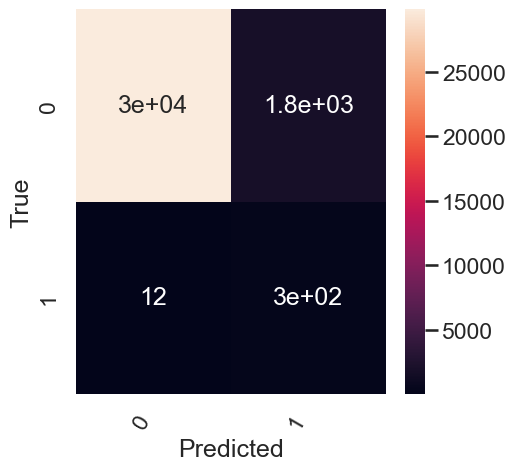

In [ ]:
# , subsample=0.8
lgbmc=LGBMClassifier(application='binary', learning_rate=0.006, n_estimators=5000, random_state=42,
                     scale_pos_weight = 110, class_weight='balanced', colsample_bytree=0.69, max_depth=8, num_leaves=240, max_bin=50)
lgbmc.fit(X_train, y_train)
y_pred = lgbmc.predict(X_test)
report(y_test, y_pred)

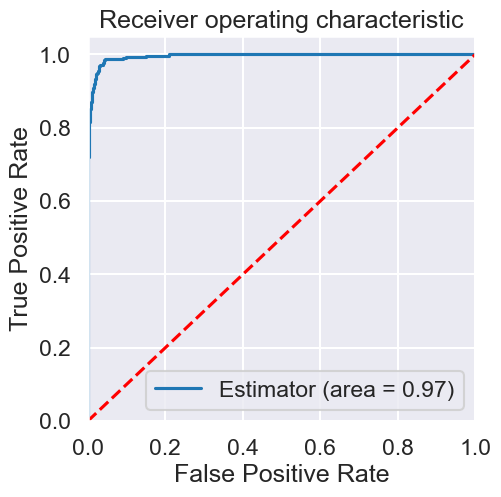

In [ ]:
roc_auc(lgbmc, X_test, y_test)

In [ ]:
%%time

def objective(space):
    params = {
        'colsample_bytree': '{:.3f}'.format(space['colsample_bytree']),
        'learning_rate': '{:.3f}'.format(space['learning_rate']),
        'n_estimators': space['n_estimators']
    }

    clf = LGBMClassifier(
        application='binary', boosting='dart', is_unbalance=True, class_weight='balanced',
        random_state=42,
        **params
    )

    score = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=10).mean()
    print("AUC {:.3f} params {}".format(score, params))
    return {'loss':1 - score, 'status': STATUS_OK }

space = {
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0, 1),
    'n_estimators': hp.choice('n_estimators', [100, 1000, 3000])
    }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boostin

In [ ]:
lgbmc=LGBMClassifier(application='binary', random_state=42, is_unbalance=True)

In [ ]:
parameters = {
    'learning_rate':[0.001, 0.005, 0.01, 0.05, 0.1],
    "n_estimators":[100,500,1000,2000],
    "max_depth":[10,15,20,25],
}